In [4]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [1062]:
def roundAngle(a):
    if a < -np.pi:
        return a + np.pi
    if a > np.pi:
        return a - np.pi
    
    return a

In [1138]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching
from filterpy.kalman import ExtendedKalmanFilter
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1172]:
class DynamicObjectTrack:
    def __init__(self, z, P, create_frame_idx, ego, ego_speed):
        self.kf = ExtendedKalmanFilter(dim_x=4, dim_z=3)
        print(f"z={z}")
        print(z[0]*math.cos(z[1]), z[0]*math.sin(z[1]), z[2]*math.cos(z[1]), z[2]*math.sin(z[1]))
        self.kf.x = np.array([z[0]*np.cos(z[1]), z[0]*np.sin(z[1]), z[2]*np.cos(z[1]), z[2]*np.sin(z[1])])
        self.kf.x = self.kf.x.reshape(-1,1)
        print("self.kf.x.shape", self.kf.x.shape)
        #self.kf.x_prior = np.array([0,0,0,0])
        self.kf.F = np.eye(4)
        self.kf.P = np.diag([4,4,1,1])
        self.kf.P_post = self.kf.P.copy()
        #self.kf.y = np.zeros((1, 3))
        self.ego = [ego]
        self.ego_speed = [ego_speed]
        
        self.noise_ax = 9.0
        self.noise_ay = 9.0
        dt = 0.125 # [sec]
        dt_2 = dt*dt
        dt_3 = dt_2*dt;
        dt_4 = dt_3*dt;
        self.kf.Q = np.array([[dt_4/4*self.noise_ax, 0, dt_3/2*self.noise_ax, 0],
                              [0, dt_4/4*self.noise_ay, 0, dt_3/2*self.noise_ay],
                              [dt_3/2*self.noise_ax, 0, dt_2*self.noise_ax, 0],
                              [0, dt_3/2*self.noise_ay, 0, dt_2*self.noise_ay]])
        self.kf.R = np.diag([2, 0.02, 0.4])
        self.kf.K = np.zeros((4,3)) # kalman gain
        self.saver = Saver(self.kf)
        self.create_frame_idx = create_frame_idx
        self.last_update_frame_idx = create_frame_idx
        self.hits = 1
        self.age = 1
        self.confirmed = False
    
    def predict(self, dt, ego, last_ego, speed, last_speed):
        self.age += 1
        self.ego.append(ego)
        self.ego_speed.append(speed)
        dT = (ego["T"]-last_ego["T"])[0:2].reshape(-1,1)
        dV = (speed-last_speed)[0:2].reshape(-1,1)
        dheading = ego["heading"]-last_ego["heading"]
        dR = np.array([[np.cos(-dheading), -np.sin(-dheading)], [np.sin(-dheading), np.cos(-dheading)]])
        self.kf.F[0, 2] = dt
        self.kf.F[1, 3] = dt
        dt_2 = dt*dt
        dt_3 = dt_2*dt;
        dt_4 = dt_3*dt;
        self.kf.Q = np.array([[dt_4/4*self.noise_ax, 0, dt_3/2*self.noise_ax, 0],
                              [0, dt_4/4*self.noise_ay, 0, dt_3/2*self.noise_ay],
                              [dt_3/2*self.noise_ax, 0, dt_2*self.noise_ax, 0],
                              [0, dt_3/2*self.noise_ay, 0, dt_2*self.noise_ay]])
        self.kf.predict()
        tmp = np.dot(dR, self.kf.x_prior[0:2])
        dRV = np.dot(dR, dV)
        self.kf.x_prior[0:2] = np.dot(dR, self.kf.x_prior[0:2]) - dRV * dt# - dT
        self.kf.x_prior[2:4] = np.dot(dR, self.kf.x_prior[2:4]) - dRV
        self.kf.x = np.copy(self.kf.x_prior)
        #rotate covariance matrix
        self.kf.P_prior[0:2,0:2] = np.dot(np.dot(dR, self.kf.P_prior[0:2,0:2]), dR.T)
        self.kf.P_prior[2:4,2:4] = np.dot(np.dot(dR, self.kf.P_prior[2:4,2:4]), dR.T)
        self.kf.P = np.copy(self.kf.P_prior)
        
    def calculateJacobian(self, x):
        Hj = np.zeros([3,4])
        #recover state parameters
        px = x[0];
        py = x[1];
        vx = x[2];
        vy = x[3];

        #pre-compute a set of terms to avoid repeated calculation
        c1 = px*px+py*py
        c2 = np.sqrt(c1)
        c3 = c1*c2

        #check division by zero
        if abs(c1) < 0.0001:
            print("CalculateJacobian () - Error - Division by Zero")
            return Hj

        #compute the Jacobian matrix
        Hj = np.array([[float(px/c2), float(py/c2), 0, 0],
                       [-float(py/c1), float(px/c1), 0, 0],
                       [float(py*(vx*py - vy*px)/c3), float(px*(px*vy - py*vx)/c3), float(px/c2), float(py/c2)]])

        return Hj
    
    
    def Hx(self, x):
        px = x[0];
        py = x[1];
        vx = x[2];
        vy = x[3];
        
        r = math.sqrt(px**2+py**2)
        phi = math.atan2(py,px)
        rho = (px*vx+py*vy)/r
        
        hx = np.array([float(r), float(phi), float(rho)])
        hx=hx.reshape(-1,1)
        
        return hx
   
    def update(self, z, cov, current_frame_idx):
        self.hits += 1
    
        self.kf.update(z,HJacobian=self.calculateJacobian,Hx=self.Hx)
        self.last_update_frame_idx = current_frame_idx
        
    def save(self):
        self.saver.save()
        
    def getHistory(self):
        self.saver.to_array()
        return self.saver.x, self.ego, self.ego_speed
    
    def getStateVector(self):
        return self.kf.x
    
    def getPredictedStateVector(self):
        return self.kf.x_prior
        
    def getInnovationCovarianceMatrix(self):
        return self.kf.S
    
    def getCovarianceMatrix(self):
        return self.kf.P_post
    
    def getLastUpdateFrameIdx(self):
        return self.last_update_frame_idx
    

class DynamicTracker:
    def __init__(self):
        self.pnt_data_associator = PointObjectDataAssociator(dim=3,delta=1)
        self.dyn_object_list = []
        self.dyn_max_non_update_iterations = 5
        self.frame_idx = 0
        self.history_dyn_object_list = []
        self.last_ts = 0

    def run(self, z, dz, ts, ego, speed):
        self.frame_idx += 1
        print(f"frame_idx = {self.frame_idx}")
        print(f"Number of new plots {len(z)}")
        print(f"Number of dynamic tracks before run() {len(self.dyn_object_list)}")
        
        #Prediction
        
        if self.last_ts > 0:
            dt = (ts - self.last_ts) / 1e6
            self.last_ts = ts
            for dyn_track in self.dyn_object_list:
                dyn_track.predict(dt, ego, self.last_ego, speed, self.last_speed)
        self.last_ts = ts
        self.last_ego = ego
        self.last_speed = speed
        
        #Association
        Gp = self.p2t(z)
        
        #Update
        z, dz = self.trackUpdate(z, dz, Gp)
        
        #Init
        self.trackInit(z,dz,ego,speed)
            
        #Maintenance
        self.trackMaintenance()
        
        return self.getTracks()
        
    def p2t(self, measurements):
        Gp = np.zeros((len(measurements), len(self.dyn_object_list)))
        for idx_z, z in enumerate(measurements):
            z = z.reshape(-1,1)
            for idx_track, dyn_track in enumerate(self.dyn_object_list):
                x = dyn_track.getStateVector()
                x_pred = dyn_track.getPredictedStateVector()
                innov_cov = dyn_track.getCovarianceMatrix()
                z_pred = dyn_track.Hx(x_pred)
                z_pred_reshaped = z_pred.reshape(-1,1)
                #print(f"z={z} z_pred={z_pred}")
                H = dyn_track.calculateJacobian(dyn_track.kf.x)
                cov = np.dot(np.dot(H, dyn_track.kf.P), H.T) + dyn_track.kf.R
                #cov = dyn_track.kf.R
                Gp[idx_z,idx_track] = self.pnt_data_associator.calcLikelihood(z, z_pred, cov)
        
        #print(f"Gp = {Gp}")
        return Gp
    
    def trackUpdate(self, z, dz, Gp):
        assigned_meas_list = []
        while(1): #Iterate over GP
            i_meas, lp, i_trk = self.getBestAssociation(Gp)
            if(lp == 0):
                break
            self.zeroOutAssociation(Gp, i_meas, i_trk) # Clear from point association matrix
            zm = z[i_meas]
            cov = dz[i_meas]
            assigned_meas_list.append(i_meas)
            
            zm=zm.reshape(-1,1)

            #print(f"Updating track = {i_trk} z = {zm} cov={cov}")
            self.dyn_object_list[i_trk].update(z=zm,cov=cov, current_frame_idx=self.frame_idx)
                
        for i_meas in sorted(assigned_meas_list, reverse=True):
            z = np.delete(z, (i_meas), axis=0)
            dz = np.delete(dz, (i_meas), axis=0)
        
        return z, dz
        
    def trackInit(self, z, dz, ego, ego_speed):
        for z,cov in zip(z,dz):
            new_trk = DynamicObjectTrack(z=z, P=cov, create_frame_idx=self.frame_idx, ego=ego, ego_speed=ego_speed)
            print(f"Initiating new track: x={new_trk.kf.x} for measurement z={z}")
            self.dyn_object_list.append(new_trk)

            
    def deleteTrack(self, track_list, indices):
        delete_indices  = np.unique(indices)
        #print("deleteTrack is called. track list length:", len(track_list), "indices", indices)
        for index in sorted(delete_indices, reverse=True):
            self.history_dyn_object_list.append(track_list[index])
            del track_list[index]
        
    def trackMaintenance(self):
        dyn_delete_list = []
        for i_trk,trk in enumerate(self.dyn_object_list):
            trk.save()
            print(f"trk.kf.x = {trk.kf.x} age = {trk.age} hits = {trk.hits}")
            if trk.age > 10 and (float(trk.hits) / trk.age) > 0.5:
                trk.confirmed = True
            if self.frame_idx - trk.getLastUpdateFrameIdx() > self.dyn_max_non_update_iterations:
                dyn_delete_list.append(i_trk)

        self.deleteTrack(self.dyn_object_list, dyn_delete_list)
        
    def isTrkSimilar(self, x_cand):
        x, y, vx, vy = x_cand[0], x_cand[1], x_cand[2], x_cand[3]
        for trk in self.dyn_object_list:
            state_adv = trk.getStateVector()
            x_adv, y_adv, vx_adv, vy_adv = state_adv[0], state_adv[1], state_adv[2], state_adv[3] 
            
            pos_thr = 4
            vel_thr = 1
            pos_dist = sqrt((x-x_adv)**2+(y-y_adv)**2)
            vel_dist = sqrt((vx-vx_adv)**2+(vy-vy_adv)**2)
            if dist > dist_thr or vel_dist > vel_thr:
                return True
        
        return False
                
                    
    @staticmethod
    def getBestAssociation(Gp):
        i_meas,lp,i_trk_p = None,0,None
        if Gp.size > 0:
            ind = np.unravel_index(np.argmax(Gp, axis=None), Gp.shape)
            i_meas = ind[0]
            i_trk_p = ind[1]
            lp = Gp[ind]
        
        return i_meas,lp, i_trk_p
    
    @staticmethod
    def zeroOutAssociation(mat, i, j, k=None):
        if mat is not None:
            if mat.ndim == 2:
                mat[i, :] = 0
                mat[:, j] = 0
            elif mat.ndim == 3:
                mat[i, :, k] = 0
                mat[:, j, k] = 0
        
        return mat
          
    @staticmethod
    def createProbabilityMatrix(pairs):
        if pairs:
            u_meas = np.unique([item[0] for item in pairs])
            u_trk = np.unique([item[1] for item in pairs])
            P = np.zeros((len(u_meas),len(u_trk)))
            for i in range(0, len(u_meas)):
                for j in range(0, len(u_trk)):
                    P[i,j] = max([pair[2] if pair[0]==u_meas[i] and pair[1]==u_trk[j] else 0 for pair in pairs])
        else:
            P = None
            
        #print("createProbabilityMatrix: P = ", P)
 
        return P
    
    def getTracks(self):
        return self.dyn_object_list
    
    def getHistory(self):
        return self.history_dyn_object_list + self.dyn_object_list 

In [1173]:
scene_id = 690
N = 800

dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=N)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

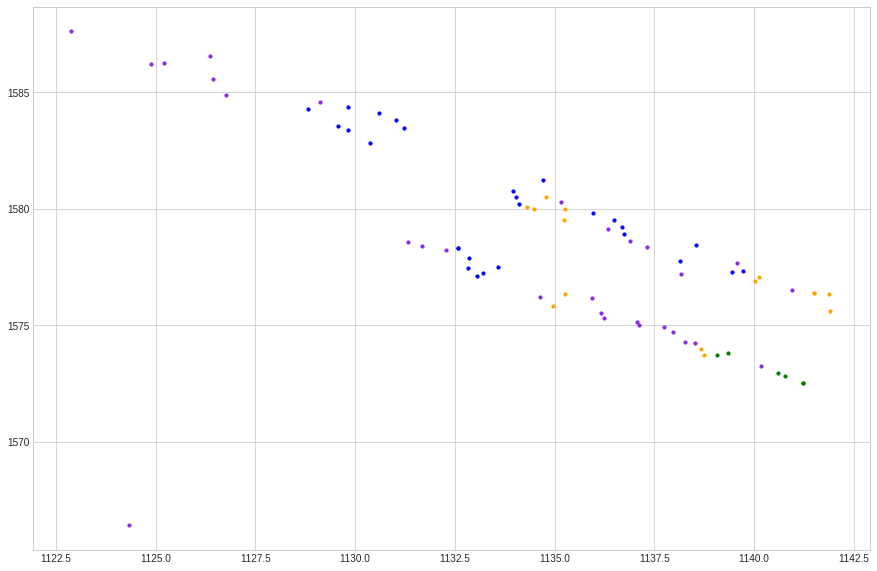

In [91]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,20):
    pc = dataset.getDynamicPoints(t)
    pc = np.squeeze(pc[np.where(pc[:,3]==0) or np.where(pc[:,3]==2) or np.where(pc[:,3]==6), :], axis=0)
    clus = DBSCAN(eps=2, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    for i in range(pc.shape[0]):
        v_comp = np.sqrt(pc[i,8]**2 + pc[i,9]**2)
        if v_comp > 3:
            #c = int(np.round(v_comp) % 17)
            ax.scatter(pc[i,0], pc[i,1], s=10, c=colors[c[i]])

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

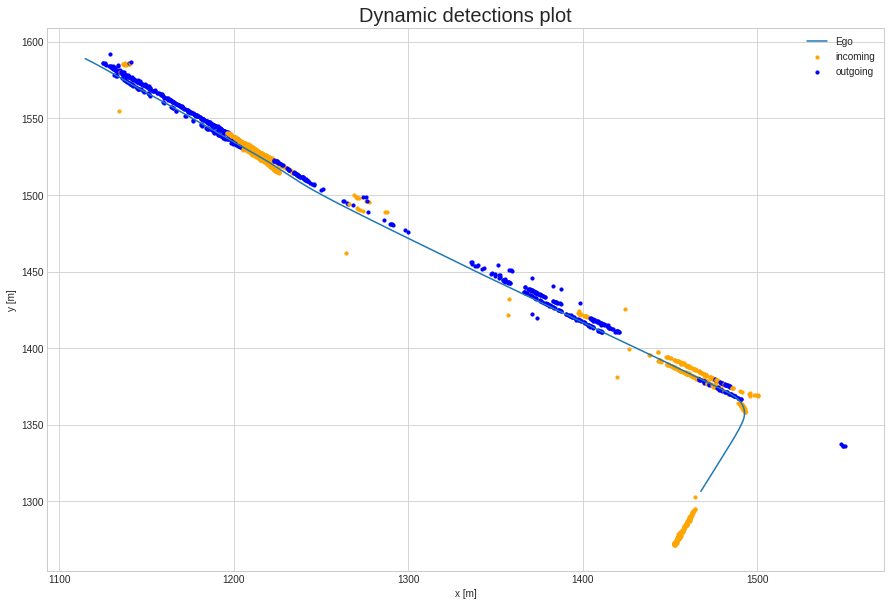

In [1174]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

start_frame = 0
n_frames = 800
ego_path = dataset.getEgoPath()
ax.plot(ego_path[start_frame:n_frames,0], ego_path[start_frame:n_frames,1])

for t in range(start_frame,n_frames):
    pc, ts, heading, speed = dataset.getDynamicPoints(t)
    if pc.shape[0] < 1:
        continue
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+6:7])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in n_clusters:
        if c[i] == -1:
            continue
        x_com = pc[c==i,0]
        y_com = pc[c==i,1]
        vx_com = np.mean(pc[c==i,6])
        vy_com = np.mean(pc[c==i,7])
        v_towards = 0 if vx_com > 0 else 1
        ax.scatter(x_com, y_com, s=10, c=colors[v_towards])
        
ax.set_title(f"Dynamic detections scene={scene_id}", fontsize=20)
ax.set(xlabel='x [m]', ylabel='y [m]')
ax.legend(['Ego', 'incoming','outgoing'])
leg = ax.get_legend()
#leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('orange')
leg.legendHandles[2].set_color('blue')

In [1175]:
from sklearn.cluster import DBSCAN
import numpy as np
import math

def calcClusterProperiesArray(ci, ego, heading, vnorm):
    x_com = np.mean(ci[:,0])
    y_com = np.mean(ci[:,1])
    print("x_com", x_com, "y_com", y_com, "ci", ci[:,0:2])
    dx = x_com-ego[0]
    dy = y_com-ego[1]
    R = np.array([[np.cos(-heading), -np.sin(-heading)], [np.sin(-heading), np.cos(-heading)]])
    transformed_target = np.dot(R, np.array([x_com-ego[0], y_com-ego[1]]))
    vx_com = 1*np.mean(ci[:,6])
    vy_com = 1*np.mean(ci[:,7])
    dx = transformed_target[0]
    dy = transformed_target[1]
    r = np.sqrt(dx**2+dy**2)
    phi = roundAngle(math.atan2(dy, dx))
    vr = np.sign(vx_com) * np.sqrt(vx_com**2+vy_com**2) #+ vnorm

    X = np.array([r, phi, vr])
    P = np.diag([2, 0.01, 0.25])
    
    return X,P

def calcClusterProperiesScalar(ci, ego, heading, vnorm):
    x_com = ci[0,0]
    y_com = ci[0,1]
    print("x_com", x_com, "ci", "y_com", y_com, ci[:,0:2])
    dx = x_com-ego[0]
    dy = y_com-ego[1]
    R = np.array([[np.cos(-heading), -np.sin(-heading)], [np.sin(-heading), np.cos(-heading)]])
    transformed_target = np.dot(R, np.array([x_com-ego[0], y_com-ego[1]]))
    vx_com = ci[0,6]
    vy_com = ci[0,7]
    dx = transformed_target[0]
    dy = transformed_target[1]
    r = np.sqrt(dx**2+dy**2)
    phi = roundAngle(math.atan2(dy, dx))
    vr = np.sign(vx_com) * np.sqrt(vx_com**2+vy_com**2) #+ vnorm

    X = np.array([r, phi, vr])
    P = np.diag([2, 0.01, 0.25])
    
    return X,P


def runClustering(pc, ego, heading, vnorm):
    X_list = []
    P_list = []
    
    if pc.shape[0] < 1:
        return X_list, P_list
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+6:8])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in n_clusters:
        ci = pc[c==i, :]
        if i == -1:
            #continue #don't consider 1 point clusters
            for j in range(ci.shape[0]):
                X, P = calcClusterProperiesScalar(ci, ego, heading, vnorm)
                if X is not None:
                    X_list.append(X)
                    P_list.append(P)
        else:
            X, P = calcClusterProperiesArray(ci, ego, heading, vnorm)
            if X is not None:
                X_list.append(X)
                P_list.append(P)
        
    return X_list, P_list

In [1176]:
start_frame=0
n_frames = 800
ego_path = dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()

for t in range(start_frame,n_frames):
    pc, ts, heading, ego_speed = dataset.getDynamicPoints(t)
    print(ego_path[t], ego_speed)
    X, P = runClustering(pc, ego_path[t], np.deg2rad(heading), np.linalg.norm(ego_speed[0:2]))
    print(f"X={X}, ego_path[t]={ego_path[t]}")
    tracker.run(X, P, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)
    


[1114.93531372 1589.04348036    0.        ] [2.80133837 0.         0.        ]
x_com 1122.8854568240802 ci y_com 1587.5956175679385 [[1122.88545682 1587.59561757]
 [1131.31723471 1578.58993637]]
x_com 1122.8854568240802 ci y_com 1587.5956175679385 [[1122.88545682 1587.59561757]
 [1131.31723471 1578.58993637]]
X=[array([8.0809085 , 0.33751558, 1.25      ]), array([8.0809085 , 0.33751558, 1.25      ])], ego_path[t]=[1114.93531372 1589.04348036    0.        ]
frame_idx = 1
Number of new plots 2
Number of dynamic tracks before run() 0
z=[8.0809085  0.33751558 1.25      ]
7.624985876371018 2.6759432926873408 1.179475346143998 0.4139298344387563
self.kf.x.shape (4, 1)
Initiating new track: x=[[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] for measurement z=[8.0809085  0.33751558 1.25      ]
z=[8.0809085  0.33751558 1.25      ]
7.624985876371018 2.6759432926873408 1.179475346143998 0.4139298344387563
self.kf.x.shape (4, 1)
Initiating new track: x=[[7.62498588]
 [2.67594329]
 [1.17947

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1115.11507448 1588.94254053    0.        ] [2.85275322 0.         0.        ]
x_com 1133.289552044279 y_com 1581.201610402149 ci [[1133.50100746 1585.17606875]
 [1131.66788994 1578.38528941]
 [1133.95789135 1580.75909624]
 [1134.03141943 1580.48598721]]
X=[array([19.75433203,  0.11523781,  2.        ])], ego_path[t]=[1115.11507448 1588.94254053    0.        ]
frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 2
z=[19.75433203  0.11523781  2.        ]
19.623310810198184 2.2714107743884897 1.986734937701519 0.2299658394547795
self.kf.x.shape (4, 1)
Initiating new track: x=[[19.62331081]
 [ 2.27141077]
 [ 1.98673494]
 [ 0.22996584]] for measurement z=[19.75433203  0.11523781  2.        ]
trk.kf.x = [[7.70915563]
 [2.70883855]
 [1.12796487]
 [0.41419036]] age = 2 hits = 1
trk.kf.x = [[7.70915563]
 [2.70883855]
 [1.12796487]
 [0.41419036]] age = 2 hits = 1
trk.kf.x = [[19.62331081]
 [ 2.27141077]
 [ 1.98673494]
 [ 0.22996584]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1115.29705166 1588.84075007    0.        ] [2.92324084 0.         0.        ]
x_com 1124.3290186330983 ci y_com 1566.4448038371697 [[1124.32901863 1566.44480384]]
x_com 1133.732726643595 y_com 1581.0490464055747 ci [[1133.82703899 1584.51530327]
 [1132.28905111 1578.24552482]
 [1134.10767185 1580.19794813]
 [1134.70714462 1581.2374094 ]]
X=[array([24.14859903, -0.66889126,  2.75      ]), array([20.01461361,  0.11869701,  2.0625    ])], ego_path[t]=[1115.29705166 1588.84075007    0.        ]
frame_idx = 3
Number of new plots 2
Number of dynamic tracks before run() 3
z=[24.14859903 -0.66889126  2.75      ]
18.94481003194724 -14.974946006060211 2.1574016582385998 -1.7053205226670265
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 18.94481003]
 [-14.97494601]
 [  2.15740166]
 [ -1.70532052]] for measurement z=[24.14859903 -0.66889126  2.75      ]
trk.kf.x = [[7.78656976]
 [2.74517914]
 [1.05719567]
 [0.41490854]] age = 3 hits = 1
trk.kf.x = [[7.78656976]
 [2.74517914]
 [1.05719567]
 [0.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1115.49526454 1588.72898093    0.        ] [2.99289708 0.         0.        ]
x_com 1128.8484881673244 ci y_com 1592.2311046249708 [[1128.84848817 1592.23110462]]
x_com 1133.6269731112131 y_com 1579.0417500877556 ci [[1132.58175838 1578.29814069]
 [1134.47458435 1579.97642835]
 [1132.58175838 1578.29814069]
 [1134.30138265 1580.07643135]
 [1134.77458832 1580.49600377]
 [1133.04776658 1577.10535567]]
X=[array([13.80483436,  0.77557624,  1.75      ]), array([20.55726872,  0.02839853,  3.        ])], ego_path[t]=[1115.49526454 1588.72898093    0.        ]
frame_idx = 4
Number of new plots 2
Number of dynamic tracks before run() 4
z=[13.80483436  0.77557624  1.75      ]
9.856896252302992 9.665146038020096 1.249530997156875 1.2252233621442847
self.kf.x.shape (4, 1)
Initiating new track: x=[[9.85689625]
 [9.66514604]
 [1.249531  ]
 [1.22522336]] for measurement z=[13.80483436  0.77557624  1.75      ]
z=[20.55726872  0.02839853  3.        ]
20.548979800589183 0.5837176887019978 2.99879036677

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1115.70495316 1588.6101875     0.        ] [3.05936255 0.         0.        ]
x_com 1133.6164257320718 y_com 1578.5415884366394 ci [[1132.86085763 1577.90029445]
 [1135.15451701 1580.27055597]
 [1132.83390256 1577.45391488]]
X=[array([2.05474460e+01, 7.32520619e-03, 3.08333333e+00])], ego_path[t]=[1115.70495316 1588.6101875     0.        ]
frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 6
trk.kf.x = [[7.92727678]
 [2.81427615]
 [0.92071462]
 [0.41573958]] age = 5 hits = 1
trk.kf.x = [[7.92727678]
 [2.81427615]
 [0.92071462]
 [0.41573958]] age = 5 hits = 1
trk.kf.x = [[20.12641682]
 [ 2.38344587]
 [ 1.87542557]
 [ 0.24442365]] age = 4 hits = 2
trk.kf.x = [[ 19.26614611]
 [-15.21407111]
 [  2.02275464]
 [ -1.70353678]] age = 3 hits = 1
trk.kf.x = [[9.94226894]
 [9.76057052]
 [1.18263713]
 [1.22563688]] age = 2 hits = 1
trk.kf.x = [[20.62226037]
 [ 0.45201561]
 [ 3.0399716 ]
 [ 0.08659511]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1115.90972548 1588.49370469    0.        ] [3.10778121 0.         0.        ]
x_com 1126.7738244469979 ci y_com 1584.8838062962134 [[1126.77382445 1584.8838063 ]]
x_com 1134.6885507348295 y_com 1577.9541678278779 ci [[1133.58484526 1577.48326239]
 [1135.25897035 1579.98052801]
 [1136.15537798 1575.53588048]
 [1133.21155224 1577.23701762]
 [1135.23200785 1579.53415064]]
X=[array([11.44814451,  0.19864912,  1.5       ]), array([2.15343009e+01, 8.01314861e-03, 3.00000000e+00])], ego_path[t]=[1115.90972548 1588.49370469    0.        ]
frame_idx = 6
Number of new plots 2
Number of dynamic tracks before run() 6
z=[11.44814451  0.19864912  1.5       ]
11.2230059991343 2.259236384932717 1.4705010917205366 0.29601780224964513
self.kf.x.shape (4, 1)
Initiating new track: x=[[11.223006  ]
 [ 2.25923638]
 [ 1.47050109]
 [ 0.2960178 ]] for measurement z=[11.44814451  0.19864912  1.5       ]
trk.kf.x = [[7.99262538]
 [2.84556015]
 [0.87228979]
 [0.41575251]] age = 6 hits = 1
trk.kf.x = [[7.99262538

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1116.34017475 1588.2474085     0.        ] [3.23568426 0.         0.        ]
x_com 1124.8809163014778 ci y_com 1586.216191101638 [[1124.8809163 1586.2161911]]
x_com 1136.5219768242596 y_com 1578.1121120646173 ci [[1136.4866574  1579.51793869]
 [1137.11227607 1575.00053686]
 [1135.966997   1579.81786064]]
X=[array([8.77895839, 0.28542253, 1.5       ]), array([22.58382981,  0.0535058 ,  2.5       ])], ego_path[t]=[1116.34017475 1588.2474085     0.        ]
frame_idx = 7
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[8.40614934]
 [2.6196606 ]
 [1.25256972]
 [0.54044084]] age = 7 hits = 2
trk.kf.x = [[8.10588373]
 [2.90358629]
 [0.74461018]
 [0.41535221]] age = 7 hits = 1
trk.kf.x = [[20.51960094]
 [ 2.42771675]
 [ 1.69923143]
 [ 0.24353714]] age = 6 hits = 2
trk.kf.x = [[ 19.68305152]
 [-15.60768562]
 [  1.84554198]
 [ -1.70450006]] age = 5 hits = 1
trk.kf.x = [[10.18353927]
 [10.03103437]
 [ 1.00695611]
 [ 1.22511246]] age = 4 hits = 1
trk.kf.x = [[21.826831

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1116.56311837 1588.11957897    0.        ] [3.29906253 0.         0.        ]
x_com 1125.2043064290608 ci y_com 1586.2642833268733 [[1125.20430643 1586.26428333]]
x_com 1135.4899406079703 y_com 1577.6774077655118 ci [[1134.64067185 1576.20485851]
 [1136.33920936 1579.14995702]]
X=[array([8.83811365, 0.30709688, 1.5       ]), array([2.16162795e+01, 1.44325623e-02, 2.75000000e+00])], ego_path[t]=[1116.56311837 1588.11957897    0.        ]
frame_idx = 8
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.47815274]
 [2.6668578 ]
 [1.28289809]
 [0.56167799]] age = 8 hits = 3
trk.kf.x = [[20.6431365 ]
 [ 2.43934822]
 [ 1.63593144]
 [ 0.24301071]] age = 7 hits = 2
trk.kf.x = [[ 19.811715  ]
 [-15.74196241]
 [  1.78161511]
 [ -1.70507348]] age = 6 hits = 1
trk.kf.x = [[10.25759956]
 [10.11966277]
 [ 0.94397203]
 [ 1.22480875]] age = 5 hits = 1
trk.kf.x = [[21.93757667]
 [ 0.50262187]
 [ 2.67429967]
 [ 0.0939581 ]] age = 5 hits = 5
trk.kf.x = [[11.52244777]
 [ 2.315961

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1116.796688   1587.98595931    0.        ] [3.34644697 0.         0.        ]
x_com 1126.3581465497075 ci y_com 1586.5297606760257 [[1126.35814655 1586.52976068]]
x_com 1135.9096413002399 y_com 1577.5670714469202 ci [[1136.67794802 1579.20164619]
 [1134.95486904 1575.809102  ]
 [1135.25429907 1576.32900683]
 [1136.75144908 1578.92853076]]
X=[array([9.67171154, 0.36685278, 1.5       ]), array([2.17682845e+01, 1.88999259e-02, 2.75000000e+00])], ego_path[t]=[1116.796688   1587.98595931    0.        ]
frame_idx = 9
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.71621583]
 [2.92245989]
 [1.2754758 ]
 [0.63431617]] age = 9 hits = 4
trk.kf.x = [[20.76377937]
 [ 2.44512733]
 [ 1.58869244]
 [ 0.24205802]] age = 8 hits = 2
trk.kf.x = [[ 19.93229627]
 [-15.88183323]
 [  1.73320782]
 [ -1.70611318]] age = 7 hits = 1
trk.kf.x = [[10.33098354]
 [10.20535429]
 [ 0.89732193]
 [ 1.22427085]] age = 6 hits = 1
trk.kf.x = [[22.07194295]
 [ 0.48442364]
 [ 2.66486559]
 [ 0.090

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1117.03905857 1587.84778252    0.        ] [3.41242582 0.         0.        ]
x_com 1137.1251819483493 y_com 1576.346679387393 ci [[1136.89988758 1578.6294414 ]
 [1135.95052867 1576.17630064]
 [1138.52512959 1574.23429612]]
X=[array([ 2.31457928e+01, -2.66243887e-03,  3.00000000e+00])], ego_path[t]=[1117.03905857 1587.84778252    0.        ]
frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[8.80882818]
 [2.96448221]
 [1.20989746]
 [0.6335519 ]] age = 10 hits = 4
trk.kf.x = [[10.3998553 ]
 [10.29063187]
 [ 0.8321164 ]
 [ 1.22374537]] age = 7 hits = 1
trk.kf.x = [[22.42106783]
 [ 0.41393571]
 [ 2.73298506]
 [ 0.07183341]] age = 7 hits = 7
trk.kf.x = [[11.70525955]
 [ 2.34579012]
 [ 1.16647263]
 [ 0.29340832]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1117.2879713  1587.70397448    0.        ] [3.47801296 0.         0.        ]
x_com 1126.4494855787455 ci y_com 1585.55132786423 [[1126.44948558 1585.55132786]]
x_com 1136.7742317247457 y_com 1576.8307731274717 ci [[1137.31323418 1578.36672469]
 [1136.23522927 1575.29482156]]
X=[array([9.41101649, 0.28752999, 1.5       ]), array([2.23145883e+01, 9.35063263e-03, 2.75000000e+00])], ego_path[t]=[1117.2879713  1587.70397448    0.        ]
frame_idx = 11
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[8.93640132]
 [2.94138513]
 [1.24121837]
 [0.60693345]] age = 11 hits = 5
trk.kf.x = [[22.5827029 ]
 [ 0.41463739]
 [ 2.6900218 ]
 [ 0.06480234]] age = 8 hits = 8
trk.kf.x = [[11.78559613]
 [ 2.37901923]
 [ 1.1006058 ]
 [ 0.29445575]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1117.81298521 1587.40070318    0.        ] [3.58743695 0.         0.        ]
x_com 1137.9210558045754 y_com 1577.1285654000958 ci [[1138.54389813 1578.46297709]
 [1137.07794985 1575.15100296]
 [1138.14131944 1577.77171615]]
X=[array([22.57988746,  0.05053253,  2.5       ])], ego_path[t]=[1117.81298521 1587.40070318    0.        ]
frame_idx = 12
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.09246471]
 [3.07349389]
 [1.12904579]
 [0.61203131]] age = 12 hits = 5
trk.kf.x = [[22.91321102]
 [ 0.59715468]
 [ 2.53822921]
 [ 0.11100764]] age = 9 hits = 9
trk.kf.x = [[11.92327868]
 [ 2.47699915]
 [ 0.98984383]
 [ 0.29892267]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1118.06451708 1587.25413712    0.        ] [3.6488849 0.        0.       ]
x_com 1137.9466114134475 y_com 1576.0615790047932 ci [[1138.15829816 1577.21265775]
 [1137.73492466 1574.91050026]]
X=[array([2.28160258e+01, 1.33928991e-02, 2.75000000e+00])], ego_path[t]=[1118.06451708 1587.25413712    0.        ]
frame_idx = 13
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[9.16278021]
 [3.15001029]
 [1.06557115]
 [0.6155531 ]] age = 13 hits = 5
trk.kf.x = [[23.0827166 ]
 [ 0.64438055]
 [ 2.57257677]
 [ 0.10044903]] age = 10 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1118.3272308  1587.10161028    0.        ] [3.71163957 0.         0.        ]
x_com 1137.972715766367 ci y_com 1574.7184620790094 [[1137.97271577 1574.71846208]]
X=[array([23.22256314, -0.03428707,  3.5       ])], ego_path[t]=[1118.3272308  1587.10161028    0.        ]
frame_idx = 14
Number of new plots 1
Number of dynamic tracks before run() 2
z=[23.22256314 -0.03428707  3.5       ]
23.20891422046923 -0.7960776482333635 3.4979428959931904 -0.11998123341077871
self.kf.x.shape (4, 1)
Initiating new track: x=[[23.20891422]
 [-0.79607765]
 [ 3.4979429 ]
 [-0.11998123]] for measurement z=[23.22256314 -0.03428707  3.5       ]
trk.kf.x = [[9.23602358]
 [3.21755017]
 [1.00157432]
 [0.61757217]] age = 14 hits = 5
trk.kf.x = [[23.28084325]
 [ 0.69926867]
 [ 2.50961464]
 [ 0.10550523]] age = 11 hits = 10
trk.kf.x = [[23.20891422]
 [-0.79607765]
 [ 3.4979429 ]
 [-0.11998123]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1118.57059801 1586.95978858    0.        ] [3.77742471 0.         0.        ]
x_com 1138.9248582161981 y_com 1575.9733808971873 ci [[1139.58319862 1577.67517996]
 [1138.26651781 1574.27158184]]
X=[array([23.13000351,  0.034791  ,  2.75      ])], ego_path[t]=[1118.57059801 1586.95978858    0.        ]
frame_idx = 15
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.30118524]
 [3.27891576]
 [0.93479869]
 [0.61907042]] age = 15 hits = 5
trk.kf.x = [[23.45067252]
 [ 0.75450604]
 [ 2.5560541 ]
 [ 0.11687246]] age = 12 hits = 11
trk.kf.x = [[23.46838533]
 [-0.76751114]
 [ 3.43234555]
 [-0.1144831 ]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1118.81884931 1586.81577536    0.        ] [3.84172616 0.         0.        ]
x_com 1129.1180670771766 ci y_com 1584.553932020361 [[1129.11806708 1584.55393202]]
x_com 1139.1446896822013 y_com 1575.58366261703 ci [[1139.71889769 1577.33574228]
 [1138.74249533 1573.7295494 ]
 [1139.4448576  1577.26577457]
 [1138.67250812 1574.00358422]]
X=[array([10.54465845,  0.3146645 ,  1.75      ]), array([23.22283668,  0.02600656,  2.8125    ])], ego_path[t]=[1118.81884931 1586.81577536    0.        ]
frame_idx = 16
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.61613976]
 [3.34386406]
 [1.3094978 ]
 [0.69633095]] age = 16 hits = 6
trk.kf.x = [[23.61770262]
 [ 0.77217993]
 [ 2.59413334]
 [ 0.10898379]] age = 13 hits = 12
trk.kf.x = [[23.72123418]
 [-0.74980334]
 [ 3.36816884]
 [-0.11075252]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1119.06940426 1586.66822155    0.        ] [3.88860104 0.         0.        ]
x_com 1129.3141728614946 y_com 1584.304780883116 ci [[1128.81702167 1584.2516023 ]
 [1129.81132405 1584.35795946]]
x_com 1139.644270464535 y_com 1575.3632812788333 ci [[1140.12703502 1577.0541359 ]
 [1139.34972406 1573.79312487]
 [1140.02474695 1576.8822899 ]
 [1139.07557583 1573.72357444]]
X=[array([10.51385445,  0.30563325,  1.75      ]), array([23.47608983,  0.02993998,  2.875     ])], ego_path[t]=[1119.06940426 1586.66822155    0.        ]
frame_idx = 17
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.80402321]
 [3.35035432]
 [1.42571616]
 [0.65787039]] age = 17 hits = 7
trk.kf.x = [[23.7973896 ]
 [ 0.80679749]
 [ 2.64630906]
 [ 0.10662273]] age = 14 hits = 13
trk.kf.x = [[23.97145114]
 [-0.72172023]
 [ 3.32145826]
 [-0.10571044]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1119.58251405 1586.36396304    0.        ] [4.01270337 0.         0.        ]
x_com 1136.5253067021804 ci y_com 1585.441307548554 [[1136.5253067  1585.44130755]]
x_com 1130.0789958660557 y_com 1583.8221306990527 ci [[1129.56483508 1583.54717606]
 [1130.59315665 1584.09708533]]
x_com 1140.5679599795808 y_com 1574.86497974972 ci [[1140.96047144 1576.49455713]
 [1140.17544852 1573.23540236]]
X=[array([16.96789663,  0.48032795, -1.52069063]), array([10.79986307,  0.2971446 ,  1.75      ]), array([23.92938691,  0.03346307,  2.875     ])], ego_path[t]=[1119.58251405 1586.36396304    0.        ]
frame_idx = 18
Number of new plots 3
Number of dynamic tracks before run() 3
z=[16.96789663  0.48032795 -1.52069063]
15.047867720172304 7.840356700664247 -1.3486145029315844 -0.7026655836759016
self.kf.x.shape (4, 1)
Initiating new track: x=[[15.04786772]
 [ 7.8403567 ]
 [-1.3486145 ]
 [-0.70266558]] for measurement z=[16.96789663  0.48032795 -1.52069063]
trk.kf.x = [[10.082945  ]
 [ 3.39476308]
 [ 1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1119.85097248 1586.2015602     0.        ] [4.07242562 0.         0.        ]
x_com 1136.7240211561875 ci y_com 1585.529456213458 [[1136.72402116 1585.52945621]]
x_com 1130.4297022958929 y_com 1583.593475749352 ci [[1129.82941797 1583.37071629]
 [1131.02998662 1583.8162352 ]]
x_com 1141.0861252524523 y_com 1574.6301053298198 ci [[1141.48953192 1576.370593  ]
 [1140.76845422 1572.83814646]
 [1141.48953192 1576.370593  ]
 [1140.59698294 1572.94108886]]
X=[array([16.88642932,  0.49632586, -1.52069063]), array([10.89548663,  0.29441786,  1.75      ]), array([24.18326448,  0.03720332,  2.875     ])], ego_path[t]=[1119.85097248 1586.2015602     0.        ]
frame_idx = 19
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.24323347]
 [ 3.38779888]
 [ 1.52363707]
 [ 0.55701236]] age = 19 hits = 9
trk.kf.x = [[24.37416848]
 [ 0.91637205]
 [ 2.70718529]
 [ 0.11505226]] age = 16 hits = 15
trk.kf.x = [[24.68931319]
 [-0.6523321 ]
 [ 3.13800991]
 [-0.09372693]] age = 6 hi

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1120.1493746  1586.02029652    0.        ] [4.11977132 0.         0.        ]
x_com 1137.2616538363666 ci y_com 1584.9529255592827 [[1137.26165384 1584.95292556]]
x_com 1130.793869517478 y_com 1583.1267729965793 ci [[1130.36470547 1582.80152576]
 [1131.22303356 1583.45202023]]
x_com 1141.5608513735447 y_com 1574.2547073065812 ci [[1141.88083237 1576.33787139]
 [1141.22418996 1572.53169404]
 [1141.9141932  1575.61756975]
 [1141.22418996 1572.53169404]]
X=[array([17.14553532,  0.47491505, -1.25      ]), array([11.03076382,  0.27178954,  1.75      ]), array([24.43113642,  0.03475027,  3.        ])], ego_path[t]=[1120.1493746  1586.02029652    0.        ]
frame_idx = 20
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.41062885]
 [ 3.34206313]
 [ 1.5708478 ]
 [ 0.46695985]] age = 20 hits = 10
trk.kf.x = [[24.58186543]
 [ 0.94245182]
 [ 2.76907769]
 [ 0.11258487]] age = 17 hits = 16
trk.kf.x = [[24.92175241]
 [-0.6326667 ]
 [ 3.09076283]
 [-0.09041647]] age = 7 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1120.43533146 1585.8470435     0.        ] [4.17733689 0.         0.        ]
x_com 1138.2668459772851 ci y_com 1584.7911561064445 [[1138.26684598 1584.79115611]]
x_com 1131.3332765816908 y_com 1582.7855353441312 ci [[1130.92142521 1582.68370845]
 [1131.74512795 1582.88736224]]
x_com 1142.140210485069 y_com 1573.6942523837265 ci [[1142.39412935 1575.76005551]
 [1141.45820566 1571.88679451]
 [1142.46202963 1575.48549517]
 [1142.2464773  1571.64466435]]
X=[array([17.86274918,  0.47929837, -1.        ]), array([11.31980743,  0.26457749,  1.75      ]), array([24.87553227,  0.02802375,  3.        ])], ego_path[t]=[1120.43533146 1585.8470435     0.        ]
frame_idx = 21
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.58820224]
 [ 3.30413186]
 [ 1.60005284]
 [ 0.38401741]] age = 21 hits = 11
trk.kf.x = [[24.80674264]
 [ 0.95274784]
 [ 2.80241363]
 [ 0.09545943]] age = 18 hits = 17
trk.kf.x = [[15.14861389]
 [ 7.98689979]
 [-1.18037422]
 [-0.53574944]] age = 4 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1120.72447961 1585.67295092    0.        ] [4.23172354 0.         0.        ]
x_com 1137.4970677920803 ci y_com 1585.9223640133685 [[1137.49706779 1585.92236401]]
x_com 1131.7846256315063 y_com 1581.9019398981366 ci [[1131.03323546 1582.59143375]
 [1132.5360158  1581.21244605]]
x_com 1142.3445238577574 y_com 1573.5693279177449 ci [[1142.55868628 1575.36899269]
 [1141.88931257 1571.56500269]
 [1142.3876688  1575.47269066]
 [1142.54242778 1571.87062563]]
X=[array([16.7744425 ,  0.55541471, -1.5       ]), array([11.68534784,  0.21195131,  1.75      ]), array([24.77748985,  0.03018403,  3.        ])], ego_path[t]=[1120.72447961 1585.67295092    0.        ]
frame_idx = 22
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.80713957]
 [ 3.19382577]
 [ 1.65708915]
 [ 0.21859877]] age = 22 hits = 12
trk.kf.x = [[25.00943304]
 [ 0.98581079]
 [ 2.82205726]
 [ 0.08048205]] age = 19 hits = 18
trk.kf.x = [[14.88534707]
 [ 8.13816825]
 [-1.29885055]
 [-0.53228148]] age = 5

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1121.00597933 1585.50045994    0.        ] [4.28066038 0.         0.        ]
x_com 1131.4778478104065 ci y_com 1582.288313268106 [[1131.47784781 1582.28831327]]
x_com 1138.1876557644798 y_com 1585.2235476629066 ci [[1137.60879844 1585.81084005]
 [1138.76651308 1584.63625527]]
x_com 1142.6783043878104 y_com 1572.9975812190198 ci [[1142.88046934 1574.86541049]
 [1142.47613944 1571.12975195]]
X=[array([10.9534431,  0.2454988,  1.75     ]), array([17.18390775,  0.52701273, -1.125     ]), array([2.50202248e+01, 1.98630873e-02, 3.00000000e+00])], ego_path[t]=[1121.00597933 1585.50045994    0.        ]
frame_idx = 23
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.91574583]
 [ 3.14972871]
 [ 1.67199867]
 [ 0.14812303]] age = 23 hits = 13
trk.kf.x = [[25.21619657]
 [ 0.99960761]
 [ 2.84025408]
 [ 0.04296195]] age = 20 hits = 19
trk.kf.x = [[14.79159852]
 [ 8.23198857]
 [-1.27029802]
 [-0.46626891]] age = 6 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1121.59877381 1585.13572642    0.        ] [4.36025425 0.         0.        ]
x_com 1132.2320482136915 ci y_com 1581.7906431589222 [[1132.23204821 1581.79064316]]
x_com 1144.5961970463707 y_com 1572.5590710970991 ci [[1144.03210031 1575.01725735]
 [1145.26405828 1574.73042133]
 [1143.53962859 1570.39164271]
 [1145.49218305 1570.13183704]
 [1145.50034502 1574.35073047]
 [1143.74886701 1570.73253769]]
X=[array([11.14702232,  0.24117269,  1.75      ]), array([26.21170988,  0.0455184 ,  3.125     ])], ego_path[t]=[1121.59877381 1585.13572642    0.        ]
frame_idx = 24
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.14618808]
 [ 3.11743185]
 [ 1.6866939 ]
 [ 0.08818204]] age = 24 hits = 14
trk.kf.x = [[25.68748674]
 [ 1.08931072]
 [ 2.93074544]
 [ 0.06344346]] age = 21 hits = 20
trk.kf.x = [[14.56587587]
 [ 8.20325901]
 [-1.34856736]
 [-0.47008606]] age = 7 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1121.89222911 1584.95440207    0.        ] [4.40751081 0.         0.        ]
x_com 1132.6888148122475 ci y_com 1581.482664630818 [[1132.68881481 1581.48266463]]
x_com 1138.8946348874208 y_com 1585.9578686170669 ci [[1138.13047347 1586.11580188]
 [1139.23130705 1586.37682692]
 [1139.32212415 1585.38097705]]
x_com 1144.4989753054979 y_com 1572.437779596953 ci [[1144.71029774 1574.30464538]
 [1144.28765287 1570.57091382]]
X=[array([11.34104156,  0.23691423,  1.75      ]), array([17.03199188,  0.60698128, -1.25      ]), array([25.84048784,  0.04237592,  3.125     ])], ego_path[t]=[1121.89222911 1584.95440207    0.        ]
frame_idx = 25
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.26687539]
 [ 3.07301311]
 [ 1.70666098]
 [ 0.03056573]] age = 25 hits = 15
trk.kf.x = [[25.9136582 ]
 [ 1.14339633]
 [ 2.97016897]
 [ 0.06650121]] age = 22 hits = 21
trk.kf.x = [[14.39085806]
 [ 8.46208375]
 [-1.37104107]
 [-0.3111489 ]] age = 8 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1122.17495431 1584.77950386    0.        ] [4.44207469 0.         0.        ]
x_com 1132.967007191695 ci y_com 1581.2930065288806 [[1132.96700719 1581.29300653]]
x_com 1139.37070502669 y_com 1585.5627224281993 ci [[1138.99020029 1585.32775636]
 [1139.75120977 1585.7976885 ]]
x_com 1144.8226243656427 y_com 1571.1849232550583 ci [[1144.76821473 1573.75832423]
 [1144.5105263  1569.91996587]
 [1145.15057121 1569.05374901]
 [1144.76821473 1573.75832423]
 [1144.91559486 1569.43425294]]
X=[array([11.34125518,  0.23692534,  1.75      ]), array([17.21357819,  0.59491874, -1.        ]), array([2.64145714e+01, 8.78939910e-03, 3.20000000e+00])], ego_path[t]=[1122.17495431 1584.77950386    0.        ]
frame_idx = 26
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.37786997]
 [ 3.03145791]
 [ 1.72207859]
 [-0.01417006]] age = 26 hits = 16
trk.kf.x = [[ 2.61664540e+01]
 [ 1.08371102e+00]
 [ 3.02831906e+00]
 [-1.78535925e-03]] age = 23 hits = 22
trk.kf.x = [[14.28407666]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1122.45918703 1584.60421754    0.        ] [4.46843537 0.         0.        ]
x_com 1133.416393656027 ci y_com 1580.996573885045 [[1133.41639366 1580.99657389]]
x_com 1145.4355150794158 y_com 1571.5377218621343 ci [[1145.44118919 1573.06411192]
 [1145.42984096 1570.01133181]]
X=[array([11.53583416,  0.2327704 ,  1.75      ]), array([26.43189285,  0.033758  ,  3.125     ])], ego_path[t]=[1122.45918703 1584.60421754    0.        ]
frame_idx = 27
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.49665474]
 [ 2.99412844]
 [ 1.73901854]
 [-0.05502244]] age = 27 hits = 17
trk.kf.x = [[ 2.63997420e+01]
 [ 1.09633111e+00]
 [ 3.04210357e+00]
 [-1.60671571e-02]] age = 24 hits = 23
trk.kf.x = [[14.16944697]
 [ 8.67074605]
 [-1.36132938]
 [-0.14626133]] age = 10 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1122.74934937 1584.42421968    0.        ] [4.51462548 0.         0.        ]
x_com 1140.0947983341473 ci y_com 1585.7706448973927 [[1140.09479833 1585.7706449 ]]
x_com 1134.3046418722515 y_com 1581.0123446723105 ci [[1133.87058108 1580.69363138]
 [1134.73870267 1581.33105796]]
x_com 1145.9279341524066 y_com 1571.3011153654866 ci [[1145.81904368 1573.01808957]
 [1145.7613341  1569.52008479]
 [1146.20024695 1573.25191779]
 [1145.93111187 1569.41436931]]
X=[array([17.39762802,  0.62985391, -1.        ]), array([12.04847193,  0.2652779 ,  1.75      ]), array([26.63574026,  0.03720938,  3.25      ])], ego_path[t]=[1122.74934937 1584.42421968    0.        ]
frame_idx = 28
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.62354991]
 [ 3.02818078]
 [ 1.72616214]
 [-0.02667653]] age = 28 hits = 18
trk.kf.x = [[ 2.66377441e+01]
 [ 1.11961835e+00]
 [ 3.07458138e+00]
 [-2.39765264e-02]] age = 25 hits = 24
trk.kf.x = [[14.04920272]
 [ 8.93753432]
 [-1.39262221]
 [ 0.05

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1123.33753395 1584.05797841    0.        ] [4.61264411 0.         0.        ]
x_com 1134.3932452338915 y_com 1567.5888257737834 ci [[1134.72443089 1580.36125422]
 [1134.06205958 1554.81639733]]
x_com 1140.3058945934433 y_com 1586.0687028897921 ci [[1140.28446492 1585.84612948]
 [1140.32732427 1586.2912763 ]]
x_com 1146.925725776794 y_com 1570.8298323413032 ci [[1146.82149945 1572.54711138]
 [1147.0299521  1569.1125533 ]]
X=[array([19.83587005, -0.42449407,  0.        ]), array([17.08707921,  0.67304854, -1.        ]), array([27.04416096,  0.04400659,  3.25      ])], ego_path[t]=[1123.33753395 1584.05797841    0.        ]
frame_idx = 29
Number of new plots 3
Number of dynamic tracks before run() 3
z=[19.83587005 -0.42449407  0.        ]
18.07538143824899 -8.169597685628196 0.0 -0.0
self.kf.x.shape (4, 1)
Initiating new track: x=[[18.07538144]
 [-8.16959769]
 [ 0.        ]
 [-0.        ]] for measurement z=[19.83587005 -0.42449407  0.        ]
trk.kf.x = [[11.85954973]
 [ 3.05638824]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1123.63336215 1583.87446367    0.        ] [4.65355334 0.         0.        ]
x_com 1135.2911627422964 ci y_com 1580.2244069926192 [[1135.29116274 1580.22440699]
 [1140.18209092 1586.12676158]]
x_com 1135.2911627422964 ci y_com 1580.2244069926192 [[1135.29116274 1580.22440699]
 [1140.18209092 1586.12676158]]
x_com 1147.3826661230762 y_com 1570.6167272691634 ci [[1147.8022693  1573.06954461]
 [1147.2605844  1568.44935372]
 [1147.20722639 1572.49865703]
 [1147.2605844  1568.44935372]]
X=[array([12.2158597 ,  0.25316086,  1.75      ]), array([12.2158597 ,  0.25316086,  1.75      ]), array([27.1992098 ,  0.04744713,  3.25      ])], ego_path[t]=[1123.63336215 1583.87446367    0.        ]
frame_idx = 30
Number of new plots 3
Number of dynamic tracks before run() 4
z=[12.2158597   0.25316086  1.75      ]
11.826486170793208 3.059649188868296 1.6942197520632978 0.4383143069973623
self.kf.x.shape (4, 1)
Initiating new track: x=[[11.82648617]
 [ 3.05964919]
 [ 1.69421975]
 [ 0.43831431]] for mea

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1123.9652574  1583.66993403    0.        ] [4.70610022 0.         0.        ]
x_com 1135.9008131695302 y_com 1579.827027698034 ci [[1135.44963531 1580.11142559]
 [1135.91310248 1579.34644855]
 [1136.33970172 1580.02320896]]
x_com 1147.8338731953536 y_com 1569.9409121862752 ci [[1147.75651737 1571.88100396]
 [1147.91122902 1568.00082042]]
X=[array([12.53895613,  0.24640883,  1.75      ]), array([27.53537472,  0.03592085,  3.25      ])], ego_path[t]=[1123.9652574  1583.66993403    0.        ]
frame_idx = 31
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[1.21298274e+01]
 [3.08732397e+00]
 [1.69862616e+00]
 [1.06336697e-02]] age = 31 hits = 20
trk.kf.x = [[ 2.75849996e+01]
 [ 1.24252727e+00]
 [ 3.13458753e+00]
 [-2.16295807e-02]] age = 28 hits = 27
trk.kf.x = [[13.45556832]
 [ 9.35109032]
 [-1.61525284]
 [ 0.29037658]] age = 14 hits = 10
trk.kf.x = [[ 1.80876244e+01]
 [-8.11899905e+00]
 [-9.34559053e-02]
 [-1.83162650e-04]] age = 3 hits = 1
trk.kf.x = [[11.9538

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1124.27370459 1583.47999435    0.        ] [4.76091693 0.         0.        ]
x_com 1140.4260288222788 ci y_com 1586.1951300444202 [[1140.42602882 1586.19513004]]
x_com 1136.5406237555353 y_com 1579.660388938053 ci [[1136.05136603 1579.25960972]
 [1137.02988148 1580.06116815]]
x_com 1148.3389493266436 y_com 1569.499311427105 ci [[1148.33762745 1571.74651042]
 [1148.3402712  1567.25211243]]
X=[array([16.37893586,  0.72472884, -0.75      ]), array([12.84782827,  0.25633096,  1.75      ]), array([27.83155582,  0.03189639,  3.25      ])], ego_path[t]=[1124.27370459 1583.47999435    0.        ]
frame_idx = 32
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.27115052]
 [ 3.11381425]
 [ 1.6935301 ]
 [ 0.03923496]] age = 32 hits = 21
trk.kf.x = [[27.82745336]
 [ 1.21128536]
 [ 3.13561419]
 [-0.04627446]] age = 29 hits = 28
trk.kf.x = [[13.15420521]
 [ 9.74591755]
 [-1.7085583 ]
 [ 0.6898577 ]] age = 15 hits = 11
trk.kf.x = [[ 1.80788687e+01]
 [-8.11374911e+00]
 [-

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1124.58784465 1583.28616087    0.        ] [4.80693837 0.         0.        ]
x_com 1136.2999717460466 ci y_com 1579.3321683132583 [[1136.29997175 1579.33216831]]
x_com 1148.9246486190455 y_com 1569.639889899449 ci [[1148.64247479 1571.5333788 ]
 [1149.17570232 1567.884354  ]
 [1148.91838314 1571.59562025]
 [1148.96203422 1567.54620654]]
X=[array([12.36155242,  0.23340414,  1.75      ]), array([27.9016261 ,  0.04794753,  3.25      ])], ego_path[t]=[1124.58784465 1583.28616087    0.        ]
frame_idx = 33
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[12.38441892]
 [ 3.0961505 ]
 [ 1.69217911]
 [ 0.02241043]] age = 33 hits = 22
trk.kf.x = [[28.05888465]
 [ 1.24082277]
 [ 3.13778353]
 [-0.03724448]] age = 30 hits = 29
trk.kf.x = [[13.01477664]
 [ 9.80805079]
 [-1.75512969]
 [ 0.6884573 ]] age = 16 hits = 11
trk.kf.x = [[ 1.80707644e+01]
 [-8.09934797e+00]
 [-1.94293754e-01]
 [-3.81384184e-04]] age = 5 hits = 1
trk.kf.x = [[12.18486491]
 [ 3.18970094]
 [ 1.53

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1124.88190275 1583.10468502    0.        ] [4.84203957 0.         0.        ]
x_com 1136.8689219224489 ci y_com 1579.2094336793095 [[1136.86892192 1579.20943368]
 [1141.12639875 1586.69220785]]
x_com 1136.8689219224489 ci y_com 1579.2094336793095 [[1136.86892192 1579.20943368]
 [1141.12639875 1586.69220785]]
x_com 1149.5155980427166 y_com 1569.0848171731254 ci [[1149.4855106  1571.46995699]
 [1149.54568549 1566.69967736]]
X=[array([12.60403156,  0.24503188,  1.75      ]), array([12.60403156,  0.24503188,  1.75      ]), array([28.34388185,  0.04180932,  3.25      ])], ego_path[t]=[1124.88190275 1583.10468502    0.        ]
frame_idx = 34
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.49209416]
 [ 3.10148171]
 [ 1.69315686]
 [ 0.03234931]] age = 34 hits = 23
trk.kf.x = [[28.28668426]
 [ 1.23836329]
 [ 3.14785818]
 [-0.04010388]] age = 31 hits = 30
trk.kf.x = [[12.8870961 ]
 [ 9.85929604]
 [-1.79039309]
 [ 0.68803537]] age = 17 hits = 11
trk.kf.x = [[ 1.805

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1125.55350569 1582.68575351    0.        ] [4.91308014 0.         0.        ]
x_com 1138.5298741794988 y_com 1577.9180844512425 ci [[1137.70746235 1578.67545002]
 [1139.35228601 1577.16071888]]
x_com 1150.8883549418338 y_com 1567.963724666842 ci [[1150.38103158 1570.65197935]
 [1150.63507434 1566.94053585]
 [1151.64895891 1566.29865881]]
X=[array([13.82450026,  0.20777032,  1.75      ]), array([29.30175285,  0.03346668,  3.41666667])], ego_path[t]=[1125.55350569 1582.68575351    0.        ]
frame_idx = 35
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[ 1.28092873e+01]
 [ 3.05972782e+00]
 [ 1.72011339e+00]
 [-9.27779536e-03]] age = 35 hits = 24
trk.kf.x = [[28.81411909]
 [ 1.22097297]
 [ 3.24129949]
 [-0.05137041]] age = 32 hits = 31
trk.kf.x = [[12.59204765]
 [ 9.9741263 ]
 [-1.86187903]
 [ 0.68682928]] age = 18 hits = 11
trk.kf.x = [[ 1.80152723e+01]
 [-8.08351725e+00]
 [-3.00435084e-01]
 [-6.30086838e-04]] age = 7 hits = 1
trk.kf.x = [[12.49740951]
 [ 3.2

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1125.88994758 1582.47362754    0.        ] [4.93379804 0.         0.        ]
x_com 1138.3157519331987 ci y_com 1578.5119364339682 [[1138.31575193 1578.51193643]]
x_com 1151.337230821285 y_com 1567.8017928313373 ci [[1151.47133977 1570.87484597]
 [1151.29290025 1566.4877084 ]
 [1151.24745244 1566.04282412]]
X=[array([13.04207078,  0.2522693 ,  1.75      ]), array([29.37391629,  0.03790414,  3.5       ])], ego_path[t]=[1125.88994758 1582.47362754    0.        ]
frame_idx = 36
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[12.91802495]
 [ 3.10730513]
 [ 1.72412617]
 [ 0.03265499]] age = 36 hits = 25
trk.kf.x = [[29.08814658]
 [ 1.23191064]
 [ 3.32909766]
 [-0.05470962]] age = 33 hits = 32
trk.kf.x = [[12.44040393]
 [10.03856   ]
 [-1.88330806]
 [ 0.68487692]] age = 19 hits = 11
trk.kf.x = [[12.60994428]
 [ 3.26084758]
 [ 1.54444907]
 [ 0.47309496]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1126.21714686 1582.26747532    0.        ] [4.95496791 0.         0.        ]
x_com 1138.9170889683255 y_com 1578.3615192400553 ci [[1138.53375398 1578.13118371]
 [1139.30042396 1578.59185477]]
x_com 1151.6016400294775 y_com 1567.9313600708356 ci [[1151.63864378 1570.04052677]
 [1151.56463628 1565.82219337]]
X=[array([13.2870246 ,  0.26318257,  1.75      ]), array([29.15298774,  0.04745423,  3.375     ])], ego_path[t]=[1126.21714686 1582.26747532    0.        ]
frame_idx = 37
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.02972918]
 [ 3.17206254]
 [ 1.7183041 ]
 [ 0.08947649]] age = 37 hits = 26
trk.kf.x = [[29.33018477]
 [ 1.26077159]
 [ 3.32878449]
 [-0.04410209]] age = 34 hits = 33
trk.kf.x = [[12.29096568]
 [10.09792653]
 [-1.90492227]
 [ 0.68364005]] age = 20 hits = 11
trk.kf.x = [[12.72208504]
 [ 3.30460369]
 [ 1.52297166]
 [ 0.47408405]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1126.54293268 1582.06042376    0.        ] [4.97362103 0.         0.        ]
x_com 1139.5782834993233 y_com 1577.9340188742494 ci [[1139.02608238 1577.81124809]
 [1140.13048462 1578.05678966]]
x_com 1151.76640844255 y_com 1567.0980526365101 ci [[1151.4670603  1569.42192512]
 [1152.06575659 1564.77418016]]
X=[array([13.67287784,  0.25552083,  1.75      ]), array([2.93273981e+01, 2.66968270e-02, 3.37500000e+00])], ego_path[t]=[1126.54293268 1582.06042376    0.        ]
frame_idx = 38
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.15883454]
 [ 3.22213726]
 [ 1.71786801]
 [ 0.12741011]] age = 38 hits = 27
trk.kf.x = [[29.57193362]
 [ 1.22540777]
 [ 3.32965154]
 [-0.07457988]] age = 35 hits = 34
trk.kf.x = [[12.14118639]
 [10.15574803]
 [-1.92394273]
 [ 0.6826056 ]] age = 21 hits = 11
trk.kf.x = [[12.83315161]
 [ 3.34707393]
 [ 1.5040634 ]
 [ 0.47489288]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1126.84615394 1581.86897248    0.        ] [4.98446301 0.         0.        ]
x_com 1139.5470849608662 ci y_com 1577.9654353104036 [[1139.54708496 1577.96543531]]
x_com 1152.6326839101052 y_com 1567.0470012825801 ci [[1152.39325707 1569.09459279]
 [1152.87211075 1564.99940977]]
X=[array([13.28725898,  0.26320388,  1.75      ]), array([29.74283037,  0.03970303,  3.375     ])], ego_path[t]=[1126.84615394 1581.86897248    0.        ]
frame_idx = 39
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.25529294]
 [ 3.26357807]
 [ 1.71148315]
 [ 0.17076549]] age = 39 hits = 28
trk.kf.x = [[29.80553331]
 [ 1.19684584]
 [ 3.33618903]
 [-0.07835737]] age = 36 hits = 35
trk.kf.x = [[12.94027728]
 [ 3.37116216]
 [ 1.4935593 ]
 [ 0.47382914]] age = 10 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1127.17026109 1581.66549265    0.        ] [4.97809487 0.         0.        ]
x_com 1139.8841015339144 ci y_com 1577.0290156790686 [[1139.88410153 1577.02901568]]
x_com 1152.9832066500508 y_com 1566.3221386864793 ci [[1153.15205073 1568.82240123]
 [1152.81436257 1563.82187614]]
X=[array([13.53287321,  0.21256533,  1.75      ]), array([3.00287640e+01, 2.59616691e-02, 3.37500000e+00])], ego_path[t]=[1127.17026109 1581.66549265    0.        ]
frame_idx = 40
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.38413794]
 [ 3.23457332]
 [ 1.73732805]
 [ 0.12686722]] age = 40 hits = 29
trk.kf.x = [[30.05671173]
 [ 1.17607269]
 [ 3.35422815]
 [-0.10196376]] age = 37 hits = 36
trk.kf.x = [[13.04970988]
 [ 3.41808116]
 [ 1.49951274]
 [ 0.47513992]] age = 11 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1127.8306326  1581.24393721    0.        ] [4.98615955 0.         0.        ]
x_com 1141.582159864002 ci y_com 1577.1065851190308 [[1141.58215986 1577.10658512]]
x_com 1154.2587198545366 y_com 1565.9305705208017 ci [[1153.85541373 1568.08611705]
 [1154.66202598 1563.77502399]]
X=[array([14.36043817,  0.27144622,  2.        ]), array([30.54411555,  0.03853519,  3.625     ])], ego_path[t]=[1127.8306326  1581.24393721    0.        ]
frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.66731516]
 [ 3.35335614]
 [ 1.84731637]
 [ 0.22439628]] age = 41 hits = 30
trk.kf.x = [[30.593181  ]
 [ 1.19984046]
 [ 3.47517055]
 [-0.09763015]] age = 38 hits = 37


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1128.12378242 1581.0607716     0.        ] [4.99477971 0.         0.        ]
x_com 1141.1133899069157 ci y_com 1576.4796885320839 [[1141.11338991 1576.47968853]]
x_com 1154.7373634184803 y_com 1566.2276700403474 ci [[1154.94730529 1567.67446629]
 [1154.93100785 1563.18063302]
 [1154.33377712 1567.82791081]]
X=[array([13.77375129,  0.22337976,  2.        ]), array([30.46807502,  0.05396451,  3.5       ])], ego_path[t]=[1128.12378242 1581.0607716     0.        ]
frame_idx = 42
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.79797452]
 [ 3.31995573]
 [ 1.89573078]
 [ 0.20684422]] age = 42 hits = 31
trk.kf.x = [[30.82153307]
 [ 1.20251451]
 [ 3.47458225]
 [-0.07232126]] age = 39 hits = 38


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1128.47467572 1580.836461      0.        ] [4.99298895 0.         0.        ]
x_com 1141.739660168698 ci y_com 1576.3106995266821 [[1141.73966017 1576.31069953]]
x_com 1155.7503149952051 y_com 1564.9319233392896 ci [[1155.27728574 1568.1582208 ]
 [1155.93308068 1563.23445035]
 [1156.04057857 1563.40309887]]
X=[array([14.01578857,  0.23424625,  2.        ]), array([31.57395788,  0.03513964,  3.75      ])], ego_path[t]=[1128.47467572 1580.836461      0.        ]
frame_idx = 43
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.94046204]
 [ 3.33996989]
 [ 1.92867091]
 [ 0.21181924]] age = 43 hits = 32
trk.kf.x = [[31.1368503 ]
 [ 1.20544175]
 [ 3.57569032]
 [-0.07283291]] age = 40 hits = 39


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1128.80696694 1580.6211474     0.        ] [4.99734606 0.         0.        ]
x_com 1142.510430130569 ci y_com 1576.0303978981408 [[1142.51043013 1576.0303979 ]]
x_com 1155.8429233815034 y_com 1564.9572343278783 ci [[1155.32985173 1567.12468246]
 [1156.62531349 1563.21104054]
 [1155.39061828 1566.8484863 ]
 [1156.02591003 1562.64472801]]
X=[array([14.45198548,  0.24114349,  2.        ]), array([31.24581753,  0.03928439,  3.75      ])], ego_path[t]=[1128.80696694 1580.6211474     0.        ]
frame_idx = 44
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.08117406]
 [ 3.38651994]
 [ 1.94579816]
 [ 0.2294357 ]] age = 44 hits = 33
trk.kf.x = [[31.4068966 ]
 [ 1.24142609]
 [ 3.62710544]
 [-0.06835991]] age = 41 hits = 40


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1129.14333116 1580.40674376    0.        ] [5.02126566 0.         0.        ]
x_com 1142.6376835370033 ci y_com 1575.4991019762194 [[1142.63768354 1575.49910198]]
x_com 1156.4360626887164 y_com 1564.2193199621906 ci [[1156.08458488 1566.45878041]
 [1156.7875405  1561.97985951]]
X=[array([14.35905617,  0.21400991,  2.        ]), array([3.17320955e+01, 2.74871219e-02, 3.75000000e+00])], ego_path[t]=[1129.14333116 1580.40674376    0.        ]
frame_idx = 45
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.23222774]
 [ 3.34313051]
 [ 1.9496056 ]
 [ 0.19784227]] age = 45 hits = 34
trk.kf.x = [[31.69095549]
 [ 1.15705985]
 [ 3.65046792]
 [-0.0910353 ]] age = 42 hits = 41


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1129.78607272 1579.99208573    0.        ] [5.09379923 0.         0.        ]
x_com 1143.5625828170373 ci y_com 1575.1690629677398 [[1143.56258282 1575.16906297]]
x_com 1158.0445613394243 y_com 1564.0244733173415 ci [[1157.30185062 1566.21303857]
 [1158.77917602 1562.19633462]
 [1157.51620118 1566.55072662]
 [1158.58101755 1561.13779345]]
X=[array([14.59636184,  0.22425448,  2.        ]), array([32.45776987,  0.0466812 ,  3.75      ])], ego_path[t]=[1129.78607272 1579.99208573    0.        ]
frame_idx = 46
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.50798381]
 [ 3.33843832]
 [ 1.92841505]
 [ 0.20013658]] age = 46 hits = 35
trk.kf.x = [[32.23333266]
 [ 1.12425141]
 [ 3.65801326]
 [-0.0713246 ]] age = 43 hits = 42


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1130.12862207 1579.77539866    0.        ] [5.11675469 0.         0.        ]
x_com 1143.9698151751863 ci y_com 1574.687532385213 [[1143.96981518 1574.68753239]]
x_com 1158.2121600141472 y_com 1563.5352212880807 ci [[1157.65486838 1566.0187908 ]
 [1159.25949324 1561.45142198]
 [1157.60975894 1565.57390859]
 [1158.32451949 1561.09676378]]
X=[array([14.74669488,  0.20789149,  2.        ]), array([32.44115387,  0.03585224,  3.75      ])], ego_path[t]=[1130.12862207 1579.77539866    0.        ]
frame_idx = 47
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.65562502]
 [ 3.30609442]
 [ 1.94264737]
 [ 0.17554234]] age = 47 hits = 36
trk.kf.x = [[32.51161944]
 [ 1.09711997]
 [ 3.67667375]
 [-0.06932793]] age = 44 hits = 43


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1130.4788176  1579.55156831    0.        ] [5.14524295 0.         0.        ]
x_com 1144.838554255803 y_com 1574.7208164781139 ci [[1144.31747408 1574.45919492]
 [1145.35963443 1574.98243804]]
x_com 1158.8097077446232 y_com 1563.141469227137 ci [[1158.23055907 1565.40279995]
 [1159.38885642 1560.88013851]]
X=[array([15.15051814,  0.23594622,  2.        ]), array([32.7403526,  0.0354554,  3.75     ])], ego_path[t]=[1130.4788176  1579.55156831    0.        ]
frame_idx = 48
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.79705729]
 [ 3.35353385]
 [ 1.93843231]
 [ 0.20782094]] age = 48 hits = 37
trk.kf.x = [[32.78922078]
 [ 1.10730532]
 [ 3.6819185 ]
 [-0.06414498]] age = 45 hits = 44


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1130.82905101 1579.32654968    0.        ] [5.17626785 0.         0.        ]
x_com 1145.4718178206458 y_com 1574.194988732249 ci [[1144.94246048 1574.29388438]
 [1146.00117517 1574.09609309]]
x_com 1159.3791622590966 y_com 1562.8889885569345 ci [[1158.9610672  1565.40377106]
 [1159.79725732 1560.37420605]]
X=[array([15.5159124,  0.2235623,  2.       ]), array([32.94392611,  0.03824477,  3.75      ])], ego_path[t]=[1130.82905101 1579.32654968    0.        ]
frame_idx = 49
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.95289878]
 [ 3.37764436]
 [ 1.93773764]
 [ 0.21714854]] age = 49 hits = 38
trk.kf.x = [[33.06323555]
 [ 1.12172054]
 [ 3.68107941]
 [-0.05458032]] age = 46 hits = 45


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1131.16800172 1579.10852657    0.        ] [5.20582514 0.         0.        ]
x_com 1146.2184720882256 ci y_com 1574.4370798210546 [[1146.21847209 1574.43707982]]
x_com 1159.8107366547536 y_com 1563.379315197373 ci [[1159.53686334 1564.81544693]
 [1160.91044739 1560.63083395]
 [1158.98489923 1564.69166471]]
X=[array([15.75877765,  0.25924129,  2.        ]), array([32.67742883,  0.05800674,  3.58333333])], ego_path[t]=[1131.16800172 1579.10852657    0.        ]
frame_idx = 50
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.09833209]
 [ 3.46437825]
 [ 1.92485506]
 [ 0.28733714]] age = 50 hits = 39
trk.kf.x = [[ 3.33046440e+01]
 [ 1.17375683e+00]
 [ 3.62270918e+00]
 [-1.37835030e-02]] age = 47 hits = 46


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1131.53067834 1578.87477643    0.        ] [5.23581401 0.         0.        ]
x_com 1145.9803894617473 ci y_com 1573.626357502967 [[1145.98038946 1573.6263575 ]]
x_com 1160.531217673049 y_com 1562.0281617468422 ci [[1159.89091479 1564.56570064]
 [1161.17152055 1559.49062286]]
X=[array([15.37335528,  0.21234302,  2.        ]), array([33.53863008,  0.03448375,  3.75      ])], ego_path[t]=[1131.53067834 1578.87477643    0.        ]
frame_idx = 51
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.24798793]
 [ 3.4696256 ]
 [ 1.92293048]
 [ 0.27212184]] age = 51 hits = 40
trk.kf.x = [[ 3.35986031e+01]
 [ 1.18904996e+00]
 [ 3.64121440e+00]
 [-1.14973681e-02]] age = 48 hits = 47


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1132.18286794 1578.4560309     0.        ] [5.27120443 0.         0.        ]
x_com 1146.6865033768543 ci y_com 1572.909587952741 [[1146.68650338 1572.90958795]]
x_com 1161.7331266305077 y_com 1561.2580932073192 ci [[1160.75165276 1563.72000283]
 [1162.96004711 1558.99554243]
 [1161.02776246 1563.78131531]
 [1162.1930442  1558.53551226]]
X=[array([15.5279899 ,  0.19704175,  2.        ]), array([34.19044968,  0.03522831,  3.875     ])], ego_path[t]=[1132.18286794 1578.4560309     0.        ]
frame_idx = 52
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.51976633]
 [ 3.47479728]
 [ 1.93437292]
 [ 0.23412028]] age = 52 hits = 41
trk.kf.x = [[ 3.41415547e+01]
 [ 1.23889787e+00]
 [ 3.72540503e+00]
 [-3.67702541e-03]] age = 49 hits = 48


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1132.52828432 1578.23108556    0.        ] [5.28606341 0.         0.        ]
x_com 1147.1945781011216 ci y_com 1572.561826383429 [[1147.1945781  1572.56182638]]
x_com 1162.1909930816714 y_com 1560.7419428182873 ci [[1161.25049569 1563.3581395 ]
 [1162.96287702 1558.23330721]
 [1161.5877226  1563.14301735]
 [1162.96287702 1558.23330721]]
X=[array([15.7238886 ,  0.19444511,  2.        ]), array([3.44346686e+01, 3.05657750e-02, 3.87500000e+00])], ego_path[t]=[1132.52828432 1578.23108556    0.        ]
frame_idx = 53
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.6733464 ]
 [ 3.45358985]
 [ 1.95183403]
 [ 0.19408225]] age = 53 hits = 42
trk.kf.x = [[ 3.44486697e+01]
 [ 1.25414771e+00]
 [ 3.77173417e+00]
 [-9.95966986e-03]] age = 50 hits = 49


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1132.85777731 1578.01553244    0.        ] [5.29621361 0.         0.        ]
x_com 1147.6838304863495 ci y_com 1572.217868615699 [[1147.68383049 1572.21786862]]
x_com 1162.5684634156946 y_com 1560.320642929204 ci [[1161.68034466 1562.55065429]
 [1163.32525918 1557.69985541]
 [1162.11146011 1563.22441926]
 [1163.15678971 1557.80764276]]
X=[array([15.91932029,  0.19187745,  2.        ]), array([3.45808326e+01, 2.74826487e-02, 3.87500000e+00])], ego_path[t]=[1132.85777731 1578.01553244    0.        ]
frame_idx = 54
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.81872984]
 [ 3.43609904]
 [ 1.96731661]
 [ 0.1551915 ]] age = 54 hits = 43
trk.kf.x = [[ 3.47311127e+01]
 [ 1.26917104e+00]
 [ 3.79817327e+00]
 [-2.28547647e-02]] age = 51 hits = 50


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1133.16484631 1577.81335057    0.        ] [5.30058904 0.         0.        ]
x_com 1148.5850564522966 y_com 1572.1876269363095 ci [[1148.14647587 1571.87525702]
 [1149.02363704 1572.49999685]]
x_com 1163.429256143767 y_com 1560.3278250474837 ci [[1162.72311984 1562.7429136 ]
 [1164.24956234 1557.72048745]
 [1162.32654096 1563.23555802]
 [1164.41780143 1557.61234112]]
X=[array([16.41437319,  0.21695159,  2.25      ]), array([34.95251215,  0.04286958,  3.875     ])], ego_path[t]=[1133.16484631 1577.81335057    0.        ]
frame_idx = 55
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.97026633]
 [ 3.48601384]
 [ 2.05313766]
 [ 0.17643646]] age = 55 hits = 44
trk.kf.x = [[ 3.49960584e+01]
 [ 1.35586583e+00]
 [ 3.81852557e+00]
 [-6.77730397e-03]] age = 52 hits = 51


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1133.49508157 1577.59270425    0.        ] [5.30211381 0.         0.        ]
x_com 1148.7407115773196 ci y_com 1571.6821623788605 [[1148.74071158 1571.68216238]]
x_com 1163.8516336704226 y_com 1559.782044403353 ci [[1163.02185604 1562.46013745]
 [1164.65693316 1556.88172858]
 [1163.02185604 1562.46013745]
 [1164.70588945 1557.32617414]]
X=[array([16.3512611 ,  0.19900424,  2.25      ]), array([35.19573638,  0.03825741,  3.875     ])], ego_path[t]=[1133.49508157 1577.59270425    0.        ]
frame_idx = 56
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.13645205]
 [ 3.50011256]
 [ 2.1178826 ]
 [ 0.16220684]] age = 56 hits = 45
trk.kf.x = [[ 3.52892753e+01]
 [ 1.42198088e+00]
 [ 3.83429903e+00]
 [-3.16247529e-03]] age = 53 hits = 52


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1133.80928586 1577.38341911    0.        ] [5.29746892 0.         0.        ]
x_com 1149.402522363563 y_com 1571.817965999513 ci [[1149.04682767 1571.45274373]
 [1149.75821705 1572.18318826]]
x_com 1164.4754780431158 y_com 1559.4955825740378 ci [[1163.5924374  1562.27107338]
 [1165.22023101 1556.69053361]
 [1163.5924374  1562.27107338]
 [1165.49680635 1556.74964993]]
X=[array([16.55666914,  0.2273419 ,  2.25      ]), array([35.50197233,  0.04210777,  4.125     ])], ego_path[t]=[1133.80928586 1577.38341911    0.        ]
frame_idx = 57
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.283366  ]
 [ 3.5592918 ]
 [ 2.15788791]
 [ 0.19343325]] age = 57 hits = 46
trk.kf.x = [[3.55778955e+01]
 [1.47211654e+00]
 [3.92353622e+00]
 [4.13140343e-03]] age = 54 hits = 53


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1134.50967116 1576.9211939     0.        ] [5.31548893 0.         0.        ]
x_com 1150.1761627699743 ci y_com 1570.9051327310492 [[1150.17616277 1570.90513273]]
x_com 1165.789952136425 y_com 1558.4142841503856 ci [[1165.03516481 1561.47062499]
 [1166.32258021 1555.38326619]
 [1164.98458901 1561.02634394]
 [1166.81747452 1555.77690148]]
X=[array([16.78189356,  0.20589156,  2.25      ]), array([36.34503662,  0.0382808 ,  4.125     ])], ego_path[t]=[1134.50967116 1576.9211939     0.        ]
frame_idx = 58
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.61120061]
 [ 3.6084254 ]
 [ 2.19215317]
 [ 0.19066628]] age = 58 hits = 47
trk.kf.x = [[3.62029154e+01]
 [1.54541581e+00]
 [4.00890608e+00]
 [8.47751771e-03]] age = 55 hits = 54


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1134.85473913 1576.69437808    0.        ] [5.32236328 0.         0.        ]
x_com 1151.0351274261404 y_com 1570.9050433829188 ci [[1150.51052689 1570.65068117]
 [1151.55972796 1571.1594056 ]]
x_com 1166.200520489458 y_com 1558.0084562639142 ci [[1165.68773151 1560.97120348]
 [1166.90640715 1555.1583953 ]
 [1165.13411533 1560.85524105]
 [1167.07382797 1555.04898523]]
X=[array([17.18491669,  0.23069116,  2.25      ]), array([36.49276207,  0.0367339 ,  4.125     ])], ego_path[t]=[1134.85473913 1576.69437808    0.        ]
frame_idx = 59
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.76719557]
 [ 3.68737461]
 [ 2.20604023]
 [ 0.22819433]] age = 59 hits = 48
trk.kf.x = [[3.65084357e+01]
 [1.58770261e+00]
 [4.04814860e+00]
 [2.84504103e-03]] age = 56 hits = 55


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1135.1995926 1576.4664466    0.       ] [5.33070529 0.         0.        ]
x_com 1151.1822781559774 ci y_com 1570.1846667524035 [[1151.18227816 1570.18466675]]
x_com 1166.6477320221015 y_com 1557.6603104915048 ci [[1165.62660798 1560.48100492]
 [1167.94573272 1554.89726105]
 [1165.45932249 1560.59061812]
 [1167.5592649  1554.67235788]]
X=[array([17.17285636,  0.20102963,  2.25      ]), array([3.66422738e+01, 3.65675676e-02, 4.12500000e+00])], ego_path[t]=[1135.1995926 1576.4664466    0.       ]
frame_idx = 60
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.93190537]
 [ 3.69214135]
 [ 2.21852837]
 [ 0.20630434]] age = 60 hits = 49
trk.kf.x = [[ 3.68084934e+01]
 [ 1.60819877e+00]
 [ 4.06695790e+00]
 [-7.43343076e-03]] age = 57 hits = 56


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1135.53858907 1576.23852195    0.        ] [5.35397838 0.         0.        ]
x_com 1151.8979016833828 ci y_com 1570.1569614481432 [[1151.89790168 1570.15696145]]
x_com 1167.4027358367314 y_com 1557.1518619274202 ci [[1166.55181591 1560.0445048 ]
 [1168.36585418 1554.0658044 ]
 [1166.10773705 1560.09714784]
 [1168.58553621 1554.39999067]]
X=[array([17.45315121,  0.22112646,  2.25      ]), array([37.14329603,  0.03735931,  4.125     ])], ego_path[t]=[1135.53858907 1576.23852195    0.        ]
frame_idx = 61
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.09040626]
 [ 3.74631727]
 [ 2.2111083 ]
 [ 0.22308155]] age = 61 hits = 50
trk.kf.x = [[ 3.71156307e+01]
 [ 1.64134833e+00]
 [ 4.07083293e+00]
 [-1.42447889e-02]] age = 58 hits = 57


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1135.89401466 1575.99571608    0.        ] [5.37444532 0.         0.        ]
x_com 1152.1320442675683 ci y_com 1569.7178197062833 [[1152.13204427 1569.71781971]]
x_com 1168.3870205017147 y_com 1557.131029226964 ci [[1167.54151421 1560.02530911]
 [1169.17744961 1554.15330214]
 [1167.32120573 1559.69152062]
 [1169.50791245 1554.65398504]]
X=[array([17.40935348,  0.2099927 ,  2.25      ]), array([37.57222164,  0.0528936 ,  4.125     ])], ego_path[t]=[1135.89401466 1575.99571608    0.        ]
frame_idx = 62
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.2535531 ]
 [ 3.78132308]
 [ 2.20855341]
 [ 0.21806312]] age = 62 hits = 51
trk.kf.x = [[3.74409938e+01]
 [1.73270412e+00]
 [4.07575076e+00]
 [7.14942230e-03]] age = 59 hits = 58


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1136.55910534 1575.54524708    0.        ] [5.40144272 0.         0.        ]
x_com 1152.8944930605192 ci y_com 1568.6712503953217 [[1152.89449306 1568.6712504 ]]
x_com 1169.367263633149 y_com 1556.2386269244203 ci [[1168.00106628 1559.60532494]
 [1170.45546915 1553.17642539]
 [1168.66762507 1559.16294375]
 [1170.34489403 1553.00981362]]
X=[array([17.72277412,  0.18308332,  2.5       ]), array([38.06731975,  0.04949607,  4.125     ])], ego_path[t]=[1136.55910534 1575.54524708    0.        ]
frame_idx = 63
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.59226122]
 [ 3.78485749]
 [ 2.32889708]
 [ 0.18770591]] age = 63 hits = 52
trk.kf.x = [[3.80327942e+01]
 [1.83352793e+00]
 [4.08381289e+00]
 [2.08882387e-02]] age = 60 hits = 59


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1136.89979185 1575.31560197    0.        ] [5.41728832 0.         0.        ]
x_com 1153.560035016043 ci y_com 1568.1991320483112 [[1153.56003502 1568.19913205]]
x_com 1169.615446054708 y_com 1555.59341926023 ci [[1168.71114435 1558.8372993 ]
 [1170.60299956 1552.2941388 ]
 [1168.32307517 1558.61515946]
 [1170.82456514 1552.62707947]]
X=[array([18.11650757,  0.17893522,  2.5       ]), array([38.2005042 ,  0.04012553,  4.125     ])], ego_path[t]=[1136.89979185 1575.31560197    0.        ]
frame_idx = 64
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.78910078]
 [ 3.74913602]
 [ 2.3949854 ]
 [ 0.14247881]] age = 64 hits = 53
trk.kf.x = [[3.83346641e+01]
 [1.85297808e+00]
 [4.08803909e+00]
 [8.13035200e-03]] age = 61 hits = 60


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1137.2513308  1575.07678801    0.        ] [5.43720286 0.         0.        ]
x_com 1153.7348756844833 ci y_com 1568.0448629274238 [[1153.73487568 1568.04486293]]
x_com 1170.2667581569228 y_com 1555.707178476876 ci [[1168.92632151 1558.3815969 ]
 [1169.92427793 1557.71520627]
 [1171.86185434 1552.33371839]
 [1169.25897153 1558.1594681 ]
 [1171.36236547 1551.94590272]]
X=[array([17.92080417,  0.18099544,  2.5       ]), array([38.27793381,  0.05365235,  4.        ])], ego_path[t]=[1137.2513308  1575.07678801    0.        ]
frame_idx = 65
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.97586648]
 [ 3.72796836]
 [ 2.42697215]
 [ 0.10309795]] age = 65 hits = 54
trk.kf.x = [[3.86319959e+01]
 [1.92640276e+00]
 [4.04111661e+00]
 [1.68923715e-02]] age = 62 hits = 61


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1137.59975669 1574.84173731    0.        ] [5.44785714 0.         0.        ]
x_com 1154.5765449246185 y_com 1568.1803280826307 ci [[1154.0766587  1567.79301886]
 [1155.07643115 1568.56763731]]
x_com 1171.0967249817938 y_com 1554.6586145716979 ci [[1169.75699885 1557.78083433]
 [1172.02029485 1551.45397135]
 [1169.8682229  1557.94701472]
 [1172.74138333 1551.45263788]]
X=[array([18.23693263,  0.21130786,  2.5       ]), array([39.10761215,  0.042949  ,  4.25      ])], ego_path[t]=[1137.59975669 1574.84173731    0.        ]
frame_idx = 66
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.14563782]
 [ 3.7675078 ]
 [ 2.44539087]
 [ 0.12104251]] age = 66 hits = 55
trk.kf.x = [[3.89525441e+01]
 [1.94465357e+00]
 [4.10277668e+00]
 [1.06211380e-02]] age = 63 hits = 62


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1137.94524425 1574.60926317    0.        ] [5.46998734 0.         0.        ]
x_com 1155.0884964380346 ci y_com 1567.8374689808843 [[1155.08849644 1567.83746898]]
x_com 1171.5680518327226 y_com 1554.5245510559128 ci [[1170.26943137 1557.43865753]
 [1172.81045826 1551.16684921]
 [1170.60307958 1557.93721529]
 [1172.58923813 1551.5554822 ]]
X=[array([18.43226226,  0.20898561,  2.5       ]), array([39.16489309,  0.0467133 ,  4.1875    ])], ego_path[t]=[1137.94524425 1574.60926317    0.        ]
frame_idx = 67
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.32116555]
 [ 3.78622546]
 [ 2.44915771]
 [ 0.13374444]] age = 67 hits = 56
trk.kf.x = [[3.92615068e+01]
 [1.93414958e+00]
 [4.11319396e+00]
 [4.59993028e-03]] age = 64 hits = 63


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1138.64182227 1574.13862136    0.        ] [5.50511927 0.         0.        ]
x_com 1156.0778355223856 ci y_com 1566.7359212361769 [[1156.07783552 1566.73592124]]
x_com 1173.1648826610194 y_com 1553.7873447064007 ci [[1171.88850887 1556.92092059]
 [1175.05132276 1551.20850406]
 [1171.77759953 1556.75451066]
 [1173.94209948 1550.26544352]]
X=[array([18.94240025,  0.18178822,  2.5       ]), array([40.07513144,  0.05062766,  4.125     ])], ego_path[t]=[1138.64182227 1574.13862136    0.        ]
frame_idx = 68
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.70173876]
 [ 3.73022189]
 [ 2.46592833]
 [ 0.10444713]] age = 68 hits = 57
trk.kf.x = [[3.98858600e+01]
 [1.87339696e+00]
 [4.10308585e+00]
 [6.33285545e-03]] age = 65 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1138.98324154 1573.90932132    0.        ] [5.52135932 0.         0.        ]
x_com 1156.8280677271225 ci y_com 1566.7818786242904 [[1156.82806773 1566.78187862]]
x_com 1173.5678887864565 y_com 1553.301339040534 ci [[1172.33719895 1556.51439315]
 [1174.79857867 1550.08828501]
 [1172.44760058 1556.68113414]
 [1174.68817693 1549.92154385]]
X=[array([19.2155734 ,  0.20025956,  2.5       ]), array([40.258996  ,  0.04288137,  4.125     ])], ego_path[t]=[1138.98324154 1573.90932132    0.        ]
frame_idx = 69
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.89829712]
 [ 3.69823945]
 [ 2.47453653]
 [ 0.11521554]] age = 69 hits = 58
trk.kf.x = [[ 4.02035899e+01]
 [ 1.74952184e+00]
 [ 4.10257363e+00]
 [-6.74818619e-03]] age = 66 hits = 65


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1139.35914585 1573.6623333     0.        ] [5.5471268 0.        0.       ]
x_com 1157.392202374393 ci y_com 1566.4869305272969 [[1157.39220237 1566.48693053]]
x_com 1173.6735476028641 y_com 1553.873625225175 ci [[1172.82654918 1556.10521357]
 [1175.58717383 1549.74469331]
 [1172.60691979 1555.7709688 ]]
X=[array([19.40818211,  0.19814223,  2.5       ]), array([39.61150256,  0.0537373 ,  4.        ])], ego_path[t]=[1139.35914585 1573.6623333     0.        ]
frame_idx = 70
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.10599409]
 [ 3.66369445]
 [ 2.4701429 ]
 [ 0.12802039]] age = 70 hits = 59
trk.kf.x = [[4.04916749e+01]
 [1.65232901e+00]
 [4.03868177e+00]
 [1.76240288e-03]] age = 67 hits = 66


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1139.68894015 1573.44543426    0.        ] [5.58395728 0.         0.        ]
x_com 1157.6211727172708 ci y_com 1566.135633000932 [[1157.62117272 1566.135633  ]]
x_com 1174.2009912631531 y_com 1553.6087808540142 ci [[1172.9636689  1555.6138094 ]
 [1173.73632963 1556.06401691]
 [1175.90297526 1549.14851625]]
X=[array([19.3648692 ,  0.18807026,  2.5       ]), array([39.80671414,  0.05347602,  4.        ])], ego_path[t]=[1139.68894015 1573.44543426    0.        ]
frame_idx = 71
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.27642978]
 [ 3.64137259]
 [ 2.45585641]
 [ 0.13037891]] age = 71 hits = 60
trk.kf.x = [[4.07329625e+01]
 [1.62430362e+00]
 [3.98890808e+00]
 [1.95434027e-02]] age = 68 hits = 67


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1140.04597982 1573.2107701     0.        ] [5.60693057 0.         0.        ]
x_com 1158.6241615251581 y_com 1565.6192522186893 ci [[1158.26028191 1565.97643463]
 [1158.98804114 1565.2620698 ]]
x_com 1175.379006385113 y_com 1551.8654500474431 ci [[1173.9466479  1555.24972813]
 [1176.78232796 1548.61957887]
 [1173.95344692 1554.52867488]
 [1176.83360276 1549.0638183 ]]
X=[array([20.06937914,  0.18636486,  2.5       ]), array([4.12800854e+01, 3.08427901e-02, 4.12500000e+00])], ego_path[t]=[1140.04597982 1573.2107701     0.        ]
frame_idx = 72
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.47685017]
 [ 3.64025203]
 [ 2.46103537]
 [ 0.13558802]] age = 72 hits = 61
trk.kf.x = [[4.10508091e+01]
 [1.56589975e+00]
 [4.01771031e+00]
 [4.78222228e-03]] age = 69 hits = 68


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1140.40343407 1572.97588698    0.        ] [5.61555404 0.         0.        ]
x_com 1159.1800073538716 ci y_com 1565.8832504207885 [[1159.18000735 1565.88325042]]
x_com 1176.168371806032 y_com 1550.4376649338749 ci [[1174.38430829 1554.78268697]
 [1177.06040356 1548.26515391]
 [1177.06040356 1548.26515391]]
X=[array([20.07150213,  0.21190849,  2.5       ]), array([4.22741319e+01, 1.07648993e-02, 4.25000000e+00])], ego_path[t]=[1140.40343407 1572.97588698    0.        ]
frame_idx = 73
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.65997268]
 [ 3.69125463]
 [ 2.46391933]
 [ 0.18558297]] age = 73 hits = 62
trk.kf.x = [[41.40422965]
 [ 1.43613342]
 [ 4.09403273]
 [-0.04317342]] age = 70 hits = 69


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1141.14769164 1572.48619118    0.        ] [5.65535488 0.         0.        ]
x_com 1159.5802111353469 ci y_com 1564.5210797785141 [[1159.58021114 1564.52107978]]
x_com 1177.1011424571072 y_com 1550.6414771625111 ci [[1175.87406621 1553.99392015]
 [1178.6344458  1547.21024009]
 [1175.59756588 1553.93445473]
 [1178.29849194 1547.42729369]]
X=[array([20.07985992,  0.16129201,  2.5       ]), array([4.20694920e+01, 2.32034478e-02, 4.00000000e+00])], ego_path[t]=[1141.14769164 1572.48619118    0.        ]
frame_idx = 74
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.05332474]
 [ 3.59624084]
 [ 2.46302059]
 [ 0.14856963]] age = 74 hits = 63
trk.kf.x = [[42.03634043]
 [ 1.24290125]
 [ 4.03158897]
 [-0.07222552]] age = 71 hits = 70


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1141.51196565 1572.24753652    0.        ] [5.67103453 0.         0.        ]
x_com 1159.9186451557969 ci y_com 1563.8835914091317 [[1159.91864516 1563.88359141]]
x_com 1177.7275706902587 y_com 1550.069641501031 ci [[1176.30204081 1553.124205  ]
 [1179.12918979 1546.79276042]
 [1176.51814308 1553.46076725]
 [1178.96090908 1546.90083333]]
X=[array([20.21784925,  0.13988586,  2.5       ]), array([4.24667997e+01, 1.69141267e-02, 4.00000000e+00])], ego_path[t]=[1141.51196565 1572.24753652    0.        ]
frame_idx = 75
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.25243745]
 [ 3.46935993]
 [ 2.47628775]
 [ 0.08474628]] age = 75 hits = 64
trk.kf.x = [[42.34552297]
 [ 1.08731571]
 [ 4.01326917]
 [-0.10179278]] age = 72 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1141.885822   1572.00656994    0.        ] [5.67042312 0.         0.        ]
x_com 1160.3144434902863 ci y_com 1563.6850717098932 [[1160.31444349 1563.68507171]]
x_com 1178.5034716220584 y_com 1549.9916217310893 ci [[1176.87937584 1553.57966686]
 [1179.84427666 1546.70315251]
 [1177.27740338 1553.08816983]
 [1180.01283061 1546.59549773]]
X=[array([20.22032202,  0.13971262,  2.5       ]), array([4.27259898e+01, 2.25474616e-02, 4.00000000e+00])], ego_path[t]=[1141.885822   1572.00656994    0.        ]
frame_idx = 76
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.44213325]
 [ 3.36033771]
 [ 2.49173718]
 [ 0.03533513]] age = 76 hits = 65
trk.kf.x = [[42.65368713]
 [ 0.97104827]
 [ 4.01115694]
 [-0.11298023]] age = 73 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1142.25074482 1571.76793531    0.        ] [5.68057419 0.         0.        ]
x_com 1161.1318404249312 ci y_com 1563.414381617355 [[1161.13184042 1563.41438162]]
x_com 1178.975417262106 y_com 1549.5483637181212 ci [[1177.55131811 1552.70921835]
 [1180.39951641 1546.38750908]]
X=[array([20.64649196,  0.14648642,  2.5       ]), array([4.29233145e+01, 1.89162235e-02, 4.00000000e+00])], ego_path[t]=[1142.25074482 1571.76793531    0.        ]
frame_idx = 77
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[2.06288400e+01]
 [3.31165477e+00]
 [2.49603816e+00]
 [1.07136207e-02]] age = 77 hits = 66
trk.kf.x = [[42.95189134]
 [ 0.91799095]
 [ 4.00127631]
 [-0.12069555]] age = 74 hits = 73


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1142.60796608 1571.53614986    0.        ] [5.71338504 0.         0.        ]
x_com 1162.1469123838276 y_com 1562.5430686716 ci [[1161.66379549 1563.08766541]
 [1162.63002928 1561.99847193]]
x_com 1178.0367913935843 y_com 1552.3092183394174 ci [[1177.98309854 1552.22487369]
 [1178.09048425 1552.39356299]]
x_com 1181.3570443289732 y_com 1546.1657340755423 ci [[1181.38770934 1546.02768816]
 [1181.32637932 1546.30378   ]]
X=[array([21.50920574,  0.13099567,  2.5       ]), array([40.30975761,  0.06513764,  3.75      ]), array([ 4.63157539e+01, -1.73447525e-02,  4.12500000e+00])], ego_path[t]=[1142.60796608 1571.53614986    0.        ]
frame_idx = 78
Number of new plots 3
Number of dynamic tracks before run() 2
z=[40.30975761  0.06513764  3.75      ]
40.224272469940324 2.623825946321035 3.7420473532244283 0.24409343749074836
self.kf.x.shape (4, 1)
Initiating new track: x=[[40.22427247]
 [ 2.62382595]
 [ 3.74204735]
 [ 0.24409344]] for measurement z=[40.30975761  0.06513764  3.75      ]
z=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1142.97700967 1571.29541634    0.        ] [5.75529094 0.         0.        ]
x_com 1162.7969726182346 y_com 1562.3740966899022 ci [[1162.20630421 1562.74974353]
 [1163.38764102 1561.99844985]]
x_com 1180.2762064147457 y_com 1548.7693794666275 ci [[1178.5303907  1551.89413609]
 [1182.04495746 1545.86703341]
 [1178.91378743 1552.12430081]
 [1181.61569006 1545.19204755]]
X=[array([21.73524501,  0.13895903,  2.5       ]), array([4.35735288e+01, 1.86080951e-02, 3.87500000e+00])], ego_path[t]=[1142.97700967 1571.29541634    0.        ]
frame_idx = 79
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.05916804]
 [ 3.19660954]
 [ 2.48680576]
 [-0.06072364]] age = 79 hits = 68
trk.kf.x = [[43.54159459]
 [ 0.84874723]
 [ 3.90943224]
 [-0.1271863 ]] age = 76 hits = 74
trk.kf.x = [[40.5049182 ]
 [ 2.6243752 ]
 [ 3.70024889]
 [ 0.24245933]] age = 2 hits = 1
trk.kf.x = [[46.61678706]
 [-0.82928627]
 [ 4.08244163]
 [-0.07334644]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1143.72018804 1570.81526749    0.        ] [5.8013803 0.        0.       ]
x_com 1163.6918245982083 ci y_com 1562.3283970850362 [[1163.6918246  1562.32839709]]
x_com 1181.7273374815725 y_com 1548.1922998295834 ci [[1180.1015475  1551.2329416 ]
 [1183.13921    1544.81370031]
 [1180.42242368 1551.73987821]
 [1183.24616874 1544.9826792 ]]
X=[array([21.70007456,  0.15790609,  2.5       ]), array([4.42305559e+01, 2.28269206e-02, 3.87500000e+00])], ego_path[t]=[1143.72018804 1570.81526749    0.        ]
frame_idx = 80
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.43647836]
 [ 3.16996945]
 [ 2.48023836]
 [-0.03931781]] age = 80 hits = 69
trk.kf.x = [[44.12803575]
 [ 0.75630311]
 [ 3.87152808]
 [-0.12447084]] age = 77 hits = 75
trk.kf.x = [[41.05884324]
 [ 2.57125548]
 [ 3.65467937]
 [ 0.23449331]] age = 3 hits = 1
trk.kf.x = [[47.22040501]
 [-0.94322489]
 [ 4.03618281]
 [-0.08214483]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1144.10511995 1570.56565897    0.        ] [5.82286116 0.         0.        ]
x_com 1163.9907816882303 ci y_com 1561.9581387556127 [[1163.99078169 1561.95813876]]
x_com 1182.1614011973122 y_com 1547.7444201690462 ci [[1180.55324367 1550.35166676]
 [1183.86363629 1544.72350963]
 [1180.81014935 1551.13515709]
 [1183.41857547 1544.7673472 ]]
X=[array([21.66861664,  0.14876492,  2.5       ]), array([4.43744237e+01, 1.70888717e-02, 3.81250000e+00])], ego_path[t]=[1144.10511995 1570.56565897    0.        ]
frame_idx = 81
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.6255499 ]
 [ 3.12706957]
 [ 2.480917  ]
 [-0.03095114]] age = 81 hits = 70
trk.kf.x = [[44.41526005]
 [ 0.64823721]
 [ 3.83597564]
 [-0.12819387]] age = 78 hits = 76
trk.kf.x = [[41.33920946]
 [ 2.48705765]
 [ 3.63376548]
 [ 0.22553713]] age = 4 hits = 1
trk.kf.x = [[47.52081361]
 [-1.06655962]
 [ 4.01448727]
 [-0.09204041]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1144.49142119 1570.32009418    0.        ] [5.86770008 0.         0.        ]
x_com 1164.450711754939 ci y_com 1561.4634889520235 [[1164.45071175 1561.46348895]
 [1184.41011908 1543.97983943]]
x_com 1164.450711754939 ci y_com 1561.4634889520235 [[1164.45071175 1561.46348895]
 [1184.41011908 1543.97983943]]
x_com 1181.2316155382182 y_com 1550.5783801585308 ci [[1181.07215321 1550.32430954]
 [1181.39107787 1550.83245077]]
X=[array([21.83604213,  0.13827751,  2.25      ]), array([21.83604213,  0.13827751,  2.25      ]), array([41.70823843,  0.06284201,  3.75      ])], ego_path[t]=[1144.49142119 1570.32009418    0.        ]
frame_idx = 82
Number of new plots 3
Number of dynamic tracks before run() 4
z=[21.83604213  0.13827751  2.25      ]
21.627614668300723 3.009820526693801 2.228523498764866 0.3101338669877913
self.kf.x.shape (4, 1)
Initiating new track: x=[[21.62761467]
 [ 3.00982053]
 [ 2.2285235 ]
 [ 0.31013387]] for measurement z=[21.83604213  0.13827751  2.25      ]
trk.kf.x = [[21.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1144.87655896 1570.07564364    0.        ] [5.9084414 0.        0.       ]
x_com 1164.9015833970661 ci y_com 1560.9511968336892 [[1164.9015834  1560.95119683]]
x_com 1181.9090742075723 y_com 1550.0505648091394 ci [[1181.90907421 1550.05056481]
 [1181.90907421 1550.05056481]]
x_com 1184.994816037638 y_com 1543.5521576028643 ci [[1185.07999189 1543.81347101]
 [1184.97374909 1543.64404843]
 [1184.93070713 1543.19895337]]
X=[array([22.00584316,  0.1279944 ,  2.25      ]), array([42.1000115,  0.0598303,  3.875    ]), array([ 4.80933453e+01, -2.86227521e-02,  3.75000000e+00])], ego_path[t]=[1144.87655896 1570.07564364    0.        ]
frame_idx = 83
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[21.96379979]
 [ 3.05119287]
 [ 2.32252246]
 [-0.06545402]] age = 83 hits = 72
trk.kf.x = [[44.97977879]
 [ 0.55137463]
 [ 3.75016829]
 [-0.13472778]] age = 80 hits = 76
trk.kf.x = [[41.96894517]
 [ 2.47649263]
 [ 3.76248601]
 [ 0.23454708]] age = 6 hits = 3
trk.kf.x = [[48.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1145.30063367 1569.81622693    0.        ] [5.94475818 0.         0.        ]
x_com 1165.28951952831 y_com 1560.646316298249 ci [[1165.34247528 1560.73113183]
 [1165.23656378 1560.56150076]]
x_com 1182.4136474796112 y_com 1549.3651713616734 ci [[1182.43473472 1549.58776394]
 [1182.39256024 1549.14257879]]
x_com 1185.543721374478 y_com 1543.0493191418348 ci [[1185.51185286 1543.18709618]
 [1185.57558988 1542.9115421 ]]
X=[array([21.99188075,  0.12350003,  2.25      ]), array([42.37477396,  0.04995943,  3.875     ]), array([ 4.83319093e+01, -3.33314288e-02,  3.62500000e+00])], ego_path[t]=[1145.30063367 1569.81622693    0.        ]
frame_idx = 84
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[22.14245236]
 [ 2.97646351]
 [ 2.2817588 ]
 [-0.08748794]] age = 84 hits = 73
trk.kf.x = [[45.27849662]
 [ 0.45310529]
 [ 3.71358432]
 [-0.14190189]] age = 81 hits = 76
trk.kf.x = [[42.28914494]
 [ 2.38783634]
 [ 3.78090782]
 [ 0.22622863]] age = 7 hits = 4
trk.kf.x = [[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1146.04940361 1569.35121124    0.        ] [5.99137073 0.         0.        ]
x_com 1166.6152723910507 ci y_com 1559.9851993309314 [[1166.61527239 1559.98519933]]
x_com 1185.339578794987 y_com 1545.6896257201465 ci [[1184.00206164 1548.93550637]
 [1186.81481818 1542.47583995]
 [1184.00206164 1548.93550637]
 [1186.53937373 1542.41165018]]
X=[array([22.59816669,  0.12454501,  2.25      ]), array([4.58648939e+01, 9.83814618e-03, 3.62500000e+00])], ego_path[t]=[1146.04940361 1569.35121124    0.        ]
frame_idx = 85
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.47502051]
 [ 2.91247261]
 [ 2.2549066 ]
 [-0.0980998 ]] age = 85 hits = 74
trk.kf.x = [[45.80871015]
 [ 0.36439721]
 [ 3.64602389]
 [-0.1441897 ]] age = 82 hits = 77
trk.kf.x = [[42.83584985]
 [ 2.34730114]
 [ 3.73467749]
 [ 0.21982854]] age = 8 hits = 4
trk.kf.x = [[48.8670286 ]
 [-1.40586259]
 [ 3.64352983]
 [-0.11361033]] age = 8 hits = 3
trk.kf.x = [[22.28193067]
 [ 3.01350344]
 [ 2.10608065]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1146.47024671 1569.08797418    0.        ] [6.02696513 0.         0.        ]
x_com 1167.0754622471882 y_com 1559.6014545617145 ci [[1166.93776313 1559.56925313]
 [1167.21316136 1559.633656  ]]
x_com 1186.8294469023285 y_com 1544.4399103470482 ci [[1184.50263223 1548.4271307 ]
 [1187.70102702 1542.20377208]
 [1190.07972868 1540.72674321]
 [1184.50263223 1548.4271307 ]
 [1187.36121435 1542.41477505]]
X=[array([22.68411254,  0.11968907,  2.25      ]), array([4.72905074e+01, 2.89036971e-03, 3.55000000e+00])], ego_path[t]=[1146.47024671 1569.08797418    0.        ]
frame_idx = 86
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.65527568]
 [ 2.86965919]
 [ 2.24075995]
 [-0.10981624]] age = 86 hits = 75
trk.kf.x = [[46.15431047]
 [ 0.29310954]
 [ 3.61283478]
 [-0.17516631]] age = 83 hits = 78
trk.kf.x = [[43.13313775]
 [ 2.33294035]
 [ 3.69924478]
 [ 0.21709057]] age = 9 hits = 4
trk.kf.x = [[49.15423468]
 [-1.45132208]
 [ 3.60785035]
 [-0.11628074]] age = 9 hit

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1146.85943391 1568.84169071    0.        ] [6.05323919 0.         0.        ]
x_com 1167.4893533367194 ci y_com 1559.2007494697577 [[1167.48935334 1559.20074947]]
x_com 1187.2086198832312 y_com 1543.9495003717982 ci [[1185.36164284 1548.55309542]
 [1188.23774737 1541.81752022]
 [1188.02646945 1541.47788548]]
X=[array([22.77150245,  0.114834  ,  2.        ]), array([ 4.74096820e+01, -7.63157755e-04,  3.41666667e+00])], ego_path[t]=[1146.85943391 1568.84169071    0.        ]
frame_idx = 87
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.80096371]
 [ 2.85490757]
 [ 2.15320045]
 [-0.13138926]] age = 87 hits = 76
trk.kf.x = [[46.45840815]
 [ 0.279801  ]
 [ 3.5462623 ]
 [-0.20286996]] age = 84 hits = 79
trk.kf.x = [[43.40625004]
 [ 2.38614788]
 [ 3.67278462]
 [ 0.22021675]] age = 10 hits = 4
trk.kf.x = [[49.42374104]
 [-1.41796564]
 [ 3.58167397]
 [-0.11323223]] age = 10 hits = 3
trk.kf.x = [[22.60014234]
 [ 3.06269321]
 [ 2.04417872]
 [ 0.30176761]] age = 6 hi

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1147.25180484 1568.59846702    0.        ] [6.07753401 0.         0.        ]
x_com 1168.2501089284574 y_com 1558.9838338789327 ci [[1168.16516092 1559.03659602]
 [1168.33505694 1558.93107174]]
x_com 1185.3916382285083 y_com 1547.1598837119982 ci [[1185.30669022 1547.21264585]
 [1185.47658624 1547.10712158]]
x_com 1188.7152622877816 y_com 1541.3286358410214 ci [[1188.71526229 1541.32863584]
 [1188.71526229 1541.32863584]]
X=[array([23.09480342,  0.12188096,  2.        ]), array([4.37522542e+01, 3.91765737e-02, 3.50000000e+00]), array([ 4.96272304e+01, -3.04918965e-02,  3.25000000e+00])], ego_path[t]=[1147.25180484 1568.59846702    0.        ]
frame_idx = 88
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[22.95537483]
 [ 2.82709251]
 [ 2.09824866]
 [-0.13622347]] age = 88 hits = 77
trk.kf.x = [[46.72325957]
 [ 0.23005484]
 [ 3.52181672]
 [-0.20547057]] age = 85 hits = 79
trk.kf.x = [[43.66707716]
 [ 2.310441  ]
 [ 3.56434103]
 [ 0.19513812]] age = 11 hits = 5

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1147.64054975 1568.35955745    0.        ] [6.09295671 0.         0.        ]
x_com 1168.6854126264288 y_com 1558.635612379739 ci [[1168.73805654 1558.72063075]
 [1168.63276872 1558.55059401]]
x_com 1187.112955287647 y_com 1544.8335164133744 ci [[1186.17114886 1546.98490974]
 [1186.34118994 1546.87961814]
 [1188.82652706 1540.63602136]]
X=[array([23.18278157,  0.11705355,  2.        ]), array([4.59515550e+01, 1.24072149e-02, 3.33333333e+00])], ego_path[t]=[1147.64054975 1568.35955745    0.        ]
frame_idx = 89
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.10932509]
 [ 2.77848857]
 [ 2.06636993]
 [-0.14478716]] age = 89 hits = 78
trk.kf.x = [[46.91529076]
 [ 0.20645429]
 [ 3.42213841]
 [-0.17239046]] age = 86 hits = 80
trk.kf.x = [[43.93642575]
 [ 2.26460946]
 [ 3.54918353]
 [ 0.19025351]] age = 12 hits = 5
trk.kf.x = [[49.87617685]
 [-1.54132408]
 [ 3.36346773]
 [-0.11601085]] age = 12 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1148.02795182 1568.12049129    0.        ] [6.11882722 0.         0.        ]
x_com 1190.6835319166419 ci y_com 1541.6289434852395 [[1190.68353192 1541.62894349]]
x_com 1169.300090090166 y_com 1558.38440141747 ci [[1169.30009009 1558.38440142]
 [1169.30009009 1558.38440142]]
x_com 1186.7181297648988 y_com 1546.4336308493466 ci [[1186.63308625 1546.48623946]
 [1186.80317327 1546.38102224]]
X=[array([ 5.02125544e+01, -6.30595006e-03,  3.00000000e+00]), array([23.3943436,  0.1202207,  2.       ]), array([4.43536896e+01, 3.85640934e-02, 3.50000000e+00])], ego_path[t]=[1148.02795182 1568.12049129    0.        ]
frame_idx = 90
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.26092442]
 [ 2.76296564]
 [ 2.0369161 ]
 [-0.14186684]] age = 90 hits = 79
trk.kf.x = [[47.16977839]
 [ 0.17295061]
 [ 3.39619233]
 [-0.17387296]] age = 87 hits = 80
trk.kf.x = [[44.21905584]
 [ 2.21136855]
 [ 3.51365487]
 [ 0.17126321]] age = 13 hits = 6
trk.kf.x = [[50.10991103]
 [-1.47016

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1148.8526118  1567.61391828    0.        ] [6.16073324 0.         0.        ]
x_com 1170.463887292818 y_com 1557.6606218531692 ci [[1170.56915407 1557.83066894]
 [1170.35862051 1557.49057476]]
x_com 1187.910811009906 y_com 1545.567645037321 ci [[1188.06871121 1545.82271572]
 [1187.75291081 1545.31257435]]
x_com 1191.2431809937666 y_com 1539.741677129789 ci [[1191.31605311 1540.04937881]
 [1191.17030887 1539.43397545]]
X=[array([23.7931784 ,  0.11814437,  1.875     ]), array([4.48506532e+01, 3.58784322e-02, 3.25000000e+00]), array([ 5.07328511e+01, -3.18913590e-02,  3.00000000e+00])], ego_path[t]=[1148.8526118  1567.61391828    0.        ]
frame_idx = 91
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.56479106]
 [ 2.75346465]
 [ 1.95466125]
 [-0.14132533]] age = 91 hits = 80
trk.kf.x = [[47.69076165]
 [ 0.15989442]
 [ 3.35433702]
 [-0.17289166]] age = 88 hits = 80
trk.kf.x = [[44.74623535]
 [ 2.19467275]
 [ 3.36181832]
 [ 0.14567689]] age = 14 hits = 7
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1149.22687336 1567.38279823    0.        ] [6.18273296 0.         0.        ]
x_com 1170.5080299809306 y_com 1557.273581127862 ci [[1170.56068732 1557.35858969]
 [1170.45537264 1557.18857256]]
x_com 1189.865200098015 y_com 1542.720555300527 ci [[1188.01623591 1544.90078422]
 [1189.18230837 1544.88430816]
 [1191.74791653 1539.53139818]
 [1188.46160004 1544.86019162]
 [1191.91793964 1539.42609432]]
X=[array([23.56021854,  0.10655528,  1.75      ]), array([4.75363001e+01, 4.57244323e-03, 3.05000000e+00])], ego_path[t]=[1149.22687336 1567.38279823    0.        ]
frame_idx = 92
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.67847851]
 [ 2.72707127]
 [ 1.87505138]
 [-0.16129643]] age = 92 hits = 81
trk.kf.x = [[47.8581748 ]
 [ 0.17352436]
 [ 3.17195492]
 [-0.16423129]] age = 89 hits = 81
trk.kf.x = [[44.97707413]
 [ 2.21753   ]
 [ 3.33977713]
 [ 0.14662446]] age = 15 hits = 7
trk.kf.x = [[50.81950641]
 [-1.47152442]
 [ 3.05263483]
 [-0.08218562]] age = 15 hits

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1149.64125929 1567.12712828    0.        ] [6.20867867 0.         0.        ]
x_com 1171.121819205765 y_com 1556.7683967769613 ci [[1171.03682267 1556.82107407]
 [1171.20681574 1556.71571948]]
x_com 1189.05971229155 y_com 1544.7100960143393 ci [[1188.97471495 1544.76277381]
 [1189.14470963 1544.65741821]]
x_com 1192.6436786616782 y_com 1538.724325259902 ci [[1192.55868132 1538.77700306]
 [1192.728676   1538.67164746]]
X=[array([23.84780436,  0.10099291,  1.75      ]), array([4.53468607e+01, 3.32476715e-02, 3.25000000e+00]), array([ 5.15356895e+01, -3.33866305e-02,  2.75000000e+00])], ego_path[t]=[1149.64125929 1567.12712828    0.        ]
frame_idx = 93
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.81208007]
 [ 2.68948458]
 [ 1.82720213]
 [-0.18523395]] age = 93 hits = 82
trk.kf.x = [[48.09605373]
 [ 0.17556102]
 [ 3.14605844]
 [-0.16328561]] age = 90 hits = 81
trk.kf.x = [[45.23372256]
 [ 2.17736514]
 [ 3.28810706]
 [ 0.11947534]] age = 16 hits = 8
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1150.04917964 1566.87184058    0.        ] [6.23979644 0.         0.        ]
x_com 1171.6045160740828 ci y_com 1556.4383751682376 [[1171.60451607 1556.43837517]]
x_com 1191.269993000488 y_com 1542.3876693508857 ci [[1189.95255534 1545.04225208]
 [1190.33351382 1545.27648462]
 [1192.9797261  1538.92440971]
 [1189.87019809 1544.15170695]
 [1193.21397166 1538.54349339]]
X=[array([23.94764559,  0.10053199,  1.75      ]), array([4.79440309e+01, 1.53452504e-02, 2.85000000e+00])], ego_path[t]=[1150.04917964 1566.87184058    0.        ]
frame_idx = 94
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.94079   ]
 [ 2.6699317 ]
 [ 1.79187414]
 [-0.20424164]] age = 94 hits = 83
trk.kf.x = [[48.27124443]
 [ 0.27365187]
 [ 2.99006161]
 [-0.12973891]] age = 91 hits = 82
trk.kf.x = [[45.47526109]
 [ 2.23149633]
 [ 3.25686895]
 [ 0.12271178]] age = 17 hits = 8
trk.kf.x = [[51.31808684]
 [-1.43884925]
 [ 2.88630068]
 [-0.08316411]] age = 17 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1150.4873983  1566.59826227    0.        ] [6.26111318 0.         0.        ]
x_com 1172.1463391662414 ci y_com 1556.3307096867975 [[1172.14633917 1556.33070969]]
x_com 1190.527157768287 y_com 1543.8506739704212 ci [[1190.47437697 1543.76574586]
 [1190.57993856 1543.93560208]]
x_com 1193.954973234728 y_com 1538.1892015714627 ci [[1194.0053193  1539.2174215 ]
 [1193.90462717 1537.16098164]]
X=[array([23.96940457,  0.10880434,  1.75      ]), array([4.60503541e+01, 3.48300545e-02, 3.00000000e+00]), array([ 5.19278808e+01, -2.73978737e-02,  2.50000000e+00])], ego_path[t]=[1150.4873983  1566.59826227    0.        ]
frame_idx = 95
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[24.0732491 ]
 [ 2.6547777 ]
 [ 1.77139533]
 [-0.20512155]] age = 95 hits = 84
trk.kf.x = [[48.50873428]
 [ 0.2709707 ]
 [ 2.96876543]
 [-0.12926771]] age = 92 hits = 82
trk.kf.x = [[45.74920144]
 [ 2.19039583]
 [ 3.1448632 ]
 [ 0.09432885]] age = 18 hits = 9
trk.kf.x = [[51.5675545 ]
 [-1.4

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1151.30409461 1566.09492139    0.        ] [6.31745956 0.         0.        ]
x_com 1173.2623945733094 y_com 1555.559686508874 ci [[1173.31506963 1555.64468357]
 [1173.20971951 1555.47468945]]
x_com 1192.7402683851344 y_com 1541.1765367886426 ci [[1191.86946292 1543.44148834]
 [1194.35257014 1537.19731104]
 [1191.99877209 1542.89081098]]
X=[array([24.35483754,  0.10289111,  1.75      ]), array([4.83516534e+01, 8.81059649e-03, 2.58333333e+00])], ego_path[t]=[1151.30409461 1566.09492139    0.        ]
frame_idx = 96
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.33594818]
 [ 2.58431602]
 [ 1.74347196]
 [-0.21107179]] age = 96 hits = 85
trk.kf.x = [[48.86406841]
 [ 0.22182545]
 [ 2.72671818]
 [-0.11660901]] age = 93 hits = 83
trk.kf.x = [[46.21626682]
 [ 2.14695056]
 [ 3.08863204]
 [ 0.09047757]] age = 19 hits = 9
trk.kf.x = [[51.96652108]
 [-1.51298967]
 [ 2.66580176]
 [-0.08079075]] age = 19 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1151.7166907  1565.83958296    0.        ] [6.34484607 0.         0.        ]
x_com 1173.7269999528967 y_com 1555.0058305536918 ci [[1173.60988012 1555.19630807]
 [1173.84411979 1554.81535304]]
x_com 1193.5691052750435 y_com 1539.854381315366 ci [[1192.49058352 1542.76107644]
 [1195.00799497 1536.95926419]
 [1192.04526978 1542.80226772]
 [1194.73257284 1536.8949169 ]]
X=[array([24.53209947,  0.09393964,  1.75      ]), array([ 4.92631232e+01, -4.29098952e-03,  2.50000000e+00])], ego_path[t]=[1151.7166907  1565.83958296    0.        ]
frame_idx = 97
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.46773728]
 [ 2.56371667]
 [ 1.74105653]
 [-0.22937631]] age = 97 hits = 86
trk.kf.x = [[49.0598114 ]
 [ 0.2112449 ]
 [ 2.62578177]
 [-0.13945615]] age = 94 hits = 84
trk.kf.x = [[46.44408159]
 [ 2.20496922]
 [ 3.0611439 ]
 [ 0.0938531 ]] age = 20 hits = 9
trk.kf.x = [[52.16658379]
 [-1.4615432 ]
 [ 2.63850274]
 [-0.07788137]] age = 20 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1152.1301475  1565.58747169    0.        ] [6.37193494 0.         0.        ]
x_com 1174.1896232177967 ci y_com 1554.833397412891 [[1174.18962322 1554.83339741]]
x_com 1194.23480448809 y_com 1539.7253962871332 ci [[1192.89757406 1542.49921276]
 [1195.68911147 1536.76107415]
 [1192.72771026 1542.60479007]
 [1195.62482216 1537.03650816]]
X=[array([24.54120173,  0.09797022,  1.75      ]), array([4.94130457e+01, 7.51484322e-04, 2.31250000e+00])], ego_path[t]=[1152.1301475  1565.58747169    0.        ]
frame_idx = 98
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.59479496]
 [ 2.53760936]
 [ 1.73495399]
 [-0.2374347 ]] age = 98 hits = 87
trk.kf.x = [[49.24097569]
 [ 0.19333148]
 [ 2.50441447]
 [-0.14733573]] age = 95 hits = 85
trk.kf.x = [[46.67142275]
 [ 2.22288582]
 [ 3.03403309]
 [ 0.09455962]] age = 21 hits = 9
trk.kf.x = [[52.36304126]
 [-1.45519858]
 [ 2.61143193]
 [-0.07727326]] age = 21 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1152.54138953 1565.33556094    0.        ] [6.39522886 0.         0.        ]
x_com 1174.7692827490278 ci y_com 1554.474152275928 [[1174.76928275 1554.47415228]]
x_com 1194.8179822607703 y_com 1539.656193756001 ci [[1193.30649063 1542.24419105]
 [1196.03337644 1536.78129431]
 [1193.72882937 1542.92358509]
 [1196.2032326  1536.67570458]]
X=[array([24.73963288,  0.09712601,  1.75      ]), array([4.94645347e+01, 5.79065594e-03, 2.18750000e+00])], ego_path[t]=[1152.54138953 1565.33556094    0.        ]
frame_idx = 99
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.72447282]
 [ 2.50942161]
 [ 1.73314906]
 [-0.2442207 ]] age = 99 hits = 88
trk.kf.x = [[49.40777714]
 [ 0.19713723]
 [ 2.38889349]
 [-0.14181918]] age = 96 hits = 86
trk.kf.x = [[46.89694298]
 [ 2.23337344]
 [ 3.01073231]
 [ 0.09477787]] age = 22 hits = 9
trk.kf.x = [[52.55715127]
 [-1.45718108]
 [ 2.5881436 ]
 [-0.07708564]] age = 22 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1152.95913002 1565.07459743    0.        ] [6.40924021 0.         0.        ]
x_com 1175.373712665646 y_com 1553.9385067043686 ci [[1175.23594775 1553.90656854]
 [1175.51147759 1553.97044487]]
x_com 1195.1582972426743 y_com 1538.8911913136853 ci [[1193.75620939 1541.65097112]
 [1196.85687996 1536.41790113]
 [1193.71427929 1541.20574442]
 [1196.30582034 1536.29014859]]
X=[array([25.02850439,  0.09192414,  1.75      ]), array([ 4.96622641e+01, -2.30937781e-03,  2.06250000e+00])], ego_path[t]=[1152.95913002 1565.07459743    0.        ]
frame_idx = 100
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.85860013]
 [ 2.50100956]
 [ 1.74086373]
 [-0.25754815]] age = 100 hits = 89
trk.kf.x = [[49.56970296]
 [ 0.21820068]
 [ 2.28052646]
 [-0.15384304]] age = 97 hits = 87
trk.kf.x = [[47.11883286]
 [ 2.30570361]
 [ 2.99658692]
 [ 0.09892513]] age = 23 hits = 9
trk.kf.x = [[52.75242733]
 [-1.38996368]
 [ 2.57423647]
 [-0.07352307]] age = 23 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1153.36901331 1564.81951125    0.        ] [6.43259541 0.         0.        ]
x_com 1175.9464289896623 y_com 1553.5643387443818 ci [[1175.87237875 1553.25691952]
 [1176.02047923 1553.87175796]]
x_com 1195.608748656222 y_com 1539.6768656766114 ci [[1194.66116479 1541.05439624]
 [1194.70334757 1541.49959641]
 [1197.46173361 1536.47660438]]
X=[array([25.22733848,  0.09114347,  1.75      ]), array([4.91563614e+01, 1.66923011e-02, 2.00000000e+00])], ego_path[t]=[1153.36901331 1564.81951125    0.        ]
frame_idx = 101
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.99665126]
 [ 2.47404144]
 [ 1.74017989]
 [-0.27053553]] age = 101 hits = 90
trk.kf.x = [[49.69094688]
 [ 0.29498343]
 [ 2.17282938]
 [-0.12528752]] age = 98 hits = 88
trk.kf.x = [[47.3403243 ]
 [ 2.34032935]
 [ 2.97317437]
 [ 0.10063414]] age = 24 hits = 9
trk.kf.x = [[52.94439651]
 [-1.36504144]
 [ 2.55092311]
 [-0.0720568 ]] age = 24 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1154.2167678  1564.28617353    0.        ] [6.47986122 0.         0.        ]
x_com 1177.2723807014477 y_com 1552.8361327788014 ci [[1177.00469612 1553.16189115]
 [1177.97707082 1552.07817457]
 [1176.83537516 1553.26833262]]
x_com 1196.4298868153037 y_com 1539.218191334692 ci [[1195.31078825 1540.9453302 ]
 [1195.58655087 1541.00819831]
 [1198.39232133 1535.70104549]]
X=[array([25.74227495,  0.09573062,  1.75      ]), array([4.90953272e+01, 2.07959325e-02, 1.66666667e+00])], ego_path[t]=[1154.2167678  1564.28617353    0.        ]
frame_idx = 102
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[25.27520412]
 [ 2.4997186 ]
 [ 1.74128383]
 [-0.26865153]] age = 102 hits = 91
trk.kf.x = [[49.9342796 ]
 [ 0.48513509]
 [ 1.90211779]
 [-0.09591025]] age = 99 hits = 89


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1154.62604967 1564.02934268    0.        ] [6.50060802 0.         0.        ]
x_com 1177.4060670589147 y_com 1552.8873044977527 ci [[1177.40606706 1552.8873045 ]
 [1177.40606706 1552.8873045 ]]
x_com 1197.088831183305 y_com 1538.6042180411441 ci [[1196.04199678 1540.44491022]
 [1199.01325284 1535.02939404]
 [1196.21124393 1540.33834987]]
X=[array([25.35890784,  0.10248307,  1.75      ]), array([4.94926740e+01, 1.78753316e-02, 1.58333333e+00])], ego_path[t]=[1154.62604967 1564.02934268    0.        ]
frame_idx = 103
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[25.39830874]
 [ 2.50975856]
 [ 1.74112667]
 [-0.25824536]] age = 103 hits = 92
trk.kf.x = [[50.02227732]
 [ 0.5443138 ]
 [ 1.76434324]
 [-0.0828997 ]] age = 100 hits = 90


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1155.04122658 1563.76610394    0.        ] [6.53163963 0.         0.        ]
x_com 1177.9752191139405 y_com 1552.4853624963334 ci [[1177.97521911 1552.4853625 ]
 [1177.97521911 1552.4853625 ]]
x_com 1197.1930643392434 y_com 1538.8125488456803 ci [[1196.10500744 1539.61787895]
 [1198.68634313 1533.96723468]
 [1196.95929412 1540.97047002]
 [1197.02161266 1540.69461174]]
X=[array([25.55823039,  0.10159434,  1.75      ]), array([4.89842560e+01, 2.42132632e-02, 1.43750000e+00])], ego_path[t]=[1155.04122658 1563.76610394    0.        ]
frame_idx = 104
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[25.52375247]
 [ 2.532601  ]
 [ 1.73289857]
 [-0.24941448]] age = 104 hits = 93
trk.kf.x = [[50.07216152]
 [ 0.65314747]
 [ 1.62108347]
 [-0.06483681]] age = 101 hits = 91


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1155.46719552 1563.49943838    0.        ] [6.54774333 0.         0.        ]
x_com 1178.4900599142684 y_com 1552.1733969332618 ci [[1178.40548967 1552.22675979]
 [1178.57463016 1552.12003407]]
x_com 1198.5586849026836 y_com 1536.8501822216754 ci [[1196.92223379 1539.597077  ]
 [1199.33632303 1534.05404639]
 [1197.02896356 1539.76618857]
 [1200.94721923 1533.98341693]]
X=[array([25.65797146,  0.10119964,  1.75      ]), array([5.06661555e+01, 4.52055989e-03, 1.25000000e+00])], ego_path[t]=[1155.46719552 1563.49943838    0.        ]
frame_idx = 105
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[25.65210577]
 [ 2.51517445]
 [ 1.73523724]
 [-0.24229832]] age = 105 hits = 94
trk.kf.x = [[50.19471051]
 [ 0.59273695]
 [ 1.50018804]
 [-0.08070254]] age = 102 hits = 92


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1155.88990337 1563.23172672    0.        ] [6.57395337 0.         0.        ]
x_com 1179.2024361087385 y_com 1551.7952044125886 ci [[1179.14894626 1551.71072881]
 [1179.25592596 1551.87968002]]
x_com 1198.2385543548464 y_com 1537.4954805131176 ci [[1197.56788868 1540.05015805]
 [1199.66984417 1533.27588435]
 [1197.47793022 1539.16039914]]
X=[array([25.96667528,  0.10379159,  1.75      ]), array([4.95556516e+01, 1.37912222e-02, 1.25000000e+00])], ego_path[t]=[1155.88990337 1563.23172672    0.        ]
frame_idx = 106
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[25.78192149]
 [ 2.55059513]
 [ 1.73135061]
 [-0.22803493]] age = 106 hits = 95
trk.kf.x = [[50.25480385]
 [ 0.66056278]
 [ 1.39735079]
 [-0.08232416]] age = 103 hits = 93


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1156.314968   1562.96036555    0.        ] [6.60069557 0.         0.        ]
x_com 1179.694373333814 y_com 1551.435936250743 ci [[1179.72516878 1551.29792179]
 [1179.66357789 1551.57395071]]
x_com 1198.1426071393196 y_com 1538.888688012648 ci [[1198.14260714 1538.88868801]
 [1198.14260714 1538.88868801]]
X=[array([26.06547649,  0.1033886 ,  1.75      ]), array([4.82596835e+01, 3.91572312e-02, 1.25000000e+00])], ego_path[t]=[1156.314968   1562.96036555    0.        ]
frame_idx = 107
Number of new plots 2
Number of dynamic tracks before run() 2
z=[4.82596835e+01 3.91572312e-02 1.25000000e+00]
48.22269025221187 1.8892327110056832 1.2490418169670359 0.048934031794708135
self.kf.x.shape (4, 1)
Initiating new track: x=[[48.22269025]
 [ 1.88923271]
 [ 1.24904182]
 [ 0.04893403]] for measurement z=[4.82596835e+01 3.91572312e-02 1.25000000e+00]
trk.kf.x = [[25.91058157]
 [ 2.58403853]
 [ 1.72741579]
 [-0.21619553]] age = 107 hits = 96
trk.kf.x = [[50.35662257]
 [ 0.72966272]
 [ 1.37073012]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1157.21235774 1562.38974426    0.        ] [6.62686065 0.         0.        ]
x_com 1180.7566841560347 y_com 1550.7525506611987 ci [[1180.89471234 1550.78330106]
 [1180.61865597 1550.72180027]]
x_com 1200.4121104732717 y_com 1535.5371202162153 ci [[1199.14084464 1538.47736463]
 [1201.64469295 1533.09531942]
 [1199.37118605 1538.0940556 ]
 [1201.49171826 1532.48174121]]
X=[array([26.26327438,  0.10251788,  1.75      ]), array([5.08653325e+01, 5.42400333e-03, 8.75000000e-01])], ego_path[t]=[1157.21235774 1562.38974426    0.        ]
frame_idx = 108
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.17732924]
 [ 2.57044405]
 [ 1.73536066]
 [-0.20371031]] age = 108 hits = 97
trk.kf.x = [[50.53688633]
 [ 0.68351369]
 [ 1.12020188]
 [-0.09781903]] age = 105 hits = 94
trk.kf.x = [[48.41210491]
 [ 1.90670596]
 [ 1.22286673]
 [ 0.04918355]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1157.64096395 1562.11812933    0.        ] [6.63434611 0.         0.        ]
x_com 1181.1924072162712 y_com 1550.1177579850882 ci [[1181.16951155 1549.89535292]
 [1181.21530288 1550.34016305]]
x_com 1200.8645173619957 y_com 1535.3021154202866 ci [[1199.5211124  1537.75557571]
 [1202.23867053 1532.7106292 ]
 [1199.35232833 1537.8628694 ]
 [1202.34595819 1532.87938737]]
X=[array([26.43254419,  0.09046597,  1.75      ]), array([5.08662380e+01, 6.42873811e-03, 7.50000000e-01])], ego_path[t]=[1157.64096395 1562.11812933    0.        ]
frame_idx = 109
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.31204427]
 [ 2.54099932]
 [ 1.74716092]
 [-0.21426355]] age = 109 hits = 98
trk.kf.x = [[50.60405842]
 [ 0.65224167]
 [ 0.97912364]
 [-0.10974661]] age = 106 hits = 95
trk.kf.x = [[48.50308759]
 [ 1.91750254]
 [ 1.21537404]
 [ 0.04936154]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1158.06942783 1561.84797484    0.        ] [6.63159212 0.         0.        ]
x_com 1181.8115889900048 y_com 1549.9577741696073 ci [[1181.81158899 1549.95777417]
 [1181.81158899 1549.95777417]]
x_com 1201.273114623209 y_com 1535.0920431911604 ci [[1200.0530098  1537.64549629]
 [1202.76930961 1532.59999847]
 [1199.65406884 1538.13621498]
 [1202.61607023 1531.98646302]]
X=[array([26.55309942,  0.09765702,  1.75      ]), array([5.08176980e+01, 7.46060736e-03, 6.87500000e-01])], ego_path[t]=[1158.06942783 1561.84797484    0.        ]
frame_idx = 110
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.44344266]
 [ 2.53712209]
 [ 1.75885549]
 [-0.20930298]] age = 110 hits = 99
trk.kf.x = [[50.66350823]
 [ 0.63295161]
 [ 0.88568814]
 [-0.11838301]] age = 107 hits = 96
trk.kf.x = [[48.59387705]
 [ 1.93253678]
 [ 1.21811648]
 [ 0.04964573]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1158.49321449 1561.58059782    0.        ] [6.63187641 0.         0.        ]
x_com 1182.4147401623104 y_com 1549.7783488251355 ci [[1182.49905723 1549.72458985]
 [1182.33042309 1549.8321078 ]]
x_com 1201.8015253392584 y_com 1534.986679110039 ci [[1200.55751752 1537.49933728]
 [1203.16040218 1532.28219619]
 [1200.43530967 1538.05160027]
 [1203.05287199 1532.1135827 ]]
X=[array([26.67456601,  0.10477836,  1.75      ]), array([5.08217109e+01, 1.24168733e-02, 5.62500000e-01])], ego_path[t]=[1158.49321449 1561.58059782    0.        ]
frame_idx = 111
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.57042263]
 [ 2.57664247]
 [ 1.76325643]
 [-0.19078303]] age = 111 hits = 100
trk.kf.x = [[50.71215441]
 [ 0.6794555 ]
 [ 0.78546658]
 [-0.11731817]] age = 108 hits = 97
trk.kf.x = [[48.68286443]
 [ 1.99283467]
 [ 1.21777368]
 [ 0.05106098]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1158.92228104 1561.30926317    0.        ] [6.63467173 0.         0.        ]
x_com 1182.701534676327 y_com 1549.4666034452148 ci [[1182.8163183  1549.27473334]
 [1182.58675105 1549.65847355]]
x_com 1203.0609455639376 y_com 1533.4135396552124 ci [[1200.65409872 1536.70507   ]
 [1203.42324776 1531.3793216 ]
 [1206.50440649 1529.88750545]
 [1201.1454989  1537.10318885]
 [1203.57747595 1531.99261237]]
X=[array([26.56504269,  0.10149208,  1.75      ]), array([ 5.22148743e+01, -6.02732218e-05,  4.50000000e-01])], ego_path[t]=[1158.92228104 1561.30926317    0.        ]
frame_idx = 112
Number of new plots 2
Number of dynamic tracks before run() 3
z=[ 5.22148743e+01 -6.02732218e-05  4.50000000e-01]
52.214874193320114 -0.0031471586968119117 0.4499999991826062 -2.712294978916315e-05
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 5.22148742e+01]
 [-3.14715870e-03]
 [ 4.49999999e-01]
 [-2.71229498e-05]] for measurement z=[ 5.22148743e+01 -6.02732218e-05  4.50000000e-01]
trk.kf.x = [[26.6911321

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1159.78136227 1560.7635094     0.        ] [6.65007791 0.         0.        ]
x_com 1183.9947499872014 y_com 1548.4789278317585 ci [[1183.82632037 1548.58675886]
 [1184.16317961 1548.3710968 ]]
x_com 1203.112696367512 y_com 1533.9241118662903 ci [[1201.96947105 1536.49633664]
 [1204.28621276 1531.21376427]
 [1201.80104062 1536.60416818]
 [1204.39406104 1531.38217837]]
X=[array([27.15141044,  0.0954949 ,  1.75      ]), array([5.09701655e+01, 1.04408543e-02, 2.50000000e-01])], ego_path[t]=[1159.78136227 1560.7635094     0.        ]
frame_idx = 113
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[26.9548058 ]
 [ 2.59772083]
 [ 1.76049433]
 [-0.17890181]] age = 113 hits = 102
trk.kf.x = [[50.83916367]
 [ 0.72854838]
 [ 0.51913621]
 [-0.12394749]] age = 110 hits = 98
trk.kf.x = [[48.95006433]
 [ 2.09693001]
 [ 1.19947343]
 [ 0.05333707]] age = 7 hits = 1
trk.kf.x = [[5.22800329e+01]
 [7.23522878e-02]
 [4.34593401e-01]
 [6.00522597e-04]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1160.2152962  1560.48766853    0.        ] [6.65700732 0.         0.        ]
x_com 1184.3630587443 y_com 1548.0967422645801 ci [[1184.24872838 1548.2888885 ]
 [1184.47738911 1547.90459603]]
x_com 1203.5725811297514 y_com 1533.8726065298133 ci [[1202.5968692  1536.5181606 ]
 [1204.90879342 1531.23338539]
 [1201.87586848 1536.50549475]
 [1204.90879342 1531.23338539]]
X=[array([27.14128755,  0.09181679,  1.5       ]), array([5.08745092e+01, 1.53682844e-02, 1.87500000e-01])], ego_path[t]=[1160.2152962  1560.48766853    0.        ]
frame_idx = 114
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.06638611]
 [ 2.59608879]
 [ 1.67052615]
 [-0.19118941]] age = 114 hits = 103
trk.kf.x = [[50.85023375]
 [ 0.76696132]
 [ 0.39010319]
 [-0.12211151]] age = 111 hits = 99
trk.kf.x = [[5.23120291e+01]
 [1.20006084e-01]
 [4.27663269e-01]
 [9.89735400e-04]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1160.65200976 1560.21272664    0.        ] [6.65820948 0.         0.        ]
x_com 1185.1396295962215 y_com 1547.7365901180947 ci [[1184.69061729 1548.02436163]
 [1185.70089538 1547.37687547]
 [1185.02737612 1547.80853325]]
x_com 1204.1115576351726 y_com 1533.202171552748 ci [[1202.93606453 1536.09334079]
 [1205.25033668 1530.80959838]
 [1203.22534729 1535.43287368]
 [1205.03448204 1530.47287337]]
X=[array([27.48267651,  0.09425912,  1.5       ]), array([5.11693501e+01, 9.38199136e-03, 6.25000000e-02])], ego_path[t]=[1160.65200976 1560.21272664    0.        ]
frame_idx = 115
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.18968875]
 [ 2.57100199]
 [ 1.62428502]
 [-0.1936034 ]] age = 115 hits = 104
trk.kf.x = [[50.87039921]
 [ 0.71324632]
 [ 0.28451037]
 [-0.12994604]] age = 112 hits = 100
trk.kf.x = [[5.23440789e+01]
 [9.68006190e-02]
 [4.26461507e-01]
 [8.00069044e-04]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1161.08267004 1559.94191492    0.        ] [6.6581516 0.        0.       ]
x_com 1185.7052957829808 y_com 1547.5564659040836 ci [[1185.18869672 1547.49138898]
 [1186.35439698 1547.45758379]
 [1185.57279365 1547.72042494]]
x_com 1204.3421970449087 y_com 1532.6198531460327 ci [[1203.27280814 1535.67877316]
 [1205.48240171 1530.2279353 ]
 [1203.28621306 1534.95786358]
 [1205.32736527 1529.61484055]]
X=[array([27.56216693,  0.09881845,  1.5       ]), array([5.11652395e+01, 1.55139632e-03, 0.00000000e+00])], ego_path[t]=[1161.08267004 1559.94191492    0.        ]
frame_idx = 116
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.3102897 ]
 [ 2.55810653]
 [ 1.594069  ]
 [-0.18460155]] age = 116 hits = 105
trk.kf.x = [[50.88672399]
 [ 0.6236918 ]
 [ 0.19926511]
 [-0.15068034]] age = 113 hits = 101
trk.kf.x = [[5.23761466e+01]
 [6.56433900e-02]
 [4.26519790e-01]
 [5.45854232e-04]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1161.53374339 1559.65679512    0.        ] [6.6576921 0.        0.       ]
x_com 1186.1165064869003 y_com 1547.3989968082078 ci [[1186.20076807 1547.34514863]
 [1186.03224491 1547.45284499]]
x_com 1205.2885652578977 y_com 1531.9033670039623 ci [[1203.52563735 1535.08686203]
 [1206.2777329  1530.48012257]
 [1206.06232553 1530.14311641]]
X=[array([27.46936223,  0.10158796,  1.5       ]), array([ 5.18144498e+01, -1.11278544e-03, -1.66666667e-01])], ego_path[t]=[1161.53374339 1559.65679512    0.        ]
frame_idx = 117
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.42954429]
 [ 2.55019908]
 [ 1.56996326]
 [-0.1697572 ]] age = 117 hits = 106
trk.kf.x = [[50.92261931]
 [ 0.52512586]
 [ 0.09701277]
 [-0.16896625]] age = 114 hits = 102
trk.kf.x = [[5.24103095e+01]
 [2.74378607e-02]
 [4.26979571e-01]
 [2.34243598e-04]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1161.96037646 1559.38531669    0.        ] [6.65803553 0.         0.        ]
x_com 1186.765153469251 y_com 1546.7301921608546 ci [[1186.34399335 1546.99966722]
 [1187.18631359 1546.4607171 ]]
x_com 1205.2593738389419 y_com 1532.4039760551755 ci [[1204.10693454 1534.6845614 ]
 [1206.41181314 1530.12339071]
 [1203.93846984 1534.79235183]
 [1206.58027783 1530.01560028]]
X=[array([27.84652831,  0.09291921,  1.5       ]), array([ 5.10176040e+01,  7.42403024e-03, -1.87500000e-01])], ego_path[t]=[1161.96037646 1559.38531669    0.        ]
frame_idx = 118
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.54978841]
 [ 2.55499848]
 [ 1.55736901]
 [-0.16805551]] age = 118 hits = 107
trk.kf.x = [[ 5.09163468e+01]
 [ 5.30536332e-01]
 [ 1.16821534e-02]
 [-1.72096583e-01]] age = 115 hits = 103
trk.kf.x = [[5.24423140e+01]
 [5.59149950e-02]
 [4.26635954e-01]
 [4.65771659e-04]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1162.82298428 1558.83306464    0.        ] [6.66124093 0.         0.        ]
x_com 1187.5840510819985 y_com 1546.2936241628709 ci [[1187.63802822 1546.3777989 ]
 [1187.53007395 1546.20944943]]
x_com 1206.1033114989261 y_com 1532.102081236158 ci [[1204.8235736  1534.64510198]
 [1207.5212067  1529.58925594]
 [1204.54725899 1534.58471109]
 [1207.5212067  1529.58925594]]
X=[array([27.75514361,  0.09688367,  1.5       ]), array([ 5.08697572e+01,  1.23743074e-02, -3.75000000e-01])], ego_path[t]=[1162.82298428 1558.83306464    0.        ]
frame_idx = 119
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[27.77116245]
 [ 2.57063581]
 [ 1.53696824]
 [-0.15865309]] age = 119 hits = 108
trk.kf.x = [[50.88555764]
 [ 0.56402985]
 [-0.16270809]
 [-0.16742115]] age = 116 hits = 104


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1163.26104519 1558.55051499    0.        ] [6.6535121 0.        0.       ]
x_com 1188.0922470946866 y_com 1545.9305472133667 ci [[1187.95405887 1545.90049997]
 [1188.23043532 1545.96059446]]
x_com 1206.824546785656 y_com 1531.3344744581389 ci [[1205.52352894 1533.6565822 ]
 [1208.03540051 1529.42692816]
 [1206.19650382 1533.22402042]
 [1207.54275387 1529.03036704]]
X=[array([27.85412312,  0.0965215 ,  1.375     ]), array([ 5.13662490e+01,  8.31632768e-03, -4.37500000e-01])], ego_path[t]=[1163.26104519 1558.55051499    0.        ]
frame_idx = 120
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[27.86741151]
 [ 2.59862603]
 [ 1.48830317]
 [-0.15437013]] age = 120 hits = 109
trk.kf.x = [[50.87617264]
 [ 0.59050708]
 [-0.25010057]
 [-0.17136691]] age = 117 hits = 105


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1163.67942955 1558.28474328    0.        ] [6.65081464 0.         0.        ]
x_com 1188.60208599819 y_com 1545.625094230195 ci [[1188.54807266 1545.54094613]
 [1188.65609934 1545.70924233]]
x_com 1207.145079826128 y_com 1531.2869918699846 ci [[1205.89661104 1533.69239939]
 [1208.1473546  1528.68315671]
 [1206.06491911 1533.5843662 ]
 [1208.47143455 1529.18804518]]
X=[array([27.95363158,  0.09611338,  1.25      ]), array([ 5.11677763e+01,  1.02962427e-02, -5.00000000e-01])], ego_path[t]=[1163.67942955 1558.28474328    0.        ]
frame_idx = 121
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[27.9593565 ]
 [ 2.58116527]
 [ 1.41633394]
 [-0.15278586]] age = 121 hits = 110
trk.kf.x = [[50.85537673]
 [ 0.54514767]
 [-0.32570133]
 [-0.1698528 ]] age = 118 hits = 106


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1164.1129464  1558.00653583    0.        ] [6.64804499 0.         0.        ]
x_com 1189.2417969578332 y_com 1545.1151223156965 ci [[1189.26553462 1545.33744618]
 [1189.2180593  1544.89279845]]
x_com 1207.507399073119 y_com 1531.2685407562344 ci [[1206.51328508 1533.33103477]
 [1208.69362464 1529.32043849]
 [1206.39238562 1533.88361505]
 [1208.43030095 1528.53907471]]
X=[array([28.24265697,  0.09150051,  1.25      ]), array([ 5.09705690e+01,  1.32854689e-02, -6.25000000e-01])], ego_path[t]=[1164.1129464  1558.00653583    0.        ]
frame_idx = 122
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.06014864]
 [ 2.55538108]
 [ 1.37319765]
 [-0.15518482]] age = 122 hits = 111
trk.kf.x = [[50.8185766 ]
 [ 0.51810919]
 [-0.41502354]
 [-0.1617556 ]] age = 119 hits = 107


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1164.54672833 1557.72902655    0.        ] [6.65047145 0.         0.        ]
x_com 1189.5968984843773 y_com 1544.9006466892718 ci [[1189.59689848 1544.90064669]
 [1189.59689848 1544.90064669]]
x_com 1207.813220670576 y_com 1530.9761432712007 ci [[1206.78816632 1533.176443  ]
 [1208.9224815  1528.72190576]
 [1206.72762578 1533.45271561]
 [1208.81460908 1528.55350872]]
X=[array([28.14388663,  0.09187769,  1.125     ]), array([ 5.08695009e+01,  1.13772427e-02, -7.50000000e-01])], ego_path[t]=[1164.54672833 1557.72902655    0.        ]
frame_idx = 123
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.14435925]
 [ 2.53940605]
 [ 1.30023662]
 [-0.15698488]] age = 123 hits = 112
trk.kf.x = [[50.77094658]
 [ 0.49767687]
 [-0.51714076]
 [-0.1576377 ]] age = 120 hits = 108


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1165.40129804 1557.17946876    0.        ] [6.65978506 0.         0.        ]
x_com 1190.6505913614283 y_com 1544.6540182021076 ci [[1190.92695504 1544.71417325]
 [1190.37422768 1544.59386315]]
x_com 1208.506158780027 y_com 1530.4501606187423 ci [[1207.48985135 1533.1234102 ]
 [1209.46229104 1528.05325863]
 [1207.55002811 1532.84706155]
 [1209.52246462 1527.77691209]]
X=[array([28.18534592,  0.10598269,  1.        ]), array([ 5.07196701e+01,  1.14147413e-02, -8.75000000e-01])], ego_path[t]=[1165.40129804 1557.17946876    0.        ]
frame_idx = 124
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.29940749]
 [ 2.59916054]
 [ 1.16367218]
 [-0.13442134]] age = 124 hits = 113
trk.kf.x = [[50.6660366 ]
 [ 0.54420328]
 [-0.680839  ]
 [-0.15692231]] age = 121 hits = 109


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1165.83644235 1556.89731905    0.        ] [6.67598011 0.         0.        ]
x_com 1191.1852771504784 y_com 1544.52252082095 ci [[1191.12528501 1544.79890513]
 [1191.24526929 1544.24613651]]
x_com 1208.9322560138723 y_com 1530.429997162576 ci [[1208.12503085 1533.14886578]
 [1209.76947933 1527.57293521]
 [1207.35581265 1532.69258211]
 [1210.47870123 1528.30560555]]
X=[array([28.20813813,  0.1130041 ,  0.875     ]), array([ 5.05743837e+01,  1.63917375e-02, -1.00000000e+00])], ego_path[t]=[1165.83644235 1556.89731905    0.        ]
frame_idx = 125
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.35424276]
 [ 2.66653994]
 [ 1.04595315]
 [-0.10270554]] age = 125 hits = 114
trk.kf.x = [[50.58671111]
 [ 0.58742279]
 [-0.80909456]
 [-0.14744314]] age = 122 hits = 110


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1166.25948701 1556.62444604    0.        ] [6.68640179 0.         0.        ]
x_com 1191.8835144077511 y_com 1543.563940760669 ci [[1191.7751479  1543.39586946]
 [1191.99188092 1543.73201206]]
x_com 1209.3171610878796 y_com 1530.0042932660253 ci [[1208.63307949 1533.00315546]
 [1209.99570053 1527.36590975]
 [1208.30797989 1532.49894146]
 [1210.33188445 1527.1491664 ]]
X=[array([28.76052117,  0.09674312,  0.75      ]), array([ 5.06220884e+01,  1.43923033e-02, -1.00000000e+00])], ego_path[t]=[1166.25948701 1556.62444604    0.        ]
frame_idx = 126
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.4185918 ]
 [ 2.69200395]
 [ 0.9484632 ]
 [-0.10460109]] age = 126 hits = 115
trk.kf.x = [[50.51675188]
 [ 0.63298035]
 [-0.87737058]
 [-0.14405634]] age = 123 hits = 111


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1166.68658562 1556.34863682    0.        ] [6.69875006 0.         0.        ]
x_com 1192.192907770659 y_com 1543.4747958161176 ci [[1192.13870556 1543.39077197]
 [1192.24710998 1543.55881966]]
x_com 1209.7886147420468 y_com 1529.9825976574534 ci [[1209.05375919 1532.71740125]
 [1210.79994191 1527.30742725]
 [1208.83695022 1532.38130568]
 [1210.46380764 1527.52425644]]
X=[array([28.57110869,  0.1009371 ,  0.75      ]), array([ 5.05267547e+01,  1.93756676e-02, -1.00000000e+00])], ego_path[t]=[1166.68658562 1556.34863682    0.        ]
frame_idx = 127
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.47401773]
 [ 2.70846689]
 [ 0.88088431]
 [-0.09722532]] age = 127 hits = 116
trk.kf.x = [[50.44571546]
 [ 0.66237049]
 [-0.92286066]
 [-0.13106012]] age = 124 hits = 112


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1167.10945001 1556.07366517    0.        ] [6.71760162 0.         0.        ]
x_com 1192.5413944852367 y_com 1543.0775044636573 ci [[1192.54139449 1543.07750446]
 [1192.54139449 1543.07750446]]
x_com 1210.0351618168104 y_com 1529.4327188483944 ci [[1209.05503288 1532.15140283]
 [1211.45483292 1527.02507866]
 [1208.89696608 1531.53907906]
 [1210.7338154  1527.01531484]]
X=[array([28.56018195,  0.09745599,  0.625     ]), array([ 5.05208547e+01,  1.44284280e-02, -1.06250000e+00])], ego_path[t]=[1167.10945001 1556.07366517    0.        ]
frame_idx = 128
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.5167311 ]
 [ 2.74535437]
 [ 0.79267178]
 [-0.10009749]] age = 128 hits = 117
trk.kf.x = [[50.37251176]
 [ 0.7280843 ]
 [-0.97614366]
 [-0.13182217]] age = 125 hits = 113


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1167.53710184 1555.79784488    0.        ] [6.73479485 0.         0.        ]
x_com 1192.8358136323632 y_com 1542.781712182442 ci [[1192.86549256 1542.64344835]
 [1192.80613471 1542.91997602]]
x_com 1210.1153459461734 y_com 1528.9883513584055 ci [[1209.49209467 1531.89188734]
 [1210.84718549 1526.25274101]
 [1209.44286425 1531.44743404]
 [1210.67923937 1526.36134305]]
X=[array([28.45073863,  0.0942995 ,  0.5       ]), array([ 5.03155623e+01,  7.54013583e-03, -1.12500000e+00])], ego_path[t]=[1167.53710184 1555.79784488    0.        ]
frame_idx = 129
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.5510788 ]
 [ 2.71994859]
 [ 0.69408205]
 [-0.11018387]] age = 129 hits = 118
trk.kf.x = [[50.29155102]
 [ 0.67207237]
 [-1.03218087]
 [-0.14328662]] age = 126 hits = 114


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1167.96690834 1555.52110192    0.        ] [6.75597885 0.         0.        ]
x_com 1193.3399336318153 y_com 1542.43208284499 ci [[1193.39428921 1542.5160059 ]
 [1193.28557806 1542.34815979]]
x_com 1211.4694519770428 y_com 1528.188085270506 ci [[1209.90428429 1531.58439911]
 [1211.69008711 1526.61563949]
 [1214.37593936 1524.87604132]
 [1209.79557314 1531.416553  ]
 [1211.58137599 1526.44779343]]
X=[array([28.55018096,  0.09395423,  0.5       ]), array([ 5.13766980e+01,  9.23709156e-03, -1.15000000e+00])], ego_path[t]=[1167.96690834 1555.52110192    0.        ]
frame_idx = 130
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.5839626 ]
 [ 2.7266212 ]
 [ 0.62368334]
 [-0.11685411]] age = 130 hits = 119
trk.kf.x = [[50.25321645]
 [ 0.68322526]
 [-1.06811782]
 [-0.14453776]] age = 127 hits = 115


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1168.81709791 1554.97816427    0.        ] [6.78086165 0.         0.        ]
x_com 1194.2595547028338 y_com 1542.0009875643257 ci [[1194.2595547  1542.00098756]
 [1194.2595547  1542.00098756]]
x_com 1211.355860045239 y_com 1528.954523922116 ci [[1210.33701822 1531.13661558]
 [1210.78151747 1531.08750093]
 [1212.41508472 1525.50826528]
 [1210.56445431 1530.75157022]
 [1212.68122551 1526.2886676 ]]
X=[array([28.5609125 ,  0.09745262,  0.375     ]), array([ 4.98675861e+01,  2.00918205e-02, -1.30000000e+00])], ego_path[t]=[1168.81709791 1554.97816427    0.        ]
frame_idx = 131
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.65002038]
 [ 2.68843801]
 [ 0.50169559]
 [-0.11789341]] age = 131 hits = 120
trk.kf.x = [[50.06592624]
 [ 0.6406963 ]
 [-1.18751335]
 [-0.12889867]] age = 128 hits = 116


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1169.24606209 1554.70121422    0.        ] [6.79313587 0.         0.        ]
x_com 1214.0912715807415 ci y_com 1526.7922028582918 [[1214.09127158 1526.79220286]]
x_com 1194.7156954346842 y_com 1541.5801423758667 ci [[1194.57742862 1541.5504618 ]
 [1194.85396225 1541.60982295]]
x_com 1210.8745554550587 y_com 1530.6576918212522 ci [[1210.92884241 1530.7416627 ]
 [1210.8202685  1530.57372094]]
X=[array([ 5.28205048e+01,  1.26676638e-02, -1.50000000e+00]), array([28.65073732,  0.09364646,  0.25      ]), array([ 4.80730947e+01,  4.55862624e-02, -1.25000000e+00])], ego_path[t]=[1169.24606209 1554.70121422    0.        ]
frame_idx = 132
Number of new plots 3
Number of dynamic tracks before run() 2
z=[ 5.28205048e+01  1.26676638e-02 -1.50000000e+00]
52.81626683270869 0.6690945006764125 -1.4998796493301156 -0.019000987484063318
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 5.28162668e+01]
 [ 6.69094501e-01]
 [-1.49987965e+00]
 [-1.90009875e-02]] for measurement z=[ 5.28205048e+01  1.26676

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1169.68621473 1554.41833435    0.        ] [6.80972405 0.         0.        ]
x_com 1195.2702604011429 y_com 1541.4754417344002 ci [[1195.85302956 1541.45614543]
 [1194.68749124 1541.49473804]]
x_com 1212.7276210166178 y_com 1527.033971536414 ci [[1211.37941596 1530.47584053]
 [1213.17141787 1525.50939785]
 [1215.58297708 1523.71377635]
 [1210.82639801 1530.3568887 ]
 [1212.67789616 1525.11395425]]
X=[array([28.6716212 ,  0.10058156,  0.25      ]), array([ 5.10143703e+01,  2.29942859e-03, -1.40000000e+00])], ego_path[t]=[1169.68621473 1554.41833435    0.        ]
frame_idx = 133
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[28.68065855]
 [ 2.68533632]
 [ 0.34358897]
 [-0.11400467]] age = 133 hits = 122
trk.kf.x = [[49.91117005]
 [ 0.57344009]
 [-1.27113882]
 [-0.14370661]] age = 130 hits = 117
trk.kf.x = [[ 5.26961361e+01]
 [ 6.45615284e-01]
 [-1.51647562e+00]
 [-1.83687240e-02]] age = 2 hits = 1
trk.kf.x = [[47.92359864]
 [ 2.16621038]
 [-1.26531323]
 [-0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1170.10387768 1554.14888151    0.        ] [6.82625533 0.         0.        ]
x_com 1195.7930957496526 y_com 1540.9949561903093 ci [[1195.70913303 1541.04926946]
 [1195.87705847 1540.94064292]]
x_com 1212.172730650177 y_com 1528.5733980383266 ci [[1211.61280985 1530.28525081]
 [1213.40120106 1525.31759779]
 [1211.50418104 1530.11734551]]
X=[array([28.86107546,  0.09641958,  0.25      ]), array([ 4.92330554e+01,  2.34134768e-02, -1.33333333e+00])], ego_path[t]=[1170.10387768 1554.14888151    0.        ]
frame_idx = 134
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[28.69962742]
 [ 2.70516061]
 [ 0.30669634]
 [-0.11047725]] age = 134 hits = 123
trk.kf.x = [[49.78514787]
 [ 0.64630508]
 [-1.31241746]
 [-0.12442696]] age = 131 hits = 118
trk.kf.x = [[ 5.25806617e+01]
 [ 6.81970945e-01]
 [-1.53299332e+00]
 [-1.94688497e-02]] age = 3 hits = 1
trk.kf.x = [[47.82587726]
 [ 2.19629868]
 [-1.28180367]
 [-0.05735543]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1170.5272804  1553.87393331    0.        ] [6.83759556 0.         0.        ]
x_com 1196.2366006431475 y_com 1540.5615283097632 ci [[1196.12314307 1540.75419397]
 [1196.35005821 1540.36886265]]
x_com 1213.8004416551614 y_com 1526.5990381192069 ci [[1211.95916842 1530.25452779]
 [1213.8523423  1525.4533615 ]
 [1214.84999413 1525.52179355]
 [1216.42901371 1523.54544366]
 [1212.02762959 1529.25698402]
 [1213.68450177 1525.5621182 ]]
X=[array([28.95149865,  0.09265936,  0.        ]), array([ 5.11516021e+01,  8.05048183e-03, -1.50000000e+00])], ego_path[t]=[1170.5272804  1553.87393331    0.        ]
frame_idx = 135
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[28.70662128]
 [ 2.71364182]
 [ 0.21058398]
 [-0.12046203]] age = 135 hits = 124
trk.kf.x = [[49.68526933]
 [ 0.67650209]
 [-1.32365826]
 [-0.12548027]] age = 132 hits = 118
trk.kf.x = [[ 5.15873678e+01]
 [ 6.89614639e-01]
 [-1.52526847e+00]
 [-2.16926487e-02]] age = 4 hits = 2
trk.kf.x = [[47.72705972]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1171.34859618 1553.33324226    0.        ] [6.86858072 0.         0.        ]
x_com 1197.1482238643262 y_com 1540.3230362351496 ci [[1197.22849577 1540.62886634]
 [1197.06795196 1540.01720613]]
x_com 1213.2254921731367 y_com 1526.9023427700492 ci [[1212.20510447 1529.18048549]
 [1214.30054826 1524.70792315]
 [1212.70058357 1529.57350235]
 [1213.69573239 1524.14746009]]
X=[array([28.89439824,  0.10679682,  0.        ]), array([ 4.95203682e+01,  1.08469950e-02, -1.37500000e+00])], ego_path[t]=[1171.34859618 1553.33324226    0.        ]
frame_idx = 136
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[28.70998502]
 [ 2.82253969]
 [ 0.1040566 ]
 [-0.1071665 ]] age = 136 hits = 125
trk.kf.x = [[49.47884628]
 [ 0.79803545]
 [-1.3626424 ]
 [-0.14289056]] age = 133 hits = 119
trk.kf.x = [[ 5.13503983e+01]
 [ 8.61592393e-01]
 [-1.55617055e+00]
 [-2.70034139e-02]] age = 5 hits = 2
trk.kf.x = [[47.51983311]
 [ 2.38336174]
 [-1.32387606]
 [-0.06290264]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1171.76957249 1553.05756579    0.        ] [6.89108463 0.         0.        ]
x_com 1197.371494633514 y_com 1539.9260082229425 ci [[1197.31680448 1539.842306  ]
 [1197.42618479 1540.00971045]]
x_com 1213.7075265634676 y_com 1526.628328456773 ci [[1212.83729224 1529.22696692]
 [1214.43598213 1524.36114629]
 [1212.95341029 1528.67342209]
 [1214.60342159 1524.25177853]]
X=[array([28.77318581,  0.10020156,  0.        ]), array([ 4.95711265e+01,  1.17972310e-02, -1.37500000e+00])], ego_path[t]=[1171.76957249 1553.05756579    0.        ]
frame_idx = 137
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[28.70670821]
 [ 2.82743889]
 [ 0.05448909]
 [-0.10582888]] age = 137 hits = 126
trk.kf.x = [[49.38492679]
 [ 0.78044502]
 [-1.37706096]
 [-0.15108101]] age = 134 hits = 120
trk.kf.x = [[ 5.12317654e+01]
 [ 8.73115948e-01]
 [-1.57866726e+00]
 [-2.74209117e-02]] age = 6 hits = 2
trk.kf.x = [[47.4182212 ]
 [ 2.3911843 ]
 [-1.34636329]
 [-0.0632587 ]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1172.2005466  1552.77196494    0.        ] [6.89252054 0.         0.        ]
x_com 1197.7023914710649 y_com 1539.6639581214965 ci [[1197.8408344  1539.69280848]
 [1197.56394855 1539.63510776]]
x_com 1213.8410430630843 y_com 1526.525658509923 ci [[1213.34882506 1529.05898992]
 [1214.66493469 1524.13366208]
 [1212.57590251 1528.60905183]
 [1214.77450999 1524.3009302 ]]
X=[array([28.67340117,  0.10051608, -0.125     ]), array([ 4.92219417e+01,  1.28960151e-02, -1.31250000e+00])], ego_path[t]=[1172.2005466  1552.77196494    0.        ]
frame_idx = 138
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 2.86893317e+01]
 [ 2.85442589e+00]
 [-4.03144802e-03]
 [-1.09265923e-01]] age = 138 hits = 127
trk.kf.x = [[49.28298364]
 [ 0.80909614]
 [-1.35631261]
 [-0.16167021]] age = 135 hits = 121
trk.kf.x = [[ 5.11120710e+01]
 [ 9.31195436e-01]
 [-1.58006982e+00]
 [-2.92800157e-02]] age = 7 hits = 2
trk.kf.x = [[47.31418784]
 [ 2.44210561]
 [-1.34772384]
 [-0.06484445]] age

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1172.64393269 1552.48212387    0.        ] [6.90769642 0.         0.        ]
x_com 1198.2072578051786 y_com 1539.473462546891 ci [[1198.40041194 1539.58606619]
 [1198.01410367 1539.3608589 ]]
x_com 1214.7658837211459 y_com 1525.5855761602318 ci [[1213.08458261 1528.78775125]
 [1215.06703898 1524.1461831 ]
 [1216.3481578  1523.5472416 ]
 [1213.41933876 1528.56881571]
 [1215.91030044 1522.87788914]]
X=[array([28.68290188,  0.10394658, -0.25      ]), array([ 4.99768250e+01,  6.39611518e-03, -1.35000000e+00])], ego_path[t]=[1172.64393269 1552.48212387    0.        ]
frame_idx = 139
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.66878505]
 [ 2.84224646]
 [-0.09050462]
 [-0.10580414]] age = 139 hits = 128
trk.kf.x = [[49.21753187]
 [ 0.72714794]
 [-1.35295717]
 [-0.17352894]] age = 136 hits = 122
trk.kf.x = [[ 5.09923837e+01]
 [ 8.96870328e-01]
 [-1.59526382e+00]
 [-2.82752327e-02]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1173.06980727 1552.20077713    0.        ] [6.91767037 0.         0.        ]
x_com 1198.6737484390896 y_com 1538.8824275272518 ci [[1198.92460819 1538.71790479]
 [1198.42288869 1539.04695027]]
x_com 1214.5531918813676 y_com 1525.8975254527684 ci [[1214.14342231 1528.73686542]
 [1215.12747413 1523.30898039]
 [1213.92407203 1528.40247215]
 [1215.01779905 1523.14178385]]
X=[array([28.86070407,  0.09629267, -0.25      ]), array([ 4.91195709e+01,  1.08511956e-02, -1.37500000e+00])], ego_path[t]=[1173.06980727 1552.20077713    0.        ]
frame_idx = 140
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.6524041 ]
 [ 2.85963316]
 [-0.14126709]
 [-0.11598266]] age = 140 hits = 129
trk.kf.x = [[49.11442584]
 [ 0.75499526]
 [-1.36558315]
 [-0.18512925]] age = 137 hits = 123
trk.kf.x = [[ 5.08713018e+01]
 [ 9.59433929e-01]
 [-1.60520052e+00]
 [-3.03160168e-02]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1173.50162327 1551.91537555    0.        ] [6.9169823 0.        0.       ]
x_com 1198.7955547003075 y_com 1538.6693766283151 ci [[1198.68321057 1538.86268694]
 [1198.90789883 1538.47606632]]
x_com 1214.8787257639378 y_com 1525.7228430037424 ci [[1214.06616954 1528.76732698]
 [1215.55019867 1523.0101123 ]
 [1214.23861104 1527.93666498]
 [1215.65992381 1523.17726775]]
X=[array([28.55239841,  0.09383714, -0.25      ]), array([ 4.89705358e+01,  1.19053428e-02, -1.31250000e+00])], ego_path[t]=[1173.50162327 1551.91537555    0.        ]
frame_idx = 141
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.62818434]
 [ 2.84109454]
 [-0.17171124]
 [-0.13002177]] age = 141 hits = 130
trk.kf.x = [[49.01354394]
 [ 0.74059847]
 [-1.34879126]
 [-0.19319442]] age = 138 hits = 124
trk.kf.x = [[ 5.07507907e+01]
 [ 9.72737981e-01]
 [-1.60450308e+00]
 [-3.08084388e-02]] age = 10 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1174.37951184 1551.3361839     0.        ] [6.91424833 0.         0.        ]
x_com 1199.930299684083 y_com 1538.1306419596626 ci [[1199.93029968 1538.13064196]
 [1199.93029968 1538.13064196]]
x_com 1215.632870329217 y_com 1525.1402343474379 ci [[1214.84484738 1527.68355722]
 [1216.33714526 1522.65155234]
 [1215.01234341 1527.57427549]
 [1216.33714526 1522.65155234]]
X=[array([28.76159066,  0.09655526, -0.25      ]), array([ 4.88678561e+01,  7.82081229e-03, -1.25000000e+00])], ego_path[t]=[1174.37951184 1551.3361839     0.        ]
frame_idx = 142
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.60544001]
 [ 2.74809087]
 [-0.19989165]
 [-0.13034863]] age = 142 hits = 131
trk.kf.x = [[48.82284769]
 [ 0.56128338]
 [-1.30164913]
 [-0.19823787]] age = 139 hits = 125


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1174.82471897 1551.04503909    0.        ] [6.91706822 0.         0.        ]
x_com 1200.3940084624394 ci y_com 1537.8743904148766 [[1200.39400846 1537.87439041]]
x_com 1216.0704884064387 y_com 1525.1134591532843 ci [[1215.32293083 1527.44814465]
 [1216.59587491 1522.80403463]
 [1214.65233222 1527.88434486]
 [1217.71081566 1522.31731248]]
X=[array([28.76203316,  0.09655049, -0.5       ]), array([ 4.87202251e+01,  1.09402353e-02, -1.18750000e+00])], ego_path[t]=[1174.82471897 1551.04503909    0.        ]
frame_idx = 143
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.57490499]
 [ 2.70700476]
 [-0.30603234]
 [-0.1340373 ]] age = 143 hits = 132
trk.kf.x = [[48.73407054]
 [ 0.48196856]
 [-1.26165688]
 [-0.1948926 ]] age = 140 hits = 126


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1175.25566051 1550.76525625    0.        ] [6.91687026 0.         0.        ]
x_com 1200.8454432012757 y_com 1537.634063426356 ci [[1200.67762397 1537.74284885]
 [1201.01326244 1537.525278  ]]
x_com 1216.0850123920666 y_com 1524.8366919795558 ci [[1215.7906594  1527.23136308]
 [1216.90305379 1522.69818906]
 [1215.06963263 1527.22224324]
 [1216.57670375 1522.19497253]]
X=[array([28.76221833,  0.0965321 , -0.5       ]), array([ 4.83665837e+01,  4.84632174e-03, -1.12500000e+00])], ego_path[t]=[1175.25566051 1550.76525625    0.        ]
frame_idx = 144
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.54616984]
 [ 2.66483507]
 [-0.36531933]
 [-0.13132429]] age = 144 hits = 133
trk.kf.x = [[48.63755981]
 [ 0.37481833]
 [-1.22002301]
 [-0.19986799]] age = 141 hits = 127


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1175.68584734 1550.48397696    0.        ] [6.92118798 0.         0.        ]
x_com 1201.1222279942508 y_com 1537.4894137925305 ci [[1201.23082002 1537.65726343]
 [1201.01363597 1537.32156415]]
x_com 1216.7096270423094 y_com 1524.672599520256 ci [[1216.01984376 1527.38025968]
 [1217.14749606 1522.12783094]
 [1216.1385453  1526.82737149]
 [1217.53262305 1522.35493597]]
X=[array([28.56340548,  0.0972061 , -0.5       ]), array([ 4.84683165e+01,  7.90794806e-03, -1.12500000e+00])], ego_path[t]=[1175.68584734 1550.48397696    0.        ]
frame_idx = 145
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.50950081]
 [ 2.63852334]
 [-0.40882857]
 [-0.12422813]] age = 145 hits = 134
trk.kf.x = [[48.54906621]
 [ 0.30984176]
 [-1.19415384]
 [-0.19577304]] age = 142 hits = 128


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1176.12653386 1550.1939308     0.        ] [6.92242132 0.         0.        ]
x_com 1201.4511702930265 y_com 1537.0265954778613 ci [[1201.55978119 1537.19442089]
 [1201.3425594  1536.85877006]]
x_com 1217.4125652487846 y_com 1523.7020264295065 ci [[1216.85100145 1526.58893798]
 [1217.80003328 1522.16575185]
 [1217.25697894 1521.32662498]
 [1216.40654185 1526.63835879]
 [1218.74827071 1521.79045854]]
X=[array([28.54322915,  0.09019062, -0.5       ]), array([ 4.90546367e+01, -8.31208606e-04, -1.25000000e+00])], ego_path[t]=[1176.12653386 1550.1939308     0.        ]
frame_idx = 146
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.47180577]
 [ 2.62712819]
 [-0.4347047 ]
 [-0.13029488]] age = 146 hits = 135
trk.kf.x = [[48.48064973]
 [ 0.27436473]
 [-1.20442071]
 [-0.20970853]] age = 143 hits = 129


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1176.59870233 1549.88276805    0.        ] [6.92118792 0.         0.        ]
x_com 1201.9287505036339 y_com 1536.726547237051 ci [[1202.03727773 1536.89441701]
 [1201.82022328 1536.55867746]]
x_com 1217.2385832010098 y_com 1524.2152155364365 ci [[1216.88897568 1526.34514055]
 [1217.7316283  1521.7545993 ]
 [1216.93805359 1526.78942773]
 [1217.39567523 1521.97169457]]
X=[array([28.54290606,  0.09015805, -0.5       ]), array([ 4.80668614e+01,  5.87769503e-03, -1.12500000e+00])], ego_path[t]=[1176.59870233 1549.88276805    0.        ]
frame_idx = 147
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.43470395]
 [ 2.60003167]
 [-0.45086897]
 [-0.13366342]] age = 147 hits = 136
trk.kf.x = [[48.37632623]
 [ 0.23824987]
 [-1.18262803]
 [-0.20717982]] age = 144 hits = 130


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1177.49222668 1549.29985203    0.        ] [6.91847845 0.         0.        ]
x_com 1202.650410283596 y_com 1536.072200503469 ci [[1202.67455786 1536.29438991]
 [1202.62626271 1535.8500111 ]]
x_com 1218.4323518971678 y_com 1524.009187884143 ci [[1217.76059034 1526.10585442]
 [1219.53702332 1522.58474116]
 [1217.76059034 1526.10585442]
 [1218.6712036  1521.24030153]]
X=[array([28.42366914,  0.08345068, -0.5       ]), array([ 4.81218406e+01,  1.41412819e-02, -1.18750000e+00])], ego_path[t]=[1177.49222668 1549.29985203    0.        ]
frame_idx = 148
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.3677535 ]
 [ 2.51441693]
 [-0.46694723]
 [-0.14516906]] age = 148 hits = 137
trk.kf.x = [[48.19568728]
 [ 0.17526064]
 [-1.1843837 ]
 [-0.18201134]] age = 145 hits = 131


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1177.94150011 1549.00935347    0.        ] [6.91459991 0.         0.        ]
x_com 1203.1094690464893 y_com 1535.8026847708757 ci [[1203.025343   1535.85674831]
 [1203.19359509 1535.74862123]]
x_com 1218.6165997470673 y_com 1523.4017057818048 ci [[1218.22815749 1525.84907766]
 [1218.97495017 1521.09246917]
 [1218.39640959 1525.74095058]
 [1218.86688174 1520.92432572]]
X=[array([28.4225748 ,  0.08341232, -0.75      ]), array([ 4.80646996e+01,  4.78059370e-03, -1.25000000e+00])], ego_path[t]=[1177.94150011 1549.00935347    0.        ]
frame_idx = 149
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.31584687]
 [ 2.46808492]
 [-0.56296056]
 [-0.15985739]] age = 149 hits = 138
trk.kf.x = [[48.10064357]
 [ 0.13063791]
 [-1.20630176]
 [-0.17645874]] age = 146 hits = 132


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1178.38421494 1548.72370904    0.        ] [6.91374465 0.         0.        ]
x_com 1203.2030153330165 y_com 1535.533875394981 ci [[1203.37136619 1535.42590357]
 [1203.03466448 1535.64184722]]
x_com 1219.1878870478934 y_com 1522.6700727012405 ci [[1218.58340605 1525.43221571]
 [1218.89016422 1520.72400399]
 [1220.3793368  1521.1935987 ]
 [1219.0280123  1525.38451346]
 [1219.05851587 1520.61603165]]
X=[array([28.10595248,  0.07724918, -0.75      ]), array([ 4.84121020e+01, -2.52149666e-03, -1.35000000e+00])], ego_path[t]=[1178.38421494 1548.72370904    0.        ]
frame_idx = 150
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.2559122 ]
 [ 2.40412839]
 [-0.62228562]
 [-0.1788131 ]] age = 150 hits = 139
trk.kf.x = [[48.0172969 ]
 [ 0.05803798]
 [-1.24768519]
 [-0.18457307]] age = 147 hits = 133


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1178.82487925 1548.44112612    0.        ] [6.90497462 0.         0.        ]
x_com 1204.206370326003 y_com 1535.1429110740228 ci [[1203.75730729 1535.43063715]
 [1204.76769912 1534.78325348]
 [1204.09410457 1535.21484259]]
x_com 1219.3085766302559 y_com 1522.3331409547188 ci [[1219.03434038 1525.16749629]
 [1219.49827625 1521.0721762 ]
 [1219.46433487 1519.90702823]
 [1219.20273982 1525.05959849]
 [1219.34319182 1520.45940557]]
X=[array([28.65419015,  0.08268208, -0.75      ]), array([ 4.81721563e+01, -7.48977451e-03, -1.40000000e+00])], ego_path[t]=[1178.82487925 1548.44112612    0.        ]
frame_idx = 151
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.21638497]
 [ 2.37568889]
 [-0.64741504]
 [-0.18460001]] age = 151 hits = 140
trk.kf.x = [[ 4.79242977e+01]
 [-7.62883536e-03]
 [-1.28615691e+00]
 [-1.99687422e-01]] age = 148 hits = 134


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1179.25640619 1548.16154403    0.        ] [6.88447586 0.         0.        ]
x_com 1314.6654432444918 ci y_com 1459.5624809452695 [[1314.66544324 1459.56248095]]
x_com 1204.1617645153933 y_com 1534.9218641217058 ci [[1204.07758141 1534.97583717]
 [1204.24594762 1534.86789107]]
x_com 1219.6250128132901 y_com 1522.6334640773116 ci [[1219.45947806 1524.87647601]
 [1219.70636366 1520.44442571]
 [1219.45947806 1524.87647601]
 [1219.87473147 1520.33647858]]
X=[array([ 1.61819039e+02, -1.38114002e-02, -3.50000000e+00]), array([28.2057795 ,  0.07697893, -0.625     ]), array([ 4.77630324e+01,  1.70073657e-03, -1.25000000e+00])], ego_path[t]=[1179.25640619 1548.16154403    0.        ]
frame_idx = 152
Number of new plots 3
Number of dynamic tracks before run() 2
z=[ 1.61819039e+02 -1.38114002e-02 -3.50000000e+00]
161.80360509895215 -2.234876457925406 -3.4996661844470194 0.048338364039757276
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.61803605e+02]
 [-2.23487646e+00]
 [-3.49966618e+00]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1180.10861633 1547.61011753    0.        ] [6.85014206 0.         0.        ]
x_com 1204.9821501002946 y_com 1534.5025260824068 ci [[1205.03612357 1534.58664598]
 [1204.92817663 1534.41840619]]
x_com 1220.1958861673943 y_com 1522.0117961947276 ci [[1219.92317292 1524.086644  ]
 [1220.38442966 1519.99094334]
 [1220.09151244 1523.9786541 ]
 [1220.38442966 1519.99094334]]
X=[array([28.11586093,  0.08085708, -0.75      ]), array([ 4.75632553e+01, -2.44768859e-03, -1.25000000e+00])], ego_path[t]=[1180.10861633 1547.61011753    0.        ]
frame_idx = 153
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.06687287]
 [ 2.32188634]
 [-0.65427505]
 [-0.20497265]] age = 153 hits = 142
trk.kf.x = [[ 4.76384902e+01]
 [-2.65693539e-02]
 [-1.23870191e+00]
 [-2.00343945e-01]] age = 150 hits = 136
trk.kf.x = [[ 1.61284336e+02]
 [-2.18550237e+00]
 [-3.46534489e+00]
 [ 4.74333184e-02]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1180.54898128 1547.32859451    0.        ] [6.82045071 0.         0.        ]
x_com 1264.5528213953817 ci y_com 1462.2247194482254 [[1264.5528214  1462.22471945]]
x_com 1205.674833411993 y_com 1534.0033198017481 ci [[1205.22540634 1534.29046793]
 [1206.5128058  1533.70514618]
 [1205.2862881  1534.0143453 ]]
x_com 1220.5154822851168 y_com 1522.3388658896883 ci [[1220.28591399 1524.43077826]
 [1220.74474592 1523.66317339]
 [1220.53909767 1519.99898258]
 [1220.40767441 1523.87853526]
 [1220.59997943 1519.72285996]]
X=[array([119.57974203,  -0.22787658,  -5.25      ]), array([28.4406644 ,  0.07640151, -0.75      ]), array([ 4.71360556e+01,  5.23523850e-03, -1.10000000e+00])], ego_path[t]=[1180.54898128 1547.32859451    0.        ]
frame_idx = 154
Number of new plots 3
Number of dynamic tracks before run() 3
z=[119.57974203  -0.22787658  -5.25      ]
116.48840147917682 -27.014200433979436 -5.114278533949672 1.1860249058015595
self.kf.x.shape (4, 1)
Initiating new track: x=[[116.48840148]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1181.00536177 1547.03615015    0.        ] [6.80180796 0.         0.        ]
x_com 1314.9782655665404 ci y_com 1459.152045234596 [[1314.97826557 1459.15204523]]
x_com 1205.726178110218 y_com 1533.8859787644408 ci [[1205.69558739 1534.02400292]
 [1205.75676884 1533.7479546 ]]
x_com 1221.0833845669038 y_com 1521.6082506905123 ci [[1220.88907652 1523.62851218]
 [1221.40830724 1519.9788377 ]
 [1221.22637999 1523.41351478]
 [1220.80977451 1519.4121381 ]]
X=[array([ 1.60225949e+02, -1.76219305e-02, -3.00000000e+00]), array([28.00081727,  0.07407099, -0.75      ]), array([ 4.74639440e+01, -2.42446084e-03, -1.25000000e+00])], ego_path[t]=[1181.00536177 1547.03615015    0.        ]
frame_idx = 155
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.97316137]
 [ 2.18464138]
 [-0.67317095]
 [-0.22402446]] age = 155 hits = 144
trk.kf.x = [[47.44025958]
 [-0.15681809]
 [-1.18816228]
 [-0.17787837]] age = 152 hits = 138
trk.kf.x = [[ 1.60413108e+02]
 [-2.64001905e+00]
 [-

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1181.4222228  1546.76995177    0.        ] [6.78826086 0.         0.        ]
x_com 1315.5326377750016 ci y_com 1459.473738660226 [[1315.53263778 1459.47373866]]
x_com 1206.1403819368143 y_com 1533.615309466727 ci [[1206.10981553 1533.75334072]
 [1206.17094835 1533.47727821]]
x_com 1221.48987368608 y_com 1521.195889282353 ci [[1221.40889807 1523.52349446]
 [1221.11386101 1518.97002531]
 [1221.54385743 1519.64415249]
 [1221.73139541 1524.0290899 ]
 [1221.65135651 1519.81268424]]
X=[array([ 1.60019475e+02, -1.38946683e-02, -2.75000000e+00]), array([28.00057151,  0.07406944, -0.75      ]), array([ 4.75336651e+01, -4.95380934e-03, -1.45000000e+00])], ego_path[t]=[1181.4222228  1546.76995177    0.        ]
frame_idx = 156
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.91904692]
 [ 2.16265214]
 [-0.68281078]
 [-0.23213286]] age = 156 hits = 145
trk.kf.x = [[47.34189128]
 [-0.16601935]
 [-1.25933657]
 [-0.18117748]] age = 153 hits = 139
trk.kf.x = [[ 1.60122501

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1181.85361877 1546.49177692    0.        ] [6.76635677 0.         0.        ]
x_com 1315.303965904151 ci y_com 1459.2778664134662 [[1315.3039659  1459.27786641]]
x_com 1206.5348171684036 y_com 1533.4639403112528 ci [[1206.53481717 1533.46394031]
 [1206.53481717 1533.46394031]]
x_com 1221.5049957335052 y_com 1520.4276031261331 ci [[1221.87496427 1523.6702267 ]
 [1220.91741381 1518.8261319 ]
 [1221.03936572 1518.27388796]
 [1221.90013463 1519.62188247]
 [1221.82834576 1523.22560446]
 [1221.46975021 1518.94788527]]
X=[array([ 1.59421646e+02, -1.51794139e-02, -2.75000000e+00]), array([27.90853061,  0.07799957, -0.75      ]), array([ 4.74507413e+01, -1.78393327e-02, -1.54166667e+00])], ego_path[t]=[1181.85361877 1546.49177692    0.        ]
frame_idx = 157
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.8608721 ]
 [ 2.16209308]
 [-0.68395316]
 [-0.23238443]] age = 157 hits = 146
trk.kf.x = [[47.23619051]
 [-0.21080604]
 [-1.32915702]
 [-0.20889895]] age = 154 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1182.26557313 1546.22693993    0.        ] [6.73863142 0.         0.        ]
x_com 1206.9943017830092 y_com 1533.2731731030144 ci [[1206.94046411 1533.18894065]
 [1207.04813946 1533.35740555]]
x_com 1221.7035716684195 y_com 1520.7282750853722 ci [[1222.2291236  1522.94316597]
 [1221.20844332 1518.37529912]
 [1222.2291236  1522.94316597]
 [1221.14759617 1518.65146927]]
X=[array([27.91612609,  0.08161645, -0.75      ]), array([ 4.69631519e+01, -9.79704735e-03, -1.37500000e+00])], ego_path[t]=[1182.26557313 1546.22693993    0.        ]
frame_idx = 158
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[27.80680656]
 [ 2.17045135]
 [-0.67968918]
 [-0.22652678]] age = 158 hits = 147
trk.kf.x = [[47.12935136]
 [-0.22362089]
 [-1.32591707]
 [-0.21811731]] age = 155 hits = 141
trk.kf.x = [[ 1.59557357e+02]
 [-2.43000739e+00]
 [-2.82626227e+00]
 [ 4.55107824e-02]] age = 7 hits = 4
trk.kf.x = [[114.94541034]
 [-26.63819704]
 [ -5.03260522]
 [  1.1854494 ]] age = 5 hits =

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1183.10293287 1545.69279014    0.        ] [6.69243729 0.         0.        ]
x_com 1316.6335093455439 ci y_com 1458.6122336842916 [[1316.63350935 1458.61223368]]
x_com 1207.800593955618 y_com 1532.8827950168406 ci [[1207.82393564 1533.10512214]
 [1207.77725227 1532.66046789]]
x_com 1222.5275029910463 y_com 1520.0111141625225 ci [[1222.83845646 1522.80167187]
 [1222.09547771 1518.29430226]
 [1222.96031465 1522.24934841]
 [1222.58685779 1518.69210887]
 [1222.15640834 1518.0181394 ]]
X=[array([ 1.59415928e+02, -1.39176239e-02, -2.25000000e+00]), array([27.82212138,  0.08548643, -0.75      ]), array([ 4.70515166e+01, -1.34077414e-02, -1.40000000e+00])], ego_path[t]=[1183.10293287 1545.69279014    0.        ]
frame_idx = 159
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.70343319]
 [ 2.15833915]
 [-0.67912125]
 [-0.21238064]] age = 159 hits = 148
trk.kf.x = [[46.93261146]
 [-0.2962423 ]
 [-1.33231546]
 [-0.2323254 ]] age = 156 hits = 142
trk.kf.x = [[ 1.5923

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1183.55460944 1545.40224928    0.        ] [6.64535807 0.         0.        ]
x_com 1316.7880689818546 ci y_com 1458.9686764363444 [[1316.78806898 1458.96867644]]
x_com 1208.005682281299 y_com 1532.3898396211962 ci [[1207.95186871 1532.30560446]
 [1208.05949585 1532.47407479]]
x_com 1222.6982633197472 y_com 1519.7992614031282 ci [[1223.28845446 1522.5062625 ]
 [1221.93185883 1518.15380751]
 [1222.48418214 1518.2753771 ]
 [1223.51789326 1522.12242336]
 [1222.26892792 1517.93843654]]
X=[array([ 1.58814097e+02, -1.14484712e-02, -2.25000000e+00]), array([27.69797409,  0.07497871, -0.75      ]), array([ 4.67732683e+01, -1.51975156e-02, -1.40000000e+00])], ego_path[t]=[1183.55460944 1545.40224928    0.        ]
frame_idx = 160
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.64441417]
 [ 2.13576907]
 [-0.67040846]
 [-0.21968213]] age = 160 hits = 149
trk.kf.x = [[46.81902638]
 [-0.34414537]
 [-1.32928748]
 [-0.24740139]] age = 157 hits = 143
trk.kf.x = [[ 1.5900

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1183.94589284 1545.14965517    0.        ] [6.6029207 0.        0.       ]
x_com 1317.2859724374264 ci y_com 1459.2515250537379 [[1317.28597244 1459.25152505]]
x_com 1208.3372484606227 y_com 1532.0383180877966 ci [[1208.33724846 1532.03831809]
 [1208.33724846 1532.03831809]]
x_com 1223.002220009438 y_com 1519.3335642116506 ci [[1223.66822822 1522.23010601]
 [1222.47723882 1517.77078267]
 [1222.86119299 1517.99980395]]
X=[array([ 1.58612943e+02, -7.67950210e-03, -2.00000000e+00]), array([27.69197337,  0.07138303, -0.75      ]), array([ 4.68173819e+01, -1.94567745e-02, -1.58333333e+00])], ego_path[t]=[1183.94589284 1545.14965517    0.        ]
frame_idx = 161
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[27.5940446 ]
 [ 2.11844267]
 [-0.66150282]
 [-0.23326146]] age = 161 hits = 150
trk.kf.x = [[46.71301052]
 [-0.38043645]
 [-1.38241591]
 [-0.26805694]] age = 158 hits = 144
trk.kf.x = [[ 1.58821463e+02]
 [-2.32565154e+00]
 [-2.22961261e+00]
 [ 4.16003947e-02

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1184.36400415 1544.87925856    0.        ] [6.55524558 0.         0.        ]
x_com 1317.4240484368938 ci y_com 1458.9150458448357 [[1317.42404844 1458.91504584]]
x_com 1208.9026998762636 y_com 1531.9892517205876 ci [[1208.84870598 1531.90511681]
 [1208.95669377 1532.07338663]]
x_com 1223.6044488894263 y_com 1519.3492734480687 ci [[1224.287327   1521.52425181]
 [1222.74054836 1518.00311416]
 [1224.74466687 1520.75569864]
 [1222.64525333 1517.11402918]]
X=[array([ 1.58413450e+02, -7.66047602e-03, -1.75000000e+00]), array([27.7182226,  0.0822603, -0.625    ]), array([ 4.68144491e+01, -1.08625970e-02, -1.25000000e+00])], ego_path[t]=[1184.36400415 1544.87925856    0.        ]
frame_idx = 162
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[27.54800839]
 [ 2.15181789]
 [-0.61151503]
 [-0.22514744]] age = 162 hits = 151
trk.kf.x = [[46.62673264]
 [-0.35540635]
 [-1.30658334]
 [-0.27868394]] age = 159 hits = 145
trk.kf.x = [[ 1.58646226e+02]
 [-2.10156631e+00]
 [-2

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1184.77990028 1544.61029831    0.        ] [6.51855419 0.         0.        ]
x_com 1318.049295472545 ci y_com 1458.603469305508 [[1318.04929547 1458.60346931]]
x_com 1209.0336465758637 y_com 1531.6419350720726 ci [[1209.0877125  1531.72603154]
 [1208.97958065 1531.5578386 ]]
x_com 1223.518519503678 y_com 1518.7429630083784 ci [[1224.51803116 1521.33316301]
 [1222.81210505 1517.20038071]
 [1224.34979089 1521.44129559]
 [1223.14858879 1516.98411348]
 [1222.76408162 1516.75586225]]
X=[array([ 1.58612441e+02, -6.37295284e-03, -1.75000000e+00]), array([27.50313899,  0.07571692, -0.75      ]), array([ 4.65811083e+01, -2.20115117e-02, -1.45000000e+00])], ego_path[t]=[1184.77990028 1544.61029831    0.        ]
frame_idx = 163
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[27.4906911 ]
 [ 2.14876757]
 [-0.62362958]
 [-0.23316757]] age = 163 hits = 152
trk.kf.x = [[46.52191651]
 [-0.39480765]
 [-1.32485304]
 [-0.30446857]] age = 160 hits = 146
trk.kf.x = [[ 1.585209

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1185.63166475 1544.05881789    0.        ] [6.46187185 0.         0.        ]
x_com 1320.0610093723349 ci y_com 1458.3751858456092 [[1320.06100937 1458.37518585]]
x_com 1209.9599406363404 y_com 1531.0211847601547 ci [[1209.98991725 1530.88300069]
 [1209.92996403 1531.15936884]]
x_com 1224.3225395131108 y_com 1518.5077152978815 ci [[1225.35397782 1520.75668801]
 [1223.36934895 1516.56505308]
 [1225.41393111 1520.48031996]
 [1223.15290017 1516.22880014]]
X=[array([ 1.59414345e+02, -1.15296277e-04, -1.25000000e+00]), array([27.60153773,  0.07538561, -0.75      ]), array([ 4.63663955e+01, -1.63026781e-02, -1.12500000e+00])], ego_path[t]=[1185.63166475 1544.05881789    0.        ]
frame_idx = 164
Number of new plots 3
Number of dynamic tracks before run() 3
z=[ 1.59414345e+02 -1.15296277e-04 -1.25000000e+00]
159.4143442657673 -0.01837988041530202 -1.2499999916917304 0.0001441203454572447
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.59414344e+02]
 [-1.83798804e-02]
 [-1.24999999e+00]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1186.02363721 1543.8062456     0.        ] [6.43881894 0.         0.        ]
x_com 1318.9142363429028 ci y_com 1457.9507479382983 [[1318.91423634 1457.95074794]]
x_com 1210.2385882023534 y_com 1530.9656344120365 ci [[1210.26268328 1531.18789702]
 [1210.21449313 1530.7433718 ]]
x_com 1224.3135414090375 y_com 1517.7882746611042 ci [[1223.81258383 1516.7632607 ]
 [1225.74822347 1520.51091536]
 [1223.37981693 1516.09064793]]
X=[array([ 1.58212129e+02, -6.40355896e-03, -1.00000000e+00]), array([27.40885162,  0.0796238 , -0.75      ]), array([ 4.62931051e+01, -2.96363876e-02, -1.50000000e+00])], ego_path[t]=[1186.02363721 1543.8062456     0.        ]
frame_idx = 165
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.34126963]
 [ 2.1104921 ]
 [-0.65979396]
 [-0.23900372]] age = 165 hits = 154
trk.kf.x = [[46.2342209 ]
 [-0.54888455]
 [-1.29748765]
 [-0.35443385]] age = 162 hits = 148
trk.kf.x = [[ 1.58190158e+02]
 [-1.86767506e+00]
 [-1.43557258e+00]
 [ 3.69832118

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1186.47915748 1543.51269326    0.        ] [6.42264265 0.         0.        ]
x_com 1319.5270152413564 ci y_com 1458.646613560949 [[1319.52701524 1458.64661356]]
x_com 1210.6798928227236 y_com 1530.4715881012003 ci [[1210.51162264 1530.579685  ]
 [1210.84816301 1530.3634912 ]]
x_com 1225.0381901146966 y_com 1518.0390301328264 ci [[1226.28107552 1519.97400188]
 [1223.90338172 1516.27231684]
 [1223.79530471 1516.10405839]
 [1226.17299851 1519.80574343]]
X=[array([ 1.57809961e+02, -1.30699517e-03, -1.00000000e+00]), array([27.49083511,  0.07222776, -0.75      ]), array([ 4.62137048e+01, -1.73316279e-02, -1.12500000e+00])], ego_path[t]=[1186.47915748 1543.51269326    0.        ]
frame_idx = 166
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.29040137]
 [ 2.06151692]
 [-0.67184171]
 [-0.2469631 ]] age = 166 hits = 155
trk.kf.x = [[46.14370336]
 [-0.63144937]
 [-1.2298832 ]
 [-0.36537169]] age = 163 hits = 149
trk.kf.x = [[ 1.58077684e+02]
 [-1.95649566e+00]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1186.90178758 1543.23805915    0.        ] [6.39255439 0.         0.        ]
x_com 1210.936504293817 y_com 1530.3089409766994 ci [[1210.76822739 1530.41702544]
 [1211.1047812  1530.20085651]]
x_com 1225.155049913057 y_com 1517.6585324721875 ci [[1226.47819834 1520.08880111]
 [1223.99249126 1516.21849286]
 [1224.82154391 1516.39906291]
 [1226.53839866 1519.81244398]
 [1223.94461739 1515.77386151]]
X=[array([27.29156837,  0.07288435, -0.75      ]), array([ 4.60176517e+01, -2.29836789e-02, -1.30000000e+00])], ego_path[t]=[1186.90178758 1543.23805915    0.        ]
frame_idx = 167
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[27.2359322 ]
 [ 2.03564933]
 [-0.67070348]
 [-0.25197315]] age = 167 hits = 156
trk.kf.x = [[46.0451099 ]
 [-0.69299458]
 [-1.23398554]
 [-0.37920405]] age = 164 hits = 150
trk.kf.x = [[ 1.57985179e+02]
 [-1.96433233e+00]
 [-1.23131887e+00]
 [ 4.29423662e-02]] age = 16 hits = 11
trk.kf.x = [[ 1.59141704e+02]
 [-1.65560123e-01]
 [-1.18068

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1187.31195839 1542.97110373    0.        ] [6.37321515 0.         0.        ]
x_com 1320.191455243693 ci y_com 1457.8420322730396 [[1320.19145524 1457.84203227]]
x_com 1211.4752712956117 y_com 1530.0533718367526 ci [[1211.44528239 1530.1915766 ]
 [1211.5052602  1529.91516708]]
x_com 1225.5694005338364 y_com 1517.2509455596253 ci [[1224.10525492 1515.86242027]
 [1226.9305367  1519.51433037]
 [1225.48727266 1516.16226577]
 [1224.05701967 1515.41782183]
 [1227.26691871 1519.29788955]]
X=[array([ 1.57809757e+02, -2.55424229e-03, -7.50000000e-01]), array([27.3995162 ,  0.07627522, -0.75      ]), array([ 4.60994405e+01, -2.46677207e-02, -1.30000000e+00])], ego_path[t]=[1187.31195839 1542.97110373    0.        ]
frame_idx = 168
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[27.18531057]
 [ 2.04305512]
 [-0.67461255]
 [-0.25098131]] age = 168 hits = 157
trk.kf.x = [[45.95402537]
 [-0.72220123]
 [-1.24107222]
 [-0.39703533]] age = 165 hits = 151
trk.kf.x = [[ 1.5792

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1188.13084792 1542.43431471    0.        ] [6.33808043 0.         0.        ]
x_com 1212.1586181308571 y_com 1529.8588700643347 ci [[1212.38093109 1529.83485953]
 [1211.93630518 1529.8828806 ]]
x_com 1226.4360938147931 y_com 1517.1167011708194 ci [[1225.32473297 1515.57245278]
 [1227.76371531 1518.99743665]
 [1224.89221167 1514.89947861]
 [1227.76371531 1518.99743665]]
X=[array([27.11965246,  0.08451717, -0.75      ]), array([ 4.59159386e+01, -1.73436207e-02, -1.12500000e+00])], ego_path[t]=[1188.13084792 1542.43431471    0.        ]
frame_idx = 169
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[27.07881682]
 [ 2.02579353]
 [-0.68354833]
 [-0.23096423]] age = 169 hits = 158
trk.kf.x = [[45.78370855]
 [-0.80853624]
 [-1.1710218 ]
 [-0.398366  ]] age = 166 hits = 152
trk.kf.x = [[ 1.57774425e+02]
 [-1.89202718e+00]
 [-9.98804418e-01]
 [ 4.71110788e-02]] age = 18 hits = 12
trk.kf.x = [[ 1.58885589e+02]
 [-1.22543882e-01]
 [-1.12620822e+00]
 [ 9.33308611e-04]] 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1188.53988878 1542.17107778    0.        ] [6.31792539 0.         0.        ]
x_com 1212.4316851895474 y_com 1529.567598954845 ci [[1212.51581302 1529.51353856]
 [1212.34755736 1529.62165935]]
x_com 1227.079427733538 y_com 1517.1239181453134 ci [[1224.90774194 1515.13177684]
 [1226.01324682 1515.37230418]
 [1228.94467098 1519.19411358]
 [1228.4520512  1518.79747798]]
X=[array([27.01232337,  0.0811979 , -0.75      ]), array([ 4.59636407e+01, -9.68970918e-03, -1.06250000e+00])], ego_path[t]=[1188.53988878 1542.17107778    0.        ]
frame_idx = 170
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[27.01903052]
 [ 2.02781073]
 [-0.69143791]
 [-0.2190191 ]] age = 170 hits = 159
trk.kf.x = [[45.7136847 ]
 [-0.81065276]
 [-1.11736967]
 [-0.38383173]] age = 167 hits = 153
trk.kf.x = [[ 1.57700917e+02]
 [-1.89883657e+00]
 [-9.78646286e-01]
 [ 4.71752584e-02]] age = 19 hits = 12
trk.kf.x = [[ 1.58802644e+02]
 [-1.32888162e-01]
 [-1.10605312e+00]
 [ 1.00584348e-03]] ag

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1188.95334222 1541.90309461    0.        ] [6.30343811 0.         0.        ]
x_com 1212.8715145660399 y_com 1529.3296769187023 ci [[1213.00977053 1529.35943187]
 [1212.7332586  1529.29992197]]
x_com 1227.4553072282365 y_com 1516.4596874675083 ci [[1225.26075083 1514.78190621]
 [1225.92227495 1515.06893391]
 [1228.81331436 1518.43961894]
 [1230.09789223 1517.84814149]
 [1225.76478544 1514.45641155]
 [1228.87282557 1518.1631127 ]]
X=[array([27.02165429,  0.08489123, -0.75      ]), array([ 4.61494125e+01, -1.50788726e-02, -1.12500000e+00])], ego_path[t]=[1188.95334222 1541.90309461    0.        ]
frame_idx = 171
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.95711891]
 [ 2.09607529]
 [-0.69694205]
 [-0.20638328]] age = 171 hits = 160
trk.kf.x = [[45.65082479]
 [-0.73678049]
 [-1.10485925]
 [-0.3840781 ]] age = 168 hits = 154
trk.kf.x = [[ 1.57632473e+02]
 [-1.54001113e+00]
 [-9.64262891e-01]
 [ 4.50020011e-02]] age = 20 hits = 12


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1189.36493877 1541.63229995    0.        ] [6.29004196 0.         0.        ]
x_com 1226.0126140934678 ci y_com 1514.6765945306406 [[1226.01261409 1514.67659453]
 [1322.83251411 1457.40223229]]
x_com 1226.0126140934678 ci y_com 1514.6765945306406 [[1226.01261409 1514.67659453]
 [1322.83251411 1457.40223229]]
x_com 1213.1788915838374 y_com 1529.0726440734704 ci [[1213.12449876 1528.98873198]
 [1213.23328441 1529.15655617]]
x_com 1229.8277663304873 y_com 1517.8046125178078 ci [[1229.18598424 1518.10143065]
 [1230.46954842 1517.50779439]]
X=[array([45.49353978, -0.06359715, -2.25      ]), array([45.49353978, -0.06359715, -2.25      ]), array([26.92302554,  0.08525052, -0.75      ]), array([4.69574180e+01, 3.83811594e-02, 0.00000000e+00])], ego_path[t]=[1189.36493877 1541.63229995    0.        ]
frame_idx = 172
Number of new plots 4
Number of dynamic tracks before run() 3
z=[45.49353978 -0.06359715 -2.25      ]
45.40156924144075 -2.891309698221835 -2.245451360700393 0.1429971563659644
sel

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1189.78043941 1541.3619586     0.        ] [6.27842974 0.         0.        ]
x_com 1226.0665376038592 ci y_com 1514.2107317713032 [[1226.0665376  1514.21073177]
 [1322.9351357  1457.02131847]]
x_com 1226.0665376038592 ci y_com 1514.2107317713032 [[1226.0665376  1514.21073177]
 [1322.9351357  1457.02131847]]
x_com 1213.605716884516 y_com 1528.822667282489 ci [[1213.66003736 1528.90662615]
 [1213.55139641 1528.73870842]]
x_com 1229.6764707791183 y_com 1517.9494698332046 ci [[1229.73079123 1518.03342865]
 [1229.62215033 1517.86551102]]
X=[array([45.31964298, -0.07265136, -2.25      ]), array([45.31964298, -0.07265136, -2.25      ]), array([26.92355239,  0.08526439, -0.5       ]), array([4.62583825e+01, 3.90465313e-02, 0.00000000e+00])], ego_path[t]=[1189.78043941 1541.3619586     0.        ]
frame_idx = 173
Number of new plots 4
Number of dynamic tracks before run() 6
trk.kf.x = [[26.85580403]
 [ 2.12836857]
 [-0.62909275]
 [-0.17908924]] age = 173 hits = 162
trk.kf.x = [[45.48858797]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1190.19432328 1541.09094221    0.        ] [6.27927802 0.         0.        ]
x_com 1323.2118843034891 ci y_com 1456.1687462598545 [[1323.2118843  1456.16874626]]
x_com 1214.036066595683 y_com 1528.3884273092049 ci [[1213.95216352 1528.44283001]
 [1214.11996967 1528.33402461]]
x_com 1229.9277659801387 y_com 1517.6075414251604 ci [[1229.8438629  1517.66194412]
 [1230.01166906 1517.55313873]]
X=[array([1.57814609e+02, 2.56758342e-03, 2.50000000e-01]), array([27.01448888,  0.08123504, -0.5       ]), array([4.61542694e+01, 3.69720599e-02, 0.00000000e+00])], ego_path[t]=[1190.19432328 1541.09094221    0.        ]
frame_idx = 174
Number of new plots 3
Number of dynamic tracks before run() 6
z=[1.57814609e+02 2.56758342e-03 2.50000000e-01]
157.81408909661195 0.40520172931050513 0.24999917593987428 0.0006418951501536947
self.kf.x.shape (4, 1)
Initiating new track: x=[[1.57814089e+02]
 [4.05201729e-01]
 [2.49999176e-01]
 [6.41895150e-04]] for measurement z=[1.57814609e+02 2.56758342e-03 2.5000

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1191.01774868 1540.55080302    0.        ] [6.2715505 0.        0.       ]
x_com 1214.6909823327949 y_com 1527.9565494933536 ci [[1214.7748845  1527.90214553]
 [1214.60708016 1528.01095346]]
x_com 1230.972676368268 y_com 1517.0416091768006 ci [[1231.05199846 1517.3477163 ]
 [1230.89335427 1516.73550205]]
X=[array([26.81486927,  0.08184523, -0.5       ]), array([4.63581540e+01, 3.89258761e-02, 0.00000000e+00])], ego_path[t]=[1191.01774868 1540.55080302    0.        ]
frame_idx = 175
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[26.73835289]
 [ 2.13142807]
 [-0.53859963]
 [-0.16515046]] age = 175 hits = 164
trk.kf.x = [[45.24740175]
 [-0.79526227]
 [-1.07224295]
 [-0.38614134]] age = 172 hits = 154
trk.kf.x = [[44.72446586]
 [-2.87288246]
 [-2.23542129]
 [ 0.14248511]] age = 4 hits = 2
trk.kf.x = [[44.72446586]
 [-2.87288246]
 [-2.23542129]
 [ 0.14248511]] age = 4 hits = 2
trk.kf.x = [[ 4.63227996e+01]
 [ 1.78805116e+00]
 [ 3.07965443e-03]
 [-6.31050766e-04]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1191.41431055 1540.2923671     0.        ] [6.26712021 0.         0.        ]
x_com 1324.8888305175817 ci y_com 1456.443718695534 [[1324.88883052 1456.4437187 ]]
x_com 1215.0155570891102 y_com 1527.775669571194 ci [[1215.01555709 1527.77566957]
 [1215.01555709 1527.77566957]]
x_com 1231.3078871381326 y_com 1516.8763633386866 ci [[1231.36221391 1516.96031737]
 [1231.25356037 1516.79240931]]
X=[array([1.57626277e+02, 8.89485645e-03, 7.50000000e-01]), array([26.7149126 ,  0.08216735, -0.5       ]), array([4.62580445e+01, 3.90143546e-02, 0.00000000e+00])], ego_path[t]=[1191.41431055 1540.2923671     0.        ]
frame_idx = 176
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[26.70005614]
 [ 2.10457914]
 [-0.51931045]
 [-0.15613083]] age = 176 hits = 165
trk.kf.x = [[45.16652575]
 [-0.86825896]
 [-1.06818873]
 [-0.38509978]] age = 173 hits = 154
trk.kf.x = [[44.55440262]
 [-2.90565362]
 [-2.23085098]
 [ 0.1446608 ]] age = 5 hits = 2
trk.kf.x = [[44.55440262]
 [-2.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1191.83824217 1540.01479609    0.        ] [6.26359799 0.         0.        ]
x_com 1326.0564723327739 ci y_com 1456.5769330042704 [[1326.05647233 1456.576933  ]]
x_com 1215.3809421126612 y_com 1527.4067666548244 ci [[1215.43529576 1527.49070354]
 [1215.32658847 1527.32282977]]
x_com 1231.561098042613 y_com 1516.3342611630035 ci [[1231.56109804 1516.33426116]
 [1231.56109804 1516.33426116]]
X=[array([1.58039268e+02, 1.39170695e-02, 7.50000000e-01]), array([26.70620015,  0.07843686, -0.5       ]), array([4.62457891e+01, 3.25304338e-02, 0.00000000e+00])], ego_path[t]=[1191.83824217 1540.01479609    0.        ]
frame_idx = 177
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[26.65858059]
 [ 2.09989327]
 [-0.5073235 ]
 [-0.15614181]] age = 177 hits = 166
trk.kf.x = [[45.08158064]
 [-0.88475393]
 [-1.06454402]
 [-0.38543826]] age = 174 hits = 154
trk.kf.x = [[44.37701839]
 [-2.8799643 ]
 [-2.22737464]
 [ 0.14395264]] age = 6 hits = 2
trk.kf.x = [[44.37701839]
 [-2

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1192.23226754 1539.75720555    0.        ] [6.25124668 0.         0.        ]
x_com 1326.5031161743211 ci y_com 1456.3970906873449 [[1326.50311617 1456.39709069]]
x_com 1215.8206325521599 y_com 1527.2165422848086 ci [[1215.82063255 1527.21654228]
 [1215.82063255 1527.21654228]]
x_com 1232.0726967364094 y_com 1516.4394035674509 ci [[1232.0976144  1516.66160872]
 [1232.04777908 1516.21719842]]
X=[array([1.58042936e+02, 1.51802644e-02, 1.00000000e+00]), array([26.71477492,  0.08213646, -0.5       ]), array([4.61625355e+01, 4.12537351e-02, 0.00000000e+00])], ego_path[t]=[1192.23226754 1539.75720555    0.        ]
frame_idx = 178
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[26.62013771]
 [ 2.11534376]
 [-0.49337171]
 [-0.15037854]] age = 178 hits = 167
trk.kf.x = [[44.21274983]
 [-2.8395591 ]
 [-2.21511923]
 [ 0.14246938]] age = 7 hits = 2
trk.kf.x = [[44.21274983]
 [-2.8395591 ]
 [-2.21511923]
 [ 0.14246938]] age = 7 hits = 2
trk.kf.x = [[ 4.62606408e+01]
 [ 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1192.63871688 1539.48961429    0.        ] [6.23531897 0.         0.        ]
x_com 1232.3739853203044 ci y_com 1516.1893977439763 [[1232.37398532 1516.18939774]]
x_com 1216.1024714384112 y_com 1527.1194916456088 ci [[1216.15695848 1527.20333929]
 [1216.04798439 1527.035644  ]]
X=[array([ 4.60629097e+01,  4.13494048e-02, -2.50000000e-01]), array([26.52485084,  0.08652755, -0.375     ])], ego_path[t]=[1192.63871688 1539.48961429    0.        ]
frame_idx = 179
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[26.58247308]
 [ 2.14724706]
 [-0.44550937]
 [-0.13678573]] age = 179 hits = 168
trk.kf.x = [[44.05035745]
 [-2.7883741 ]
 [-2.19932158]
 [ 0.14044744]] age = 8 hits = 2
trk.kf.x = [[44.05035745]
 [-2.7883741 ]
 [-2.19932158]
 [ 0.14044744]] age = 8 hits = 2
trk.kf.x = [[ 4.62174087e+01]
 [ 1.82817637e+00]
 [-6.11013160e-02]
 [-3.79113215e-03]] age = 8 hits = 8
trk.kf.x = [[1.58043423e+02]
 [5.94655152e-01]
 [8.30370235e-01]
 [6.63396466e-03]] age = 6 hits =

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1193.04865096 1539.22367656    0.        ] [6.21552288 0.         0.        ]
x_com 1327.551652417505 ci y_com 1455.4898154506009 [[1327.55165242 1455.48981545]]
x_com 1216.6630669023798 y_com 1526.9056901281667 ci [[1216.85578201 1527.01909124]
 [1216.47035179 1526.79228902]]
x_com 1232.8069612955262 y_com 1515.962406023587 ci [[1232.8069613  1515.96240602]
 [1232.8069613  1515.96240602]]
X=[array([1.58437423e+02, 1.38896851e-02, 1.25000000e+00]), array([26.63406522,  0.08991855, -0.25      ]), array([ 4.60631083e+01,  4.13531033e-02, -1.25000000e-01])], ego_path[t]=[1193.04865096 1539.22367656    0.        ]
frame_idx = 180
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[26.56131702]
 [ 2.14157361]
 [-0.37163035]
 [-0.11306797]] age = 180 hits = 169
trk.kf.x = [[ 4.61897066e+01]
 [ 1.78954012e+00]
 [-6.82722335e-02]
 [-2.81680822e-03]] age = 9 hits = 9
trk.kf.x = [[1.58202444e+02]
 [4.55674069e-01]
 [1.00756793e+00]
 [8.71290364e-03]] age = 7 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1193.84439899 1538.70208225    0.        ] [6.17641009 0.         0.        ]
x_com 1233.6766078570647 ci y_com 1515.5480965069835 [[1233.67660786 1515.54809651]
 [1328.26979446 1455.21186767]]
x_com 1233.6766078570647 ci y_com 1515.5480965069835 [[1233.67660786 1515.54809651]
 [1328.26979446 1455.21186767]]
x_com 1217.3021053341083 y_com 1526.318342238474 ci [[1217.35663829 1526.40215675]
 [1217.24757237 1526.23452773]]
X=[array([4.60728979e+01, 4.57076092e-02, 0.00000000e+00]), array([4.60728979e+01, 4.57076092e-02, 0.00000000e+00]), array([26.52585538,  0.08652308, -0.25      ])], ego_path[t]=[1193.84439899 1538.70208225    0.        ]
frame_idx = 181
Number of new plots 3
Number of dynamic tracks before run() 3
z=[4.60728979e+01 4.57076092e-02 0.00000000e+00]
46.024778838664076 2.1051488253250668 0.0 0.0
self.kf.x.shape (4, 1)
Initiating new track: x=[[46.02477884]
 [ 2.10514883]
 [ 0.        ]
 [ 0.        ]] for measurement z=[4.60728979e+01 4.57076092e-02 0.00000000e+00]
trk.kf

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1194.24399405 1538.441127      0.        ] [6.16379637 0.         0.        ]
x_com 1328.6538649789445 ci y_com 1453.8285498867467 [[1328.65386498 1453.82854989]]
x_com 1217.7056899252434 y_com 1526.0648947720788 ci [[1217.6511836  1525.98106279]
 [1217.76019625 1526.14872675]]
x_com 1233.9242447777583 y_com 1514.6878915539696 ci [[1233.64755375 1514.62921977]
 [1234.2009358  1514.74656333]]
X=[array([1.58824751e+02, 1.01008310e-02, 1.50000000e+00]), array([26.52587977,  0.08652682, -0.25      ]), array([4.62464971e+01, 3.25366113e-02, 0.00000000e+00])], ego_path[t]=[1194.24399405 1538.441127      0.        ]
frame_idx = 182
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.49012793]
 [ 2.17956455]
 [-0.26882222]
 [-0.09037512]] age = 182 hits = 171
trk.kf.x = [[ 4.61731041e+01]
 [ 1.83890979e+00]
 [-2.76943876e-03]
 [-5.05451277e-03]] age = 11 hits = 11
trk.kf.x = [[1.58549484e+02]
 [6.60498323e-01]
 [1.28764352e+00]
 [1.31595095e-02]] age = 9 hits = 6
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1194.64352145 1538.18131428    0.        ] [6.14582912 0.         0.        ]
x_com 1329.4782015526678 ci y_com 1454.5934011684562 [[1329.47820155 1454.59340117]]
x_com 1218.112227844349 y_com 1525.8182171374488 ci [[1218.16668662 1525.90207916]
 [1218.05776907 1525.73435512]]
x_com 1234.3873268915354 y_com 1514.8949248411661 ci [[1234.49624441 1515.06264883]
 [1234.27840937 1514.72720085]]
X=[array([1.58642145e+02, 1.64265408e-02, 1.75000000e+00]), array([26.52595618,  0.08652112, -0.25      ]), array([4.60632826e+01, 4.13743138e-02, 1.25000000e-01])], ego_path[t]=[1194.64352145 1538.18131428    0.        ]
frame_idx = 183
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.47058157]
 [ 2.17268179]
 [-0.24967892]
 [-0.0804484 ]] age = 183 hits = 172
trk.kf.x = [[ 4.61675723e+01]
 [ 1.81792805e+00]
 [ 4.95782467e-02]
 [-1.52505410e-03]] age = 12 hits = 12
trk.kf.x = [[1.58676613e+02]
 [5.90509489e-01]
 [1.47661642e+00]
 [1.77535531e-02]] age = 10 hits = 7
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1195.03615225 1537.92230068    0.        ] [6.12620683 0.         0.        ]
x_com 1330.2096985479511 ci y_com 1454.8493736605144 [[1330.20969855 1454.84937366]]
x_com 1218.5740083187197 y_com 1525.4766146872548 ci [[1218.5447582  1525.61495335]
 [1218.60325844 1525.33827603]]
x_com 1234.5596633867185 y_com 1514.4762304615742 ci [[1234.75258159 1514.58927806]
 [1234.36674518 1514.36318286]]
X=[array([1.58660010e+02, 2.14736615e-02, 2.00000000e+00]), array([26.62565996,  0.08615024, -0.25      ]), array([4.59546096e+01, 3.71158868e-02, 2.50000000e-01])], ego_path[t]=[1195.03615225 1537.92230068    0.        ]
frame_idx = 184
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.4523315 ]
 [ 2.20720182]
 [-0.23379303]
 [-0.07473444]] age = 184 hits = 173
trk.kf.x = [[ 4.61590628e+01]
 [ 1.86170278e+00]
 [ 1.23073677e-01]
 [-3.35557346e-03]] age = 13 hits = 13
trk.kf.x = [[1.58799072e+02]
 [8.02922551e-01]
 [1.66476095e+00]
 [2.70308211e-02]] age = 11 hits = 8
tr

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1195.41685305 1537.67207299    0.        ] [6.10679362 0.         0.        ]
x_com 1330.2377841224068 ci y_com 1453.3210954431722 [[1330.23778412 1453.32109544]]
x_com 1218.9493168967765 y_com 1525.2164706749932 ci [[1218.81094187 1525.18727647]
 [1219.08769192 1525.24566488]]
x_com 1235.0690901278856 y_com 1514.2389157269572 ci [[1235.12367951 1514.32268686]
 [1235.01450075 1514.15514459]]
X=[array([1.59033867e+02, 1.38523097e-02, 2.00000000e+00]), array([26.62553067,  0.08611271, -0.25      ]), array([4.60587968e+01, 3.91693068e-02, 3.75000000e-01])], ego_path[t]=[1195.41685305 1537.67207299    0.        ]
frame_idx = 185
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.43663019]
 [ 2.21965787]
 [-0.22269747]
 [-0.07040961]] age = 185 hits = 174
trk.kf.x = [[ 4.61695397e+01]
 [ 1.87523103e+00]
 [ 2.11801517e-01]
 [-2.67824658e-03]] age = 14 hits = 14
trk.kf.x = [[1.58954605e+02]
 [8.80779918e-01]
 [1.78516018e+00]
 [3.22714232e-02]] age = 12 hits = 9
tr

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1196.1721093  1537.17636226    0.        ] [6.0694797 0.        0.       ]
x_com 1331.8547109662225 ci y_com 1453.7713052664158 [[1331.85471097 1453.77130527]]
x_com 1219.7479501866399 y_com 1524.784024924204 ci [[1219.94100875 1524.89682246]
 [1219.55489163 1524.67122739]]
x_com 1235.6946219639078 y_com 1513.5413298349656 ci [[1235.74928108 1513.62505335]
 [1235.63996284 1513.45760632]]
X=[array([1.59267611e+02, 2.25872660e-02, 2.25000000e+00]), array([26.63438187,  0.08980434,  0.        ]), array([4.60504480e+01, 3.47924398e-02, 6.25000000e-01])], ego_path[t]=[1196.1721093  1537.17636226    0.        ]
frame_idx = 186
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.42535423]
 [ 2.25027387]
 [-0.09938525]
 [-0.05215153]] age = 186 hits = 175
trk.kf.x = [[ 4.62174264e+01]
 [ 1.89432510e+00]
 [ 4.14761656e-01]
 [-5.66865181e-03]] age = 15 hits = 15
trk.kf.x = [[1.59260032e+02]
 [1.04699305e+00]
 [2.01540276e+00]
 [4.37892400e-02]] age = 13 hits = 10
trk.k

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1196.55359358 1536.92681363    0.        ] [6.04293866 0.         0.        ]
x_com 1331.65867496481 ci y_com 1452.2713451761297 [[1331.65867496 1452.27134518]]
x_com 1220.0485162628283 y_com 1524.5948594129818 ci [[1220.04851626 1524.59485941]
 [1220.04851626 1524.59485941]]
x_com 1236.2200392388363 y_com 1513.3302406471998 ci [[1236.13628583 1513.38487128]
 [1236.30379264 1513.27561001]]
X=[array([1.59436292e+02, 1.37683175e-02, 2.50000000e+00]), array([26.53466576,  0.09015916,  0.        ]), array([4.61543624e+01, 3.68675325e-02, 7.50000000e-01])], ego_path[t]=[1196.55359358 1536.92681363    0.        ]
frame_idx = 187
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[26.4252354 ]
 [ 2.25725069]
 [-0.0455864 ]
 [-0.0389932 ]] age = 187 hits = 176
trk.kf.x = [[ 4.62614493e+01]
 [ 1.87114648e+00]
 [ 5.52214482e-01]
 [-7.82501144e-03]] age = 16 hits = 16
trk.kf.x = [[1.59443017e+02]
 [1.02634099e+00]
 [2.20931133e+00]
 [4.90629421e-02]] age = 14 hits = 11
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1196.96481713 1536.65942271    0.        ] [6.0180457 0.        0.       ]
x_com 1332.6324249274758 ci y_com 1452.132410732778 [[1332.63242493 1452.13241073]]
x_com 1220.5443777817127 y_com 1524.2754215163743 ci [[1220.46061826 1524.33004511]
 [1220.6281373  1524.22079792]]
x_com 1236.6625342795119 y_com 1512.928403489082 ci [[1236.71716362 1513.01214803]
 [1236.60790493 1512.84465895]]
X=[array([1.59845286e+02, 1.62059194e-02, 2.75000000e+00]), array([26.63379744,  0.08979378,  0.        ]), array([4.62500813e+01, 3.46029299e-02, 8.75000000e-01])], ego_path[t]=[1196.96481713 1536.65942271    0.        ]
frame_idx = 188
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64286661e+01]
 [ 2.26620896e+00]
 [-1.19427839e-02]
 [-2.87611618e-02]] age = 188 hits = 177
trk.kf.x = [[ 4.63202481e+01]
 [ 1.84772274e+00]
 [ 6.76580599e-01]
 [-1.35857963e-02]] age = 17 hits = 17
trk.kf.x = [[1.59671733e+02]
 [1.03200775e+00]
 [2.41023585e+00]
 [5.67675592e-02]] age = 15 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1197.34911532 1536.41014195    0.        ] [5.98949437 0.         0.        ]
x_com 1221.0422532197479 y_com 1524.2032019915773 ci [[1221.2352254  1524.31614497]
 [1220.84928104 1524.09025901]]
x_com 1237.1395431847477 y_com 1512.6400581820478 ci [[1237.11035718 1512.77841808]
 [1237.16872919 1512.50169828]]
X=[array([26.65284538,  0.0972566 ,  0.        ]), array([4.63497037e+01, 3.45057323e-02, 1.00000000e+00])], ego_path[t]=[1197.34911532 1536.41014195    0.        ]
frame_idx = 189
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64318955e+01]
 [ 2.28927002e+00]
 [ 1.18718551e-02]
 [-6.09911542e-03]] age = 189 hits = 178
trk.kf.x = [[ 4.63879705e+01]
 [ 1.81212191e+00]
 [ 7.98184934e-01]
 [-1.92087233e-02]] age = 18 hits = 18
trk.kf.x = [[1.59855568e+02]
 [9.72317811e-01]
 [2.43880970e+00]
 [5.57917718e-02]] age = 16 hits = 12


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1197.72546302 1536.16261592    0.        ] [5.96583646 0.         0.        ]
x_com 1333.8506520405242 ci y_com 1451.2333344380636 [[1333.85065204 1451.23333444]]
x_com 1221.2433420344257 y_com 1523.6830363173644 ci [[1221.27240013 1523.54464735]
 [1221.21428394 1523.82142528]]
x_com 1237.577691609314 y_com 1512.301388321577 ci [[1237.63236439 1512.385107  ]
 [1237.52301883 1512.21766965]]
X=[array([1.60446408e+02, 1.61097283e-02, 3.00000000e+00]), array([26.62387163,  0.08606191,  0.        ]), array([4.64495243e+01, 3.44273047e-02, 1.25000000e+00])], ego_path[t]=[1197.72546302 1536.16261592    0.        ]
frame_idx = 190
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64339748e+01]
 [ 2.31005162e+00]
 [ 2.62070248e-02]
 [-9.01374659e-03]] age = 190 hits = 179
trk.kf.x = [[ 4.64705151e+01]
 [ 1.83611974e+00]
 [ 9.53133774e-01]
 [-2.42799106e-02]] age = 19 hits = 19
trk.kf.x = [[1.60113216e+02]
 [1.14584856e+00]
 [2.66695453e+00]
 [6.72779406e-02]] age = 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1198.09847106 1535.91788241    0.        ] [5.93097971 0.         0.        ]
x_com 1221.636502195126 y_com 1523.6502482642495 ci [[1221.52379548 1523.84335624]
 [1221.74920891 1523.45714029]]
x_com 1237.9692777249188 y_com 1511.90104291747 ci [[1238.05298526 1511.84633649]
 [1237.88557019 1511.95574934]]
X=[array([26.54305478,  0.09389863,  0.        ]), array([4.65455670e+01, 3.21913107e-02, 1.25000000e+00])], ego_path[t]=[1198.09847106 1535.91788241    0.        ]
frame_idx = 191
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[2.64326918e+01]
 [2.33779502e+00]
 [4.21393100e-02]
 [7.36482696e-04]] age = 191 hits = 180
trk.kf.x = [[ 4.65573620e+01]
 [ 1.82988705e+00]
 [ 1.06756056e+00]
 [-3.50069316e-02]] age = 20 hits = 20
trk.kf.x = [[1.60315499e+02]
 [1.21940850e+00]
 [2.70178228e+00]
 [6.84325421e-02]] age = 18 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1198.84224315 1535.43154614    0.        ] [5.88830433 0.         0.        ]
x_com 1222.3446134168696 y_com 1522.74993873972 ci [[1222.23165548 1522.942901  ]
 [1222.45757135 1522.55697648]]
x_com 1239.1002692461004 y_com 1511.8302435226851 ci [[1239.26406459 1512.08153973]
 [1238.93647391 1511.57894732]]
X=[array([26.7055158 ,  0.07823445,  0.        ]), array([4.66661564e+01, 4.28005266e-02, 1.50000000e+00])], ego_path[t]=[1198.84224315 1535.43154614    0.        ]
frame_idx = 192
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64502215e+01]
 [ 2.27820377e+00]
 [ 5.10948855e-02]
 [-1.90059912e-02]] age = 192 hits = 181
trk.kf.x = [[ 4.67484860e+01]
 [ 1.77853932e+00]
 [ 1.28316609e+00]
 [-2.28898540e-02]] age = 21 hits = 21
trk.kf.x = [[1.60728680e+02]
 [1.02071721e+00]
 [2.74454430e+00]
 [6.48645017e-02]] age = 19 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1199.20526091 1535.19407422    0.        ] [5.87757237 0.         0.        ]
x_com 1222.8723706318196 y_com 1522.7662165786894 ci [[1222.98155001 1522.93375928]
 [1222.76319125 1522.59867387]]
x_com 1239.6874936534396 y_com 1511.5713415710848 ci [[1239.68749365 1511.57134157]
 [1239.68749365 1511.57134157]]
X=[array([26.73169893,  0.08941626,  0.        ]), array([4.68705095e+01, 4.47265416e-02, 1.50000000e+00])], ego_path[t]=[1199.20526091 1535.19407422    0.        ]
frame_idx = 193
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64568995e+01]
 [ 2.28588042e+00]
 [ 4.19982064e-02]
 [-1.33753169e-02]] age = 193 hits = 182
trk.kf.x = [[ 4.68582888e+01]
 [ 1.79518656e+00]
 [ 1.36880269e+00]
 [-7.91714314e-03]] age = 22 hits = 22
trk.kf.x = [[1.60935862e+02]
 [1.00968955e+00]
 [2.75528266e+00]
 [6.45922410e-02]] age = 20 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1199.59626953 1534.94007649    0.        ] [5.86954547 0.         0.        ]
x_com 1223.062250885937 y_com 1522.3840946712562 ci [[1223.08778826 1522.60621128]
 [1223.03671351 1522.16197806]]
x_com 1240.0923321878865 y_com 1511.1528768004996 ci [[1240.23072274 1511.18196905]
 [1239.95394164 1511.12378455]]
X=[array([26.61399933,  0.08228169,  0.125     ]), array([4.69655401e+01, 4.24915841e-02, 1.50000000e+00])], ego_path[t]=[1199.59626953 1534.94007649    0.        ]
frame_idx = 194
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64676616e+01]
 [ 2.28957507e+00]
 [ 7.69723850e-02]
 [-1.94240638e-02]] age = 194 hits = 183
trk.kf.x = [[4.69724651e+01]
 [1.83758686e+00]
 [1.41784608e+00]
 [1.40691827e-03]] age = 23 hits = 23
trk.kf.x = [[1.61155875e+02]
 [1.11818313e+00]
 [2.76326757e+00]
 [6.63640860e-02]] age = 21 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1199.94662866 1534.71171918    0.        ] [5.86577015 0.         0.        ]
x_com 1223.5409512581423 ci y_com 1522.5333263165892 [[1223.54095126 1522.53332632]]
x_com 1240.5718580808518 y_com 1510.5720279540283 ci [[1240.6265453  1510.65573654]
 [1240.51717086 1510.48831937]]
X=[array([26.55193612,  0.09762908,  0.        ]), array([4.72560468e+01, 3.79720414e-02, 1.75000000e+00])], ego_path[t]=[1199.94662866 1534.71171918    0.        ]
frame_idx = 195
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.64638488e+01]
 [ 2.33252190e+00]
 [ 5.46514410e-02]
 [-1.42094185e-03]] age = 195 hits = 184
trk.kf.x = [[4.70985786e+01]
 [1.85919212e+00]
 [1.52473950e+00]
 [3.45083130e-03]] age = 24 hits = 24
trk.kf.x = [[1.61349080e+02]
 [1.20798824e+00]
 [2.76700748e+00]
 [6.78244596e-02]] age = 22 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1200.3490364  1534.45139516    0.        ] [5.86067863 0.         0.        ]
x_com 1223.5564794607208 y_com 1522.4140326227352 ci [[1223.9460776  1522.27907812]
 [1223.16688133 1522.54898712]]
x_com 1241.0926579647166 y_com 1510.1287110194723 ci [[1240.98332452 1509.961265  ]
 [1241.20199141 1510.29615704]]
X=[array([26.14351756,  0.0953952 ,  0.25      ]), array([4.74514032e+01, 3.56912333e-02, 1.75000000e+00])], ego_path[t]=[1200.3490364  1534.45139516    0.        ]
frame_idx = 196
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[2.64630299e+01]
 [2.34658542e+00]
 [1.12219978e-01]
 [1.70751022e-02]] age = 196 hits = 185
trk.kf.x = [[ 4.72447724e+01]
 [ 1.83713820e+00]
 [ 1.60097594e+00]
 [-7.88217987e-04]] age = 25 hits = 25
trk.kf.x = [[1.61571221e+02]
 [1.17463521e+00]
 [2.77211521e+00]
 [6.71590848e-02]] age = 23 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1200.71521123 1534.21278006    0.        ] [5.86335287 0.         0.        ]
x_com 1224.423496117489 y_com 1522.2124538407606 ci [[1224.31418881 1522.04498617]
 [1224.53280343 1522.37992152]]
x_com 1241.4626730509112 y_com 1509.897229056273 ci [[1241.46267305 1509.89722906]
 [1241.46267305 1509.89722906]]
X=[array([26.57236538,  0.10515424,  0.25      ]), array([4.74510449e+01, 3.57050410e-02, 1.75000000e+00])], ego_path[t]=[1200.71521123 1534.21278006    0.        ]
frame_idx = 197
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[26.47589609]
 [ 2.39161548]
 [ 0.14897897]
 [ 0.05145579]] age = 197 hits = 186
trk.kf.x = [[ 4.73768810e+01]
 [ 1.81959242e+00]
 [ 1.64550784e+00]
 [-5.14038523e-03]] age = 26 hits = 26


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1201.43169486 1533.74612757    0.        ] [5.86732992 0.         0.        ]
x_com 1225.0357994073493 y_com 1521.7606590986832 ci [[1225.06174986 1521.98274393]
 [1225.00984896 1521.53857426]]
x_com 1242.3045958936514 y_com 1509.2515383955915 ci [[1242.41419354 1509.4188216 ]
 [1242.19499825 1509.0842552 ]]
X=[array([26.4727257 ,  0.10560658,  0.25      ]), array([4.76505922e+01, 3.55563617e-02, 2.00000000e+00])], ego_path[t]=[1201.43169486 1533.74612757    0.        ]
frame_idx = 198
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[26.49235092]
 [ 2.48621057]
 [ 0.18532395]
 [ 0.08204665]] age = 198 hits = 187
trk.kf.x = [[ 4.76465822e+01]
 [ 1.88626720e+00]
 [ 1.80221698e+00]
 [-6.08752154e-03]] age = 27 hits = 27


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1201.78538384 1533.51557599    0.        ] [5.87104224 0.         0.        ]
x_com 1242.643423890012 ci y_com 1508.9962584979103 [[1242.64342389 1508.9962585 ]]
x_com 1225.3848529403053 y_com 1521.1552600745358 ci [[1225.13669145 1520.95928693]
 [1225.63301443 1521.35123322]]
X=[array([4.76505652e+01, 3.55539221e-02, 2.00000000e+00]), array([26.64042701,  0.09358457,  0.25      ])], ego_path[t]=[1201.78538384 1533.51557599    0.        ]
frame_idx = 199
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[26.50956505]
 [ 2.50734802]
 [ 0.20412878]
 [ 0.08336869]] age = 199 hits = 188
trk.kf.x = [[ 4.77867110e+01]
 [ 1.89817354e+00]
 [ 1.87034742e+00]
 [-1.25786585e-02]] age = 28 hits = 28


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1202.14279206 1533.2818954     0.        ] [5.87405138 0.         0.        ]
x_com 1225.7664435836991 ci y_com 1520.774624878107 [[1225.76644358 1520.77462488]]
X=[array([26.73029606,  0.0894896 ,  0.25      ])], ego_path[t]=[1202.14279206 1533.2818954     0.        ]
frame_idx = 200
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[26.53114393]
 [ 2.50897065]
 [ 0.21681498]
 [ 0.0754068 ]] age = 200 hits = 189
trk.kf.x = [[ 4.79262558e+01]
 [ 1.91426334e+00]
 [ 1.86734264e+00]
 [-1.19149569e-02]] age = 29 hits = 28


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1202.50888678 1533.04228426    0.        ] [5.87773319 0.         0.        ]
x_com 1243.8094189788133 ci y_com 1508.4676784335693 [[1243.80941898 1508.46767843]]
x_com 1226.4708735512577 y_com 1520.3223915329245 ci [[1225.96921687 1520.65154307]
 [1226.97253024 1519.99324   ]]
X=[array([4.80587683e+01, 3.93857474e-02, 2.25000000e+00]), array([27.12881274,  0.08812351,  0.25      ])], ego_path[t]=[1202.50888678 1533.04228426    0.        ]
frame_idx = 201
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[26.56861554]
 [ 2.49381822]
 [ 0.22943104]
 [ 0.06691725]] age = 201 hits = 190
trk.kf.x = [[ 4.80965467e+01]
 [ 1.89931123e+00]
 [ 2.01041966e+00]
 [-9.32946866e-03]] age = 30 hits = 29


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1202.88948697 1532.79459779    0.        ] [5.88101094 0.         0.        ]
x_com 1226.6320881754502 ci y_com 1520.4707197027158 [[1226.63208818 1520.4707197 ]
 [1244.42482467 1507.8494409 ]]
x_com 1226.6320881754502 ci y_com 1520.4707197027158 [[1226.63208818 1520.4707197 ]
 [1244.42482467 1507.8494409 ]]
X=[array([26.75049688,  0.096978  ,  0.25      ]), array([26.75049688,  0.096978  ,  0.25      ])], ego_path[t]=[1202.88948697 1532.79459779    0.        ]
frame_idx = 202
Number of new plots 2
Number of dynamic tracks before run() 2
z=[26.75049688  0.096978    0.25      ]
26.624804805041567 2.5901452398407243 0.2488253295400029 0.024206515224397034
self.kf.x.shape (4, 1)
Initiating new track: x=[[2.66248048e+01]
 [2.59014524e+00]
 [2.48825330e-01]
 [2.42065152e-02]] for measurement z=[26.75049688  0.096978    0.25      ]
trk.kf.x = [[26.58856326]
 [ 2.49937105]
 [ 0.23174754]
 [ 0.07403624]] age = 202 hits = 191
trk.kf.x = [[ 4.82482670e+01]
 [ 1.88045589e+00]
 [ 2.00713825e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1203.64412656 1532.30641318    0.        ] [5.90094096 0.         0.        ]
x_com 1227.2884741803268 ci y_com 1519.8329868921023 [[1227.28847418 1519.83298689]]
X=[array([26.73278021,  0.08960171,  0.25      ])], ego_path[t]=[1203.64412656 1532.30641318    0.        ]
frame_idx = 203
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[26.62532399]
 [ 2.48046856]
 [ 0.22675788]
 [ 0.0680879 ]] age = 203 hits = 192
trk.kf.x = [[ 4.85473089e+01]
 [ 1.84409687e+00]
 [ 1.98720049e+00]
 [-1.15111358e-02]] age = 32 hits = 29
trk.kf.x = [[2.66609509e+01]
 [2.57463428e+00]
 [2.28912628e-01]
 [2.40422011e-02]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1204.02245291 1532.05892557    0.        ] [5.90850666 0.         0.        ]
x_com 1227.8916843446061 y_com 1519.560778061369 ci [[1227.77912442 1519.75397108]
 [1228.00424427 1519.36758504]]
x_com 1245.8306319924966 y_com 1506.9822462380866 ci [[1245.85650208 1507.20434704]
 [1245.80476191 1506.76014543]]
X=[array([26.94334612,  0.09279149,  0.25      ]), array([4.87520634e+01, 3.48727455e-02, 2.62500000e+00])], ego_path[t]=[1204.02245291 1532.05892557    0.        ]
frame_idx = 204
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.6503387 ]
 [ 2.48861186]
 [ 0.23099034]
 [ 0.06871559]] age = 204 hits = 193
trk.kf.x = [[ 4.87844069e+01]
 [ 1.83181036e+00]
 [ 2.32205743e+00]
 [-9.28718392e-03]] age = 33 hits = 30
trk.kf.x = [[2.66770870e+01]
 [2.57926673e+00]
 [2.21344364e-01]
 [2.40658470e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1204.40692066 1531.81134009    0.        ] [5.90559552 0.         0.        ]
x_com 1228.0782586646224 ci y_com 1519.3839030523925 [[1228.07825866 1519.38390305]
 [1246.51186301 1506.65102335]]
x_com 1228.0782586646224 ci y_com 1519.3839030523925 [[1228.07825866 1519.38390305]
 [1246.51186301 1506.65102335]]
X=[array([26.73524704,  0.09002007,  0.25      ]), array([26.73524704,  0.09002007,  0.25      ])], ego_path[t]=[1204.40692066 1531.81134009    0.        ]
frame_idx = 205
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.6712818 ]
 [ 2.44427135]
 [ 0.23713982]
 [ 0.06574293]] age = 205 hits = 194
trk.kf.x = [[ 4.89619325e+01]
 [ 1.74881282e+00]
 [ 2.32494967e+00]
 [-1.31953426e-02]] age = 34 hits = 30
trk.kf.x = [[2.66472077e+01]
 [2.50332724e+00]
 [2.41954790e-01]
 [2.29622861e-02]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1204.82199381 1531.54352783    0.        ] [5.92099546 0.         0.        ]
x_com 1228.7867497778147 ci y_com 1519.2068651306884 [[1228.78674978 1519.20686513]
 [1247.23602339 1506.49641062]]
x_com 1228.7867497778147 ci y_com 1519.2068651306884 [[1228.78674978 1519.20686513]
 [1247.23602339 1506.49641062]]
X=[array([26.95371542,  0.09683899,  0.25      ]), array([26.95371542,  0.09683899,  0.25      ])], ego_path[t]=[1204.82199381 1531.54352783    0.        ]
frame_idx = 206
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.69770194]
 [ 2.43636995]
 [ 0.23002517]
 [ 0.07823013]] age = 206 hits = 195
trk.kf.x = [[ 4.91496636e+01]
 [ 1.68763464e+00]
 [ 2.30953186e+00]
 [-1.60203269e-02]] age = 35 hits = 30
trk.kf.x = [[2.67356401e+01]
 [2.50044933e+00]
 [2.38346015e-01]
 [2.62658379e-02]] age = 5 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1205.20867009 1531.29457452    0.        ] [5.9448435 0.        0.       ]
x_com 1228.7960665186174 ci y_com 1518.747525938528 [[1228.79606652 1518.74752594]
 [1247.80837051 1506.16488951]]
x_com 1228.7960665186174 ci y_com 1518.747525938528 [[1228.79606652 1518.74752594]
 [1247.80837051 1506.16488951]]
X=[array([26.71691783,  0.08259306,  0.25      ]), array([26.71691783,  0.08259306,  0.25      ])], ego_path[t]=[1205.20867009 1531.29457452    0.        ]
frame_idx = 207
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.71525244]
 [ 2.39913041]
 [ 0.21774272]
 [ 0.06511901]] age = 207 hits = 196
trk.kf.x = [[ 4.93223117e+01]
 [ 1.64799106e+00]
 [ 2.28567065e+00]
 [-1.78018442e-02]] age = 36 hits = 30
trk.kf.x = [[2.67154978e+01]
 [2.43593747e+00]
 [2.26697819e-01]
 [2.08448329e-02]] age = 6 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1205.59025692 1531.04868694    0.        ] [5.9736928 0.        0.       ]
x_com 1229.467666686236 ci y_com 1518.5893306802832 [[1229.46766669 1518.58933068]
 [1248.49600764 1506.02814899]]
x_com 1229.467666686236 ci y_com 1518.5893306802832 [[1229.46766669 1518.58933068]
 [1248.49600764 1506.02814899]]
X=[array([26.93262437,  0.08924566,  0.25      ]), array([26.93262437,  0.08924566,  0.25      ])], ego_path[t]=[1205.59025692 1531.04868694    0.        ]
frame_idx = 208
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.73918464]
 [ 2.37257526]
 [ 0.20684667]
 [ 0.06781115]] age = 208 hits = 197
trk.kf.x = [[ 4.94934269e+01]
 [ 1.58335212e+00]
 [ 2.25679673e+00]
 [-2.06885171e-02]] age = 37 hits = 30
trk.kf.x = [[2.67557414e+01]
 [2.40358929e+00]
 [2.15549907e-01]
 [2.16958391e-02]] age = 7 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1206.37682985 1530.54881741    0.        ] [6.02034356 0.         0.        ]
x_com 1229.824206860941 ci y_com 1518.199457704028 [[1229.82420686 1518.1994577 ]
 [1249.66234179 1505.42264009]]
x_com 1229.824206860941 ci y_com 1518.199457704028 [[1229.82420686 1518.1994577 ]
 [1249.66234179 1505.42264009]]
X=[array([26.50068251,  0.08310613,  0.25      ]), array([26.50068251,  0.08310613,  0.25      ])], ego_path[t]=[1206.37682985 1530.54881741    0.        ]
frame_idx = 209
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.76162923]
 [ 2.30954026]
 [ 0.1927479 ]
 [ 0.06521294]] age = 209 hits = 198
trk.kf.x = [[ 4.98289671e+01]
 [ 1.46502077e+00]
 [ 2.21009222e+00]
 [-2.57993290e-02]] age = 38 hits = 30
trk.kf.x = [[2.67209691e+01]
 [2.32446912e+00]
 [2.01321764e-01]
 [2.01925578e-02]] age = 8 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1206.77305006 1530.29169669    0.        ] [6.04883741 0.         0.        ]
x_com 1230.5215085455548 ci y_com 1517.6776802352056 [[1230.52150855 1517.67768024]
 [1250.15989189 1504.96745787]]
x_com 1230.5215085455548 ci y_com 1517.6776802352056 [[1230.52150855 1517.67768024]
 [1250.15989189 1504.96745787]]
X=[array([26.89056882,  0.08210854,  0.25      ]), array([26.89056882,  0.08210854,  0.25      ])], ego_path[t]=[1206.77305006 1530.29169669    0.        ]
frame_idx = 210
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.77615969]
 [ 2.36247589]
 [ 0.19471435]
 [ 0.05580434]] age = 210 hits = 199
trk.kf.x = [[ 4.99897138e+01]
 [ 1.58769578e+00]
 [ 2.18165591e+00]
 [-2.03608882e-02]] age = 39 hits = 30
trk.kf.x = [[2.67426759e+01]
 [2.37066617e+00]
 [2.01939968e-01]
 [1.52603807e-02]] age = 9 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1207.1511048 1530.0434027    0.       ] [6.01109615 0.         0.        ]
x_com 1250.6564512196546 ci y_com 1504.5188073887405 [[1250.65645122 1504.51880739]]
x_com 1231.2727266703102 y_com 1516.6447416655783 ci [[1230.70849536 1517.48871277]
 [1231.55484232 1516.22275611]
 [1231.55484232 1516.22275611]]
X=[array([5.04402630e+01, 4.17969337e-02, 3.50000000e+00]), array([27.59305636,  0.06535222,  0.25      ])], ego_path[t]=[1207.1511048 1530.0434027    0.       ]
frame_idx = 211
Number of new plots 2
Number of dynamic tracks before run() 2
z=[5.04402630e+01 4.17969337e-02 3.50000000e+00]
50.39621027364441 2.1076345361367594 3.4969432236357814 0.14624667745897157
self.kf.x.shape (4, 1)
Initiating new track: x=[[50.39621027]
 [ 2.10763454]
 [ 3.49694322]
 [ 0.14624668]] for measurement z=[5.04402630e+01 4.17969337e-02 3.50000000e+00]
trk.kf.x = [[2.68227699e+01]
 [2.35129231e+00]
 [2.50179724e-01]
 [1.04650681e-02]] age = 211 hits = 200
trk.kf.x = [[2.67557710e+01]
 [2.42571265e+00]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1207.52187311 1529.79953946    0.        ] [5.97505888 0.         0.        ]
x_com 1231.133975201779 ci y_com 1516.9516072672016 [[1231.1339752  1516.95160727]]
x_com 1252.0513408173301 y_com 1503.4512466808278 ci [[1251.41026617 1503.74933343]
 [1252.69241547 1503.15315993]]
X=[array([26.88123373,  0.07458147,  0.25      ]), array([5.17407579e+01, 3.86052017e-02, 3.50000000e+00])], ego_path[t]=[1207.52187311 1529.79953946    0.        ]
frame_idx = 212
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 2.68416468e+01]
 [ 2.32834931e+00]
 [ 2.76361947e-01]
 [-1.43693450e-02]] age = 212 hits = 201
trk.kf.x = [[2.67751532e+01]
 [2.44089809e+00]
 [2.75678991e-01]
 [1.58873978e-02]] age = 11 hits = 7
trk.kf.x = [[51.34958981]
 [ 2.16068595]
 [ 3.51051938]
 [ 0.14688582]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1207.89939462 1529.55152913    0.        ] [5.94984052 0.         0.        ]
x_com 1231.501357455364 ci y_com 1516.6799343156383 [[1231.50135746 1516.67993432]]
x_com 1252.603211319315 y_com 1502.9112344047953 ci [[1251.93331026 1503.3483366 ]
 [1253.27311238 1502.47413221]]
X=[array([26.88364936,  0.07452125,  0.25      ]), array([5.20397591e+01, 3.63753874e-02, 3.75000000e+00])], ego_path[t]=[1207.89939462 1529.55152913    0.        ]
frame_idx = 213
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.85938176]
 [ 2.3156877 ]
 [ 0.28768636]
 [-0.03786303]] age = 213 hits = 202
trk.kf.x = [[2.67955475e+01]
 [2.46602493e+00]
 [3.00883041e-01]
 [1.61561475e-02]] age = 12 hits = 7
trk.kf.x = [[51.77085111]
 [ 2.20233373]
 [ 3.63449075]
 [ 0.15333925]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1208.27916459 1529.30688071    0.        ] [5.94893404 0.         0.        ]
x_com 1231.6333597067091 ci y_com 1516.425637904447 [[1231.63335971 1516.4256379 ]
 [1252.54022962 1503.08919534]]
x_com 1231.6333597067091 ci y_com 1516.425637904447 [[1231.63335971 1516.4256379 ]
 [1252.54022962 1503.08919534]]
X=[array([26.67104883,  0.06746109,  0.5       ]), array([26.67104883,  0.06746109,  0.5       ])], ego_path[t]=[1208.27916459 1529.30688071    0.        ]
frame_idx = 214
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.89165349]
 [ 2.20511092]
 [ 0.35193456]
 [-0.06329379]] age = 214 hits = 203
trk.kf.x = [[ 2.68153300e+01]
 [ 2.32541213e+00]
 [ 3.91169262e-01]
 [-1.62002900e-02]] age = 13 hits = 8
trk.kf.x = [[52.04845628]
 [ 2.0944033 ]
 [ 3.63573953]
 [ 0.14499663]] age = 4 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1209.02763832 1528.82582838    0.        ] [5.94211839 0.         0.        ]
x_com 1232.7583947973399 ci y_com 1515.7925180143243 [[1232.7583948  1515.79251801]]
X=[array([27.07426789,  0.06611706,  0.5       ])], ego_path[t]=[1209.02763832 1528.82582838    0.        ]
frame_idx = 215
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[26.96828943]
 [ 2.07330562]
 [ 0.42669757]
 [-0.08402042]] age = 215 hits = 204
trk.kf.x = [[ 2.68822908e+01]
 [ 2.23849360e+00]
 [ 3.97932029e-01]
 [-1.74511456e-02]] age = 14 hits = 8
trk.kf.x = [[52.60209458]
 [ 1.95085929]
 [ 3.64299294]
 [ 0.13354673]] age = 5 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1209.39886392 1528.5858675     0.        ] [5.94780318 0.         0.        ]
x_com 1232.9460623099544 ci y_com 1515.632681833513 [[1232.94606231 1515.63268183]]
X=[array([26.87481295,  0.06659822,  0.5       ])], ego_path[t]=[1209.39886392 1528.5858675     0.        ]
frame_idx = 216
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[26.99828392]
 [ 2.06610011]
 [ 0.45116911]
 [-0.10181103]] age = 216 hits = 205
trk.kf.x = [[ 2.69090489e+01]
 [ 2.26829294e+00]
 [ 3.92267142e-01]
 [-1.69977357e-02]] age = 15 hits = 8
trk.kf.x = [[52.87206704]
 [ 2.0219722 ]
 [ 3.63715135]
 [ 0.137751  ]] age = 6 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1209.77746126 1528.34137749    0.        ] [5.96642764 0.         0.        ]
x_com 1233.4883738152598 ci y_com 1515.2707775661065 [[1233.48837382 1515.27077757]]
X=[array([27.07485839,  0.06609504,  0.5       ])], ego_path[t]=[1209.77746126 1528.34137749    0.        ]
frame_idx = 217
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[27.03622907]
 [ 2.0388137 ]
 [ 0.45857124]
 [-0.1194637 ]] age = 217 hits = 206
trk.kf.x = [[ 2.69362368e+01]
 [ 2.27730908e+00]
 [ 3.73649153e-01]
 [-1.68549661e-02]] age = 16 hits = 8
trk.kf.x = [[53.14299457]
 [ 2.05262166]
 [ 3.61847399]
 [ 0.13913363]] age = 7 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1210.15915345 1528.09842628    0.        ] [5.98117963 0.         0.        ]
x_com 1233.6764475631198 ci y_com 1514.7322533980514 [[1233.67644756 1514.7322534 ]]
X=[array([27.05028096,  0.05139258,  0.5       ])], ego_path[t]=[1210.15915345 1528.09842628    0.        ]
frame_idx = 218
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[27.07849853]
 [ 1.92253083]
 [ 0.46586816]
 [-0.15864223]] age = 218 hits = 207
trk.kf.x = [[ 2.69669421e+01]
 [ 2.23081173e+00]
 [ 3.58868385e-01]
 [-1.74569784e-02]] age = 17 hits = 8
trk.kf.x = [[53.41673855]
 [ 1.97345802]
 [ 3.60395033]
 [ 0.13308833]] age = 8 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1210.53123863 1527.86024341    0.        ] [5.99659926 0.         0.        ]
x_com 1234.3802307596302 ci y_com 1515.0106619170201 [[1234.38023076 1515.01066192]]
X=[array([27.09033351,  0.07354642,  0.5       ])], ego_path[t]=[1210.53123863 1527.86024341    0.        ]
frame_idx = 219
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[27.11280099]
 [ 1.907418  ]
 [ 0.46760935]
 [-0.15144153]] age = 219 hits = 208
trk.kf.x = [[ 2.69937333e+01]
 [ 2.21663277e+00]
 [ 3.43440395e-01]
 [-1.76207420e-02]] age = 18 hits = 8
trk.kf.x = [[53.68653092]
 [ 1.95783004]
 [ 3.58859375]
 [ 0.1313772 ]] age = 9 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1211.27164571 1527.38508099    0.        ] [6.03951887 0.         0.        ]
x_com 1235.0026936228921 ci y_com 1514.3498447205664 [[1235.00269362 1514.34984472]]
X=[array([27.0754505 ,  0.06620882,  0.5       ])], ego_path[t]=[1211.27164571 1527.38508099    0.        ]
frame_idx = 220
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[27.17587369]
 [ 1.8944133 ]
 [ 0.46130688]
 [-0.15594597]] age = 220 hits = 209
trk.kf.x = [[ 2.70369761e+01]
 [ 2.23468730e+00]
 [ 3.00534177e-01]
 [-1.73907729e-02]] age = 19 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1211.65229408 1527.14469757    0.        ] [6.06749171 0.         0.        ]
x_com 1235.838697335799 ci y_com 1514.0818010665434 [[1235.83869734 1514.08180107]]
X=[array([27.48856794,  0.07243542,  0.5       ])], ego_path[t]=[1211.65229408 1527.14469757    0.        ]
frame_idx = 221
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[27.22341105]
 [ 1.87019546]
 [ 0.46432008]
 [-0.14784018]] age = 221 hits = 210


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1212.06187793 1526.88134463    0.        ] [6.09280338 0.         0.        ]
x_com 1235.9829410617667 y_com 1513.5879314116564 ci [[1235.95319464 1513.72618901]
 [1236.01268748 1513.44967381]]
X=[array([27.36662376,  0.06179298,  0.5       ])], ego_path[t]=[1212.06187793 1526.88134463    0.        ]
frame_idx = 222
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[27.2642799 ]
 [ 1.87352477]
 [ 0.4648803 ]
 [-0.16040869]] age = 222 hits = 211


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1212.4371542 1526.6375219    0.       ] [6.11170099 0.         0.        ]
x_com 1236.3081836680503 ci y_com 1513.4454604277485 [[1236.30818367 1513.44546043]]
X=[array([27.2737334 ,  0.06566903,  0.5       ])], ego_path[t]=[1212.4371542 1526.6375219    0.       ]
frame_idx = 223
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[27.2964806 ]
 [ 1.89200243]
 [ 0.46630983]
 [-0.16596321]] age = 223 hits = 212


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1214.81561224 1525.09274376    0.        ] [6.25445571 0.         0.        ]
x_com 1238.8480234569888 ci y_com 1511.3990215215201 [[1238.84802346 1511.39902152]]
X=[array([27.65998586,  0.05748428,  0.75      ])], ego_path[t]=[1214.81561224 1525.09274376    0.        ]
frame_idx = 224
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[27.53312894]
 [ 1.89750591]
 [ 0.69249462]
 [-0.18241636]] age = 224 hits = 213


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1215.22530239 1524.82169531    0.        ] [6.28056111 0.         0.        ]
x_com 1239.5216497414224 ci y_com 1511.163450597173 [[1239.52164974 1511.1634506 ]
 [1263.97381594 1497.02742706]]
x_com 1239.5216497414224 ci y_com 1511.163450597173 [[1239.52164974 1511.1634506 ]
 [1263.97381594 1497.02742706]]
X=[array([27.87221095,  0.06424346,  0.75      ]), array([27.87221095,  0.06424346,  0.75      ])], ego_path[t]=[1215.22530239 1524.82169531    0.        ]
frame_idx = 225
Number of new plots 2
Number of dynamic tracks before run() 1
z=[27.87221095  0.06424346  0.75      ]
27.814713330714508 1.7893757230889118 0.7484528240945231 0.048149455915232765
self.kf.x.shape (4, 1)
Initiating new track: x=[[27.81471333]
 [ 1.78937572]
 [ 0.74845282]
 [ 0.04814946]] for measurement z=[27.87221095  0.06424346  0.75      ]
trk.kf.x = [[27.60676345]
 [ 1.88965447]
 [ 0.72031168]
 [-0.19375455]] age = 225 hits = 214
trk.kf.x = [[27.81471333]
 [ 1.78937572]
 [ 0.74845282]
 [ 0.04814946]] age = 1 hi

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1215.63156248 1524.54887052    0.        ] [6.30186535 0.         0.        ]
x_com 1264.703545288733 ci y_com 1496.8665222106135 [[1264.70354529 1496.86652221]]
x_com 1240.008540431159 y_com 1510.6412926505097 ci [[1239.45265431 1510.88819564]
 [1240.56442655 1510.39438966]]
X=[array([56.34156462,  0.06504445,  3.        ]), array([28.06524142,  0.06019986,  1.        ])], ego_path[t]=[1215.63156248 1524.54887052    0.        ]
frame_idx = 226
Number of new plots 2
Number of dynamic tracks before run() 2
z=[56.34156462  0.06504445  3.        ]
56.22242225544494 3.6621223507635867 2.993656067048588 0.19499577488545344
self.kf.x.shape (4, 1)
Initiating new track: x=[[56.22242226]
 [ 3.66212235]
 [ 2.99365607]
 [ 0.19499577]] for measurement z=[56.34156462  0.06504445  3.        ]
trk.kf.x = [[27.70641684]
 [ 1.89980293]
 [ 0.82683133]
 [-0.21604322]] age = 226 hits = 215
trk.kf.x = [[27.86499242]
 [ 1.85687786]
 [ 0.72703627]
 [ 0.04981659]] age = 2 hits = 1
trk.kf.x = [[56.22242226]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1216.04094611 1524.27734077    0.        ] [6.32841957 0.         0.        ]
x_com 1240.1220827725926 ci y_com 1510.6414627051781 [[1240.12208277 1510.64146271]
 [1265.13474463 1496.25396758]]
x_com 1240.1220827725926 ci y_com 1510.6414627051781 [[1240.12208277 1510.64146271]
 [1265.13474463 1496.25396758]]
X=[array([27.67378386,  0.06468096,  1.        ]), array([27.67378386,  0.06468096,  1.        ])], ego_path[t]=[1216.04094611 1524.27734077    0.        ]
frame_idx = 227
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.77705146]
 [ 1.90124356]
 [ 0.87127378]
 [-0.22890536]] age = 227 hits = 216
trk.kf.x = [[27.7236753 ]
 [ 1.86472914]
 [ 0.91609044]
 [ 0.06463491]] age = 3 hits = 2
trk.kf.x = [[56.44377373]
 [ 3.74758423]
 [ 2.96685561]
 [ 0.19870723]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1216.42569226 1524.02268803    0.        ] [6.34174916 0.         0.        ]
x_com 1240.6532087842954 ci y_com 1510.2383952045016 [[1240.65320878 1510.2383952 ]
 [1265.64407617 1495.81248067]]
x_com 1240.6532087842954 ci y_com 1510.2383952045016 [[1240.65320878 1510.2383952 ]
 [1265.64407617 1495.81248067]]
X=[array([27.87434817,  0.06414955,  1.        ]), array([27.87434817,  0.06414955,  1.        ])], ego_path[t]=[1216.42569226 1524.02268803    0.        ]
frame_idx = 228
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.84946591]
 [ 1.90764411]
 [ 0.90870278]
 [-0.24225476]] age = 228 hits = 217
trk.kf.x = [[27.80032132]
 [ 1.89070296]
 [ 0.94654117]
 [ 0.06754279]] age = 4 hits = 3
trk.kf.x = [[56.65616225]
 [ 3.84805554]
 [ 2.95322175]
 [ 0.20317931]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1217.23400471 1523.48922187    0.        ] [6.39260729 0.         0.        ]
x_com 1267.200660508183 ci y_com 1495.2959893389072 [[1267.20066051 1495.29598934]]
X=[array([57.37181409,  0.0707274 ,  2.75      ])], ego_path[t]=[1217.23400471 1523.48922187    0.        ]
frame_idx = 229
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[27.97240915]
 [ 1.95555041]
 [ 0.85857035]
 [-0.23967011]] age = 229 hits = 217
trk.kf.x = [[27.92885283]
 [ 1.98495837]
 [ 0.89547556]
 [ 0.07023999]] age = 5 hits = 3
trk.kf.x = [[57.16829858]
 [ 4.05632204]
 [ 2.78238777]
 [ 0.20341455]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1217.64292982 1523.21673884    0.        ] [6.42040389 0.         0.        ]
x_com 1242.1364489822943 ci y_com 1509.0901720209538 [[1242.13644898 1509.09017202]
 [1267.77977554 1495.26080396]]
x_com 1242.1364489822943 ci y_com 1509.0901720209538 [[1242.13644898 1509.09017202]
 [1267.77977554 1495.26080396]]
X=[array([28.27529613,  0.06316222,  1.        ]), array([28.27529613,  0.06316222,  1.        ])], ego_path[t]=[1217.64292982 1523.21673884    0.        ]
frame_idx = 230
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.06320165]
 [ 1.95658361]
 [ 0.92728058]
 [-0.25973721]] age = 230 hits = 218
trk.kf.x = [[28.06328279]
 [ 2.00677161]
 [ 0.93840603]
 [ 0.07019052]] age = 6 hits = 4
trk.kf.x = [[57.36731031]
 [ 4.17888083]
 [ 2.75420593]
 [ 0.20856571]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1218.04989593 1522.94273834    0.        ] [6.44522815 0.         0.        ]
x_com 1242.2329092564116 ci y_com 1508.7066083130956 [[1242.23290926 1508.70660831]
 [1268.51235127 1495.09438199]]
x_com 1242.2329092564116 ci y_com 1508.7066083130956 [[1242.23290926 1508.70660831]
 [1268.51235127 1495.09438199]]
X=[array([28.06217261,  0.0564742 ,  1.25      ]), array([28.06217261,  0.0564742 ,  1.25      ])], ego_path[t]=[1218.04989593 1522.94273834    0.        ]
frame_idx = 231
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.15765163]
 [ 1.9390333 ]
 [ 1.04250901]
 [-0.30399654]] age = 231 hits = 219
trk.kf.x = [[28.1190004 ]
 [ 2.0097342 ]
 [ 1.04366829]
 [ 0.06737286]] age = 7 hits = 5
trk.kf.x = [[57.56381361]
 [ 4.32255676]
 [ 2.72891144]
 [ 0.2146308 ]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1218.48724875 1522.64327737    0.        ] [6.4872569 0.        0.       ]
x_com 1243.1846778212293 ci y_com 1508.4484406482254 [[1243.18467782 1508.44844065]
 [1269.03648352 1494.54620721]]
x_com 1243.1846778212293 ci y_com 1508.4484406482254 [[1243.18467782 1508.44844065]
 [1269.03648352 1494.54620721]]
X=[array([28.48607366,  0.06962975,  1.25      ]), array([28.48607366,  0.06962975,  1.25      ])], ego_path[t]=[1218.48724875 1522.64327737    0.        ]
frame_idx = 232
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.26273189]
 [ 1.98569924]
 [ 1.09752042]
 [-0.3055159 ]] age = 232 hits = 220
trk.kf.x = [[28.24586906]
 [ 2.08060277]
 [ 1.08938482]
 [ 0.07121313]] age = 8 hits = 6
trk.kf.x = [[57.76551136]
 [ 4.49821775]
 [ 2.68628341]
 [ 0.22200534]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1218.91078041 1522.34724573    0.        ] [6.51479211 0.         0.        ]
x_com 1243.6627575867208 ci y_com 1508.2182923076887 [[1243.66275759 1508.21829231]
 [1269.62288527 1494.09876006]]
x_com 1243.6627575867208 ci y_com 1508.2182923076887 [[1243.66275759 1508.21829231]
 [1269.62288527 1494.09876006]]
X=[array([28.50066138,  0.07665118,  1.25      ]), array([28.50066138,  0.07665118,  1.25      ])], ego_path[t]=[1218.91078041 1522.34724573    0.        ]
frame_idx = 233
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.35255305]
 [ 2.09028322]
 [ 1.13686891]
 [-0.29318131]] age = 233 hits = 221
trk.kf.x = [[28.34081726]
 [ 2.20022312]
 [ 1.12212631]
 [ 0.07831777]] age = 9 hits = 7
trk.kf.x = [[57.9461167 ]
 [ 4.75037298]
 [ 2.65782413]
 [ 0.23280731]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1219.34066461 1522.04381294    0.        ] [6.52773499 0.         0.        ]
x_com 1244.4364296241515 y_com 1507.6994397187964 ci [[1243.88549439 1507.9571617 ]
 [1244.98736486 1507.44171774]]
X=[array([28.90602818,  0.07896276,  1.25      ])], ego_path[t]=[1219.34066461 1522.04381294    0.        ]
frame_idx = 234
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[28.45788658]
 [ 2.16402304]
 [ 1.17521022]
 [-0.27518768]] age = 234 hits = 222
trk.kf.x = [[28.41754893]
 [ 2.28817256]
 [ 1.10895265]
 [ 0.08152053]] age = 10 hits = 7
trk.kf.x = [[58.13054855]
 [ 4.93572944]
 [ 2.64419793]
 [ 0.24044419]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1220.19854884 1521.43377804    0.        ] [6.55988937 0.         0.        ]
x_com 1244.8175204114386 ci y_com 1507.0784230788724 [[1244.81752041 1507.07842308]
 [1271.59739172 1493.03771708]]
x_com 1244.8175204114386 ci y_com 1507.0784230788724 [[1244.81752041 1507.07842308]
 [1271.59739172 1493.03771708]]
X=[array([28.49859606,  0.07651265,  1.25      ]), array([28.49859606,  0.07651265,  1.25      ])], ego_path[t]=[1220.19854884 1521.43377804    0.        ]
frame_idx = 235
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[28.61726099]
 [ 2.28605003]
 [ 1.20077538]
 [-0.28133826]] age = 235 hits = 223
trk.kf.x = [[28.55648201]
 [ 2.4454431 ]
 [ 1.15732688]
 [ 0.07991487]] age = 11 hits = 8
trk.kf.x = [[58.49057716]
 [ 5.3337792 ]
 [ 2.61050597]
 [ 0.25659988]] age = 10 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1220.6336668  1521.12486022    0.        ] [6.5632529 0.        0.       ]
x_com 1245.4075091334566 ci y_com 1506.6387012282169 [[1245.40750913 1506.63870123]
 [1272.22826039 1492.30274081]]
x_com 1245.4075091334566 ci y_com 1506.6387012282169 [[1245.40750913 1506.63870123]
 [1272.22826039 1492.30274081]]
X=[array([28.69829379,  0.07590548,  1.5       ]), array([28.69829379,  0.07590548,  1.5       ])], ego_path[t]=[1220.6336668  1521.12486022    0.        ]
frame_idx = 236
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.72564059]
 [ 2.26951299]
 [ 1.31657028]
 [-0.29057024]] age = 236 hits = 224
trk.kf.x = [[28.66056474]
 [ 2.44018535]
 [ 1.28445468]
 [ 0.07500151]] age = 12 hits = 9


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1221.0597284  1520.81908971    0.        ] [6.57420079 0.         0.        ]
x_com 1246.0782201238897 ci y_com 1506.3259573015207 [[1246.07822012 1506.3259573 ]
 [1272.63651611 1491.60221224]]
x_com 1246.0782201238897 ci y_com 1506.3259573015207 [[1246.07822012 1506.3259573 ]
 [1272.63651611 1491.60221224]]
X=[array([28.91324636,  0.08224294,  1.5       ]), array([28.91324636,  0.08224294,  1.5       ])], ego_path[t]=[1221.0597284  1520.81908971    0.        ]
frame_idx = 237
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.83265049]
 [ 2.32065235]
 [ 1.37869023]
 [-0.28261587]] age = 237 hits = 225
trk.kf.x = [[28.77072394]
 [ 2.49861995]
 [ 1.34976312]
 [ 0.07561276]] age = 13 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1221.48616591 1520.51160635    0.        ] [6.58123689 0.         0.        ]
x_com 1246.5812916902062 ci y_com 1506.1164818484351 [[1246.58129169 1506.11648185]
 [1273.37963061 1491.37196609]]
x_com 1246.5812916902062 ci y_com 1506.1164818484351 [[1246.58129169 1506.11648185]
 [1273.37963061 1491.37196609]]
X=[array([28.93069213,  0.08910632,  1.5       ]), array([28.93069213,  0.08910632,  1.5       ])], ego_path[t]=[1221.48616591 1520.51160635    0.        ]
frame_idx = 238
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.93303886]
 [ 2.39937757]
 [ 1.41875999]
 [-0.26440225]] age = 238 hits = 226
trk.kf.x = [[28.86828614]
 [ 2.58020908]
 [ 1.39104817]
 [ 0.08185316]] age = 14 hits = 11


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1221.91515756 1520.20220637    0.        ] [6.58227598 0.         0.        ]
x_com 1247.1680746130692 ci y_com 1505.6843431662705 [[1247.16807461 1505.68434317]
 [1273.96153531 1490.93214218]]
x_com 1247.1680746130692 ci y_com 1505.6843431662705 [[1247.16807461 1505.68434317]
 [1273.96153531 1490.93214218]]
X=[array([29.12864865,  0.0884615 ,  1.5       ]), array([29.12864865,  0.0884615 ,  1.5       ])], ego_path[t]=[1221.91515756 1520.20220637    0.        ]
frame_idx = 239
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.04317174]
 [ 2.410273  ]
 [ 1.44988402]
 [-0.24937857]] age = 239 hits = 227
trk.kf.x = [[28.9812838 ]
 [ 2.59392899]
 [ 1.42354254]
 [ 0.08331578]] age = 15 hits = 12


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1222.35390569 1519.88325423    0.        ] [6.59184897 0.         0.        ]
x_com 1247.6888757416777 ci y_com 1504.7871546618885 [[1247.68887574 1504.78715466]
 [1274.88283888 1490.94476874]]
x_com 1247.6888757416777 ci y_com 1504.7871546618885 [[1247.68887574 1504.78715466]
 [1274.88283888 1490.94476874]]
X=[array([29.49157388,  0.07371695,  1.5       ]), array([29.49157388,  0.07371695,  1.5       ])], ego_path[t]=[1222.35390569 1519.88325423    0.        ]
frame_idx = 240
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.16658385]
 [ 2.38968199]
 [ 1.4697727 ]
 [-0.26187928]] age = 240 hits = 228
trk.kf.x = [[29.11793807]
 [ 2.58301133]
 [ 1.44433443]
 [ 0.06141344]] age = 16 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1223.24489975 1519.23715629    0.        ] [6.57841435 0.         0.        ]
x_com 1249.0265292141567 ci y_com 1504.7661855492895 [[1249.02652921 1504.76618555]
 [1276.11816298 1489.73259092]]
x_com 1249.0265292141567 ci y_com 1504.7661855492895 [[1249.02652921 1504.76618555]
 [1276.11816298 1489.73259092]]
X=[array([29.5652061 ,  0.10063429,  1.75      ]), array([29.5652061 ,  0.10063429,  1.75      ])], ego_path[t]=[1223.24489975 1519.23715629    0.        ]
frame_idx = 241
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.40726734]
 [ 2.44897196]
 [ 1.61197723]
 [-0.20951244]] age = 241 hits = 229
trk.kf.x = [[29.36017107]
 [ 2.65749559]
 [ 1.5875177 ]
 [ 0.09362185]] age = 17 hits = 14


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1223.68368215 1518.919335      0.        ] [6.57663331 0.         0.        ]
x_com 1249.3376401662165 ci y_com 1504.2636780039156 [[1249.33764017 1504.263678  ]]
X=[array([29.5451154 ,  0.09392787,  1.75      ])], ego_path[t]=[1223.68368215 1518.919335      0.        ]
frame_idx = 242
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[29.53089225]
 [ 2.49520145]
 [ 1.66896246]
 [-0.18308176]] age = 242 hits = 230
trk.kf.x = [[29.47706677]
 [ 2.68986104]
 [ 1.58921766]
 [ 0.09498821]] age = 18 hits = 14


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1224.11931095 1518.60452706    0.        ] [6.57537369 0.         0.        ]
x_com 1249.9241023438642 ci y_com 1503.812035118937 [[1249.92410234 1503.81203512]
 [1277.77923516 1489.15210953]]
x_com 1249.9241023438642 ci y_com 1503.812035118937 [[1249.92410234 1503.81203512]
 [1277.77923516 1489.15210953]]
X=[array([29.74399229,  0.09331654,  1.75      ]), array([29.74399229,  0.09331654,  1.75      ])], ego_path[t]=[1224.11931095 1518.60452706    0.        ]
frame_idx = 243
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.65772598]
 [ 2.53732979]
 [ 1.70193969]
 [-0.16106741]] age = 243 hits = 231
trk.kf.x = [[29.60862595]
 [ 2.72951068]
 [ 1.65485008]
 [ 0.10508707]] age = 19 hits = 15


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1224.55758406 1518.28155796    0.        ] [6.56723781 0.         0.        ]
x_com 1278.0266309940307 ci y_com 1487.854854141857 [[1278.02663099 1487.85485414]]
x_com 1250.7306165778996 y_com 1503.6542037743588 ci [[1250.21958505 1503.28208838]
 [1251.24164811 1504.02631917]]
X=[array([61.52010472,  0.09817333,  3.75      ]), array([29.98311394,  0.10589795,  2.        ])], ego_path[t]=[1224.55758406 1518.28155796    0.        ]
frame_idx = 244
Number of new plots 2
Number of dynamic tracks before run() 2
z=[61.52010472  0.09817333  3.75      ]
61.22387729513556 6.0299364989401205 3.731943254768623 0.36755889757558163
self.kf.x.shape (4, 1)
Initiating new track: x=[[61.2238773 ]
 [ 6.0299365 ]
 [ 3.73194325]
 [ 0.3675589 ]] for measurement z=[61.52010472  0.09817333  3.75      ]
trk.kf.x = [[29.80817961]
 [ 2.64282389]
 [ 1.80728712]
 [-0.10986104]] age = 244 hits = 232
trk.kf.x = [[29.73700976]
 [ 2.78832596]
 [ 1.66280545]
 [ 0.10790558]] age = 20 hits = 15
trk.kf.x = [[61.2238773 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1224.96663007 1517.98169135    0.        ] [6.56578234 0.         0.        ]
x_com 1251.0020442213615 ci y_com 1503.1573185430755 [[1251.00204422 1503.15731854]
 [1279.60172536 1488.83193954]]
x_com 1251.0020442213615 ci y_com 1503.1573185430755 [[1251.00204422 1503.15731854]
 [1279.60172536 1488.83193954]]
X=[array([29.96005372,  0.099277  ,  2.        ]), array([29.96005372,  0.099277  ,  2.        ])], ego_path[t]=[1224.96663007 1517.98169135    0.        ]
frame_idx = 245
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[29.94637357]
 [ 2.70913436]
 [ 1.87016732]
 [-0.08398973]] age = 245 hits = 233
trk.kf.x = [[29.88469149]
 [ 2.85726808]
 [ 1.79636109]
 [ 0.13139683]] age = 21 hits = 16
trk.kf.x = [[61.49574869]
 [ 6.14118628]
 [ 3.73289523]
 [ 0.37263761]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1225.75409906 1517.40032461    0.        ] [6.54707913 0.         0.        ]
x_com 1252.0108955625878 ci y_com 1502.517173553755 [[1252.01089556 1502.51717355]
 [1281.41730121 1488.93153771]]
x_com 1252.0108955625878 ci y_com 1502.517173553755 [[1252.01089556 1502.51717355]
 [1281.41730121 1488.93153771]]
X=[array([30.1815763 ,  0.10525755,  2.        ]), array([30.1815763 ,  0.10525755,  2.        ])], ego_path[t]=[1225.75409906 1517.40032461    0.        ]
frame_idx = 246
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[30.20878519]
 [ 2.85937253]
 [ 1.94009428]
 [-0.04994645]] age = 246 hits = 234
trk.kf.x = [[30.14261119]
 [ 3.02272083]
 [ 1.89507002]
 [ 0.15970081]] age = 22 hits = 17
trk.kf.x = [[62.01427411]
 [ 6.44603678]
 [ 3.75006101]
 [ 0.38780418]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1226.18501124 1517.07834589    0.        ] [6.5231106 0.        0.       ]
x_com 1253.0244465190667 ci y_com 1501.9623575989306 [[1253.02444652 1501.9623576 ]]
X=[array([30.80338274,  0.10970154,  2.25      ])], ego_path[t]=[1226.18501124 1517.07834589    0.        ]
frame_idx = 247
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[ 3.03902968e+01]
 [ 2.96398524e+00]
 [ 2.07485190e+00]
 [-1.73533601e-03]] age = 247 hits = 235
trk.kf.x = [[30.29097597]
 [ 3.08677416]
 [ 1.91876548]
 [ 0.16294877]] age = 23 hits = 17
trk.kf.x = [[62.30518933]
 [ 6.58253382]
 [ 3.77336773]
 [ 0.3941916 ]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1226.56793914 1516.78792305    0.        ] [6.52316721 0.         0.        ]
x_com 1253.3322048149219 ci y_com 1501.8931608311666 [[1253.33220481 1501.89316083]]
X=[array([30.62972182,  0.11697405,  2.25      ])], ego_path[t]=[1226.56793914 1516.78792305    0.        ]
frame_idx = 248
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[30.53425912]
 [ 3.09087367]
 [ 2.13062915]
 [ 0.04284944]] age = 248 hits = 236
trk.kf.x = [[30.41866835]
 [ 3.16463028]
 [ 1.91834848]
 [ 0.16713815]] age = 24 hits = 17
trk.kf.x = [[62.55517163]
 [ 6.74678662]
 [ 3.77244135]
 [ 0.40243021]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1226.98269228 1516.47855799    0.        ] [6.52178906 0.         0.        ]
x_com 1254.142241873316 ci y_com 1501.7823520297734 [[1254.14224187 1501.78235203]
 [1283.18713243 1487.31038766]]
x_com 1254.142241873316 ci y_com 1501.7823520297734 [[1254.14224187 1501.78235203]
 [1283.18713243 1487.31038766]]
X=[array([30.88073192,  0.1289478 ,  2.25      ]), array([30.88073192,  0.1289478 ,  2.25      ])], ego_path[t]=[1226.98269228 1516.47855799    0.        ]
frame_idx = 249
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[30.69539919]
 [ 3.18976497]
 [ 2.16582437]
 [ 0.10240632]] age = 249 hits = 237
trk.kf.x = [[30.60181961]
 [ 3.29500691]
 [ 2.06316317]
 [ 0.25004928]] age = 25 hits = 18
trk.kf.x = [[62.83788154]
 [ 6.7852301 ]
 [ 3.77376695]
 [ 0.40292277]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1227.39295894 1516.16955157    0.        ] [6.50955383 0.         0.        ]
x_com 1254.4767271806243 ci y_com 1501.020502633304 [[1254.47672718 1501.02050263]
 [1283.32659439 1485.93608509]]
x_com 1254.4767271806243 ci y_com 1501.020502633304 [[1254.47672718 1501.02050263]
 [1283.32659439 1485.93608509]]
X=[array([31.03263099,  0.11521027,  2.25      ]), array([31.03263099,  0.11521027,  2.25      ])], ego_path[t]=[1227.39295894 1516.16955157    0.        ]
frame_idx = 250
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[30.85920242]
 [ 3.24325887]
 [ 2.19802547]
 [ 0.12797177]] age = 250 hits = 238
trk.kf.x = [[30.77462129]
 [ 3.35825421]
 [ 2.13301138]
 [ 0.27864572]] age = 26 hits = 19
trk.kf.x = [[63.11955239]
 [ 6.83175142]
 [ 3.78589764]
 [ 0.40390383]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1227.79998183 1515.86388126    0.        ] [6.50273473 0.         0.        ]
x_com 1255.1487803477025 ci y_com 1500.7257115787515 [[1255.14878035 1500.72571158]
 [1283.86348542 1485.44619484]]
x_com 1255.1487803477025 ci y_com 1500.7257115787515 [[1255.14878035 1500.72571158]
 [1283.86348542 1485.44619484]]
X=[array([31.25893411,  0.12081775,  2.25      ]), array([31.25893411,  0.12081775,  2.25      ])], ego_path[t]=[1227.79998183 1515.86388126    0.        ]
frame_idx = 251
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[31.02213474]
 [ 3.33723568]
 [ 2.21570733]
 [ 0.16150994]] age = 251 hits = 239
trk.kf.x = [[30.94364438]
 [ 3.46092464]
 [ 2.16893775]
 [ 0.31280316]] age = 27 hits = 20


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1228.62221035 1515.2432814     0.        ] [6.53144772 0.         0.        ]
x_com 1256.1976590172715 ci y_com 1500.046874741546 [[1256.19765902 1500.04687474]]
X=[array([31.48549101,  0.12655139,  2.25      ])], ego_path[t]=[1228.62221035 1515.2432814     0.        ]
frame_idx = 252
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[31.34584126]
 [ 3.5349865 ]
 [ 2.20882138]
 [ 0.20293984]] age = 252 hits = 240
trk.kf.x = [[31.26202815]
 [ 3.63035373]
 [ 2.13899955]
 [ 0.32107444]] age = 28 hits = 20


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1229.02116981 1514.94606043    0.        ] [6.54926389 0.         0.        ]
x_com 1257.1913774052318 ci y_com 1499.5418598363858 [[1257.19137741 1499.54185984]]
X=[array([32.10685272,  0.13033308,  2.25      ])], ego_path[t]=[1229.02116981 1514.94606043    0.        ]
frame_idx = 253
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[31.51916977]
 [ 3.63248496]
 [ 2.21017219]
 [ 0.24877742]] age = 253 hits = 241
trk.kf.x = [[31.41667083]
 [ 3.67004034]
 [ 2.12101963]
 [ 0.32215443]] age = 29 hits = 20


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1229.42154956 1514.6505216     0.        ] [6.5845461 0.        0.       ]
x_com 1257.4610861567749 ci y_com 1499.422474346286 [[1257.46108616 1499.42247435]
 [1286.97897113 1484.2065528 ]]
x_com 1257.4610861567749 ci y_com 1499.422474346286 [[1257.46108616 1499.42247435]
 [1286.97897113 1484.2065528 ]]
X=[array([31.90782091,  0.13115764,  2.25      ]), array([31.90782091,  0.13115764,  2.25      ])], ego_path[t]=[1229.42154956 1514.6505216     0.        ]
frame_idx = 254
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[31.68897875]
 [ 3.64497438]
 [ 2.1916525 ]
 [ 0.28197472]] age = 254 hits = 242
trk.kf.x = [[31.60039293]
 [ 3.71333822]
 [ 2.15755133]
 [ 0.37513177]] age = 30 hits = 21


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1229.81450102 1514.36016128    0.        ] [6.628534 0.       0.      ]
x_com 1258.0187546825673 ci y_com 1499.0240857872973 [[1258.01875468 1499.02408579]
 [1287.06873754 1483.17178222]]
x_com 1258.0187546825673 ci y_com 1499.0240857872973 [[1258.01875468 1499.02408579]
 [1287.06873754 1483.17178222]]
X=[array([32.10412959,  0.13031035,  2.25      ]), array([32.10412959,  0.13031035,  2.25      ])], ego_path[t]=[1229.81450102 1514.36016128    0.        ]
frame_idx = 255
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[31.84488636]
 [ 3.70602918]
 [ 2.17048319]
 [ 0.31542011]] age = 255 hits = 243
trk.kf.x = [[31.76500172]
 [ 3.79297194]
 [ 2.15318686]
 [ 0.41656664]] age = 31 hits = 22


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1230.23133409 1514.0536712     0.        ] [6.67136374 0.         0.        ]
x_com 1258.6986431380262 ci y_com 1498.7325744564953 [[1258.69864314 1498.73257446]]
X=[array([32.32837283,  0.13560139,  2.25      ])], ego_path[t]=[1230.23133409 1514.0536712     0.        ]
frame_idx = 256
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[32.00549339]
 [ 3.82244611]
 [ 2.15439162]
 [ 0.3576246 ]] age = 256 hits = 244
trk.kf.x = [[31.91985937]
 [ 3.85612004]
 [ 2.10994076]
 [ 0.41867038]] age = 32 hits = 22


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1230.65110285 1513.7427666     0.        ] [6.68583627 0.         0.        ]
x_com 1259.1097207330236 ci y_com 1498.4038771780265 [[1259.10972073 1498.40387718]
 [1289.24341239 1483.67431473]]
x_com 1259.1097207330236 ci y_com 1498.4038771780265 [[1259.10972073 1498.40387718]
 [1289.24341239 1483.67431473]]
X=[array([32.32915806,  0.13561842,  2.25      ]), array([32.32915806,  0.13561842,  2.25      ])], ego_path[t]=[1230.65110285 1513.7427666     0.        ]
frame_idx = 257
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[32.16086399]
 [ 3.91704387]
 [ 2.16010341]
 [ 0.39004867]] age = 257 hits = 245
trk.kf.x = [[32.08018244]
 [ 3.97548372]
 [ 2.1368081 ]
 [ 0.46390293]] age = 33 hits = 23


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1231.49130108 1513.1135907     0.        ] [6.71146418 0.         0.        ]
x_com 1260.381864725694 ci y_com 1497.6773261154262 [[1260.38186473 1497.67732612]]
X=[array([32.75580761,  0.13997829,  2.5       ])], ego_path[t]=[1231.49130108 1513.1135907     0.        ]
frame_idx = 258
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[32.50728816]
 [ 4.06525768]
 [ 2.2802597 ]
 [ 0.44717468]] age = 258 hits = 246
trk.kf.x = [[32.40292414]
 [ 4.07037794]
 [ 2.11084559]
 [ 0.46542304]] age = 34 hits = 23


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1231.89984613 1512.80726827    0.        ] [6.74003278 0.         0.        ]
x_com 1261.0650750306 ci y_com 1497.4028691886936 [[1261.06507503 1497.40286919]
 [1284.96598985 1489.71281406]
 [1290.63068393 1481.55764987]]
x_com 1261.0650750306 ci y_com 1497.4028691886936 [[1261.06507503 1497.40286919]
 [1284.96598985 1489.71281406]
 [1290.63068393 1481.55764987]]
x_com 1261.0650750306 ci y_com 1497.4028691886936 [[1261.06507503 1497.40286919]
 [1284.96598985 1489.71281406]
 [1290.63068393 1481.55764987]]
X=[array([32.98342141,  0.14514277,  2.5       ]), array([32.98342141,  0.14514277,  2.5       ]), array([32.98342141,  0.14514277,  2.5       ])], ego_path[t]=[1231.89984613 1512.80726827    0.        ]
frame_idx = 259
Number of new plots 3
Number of dynamic tracks before run() 2
z=[32.98342141  0.14514277  2.5       ]
32.63660953908127 4.770514190552832 2.473713167465728 0.3615842434435929
self.kf.x.shape (4, 1)
Initiating new track: x=[[32.63660954]
 [ 4.77051419]
 [ 2.47371317]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1232.30688366 1512.50195129    0.        ] [6.77375095 0.         0.        ]
x_com 1261.495871188018 ci y_com 1496.783279146175 [[1261.49587119 1496.78327915]
 [1291.79785868 1481.58822904]]
x_com 1261.495871188018 ci y_com 1496.783279146175 [[1261.49587119 1496.78327915]
 [1291.79785868 1481.58822904]]
X=[array([33.15227966,  0.13828867,  2.5       ]), array([33.15227966,  0.13828867,  2.5       ])], ego_path[t]=[1232.30688366 1512.50195129    0.        ]
frame_idx = 260
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[32.85915703]
 [ 4.29187045]
 [ 2.34078544]
 [ 0.5280539 ]] age = 260 hits = 248
trk.kf.x = [[32.78885263]
 [ 4.35605969]
 [ 2.31420391]
 [ 0.58757493]] age = 36 hits = 25
trk.kf.x = [[32.81393498]
 [ 4.83681424]
 [ 2.43956168]
 [ 0.36449635]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1232.72008874 1512.19389324    0.        ] [6.81059578 0.         0.        ]
x_com 1262.6852135920872 ci y_com 1496.1864834514804 [[1262.68521359 1496.18648345]]
X=[array([33.97272252,  0.14076197,  2.5       ])], ego_path[t]=[1232.72008874 1512.19389324    0.        ]
frame_idx = 261
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[33.0647148 ]
 [ 4.35712689]
 [ 2.35393371]
 [ 0.56400907]] age = 261 hits = 249
trk.kf.x = [[32.96359083]
 [ 4.37128758]
 [ 2.27787275]
 [ 0.58558039]] age = 37 hits = 25
trk.kf.x = [[32.99848661]
 [ 4.83527149]
 [ 2.40303512]
 [ 0.36239213]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1233.14064401 1511.88558592    0.        ] [6.83714265 0.         0.        ]
x_com 1262.9889670956895 y_com 1496.0798918933506 ci [[1262.54817391 1496.15528467]
 [1263.42976028 1496.00449912]]
X=[array([33.77487757,  0.14160062,  2.5       ])], ego_path[t]=[1233.14064401 1511.88558592    0.        ]
frame_idx = 262
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[33.26313126]
 [ 4.35338952]
 [ 2.36399878]
 [ 0.58976643]] age = 262 hits = 250
trk.kf.x = [[33.1447506 ]
 [ 4.32244766]
 [ 2.25295652]
 [ 0.57927503]] age = 38 hits = 25
trk.kf.x = [[33.1902899 ]
 [ 4.76955889]
 [ 2.37749353]
 [ 0.35573722]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1233.98636178 1511.250114      0.        ] [6.9096334 0.        0.       ]
x_com 1264.5430285158748 ci y_com 1495.090209568571 [[1264.54302852 1495.09020957]]
X=[array([34.566637  ,  0.13822873,  2.5       ])], ego_path[t]=[1233.98636178 1511.250114      0.        ]
frame_idx = 263
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[33.6568994 ]
 [ 4.36486202]
 [ 2.36697755]
 [ 0.61834146]] age = 263 hits = 251
trk.kf.x = [[33.48920813]
 [ 4.27868335]
 [ 2.18271163]
 [ 0.57075428]] age = 39 hits = 25
trk.kf.x = [[33.5550667 ]
 [ 4.6919667 ]
 [ 2.30637462]
 [ 0.34673177]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1234.42282903 1510.9286514     0.        ] [6.95616406 0.         0.        ]
x_com 1264.8654557993245 ci y_com 1494.9765184261632 [[1264.8654558  1494.97651843]
 [1295.13640521 1479.50186238]]
x_com 1264.8654557993245 ci y_com 1494.9765184261632 [[1264.8654558  1494.97651843]
 [1295.13640521 1479.50186238]]
x_com 1286.8115960292453 y_com 1488.9778460558548 ci [[1286.8477832  1489.19849559]
 [1286.77540886 1488.75719653]]
X=[array([34.3689405,  0.1390583,  2.5      ]), array([34.3689405,  0.1390583,  2.5      ]), array([56.8015912 ,  0.22494991, -2.75      ])], ego_path[t]=[1234.42282903 1510.9286514     0.        ]
frame_idx = 264
Number of new plots 3
Number of dynamic tracks before run() 3
z=[56.8015912   0.22494991 -2.75      ]
55.37049108517636 12.670022882011272 -2.6807145234412926 -0.6134082195495294
self.kf.x.shape (4, 1)
Initiating new track: x=[[55.37049109]
 [12.67002288]
 [-2.68071452]
 [-0.61340822]] for measurement z=[56.8015912   0.22494991 -2.75      ]
trk.kf.x = [[33.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1234.85702714 1510.61018986    0.        ] [6.97201052 0.         0.        ]
x_com 1265.2677274831515 y_com 1494.6278353488206 ci [[1265.00174517 1494.94280607]
 [1265.5337098  1494.31286463]]
x_com 1287.3167415490357 y_com 1488.9673681680786 ci [[1286.71312175 1489.15588723]
 [1287.92036134 1488.77884911]]
X=[array([34.35471367,  0.13629646,  2.5       ]), array([56.74886225,  0.22888727, -2.75      ])], ego_path[t]=[1234.85702714 1510.61018986    0.        ]
frame_idx = 265
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[34.04414874]
 [ 4.3841738 ]
 [ 2.37655388]
 [ 0.66206364]] age = 265 hits = 253
trk.kf.x = [[33.91518941]
 [ 4.31797316]
 [ 2.30010156]
 [ 0.63320026]] age = 41 hits = 26
trk.kf.x = [[33.9140417 ]
 [ 4.5909308 ]
 [ 2.24553983]
 [ 0.33655064]] age = 7 hits = 1
trk.kf.x = [[55.2845587 ]
 [12.57914273]
 [-2.68614808]
 [-0.60628343]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1235.29514597 1510.29332671    0.        ] [7.00273118 0.         0.        ]
x_com 1265.8596802431618 ci y_com 1494.2075624936965 [[1265.85968024 1494.20756249]
 [1269.00555078 1500.31849274]]
x_com 1265.8596802431618 ci y_com 1494.2075624936965 [[1265.85968024 1494.20756249]
 [1269.00555078 1500.31849274]]
x_com 1287.7403273196394 y_com 1488.8702948808018 ci [[1287.05483608 1489.11518896]
 [1288.42581856 1488.6254008 ]]
X=[array([34.53900065,  0.13262766,  2.5       ]), array([34.53900065,  0.13262766,  2.5       ]), array([56.65194913,  0.22928531, -2.75      ])], ego_path[t]=[1235.29514597 1510.29332671    0.        ]
frame_idx = 266
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[34.2381097 ]
 [ 4.35110453]
 [ 2.37366379]
 [ 0.67244221]] age = 266 hits = 254
trk.kf.x = [[34.12913694]
 [ 4.31458378]
 [ 2.34625689]
 [ 0.66323296]] age = 42 hits = 27
trk.kf.x = [[55.17773753]
 [12.40454789]
 [-2.70308661]
 [-0.59324725]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1235.73627187 1509.97400514    0.        ] [7.05654424 0.         0.        ]
x_com 1266.8043151484026 ci y_com 1494.6150934803659 [[1266.80431515 1494.61509348]
 [1286.66536609 1489.06135277]]
x_com 1266.8043151484026 ci y_com 1494.6150934803659 [[1266.80431515 1494.61509348]
 [1286.66536609 1489.06135277]]
X=[array([34.65717069,  0.15540115,  2.5       ]), array([34.65717069,  0.15540115,  2.5       ])], ego_path[t]=[1235.73627187 1509.97400514    0.        ]
frame_idx = 267
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[34.41848071]
 [ 4.40782362]
 [ 2.34729318]
 [ 0.72775532]] age = 267 hits = 255
trk.kf.x = [[34.31445639]
 [ 4.43567659]
 [ 2.33492431]
 [ 0.74578263]] age = 43 hits = 28
trk.kf.x = [[55.00241124]
 [12.21958813]
 [-2.75840624]
 [-0.58620222]] age = 4 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1236.1782883 1509.6540296    0.       ] [7.09127764 0.         0.        ]
x_com 1267.086480788196 ci y_com 1493.7407438561797 [[1267.08648079 1493.74074386]
 [1287.25713153 1488.98701398]]
x_com 1267.086480788196 ci y_com 1493.7407438561797 [[1267.08648079 1493.74074386]
 [1287.25713153 1488.98701398]]
X=[array([34.76419172,  0.13739424,  2.5       ]), array([34.76419172,  0.13739424,  2.5       ])], ego_path[t]=[1236.1782883 1509.6540296    0.       ]
frame_idx = 268
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[34.59895766]
 [ 4.43723104]
 [ 2.34308928]
 [ 0.75022239]] age = 268 hits = 256
trk.kf.x = [[34.49906507]
 [ 4.48207108]
 [ 2.33707572]
 [ 0.77390291]] age = 44 hits = 29
trk.kf.x = [[54.81223212]
 [12.08372089]
 [-2.79411657]
 [-0.58152793]] age = 5 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1237.0596488  1509.02328617    0.        ] [7.16145857 0.         0.        ]
x_com 1268.2971144205808 ci y_com 1493.2637270272269 [[1268.29711442 1493.26372703]]
x_com 1288.4362143454389 y_com 1488.857388300667 ci [[1287.50360377 1489.26998649]
 [1289.36882492 1488.44479011]]
X=[array([34.98775447,  0.14213457,  2.5       ]), array([55.19252598,  0.23534804, -2.75      ])], ego_path[t]=[1237.0596488  1509.02328617    0.        ]
frame_idx = 269
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[34.95088169]
 [ 4.4783417 ]
 [ 2.33270854]
 [ 0.78506016]] age = 269 hits = 257
trk.kf.x = [[34.85433451]
 [ 4.47691723]
 [ 2.26956969]
 [ 0.76602291]] age = 45 hits = 29
trk.kf.x = [[54.28260947]
 [11.84743259]
 [-2.78436035]
 [-0.54345473]] age = 6 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1237.53779216 1508.68307937    0.        ] [7.16927657 0.         0.        ]
x_com 1268.9937649152914 ci y_com 1492.5388071520267 [[1268.99376492 1492.53880715]
 [1274.24741123 1496.17737008]
 [1288.66209484 1489.20504327]]
x_com 1268.9937649152914 ci y_com 1492.5388071520267 [[1268.99376492 1492.53880715]
 [1274.24741123 1496.17737008]
 [1288.66209484 1489.20504327]]
x_com 1268.9937649152914 ci y_com 1492.5388071520267 [[1268.99376492 1492.53880715]
 [1274.24741123 1496.17737008]
 [1288.66209484 1489.20504327]]
X=[array([35.35697594,  0.13491164,  2.5       ]), array([35.35697594,  0.13491164,  2.5       ]), array([35.35697594,  0.13491164,  2.5       ])], ego_path[t]=[1237.53779216 1508.68307937    0.        ]
frame_idx = 270
Number of new plots 3
Number of dynamic tracks before run() 3
z=[35.35697594  0.13491164  2.5       ]
35.035694852052295 4.7556107551497435 2.477283048352705 0.33625689337815906
self.kf.x.shape (4, 1)
Initiating new track: x=[[35.03569485]
 [ 4.75561076]
 [ 2.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1237.97856883 1508.37101946    0.        ] [7.17393072 0.         0.        ]
x_com 1269.9222719300249 ci y_com 1492.935553105152 [[1269.92227193 1492.93555311]
 [1274.54646228 1496.04308475]
 [1288.15427094 1489.66957138]]
x_com 1269.9222719300249 ci y_com 1492.935553105152 [[1269.92227193 1492.93555311]
 [1274.54646228 1496.04308475]
 [1288.15427094 1489.66957138]]
x_com 1269.9222719300249 ci y_com 1492.935553105152 [[1269.92227193 1492.93555311]
 [1274.54646228 1496.04308475]
 [1288.15427094 1489.66957138]]
X=[array([35.47751104,  0.15728735,  2.5       ]), array([35.47751104,  0.15728735,  2.5       ]), array([35.47751104,  0.15728735,  2.5       ])], ego_path[t]=[1237.97856883 1508.37101946    0.        ]
frame_idx = 271
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[35.31218047]
 [ 4.64508917]
 [ 2.36400062]
 [ 0.85743862]] age = 271 hits = 259
trk.kf.x = [[35.22389705]
 [ 4.69711714]
 [ 2.35398929]
 [ 0.86367371]] age = 47 hits = 31
trk.kf.x = [[53.8

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1238.4237496  1508.05784941    0.        ] [7.19867702 0.         0.        ]
x_com 1270.2186505387533 ci y_com 1492.0811615112957 [[1270.21865054 1492.08116151]
 [1274.96686007 1496.08297505]
 [1290.55498813 1488.36251184]
 [1300.70757441 1475.65658376]]
x_com 1270.2186505387533 ci y_com 1492.0811615112957 [[1270.21865054 1492.08116151]
 [1274.96686007 1496.08297505]
 [1290.55498813 1488.36251184]
 [1300.70757441 1475.65658376]]
x_com 1270.2186505387533 ci y_com 1492.0811615112957 [[1270.21865054 1492.08116151]
 [1274.96686007 1496.08297505]
 [1290.55498813 1488.36251184]
 [1300.70757441 1475.65658376]]
x_com 1270.2186505387533 ci y_com 1492.0811615112957 [[1270.21865054 1492.08116151]
 [1274.96686007 1496.08297505]
 [1290.55498813 1488.36251184]
 [1300.70757441 1475.65658376]]
X=[array([35.58328655,  0.13972581,  2.5       ]), array([35.58328655,  0.13972581,  2.5       ]), array([35.58328655,  0.13972581,  2.5       ]), array([35.58328655,  0.13972581,  2.5       ])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1238.85940586 1507.75062546    0.        ] [7.23447014 0.         0.        ]
x_com 1275.2585071353321 ci y_com 1495.9582047257843 [[1275.25850714 1495.95820473]]
x_com 1270.3865160126766 y_com 1495.0845907817713 ci [[1269.92657108 1498.45028629]
 [1270.84646095 1491.71889527]]
X=[array([38.26167483,  0.29010761, -2.75      ]), array([33.97627274,  0.22139812, -0.125     ])], ego_path[t]=[1238.85940586 1507.75062546    0.        ]
frame_idx = 273
Number of new plots 2
Number of dynamic tracks before run() 5
z=[38.26167483  0.29010761 -2.75      ]
36.66283796405827 10.94495651567642 -2.6350860188987753 -0.7866521931604866
self.kf.x.shape (4, 1)
Initiating new track: x=[[36.66283796]
 [10.94495652]
 [-2.63508602]
 [-0.78665219]] for measurement z=[38.26167483  0.29010761 -2.75      ]
z=[33.97627274  0.22139812 -0.125     ]
33.146958983624735 7.4609797911051645 -0.12194892313984237 -0.027449228496131104
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 3.31469590e+01]
 [ 7.46097979e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1239.29930239 1507.44219225    0.        ] [7.25209058 0.         0.        ]
x_com 1271.016573930684 y_com 1494.734809375387 ci [[1270.6623315  1498.26374011]
 [1271.37081636 1491.20587864]]
x_com 1276.6071730150693 y_com 1495.6070800476539 ci [[1275.67117706 1496.01190713]
 [1277.54316897 1495.20225297]]
X=[array([34.16815613,  0.21999454,  0.        ]), array([39.1400957,  0.2938706, -2.5      ])], ego_path[t]=[1239.29930239 1507.44219225    0.        ]
frame_idx = 274
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[35.85712204]
 [ 4.64239861]
 [ 2.30675676]
 [ 0.8660859 ]] age = 274 hits = 260
trk.kf.x = [[35.76817526]
 [ 4.70186586]
 [ 2.30153898]
 [ 0.87311248]] age = 50 hits = 32
trk.kf.x = [[53.30213702]
 [11.19736522]
 [-2.87941878]
 [-0.51980096]] age = 11 hits = 4
trk.kf.x = [[35.7037285 ]
 [ 4.69725016]
 [ 2.41110885]
 [ 0.32186773]] age = 5 hits = 3
trk.kf.x = [[35.62210055]
 [ 4.85451341]
 [ 2.4236993 ]
 [ 0.3377068 ]] age = 3 hits = 1
trk.kf.x

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1240.18330431 1506.82213495    0.        ] [7.30254784 0.         0.        ]
x_com 1303.4922230048287 ci y_com 1474.648095567437 [[1303.492223   1474.64809557]]
x_com 1271.5100309491247 y_com 1494.6684690539523 ci [[1270.37470427 1498.84462239]
 [1272.64535762 1490.49231571]]
x_com 1276.1487452966217 y_com 1497.184558874867 ci [[1275.91629763 1498.4359246 ]
 [1276.38119296 1495.93319315]]
X=[array([71.01540676,  0.12708306,  2.75      ]), array([33.60171717,  0.22718643,  0.        ]), array([37.23433655,  0.33545809,  0.125     ])], ego_path[t]=[1240.18330431 1506.82213495    0.        ]
frame_idx = 275
Number of new plots 3
Number of dynamic tracks before run() 7
z=[71.01540676  0.12708306  2.75      ]
70.44272502022187 9.00058267215495 2.7278234773946752 0.34853848593006403
self.kf.x.shape (4, 1)
Initiating new track: x=[[70.44272502]
 [ 9.00058267]
 [ 2.72782348]
 [ 0.34853849]] for measurement z=[71.01540676  0.12708306  2.75      ]
z=[37.23433655  0.33545809  0.125     ]
35.158

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1240.63290427 1506.5092606     0.        ] [7.29830471 0.         0.        ]
x_com 1273.3969249553552 ci y_com 1490.2812642144593 [[1273.39692496 1490.28126421]
 [1276.68165689 1495.78857709]
 [1304.10214445 1474.5964804 ]]
x_com 1273.3969249553552 ci y_com 1490.2812642144593 [[1273.39692496 1490.28126421]
 [1276.68165689 1495.78857709]
 [1304.10214445 1474.5964804 ]]
x_com 1273.3969249553552 ci y_com 1490.2812642144593 [[1273.39692496 1490.28126421]
 [1276.68165689 1495.78857709]
 [1304.10214445 1474.5964804 ]]
X=[array([36.5626711 ,  0.13591575,  2.5       ]), array([36.5626711 ,  0.13591575,  2.5       ]), array([36.5626711 ,  0.13591575,  2.5       ])], ego_path[t]=[1240.63290427 1506.5092606     0.        ]
frame_idx = 276
Number of new plots 3
Number of dynamic tracks before run() 8
trk.kf.x = [[36.3991733 ]
 [ 4.68563946]
 [ 2.33533933]
 [ 0.89063768]] age = 276 hits = 261
trk.kf.x = [[36.31337773]
 [ 4.74848564]
 [ 2.33503645]
 [ 0.89560837]] age = 52 hits = 33
trk.kf.x = [[3

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1241.07796942 1506.20143672    0.        ] [7.2933947 0.        0.       ]
x_com 1278.0583867713312 ci y_com 1495.5194134576163 [[1278.05838677 1495.51941346]
 [1303.94599552 1472.4071554 ]]
x_com 1278.0583867713312 ci y_com 1495.5194134576163 [[1278.05838677 1495.51941346]
 [1303.94599552 1472.4071554 ]]
x_com 1272.8609192046397 y_com 1494.090108780994 ci [[1271.75733709 1498.34229771]
 [1273.96450132 1489.83791985]]
X=[array([38.49229648,  0.31025625, -2.5       ]), array([38.49229648,  0.31025625, -2.5       ]), array([34.01235307,  0.22738214,  0.        ])], ego_path[t]=[1241.07796942 1506.20143672    0.        ]
frame_idx = 277
Number of new plots 3
Number of dynamic tracks before run() 8
z=[38.49229648  0.31025625 -2.5       ]
36.65449596558412 11.751800444187364 -2.3806384211368616 -0.7632566460942152
self.kf.x.shape (4, 1)
Initiating new track: x=[[36.65449597]
 [11.75180044]
 [-2.38063842]
 [-0.76325665]] for measurement z=[38.49229648  0.31025625 -2.5       ]
trk.kf.x = [[3

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1241.52360468 1505.89573322    0.        ] [7.28978553 0.         0.        ]
x_com 1268.471166164382 ci y_com 1500.436126967924 [[1268.47116616 1500.43612697]
 [1274.30223701 1489.04001291]
 [1278.37869238 1495.45731824]
 [1304.79403287 1472.38074801]]
x_com 1268.471166164382 ci y_com 1500.436126967924 [[1268.47116616 1500.43612697]
 [1274.30223701 1489.04001291]
 [1278.37869238 1495.45731824]
 [1304.79403287 1472.38074801]]
x_com 1268.471166164382 ci y_com 1500.436126967924 [[1268.47116616 1500.43612697]
 [1274.30223701 1489.04001291]
 [1278.37869238 1495.45731824]
 [1304.79403287 1472.38074801]]
x_com 1268.471166164382 ci y_com 1500.436126967924 [[1268.47116616 1500.43612697]
 [1274.30223701 1489.04001291]
 [1278.37869238 1495.45731824]
 [1304.79403287 1472.38074801]]
X=[array([27.49506084,  0.38790215, -2.25      ]), array([27.49506084,  0.38790215, -2.25      ]), array([27.49506084,  0.38790215, -2.25      ]), array([27.49506084,  0.38790215, -2.25      ])], ego_path[t]=[1241.523

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1242.44192441 1505.2749435     0.        ] [7.2605248 0.        0.       ]
x_com 1269.9127937016624 ci y_com 1500.2985479017404 [[1269.9127937  1500.2985479 ]
 [1275.7851245  1488.92334137]]
x_com 1269.9127937016624 ci y_com 1500.2985479017404 [[1269.9127937  1500.2985479 ]
 [1275.7851245  1488.92334137]]
X=[array([27.91797222,  0.40492225, -2.25      ]), array([27.91797222,  0.40492225, -2.25      ])], ego_path[t]=[1242.44192441 1505.2749435     0.        ]
frame_idx = 279
Number of new plots 2
Number of dynamic tracks before run() 12
trk.kf.x = [[37.16423243]
 [ 4.52061346]
 [ 2.38334894]
 [ 0.86314453]] age = 279 hits = 261
trk.kf.x = [[37.07910206]
 [ 4.58595365]
 [ 2.38310406]
 [ 0.86811842]] age = 55 hits = 33
trk.kf.x = [[37.06095861]
 [ 4.28803939]
 [ 2.4714008 ]
 [ 0.29678428]] age = 10 hits = 4
trk.kf.x = [[36.22177222]
 [10.23778681]
 [-2.41926325]
 [-0.64662485]] age = 7 hits = 3
trk.kf.x = [[3.32129373e+01]
 [6.93982448e+00]
 [1.01771212e-02]
 [2.08879696e-02]] age = 7 hi

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1242.90420411 1504.96607226    0.        ] [7.27219116 0.         0.        ]
x_com 1306.8859856566373 ci y_com 1471.5100800388125 [[1306.88598566 1471.51008004]]
x_com 1275.335871907977 y_com 1493.7751150423005 ci [[1273.93910299 1498.90337039]
 [1276.73264083 1488.64685969]]
X=[array([72.20091264,  0.09973318,  3.        ]), array([34.30817103,  0.24926197,  0.25      ])], ego_path[t]=[1242.90420411 1504.96607226    0.        ]
frame_idx = 280
Number of new plots 2
Number of dynamic tracks before run() 12
trk.kf.x = [[37.3528436 ]
 [ 4.4878989 ]
 [ 2.37391791]
 [ 0.85697752]] age = 280 hits = 261
trk.kf.x = [[37.26786605]
 [ 4.55383101]
 [ 2.37368596]
 [ 0.86195204]] age = 56 hits = 33
trk.kf.x = [[37.2554206 ]
 [ 4.21335212]
 [ 2.46049749]
 [ 0.29039033]] age = 11 hits = 4
trk.kf.x = [[36.06689564]
 [10.09587257]
 [-2.432602  ]
 [-0.64030459]] age = 8 hits = 3
trk.kf.x = [[33.30488033]
 [ 7.05713537]
 [ 0.12812629]
 [ 0.09688423]] age = 8 hits = 5
trk.kf.x = [[71.79945054]
 [ 7.993

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1243.35759721 1504.65939799    0.        ] [7.28702901 0.         0.        ]
x_com 1277.2847642657916 ci y_com 1488.153938123293 [[1277.28476427 1488.15393812]
 [1282.69266719 1494.16990652]
 [1308.09128467 1471.65600694]]
x_com 1277.2847642657916 ci y_com 1488.153938123293 [[1277.28476427 1488.15393812]
 [1282.69266719 1494.16990652]
 [1308.09128467 1471.65600694]]
x_com 1277.2847642657916 ci y_com 1488.153938123293 [[1277.28476427 1488.15393812]
 [1282.69266719 1494.16990652]
 [1308.09128467 1471.65600694]]
X=[array([37.72907194,  0.126072  ,  2.5       ]), array([37.72907194,  0.126072  ,  2.5       ]), array([37.72907194,  0.126072  ,  2.5       ])], ego_path[t]=[1243.35759721 1504.65939799    0.        ]
frame_idx = 281
Number of new plots 3
Number of dynamic tracks before run() 12
trk.kf.x = [[37.54329644]
 [ 4.4975321 ]
 [ 2.38670308]
 [ 0.8813654 ]] age = 281 hits = 262
trk.kf.x = [[37.46426835]
 [ 4.55932745]
 [ 2.38982992]
 [ 0.88007579]] age = 57 hits = 34
trk.kf.x = [[37.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1243.82140416 1504.35178216    0.        ] [7.29531496 0.         0.        ]
x_com 1278.1567161793519 ci y_com 1487.7785346201688 [[1278.15671618 1487.77853462]
 [1308.92760804 1471.25151641]]
x_com 1278.1567161793519 ci y_com 1487.7785346201688 [[1278.15671618 1487.77853462]
 [1308.92760804 1471.25151641]]
X=[array([38.12592537,  0.12466291,  2.5       ]), array([38.12592537,  0.12466291,  2.5       ])], ego_path[t]=[1243.82140416 1504.35178216    0.        ]
frame_idx = 282
Number of new plots 2
Number of dynamic tracks before run() 11
trk.kf.x = [[37.75071144]
 [ 4.44187399]
 [ 2.39664763]
 [ 0.89332066]] age = 282 hits = 263
trk.kf.x = [[37.68016797]
 [ 4.50015827]
 [ 2.40088256]
 [ 0.88511091]] age = 58 hits = 35
trk.kf.x = [[37.66485118]
 [ 4.06143051]
 [ 2.46091786]
 [ 0.29931724]] age = 13 hits = 5
trk.kf.x = [[35.76927448]
 [ 9.74358612]
 [-2.46025135]
 [-0.62271233]] age = 10 hits = 3
trk.kf.x = [[33.37110032]
 [ 6.83272603]
 [ 0.10569395]
 [ 0.09610714]] age = 10 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1244.28400241 1504.04974143    0.        ] [7.2887836 0.        0.       ]
x_com 1278.5753677374805 ci y_com 1487.4400371432273 [[1278.57536774 1487.44003714]
 [1309.46924476 1470.75508786]]
x_com 1278.5753677374805 ci y_com 1487.4400371432273 [[1278.57536774 1487.44003714]
 [1309.46924476 1470.75508786]]
X=[array([38.10223107,  0.11942318,  2.5       ]), array([38.10223107,  0.11942318,  2.5       ])], ego_path[t]=[1244.28400241 1504.04974143    0.        ]
frame_idx = 283
Number of new plots 2
Number of dynamic tracks before run() 11
trk.kf.x = [[37.94031434]
 [ 4.38496959]
 [ 2.40519378]
 [ 0.89939105]] age = 283 hits = 264
trk.kf.x = [[37.87410349]
 [ 4.43682129]
 [ 2.41013154]
 [ 0.88511422]] age = 59 hits = 36
trk.kf.x = [[37.86560539]
 [ 3.9371347 ]
 [ 2.46859103]
 [ 0.28974952]] age = 14 hits = 5
trk.kf.x = [[35.62242225]
 [ 9.55882107]
 [-2.45611561]
 [-0.61319541]] age = 11 hits = 3
trk.kf.x = [[33.40578927]
 [ 6.7104873 ]
 [ 0.11259703]
 [ 0.09567136]] age = 11 hits = 5
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1244.75060049 1503.74477577    0.        ] [7.28093604 0.         0.        ]
x_com 1279.097849683282 ci y_com 1487.2472391914494 [[1279.09784968 1487.24723919]
 [1310.10673475 1470.38763738]]
x_com 1279.097849683282 ci y_com 1487.2472391914494 [[1279.09784968 1487.24723919]
 [1310.10673475 1470.38763738]]
X=[array([38.10383498,  0.11940803,  2.5       ]), array([38.10383498,  0.11940803,  2.5       ])], ego_path[t]=[1244.75060049 1503.74477577    0.        ]
frame_idx = 284
Number of new plots 2
Number of dynamic tracks before run() 9
trk.kf.x = [[38.11559293]
 [ 4.35325844]
 [ 2.40754919]
 [ 0.91403261]] age = 284 hits = 265
trk.kf.x = [[38.05096526]
 [ 4.39948734]
 [ 2.41298775]
 [ 0.8946537 ]] age = 60 hits = 37
trk.kf.x = [[38.0643982 ]
 [ 3.83315169]
 [ 2.47738235]
 [ 0.28156628]] age = 15 hits = 5
trk.kf.x = [[33.43684324]
 [ 6.60723734]
 [ 0.12076002]
 [ 0.09527291]] age = 12 hits = 5
trk.kf.x = [[72.78383908]
 [ 7.04591373]
 [ 2.92696052]
 [ 0.27802326]] age = 10 hits = 2
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1245.68604882 1503.14565653    0.        ] [7.29071983 0.         0.        ]
x_com 1280.3823554001287 ci y_com 1486.5101782354884 [[1280.3823554  1486.51017824]
 [1311.34162796 1469.97893018]]
x_com 1280.3823554001287 ci y_com 1486.5101782354884 [[1280.3823554  1486.51017824]
 [1311.34162796 1469.97893018]]
X=[array([38.47821238,  0.1129821 ,  2.5       ]), array([38.47821238,  0.1129821 ,  2.5       ])], ego_path[t]=[1245.68604882 1503.14565653    0.        ]
frame_idx = 285
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[38.48787161]
 [ 4.2321948 ]
 [ 2.40280086]
 [ 0.91536584]] age = 285 hits = 266
trk.kf.x = [[38.42594198]
 [ 4.27091566]
 [ 2.40813035]
 [ 0.89093654]] age = 61 hits = 38
trk.kf.x = [[38.45937338]
 [ 3.60136538]
 [ 2.4695413 ]
 [ 0.26398485]] age = 16 hits = 5
trk.kf.x = [[33.49971894]
 [ 6.3830354 ]
 [ 0.11165195]
 [ 0.09448012]] age = 13 hits = 5
trk.kf.x = [[73.26792037]
 [ 6.56576654]
 [ 2.91908284]
 [ 0.25724002]] age = 11 hits = 2
t

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1246.20394351 1502.81693999    0.        ] [7.31170003 0.         0.        ]
x_com 1280.99478893689 ci y_com 1485.9739859197919 [[1280.99478894 1485.97398592]
 [1312.04880799 1469.22741371]]
x_com 1280.99478893689 ci y_com 1485.9739859197919 [[1280.99478894 1485.97398592]
 [1312.04880799 1469.22741371]]
X=[array([38.65343487,  0.1072434 ,  2.5       ]), array([38.65343487,  0.1072434 ,  2.5       ])], ego_path[t]=[1246.20394351 1502.81693999    0.        ]
frame_idx = 286
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[38.67655247]
 [ 4.22251946]
 [ 2.39048645]
 [ 0.9180336 ]] age = 286 hits = 267
trk.kf.x = [[38.61679561]
 [ 4.25389516]
 [ 2.39610358]
 [ 0.88930997]] age = 62 hits = 39
trk.kf.x = [[38.66466533]
 [ 3.54711849]
 [ 2.44907279]
 [ 0.2591948 ]] age = 17 hits = 5
trk.kf.x = [[33.51949786]
 [ 6.32513195]
 [ 0.09085639]
 [ 0.09430258]] age = 14 hits = 5
trk.kf.x = [[73.51534613]
 [ 6.44280876]
 [ 2.89860027]
 [ 0.25157065]] age = 12 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1246.65107505 1502.53575066    0.        ] [7.3292353 0.        0.       ]
x_com 1281.5465246791414 ci y_com 1485.504418685733 [[1281.54652468 1485.50441869]
 [1312.53574649 1468.66558773]]
x_com 1281.5465246791414 ci y_com 1485.504418685733 [[1281.54652468 1485.50441869]
 [1312.53574649 1468.66558773]]
X=[array([38.82986832,  0.1015687 ,  2.5       ]), array([38.82986832,  0.1015687 ,  2.5       ])], ego_path[t]=[1246.65107505 1502.53575066    0.        ]
frame_idx = 287
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[38.84391737]
 [ 4.16546032]
 [ 2.38552497]
 [ 0.91085507]] age = 287 hits = 268
trk.kf.x = [[38.78647932]
 [ 4.18991963]
 [ 2.39143101]
 [ 0.87846886]] age = 63 hits = 40
trk.kf.x = [[38.84299904]
 [ 3.46880128]
 [ 2.43217334]
 [ 0.25315899]] age = 18 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1247.16734949 1502.21309231    0.        ] [7.35141326 0.         0.        ]
x_com 1282.5560648696394 ci y_com 1485.2401745465277 [[1282.55606487 1485.24017455]
 [1313.52899707 1468.76504448]]
x_com 1282.5560648696394 ci y_com 1485.2401745465277 [[1282.55606487 1485.24017455]
 [1313.52899707 1468.76504448]]
X=[array([39.24845365,  0.10558019,  2.5       ]), array([39.24845365,  0.10558019,  2.5       ])], ego_path[t]=[1247.16734949 1502.21309231    0.        ]
frame_idx = 288
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[39.04658594]
 [ 4.12882363]
 [ 2.38191614]
 [ 0.90835352]] age = 288 hits = 269
trk.kf.x = [[38.99306703]
 [ 4.14772268]
 [ 2.38795801]
 [ 0.87248602]] age = 64 hits = 41


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1247.6554091  1501.90929216    0.        ] [7.37081059 0.         0.        ]
x_com 1283.3675758116644 ci y_com 1485.1030299039944 [[1283.36757581 1485.1030299 ]
 [1313.85991148 1467.86464499]]
x_com 1283.3675758116644 ci y_com 1485.1030299039944 [[1283.36757581 1485.1030299 ]
 [1313.85991148 1467.86464499]]
X=[array([39.46909301,  0.11013727,  2.5       ]), array([39.46909301,  0.11013727,  2.5       ])], ego_path[t]=[1247.6554091  1501.90929216    0.        ]
frame_idx = 289
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[39.23843713]
 [ 4.11309462]
 [ 2.3801225 ]
 [ 0.91648817]] age = 289 hits = 270
trk.kf.x = [[39.18856545]
 [ 4.12758866]
 [ 2.38627362]
 [ 0.87742151]] age = 65 hits = 42


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1248.62081601 1501.30969879    0.        ] [7.40223815 0.         0.        ]
x_com 1284.6148044274883 ci y_com 1484.6352282637447 [[1284.61480443 1484.63522826]]
X=[array([39.66869256,  0.10958523,  2.5       ])], ego_path[t]=[1248.62081601 1501.30969879    0.        ]
frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[39.61117421]
 [ 4.02845071]
 [ 2.37893175]
 [ 0.92956634]] age = 290 hits = 271
trk.kf.x = [[39.56926508]
 [ 3.99890361]
 [ 2.36057129]
 [ 0.86190005]] age = 66 hits = 42


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1249.11091705 1501.0074365     0.        ] [7.41947552 0.         0.        ]
x_com 1285.2695766472339 ci y_com 1483.8476709740808 [[1285.26957665 1483.84767097]
 [1316.4920135  1467.44527289]]
x_com 1285.2695766472339 ci y_com 1483.8476709740808 [[1285.26957665 1483.84767097]
 [1316.4920135  1467.44527289]]
X=[array([40.02382061,  0.09849863,  2.5       ]), array([40.02382061,  0.09849863,  2.5       ])], ego_path[t]=[1249.11091705 1501.0074365     0.        ]
frame_idx = 291
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[39.80074928]
 [ 4.01739757]
 [ 2.38428999]
 [ 0.92372485]] age = 291 hits = 272
trk.kf.x = [[39.76484718]
 [ 3.9848781 ]
 [ 2.38574737]
 [ 0.85840412]] age = 67 hits = 43


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1249.58060084 1500.71891044    0.        ] [7.43899726 0.         0.        ]
x_com 1285.9232302836954 ci y_com 1483.4793260765418 [[1285.92323028 1483.47932608]]
x_com 1317.4622330870834 y_com 1466.4451520510715 ci [[1317.22403351 1466.82365156]
 [1317.70043266 1466.06665254]]
X=[array([40.22424622,  0.09798581,  2.5       ]), array([7.60434515e+01, 7.33502595e-02, 3.50000000e+00])], ego_path[t]=[1249.58060084 1500.71891044    0.        ]
frame_idx = 292
Number of new plots 2
Number of dynamic tracks before run() 2
z=[7.60434515e+01 7.33502595e-02 3.50000000e+00]
75.83897637659247 5.572806570326243 3.490588764706831 0.2564957615681786
self.kf.x.shape (4, 1)
Initiating new track: x=[[75.83897638]
 [ 5.57280657]
 [ 3.49058876]
 [ 0.25649576]] for measurement z=[7.60434515e+01 7.33502595e-02 3.50000000e+00]
trk.kf.x = [[39.9867389 ]
 [ 4.04780987]
 [ 2.38410101]
 [ 0.91819963]] age = 292 hits = 273
trk.kf.x = [[39.9442718 ]
 [ 4.02177122]
 [ 2.36680964]
 [ 0.85679256]] age = 68 hits = 4

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1250.05985087 1500.42497552    0.        ] [7.4499433 0.        0.       ]
x_com 1286.576243295381 ci y_com 1483.0862471733965 [[1286.5762433  1483.08624717]
 [1318.05014506 1466.33116614]]
x_com 1286.576243295381 ci y_com 1483.0862471733965 [[1286.5762433  1483.08624717]
 [1318.05014506 1466.33116614]]
X=[array([40.4237358 ,  0.09748472,  2.5       ]), array([40.4237358 ,  0.09748472,  2.5       ])], ego_path[t]=[1250.05985087 1500.42497552    0.        ]
frame_idx = 293
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[40.17347063]
 [ 4.09593493]
 [ 2.38913788]
 [ 0.91084956]] age = 293 hits = 274
trk.kf.x = [[40.13777054]
 [ 4.06493477]
 [ 2.38825064]
 [ 0.85035165]] age = 69 hits = 44
trk.kf.x = [[76.10258941]
 [ 5.58248661]
 [ 3.47967539]
 [ 0.25605228]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1250.53297854 1500.13626921    0.        ] [7.48360456 0.         0.        ]
x_com 1287.3319974732703 ci y_com 1482.8818828118578 [[1287.33199747 1482.88188281]
 [1318.60663748 1465.79977505]]
x_com 1287.3319974732703 ci y_com 1482.8818828118578 [[1287.33199747 1482.88188281]
 [1318.60663748 1465.79977505]]
X=[array([40.64334687,  0.101862  ,  2.5       ]), array([40.64334687,  0.101862  ,  2.5       ])], ego_path[t]=[1250.53297854 1500.13626921    0.        ]
frame_idx = 294
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[40.35882853]
 [ 4.14330752]
 [ 2.37622926]
 [ 0.91003255]] age = 294 hits = 275
trk.kf.x = [[40.32837734]
 [ 4.11054292]
 [ 2.38203414]
 [ 0.85056275]] age = 70 hits = 45
trk.kf.x = [[76.36223167]
 [ 5.56492779]
 [ 3.44613663]
 [ 0.25439821]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1251.48503421 1499.55423192    0.        ] [7.54430954 0.         0.        ]
x_com 1288.3872448508607 ci y_com 1482.1028470431813 [[1288.38724485 1482.10284704]]
X=[array([40.82063185,  0.0964452 ,  2.5       ])], ego_path[t]=[1251.48503421 1499.55423192    0.        ]
frame_idx = 295
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[40.72011651]
 [ 4.17374533]
 [ 2.36201364]
 [ 0.90379428]] age = 295 hits = 276
trk.kf.x = [[40.68585321]
 [ 4.15200179]
 [ 2.32312756]
 [ 0.84563846]] age = 71 hits = 45
trk.kf.x = [[76.88231024]
 [ 5.4401125 ]
 [ 3.38596349]
 [ 0.24721883]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1252.01108182 1499.23301887    0.        ] [7.57513055 0.         0.        ]
x_com 1288.997546482462 ci y_com 1481.544605541985 [[1288.99754648 1481.54460554]]
X=[array([40.99851868,  0.09108503,  2.5       ])], ego_path[t]=[1252.01108182 1499.23301887    0.        ]
frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[40.91487055]
 [ 4.16580821]
 [ 2.36484507]
 [ 0.88925926]] age = 296 hits = 277
trk.kf.x = [[40.87297006]
 [ 4.17808852]
 [ 2.29316141]
 [ 0.84331755]] age = 72 hits = 45
trk.kf.x = [[77.1554508 ]
 [ 5.38173306]
 [ 3.35539102]
 [ 0.24382232]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1252.47214533 1498.95343253    0.        ] [7.60063322 0.         0.        ]
x_com 1290.194537553545 y_com 1480.9395986036589 ci [[1289.5257655  1480.99189848]
 [1290.86330961 1480.88729873]]
X=[array([41.80283588,  0.09165434,  2.5       ])], ego_path[t]=[1252.47214533 1498.95343253    0.        ]
frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[41.11235315]
 [ 4.18419936]
 [ 2.37611581]
 [ 0.86083377]] age = 297 hits = 278
trk.kf.x = [[41.0317334 ]
 [ 4.23699386]
 [ 2.26766145]
 [ 0.84331025]] age = 73 hits = 45
trk.kf.x = [[77.38858032]
 [ 5.39855322]
 [ 3.32988914]
 [ 0.24381161]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1253.01213805 1498.62425045    0.        ] [7.61742776 0.         0.        ]
x_com 1290.84139706516 y_com 1480.6053373196664 ci [[1290.18972711 1480.87976816]
 [1291.49306702 1480.33090648]]
X=[array([41.9014805 ,  0.09143621,  2.5       ])], ego_path[t]=[1253.01213805 1498.62425045    0.        ]
frame_idx = 298
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[41.33265825]
 [ 4.16378338]
 [ 2.3889762 ]
 [ 0.83365595]] age = 298 hits = 279
trk.kf.x = [[41.21753002]
 [ 4.2548891 ]
 [ 2.2518838 ]
 [ 0.84059108]] age = 74 hits = 45
trk.kf.x = [[77.66093681]
 [ 5.32432495]
 [ 3.31338665]
 [ 0.23980994]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1253.52004405 1498.31728142    0.        ] [7.62310444 0.         0.        ]
x_com 1291.0625367782732 ci y_com 1480.412146687752 [[1291.06253678 1480.41214669]
 [1322.91287676 1462.7507289 ]]
x_com 1291.0625367782732 ci y_com 1480.412146687752 [[1291.06253678 1480.41214669]
 [1322.91287676 1462.7507289 ]]
X=[array([41.5936607 ,  0.08971544,  2.5       ]), array([41.5936607 ,  0.08971544,  2.5       ])], ego_path[t]=[1253.52004405 1498.31728142    0.        ]
frame_idx = 299
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[41.51878061]
 [ 4.14160399]
 [ 2.39827194]
 [ 0.81760319]] age = 299 hits = 280
trk.kf.x = [[41.43450084]
 [ 4.20527081]
 [ 2.35170515]
 [ 0.82196905]] age = 75 hits = 46


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1254.01563245 1498.01873577    0.        ] [7.61938305 0.         0.        ]
x_com 1291.8499095017455 ci y_com 1480.2176421049019 [[1291.8499095  1480.2176421 ]
 [1324.02466371 1463.10133485]]
x_com 1291.8499095017455 ci y_com 1480.2176421049019 [[1291.8499095  1480.2176421 ]
 [1324.02466371 1463.10133485]]
X=[array([41.8128145 ,  0.09401323,  2.5       ]), array([41.8128145 ,  0.09401323,  2.5       ])], ego_path[t]=[1254.01563245 1498.01873577    0.        ]
frame_idx = 300
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[41.70256082]
 [ 4.14616809]
 [ 2.41097783]
 [ 0.80940824]] age = 300 hits = 281
trk.kf.x = [[41.62819985]
 [ 4.19252223]
 [ 2.38732117]
 [ 0.80768078]] age = 76 hits = 47


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1254.98698509 1497.43181684    0.        ] [7.62641006 0.         0.        ]
x_com 1293.4663128422237 ci y_com 1479.5523391805084 [[1293.46631284 1479.55233918]
 [1325.42977012 1461.69488842]]
x_com 1293.4663128422237 ci y_com 1479.5523391805084 [[1293.46631284 1479.55233918]
 [1325.42977012 1461.69488842]]
X=[array([42.43034746,  0.0972972 ,  2.25      ]), array([42.43034746,  0.0972972 ,  2.25      ])], ego_path[t]=[1254.98698509 1497.43181684    0.        ]
frame_idx = 301
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[42.06085479]
 [ 4.18984313]
 [ 2.30967932]
 [ 0.78451556]] age = 301 hits = 282
trk.kf.x = [[41.98778272]
 [ 4.22217787]
 [ 2.29435551]
 [ 0.775056  ]] age = 77 hits = 48


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1255.478391   1497.13695054    0.        ] [7.62519626 0.         0.        ]
x_com 1293.8705150704013 ci y_com 1479.1178587917846 [[1293.87051507 1479.11785879]
 [1326.39724051 1461.4271205 ]]
x_com 1293.8705150704013 ci y_com 1479.1178587917846 [[1293.87051507 1479.11785879]
 [1326.39724051 1461.4271205 ]]
X=[array([42.41040978,  0.09259908,  2.25      ]), array([42.41040978,  0.09259908,  2.25      ])], ego_path[t]=[1255.478391   1497.13695054    0.        ]
frame_idx = 302
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[42.23024546]
 [ 4.18765289]
 [ 2.26650517]
 [ 0.76451238]] age = 302 hits = 283
trk.kf.x = [[42.16034104]
 [ 4.20434001]
 [ 2.25767766]
 [ 0.74844853]] age = 78 hits = 49


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1255.96943336 1496.84016772    0.        ] [7.61849819 0.         0.        ]
x_com 1294.267501001369 ci y_com 1478.6657130112833 [[1294.267501   1478.66571301]
 [1326.87196192 1460.71519165]]
x_com 1294.267501001369 ci y_com 1478.6657130112833 [[1294.267501   1478.66571301]
 [1326.87196192 1460.71519165]]
X=[array([42.39165943,  0.0878982 ,  2.25      ]), array([42.39165943,  0.0878982 ,  2.25      ])], ego_path[t]=[1255.96943336 1496.84016772    0.        ]
frame_idx = 303
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[42.39170023]
 [ 4.1885917 ]
 [ 2.24405182]
 [ 0.74364547]] age = 303 hits = 284
trk.kf.x = [[42.32234232]
 [ 4.18797528]
 [ 2.23951628]
 [ 0.72175889]] age = 79 hits = 50


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1256.47001217 1496.54225294    0.        ] [7.61031702 0.         0.        ]
x_com 1327.865206438703 ci y_com 1460.4749261760078 [[1327.86520644 1460.47492618]]
X=[array([7.99882855e+01, 6.19283890e-02, 4.25000000e+00])], ego_path[t]=[1256.47001217 1496.54225294    0.        ]
frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 2
z=[7.99882855e+01 6.19283890e-02 4.25000000e+00]
79.83495201202126 4.950380026348389 4.241852962839465 0.26302745417552575
self.kf.x.shape (4, 1)
Initiating new track: x=[[79.83495201]
 [ 4.95038003]
 [ 4.24185296]
 [ 0.26302745]] for measurement z=[7.99882855e+01 6.19283890e-02 4.25000000e+00]
trk.kf.x = [[42.56606691]
 [ 4.19028463]
 [ 2.25317654]
 [ 0.74078167]] age = 304 hits = 284
trk.kf.x = [[42.49636584]
 [ 4.18811446]
 [ 2.24861318]
 [ 0.71890088]] age = 80 hits = 50
trk.kf.x = [[79.83495201]
 [ 4.95038003]
 [ 4.24185296]
 [ 0.26302745]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1256.961965   1496.24930968    0.        ] [7.59576757 0.         0.        ]
x_com 1296.6008395002668 ci y_com 1478.78521450984 [[1296.6008395  1478.78521451]
 [1328.5022204  1459.25528837]]
x_com 1296.6008395002668 ci y_com 1478.78521450984 [[1296.6008395  1478.78521451]
 [1328.5022204  1459.25528837]]
X=[array([43.31552829,  0.11377004,  2.25      ]), array([43.31552829,  0.11377004,  2.25      ])], ego_path[t]=[1256.961965   1496.24930968    0.        ]
frame_idx = 305
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[42.74266835]
 [ 4.25536857]
 [ 2.24283319]
 [ 0.75623947]] age = 305 hits = 285
trk.kf.x = [[42.6829919 ]
 [ 4.26511548]
 [ 2.24190796]
 [ 0.73603783]] age = 81 hits = 51
trk.kf.x = [[80.15553137]
 [ 4.89394963]
 [ 4.25664974]
 [ 0.25899403]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1257.98660941 1495.64267147    0.        ] [7.5846156 0.        0.       ]
x_com 1297.2476472888336 ci y_com 1477.5515151147367 [[1297.24764729 1477.55151511]
 [1330.30523193 1458.80185598]]
x_com 1297.2476472888336 ci y_com 1477.5515151147367 [[1297.24764729 1477.55151511]
 [1330.30523193 1458.80185598]]
X=[array([43.228683  ,  0.09540111,  2.25      ]), array([43.228683  ,  0.09540111,  2.25      ])], ego_path[t]=[1257.98660941 1495.64267147    0.        ]
frame_idx = 306
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.08132596]
 [ 4.28530823]
 [ 2.22297073]
 [ 0.74142926]] age = 306 hits = 286
trk.kf.x = [[43.02475482]
 [ 4.28624703]
 [ 2.2246675 ]
 [ 0.7186522 ]] age = 82 hits = 52
trk.kf.x = [[80.80613664]
 [ 4.80613032]
 [ 4.26820301]
 [ 0.25229442]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1258.51865849 1495.32902082    0.        ] [7.57647879 0.         0.        ]
x_com 1297.8808501031162 ci y_com 1477.0295690803048 [[1297.8808501  1477.02956908]]
x_com 1331.121263808719 y_com 1458.5936746392176 ci [[1331.40373887 1459.47127551]
 [1330.83878875 1457.71607376]]
X=[array([43.40797234,  0.09035427,  2.25      ]), array([8.13672167e+01, 5.71102256e-02, 4.50000000e+00])], ego_path[t]=[1258.51865849 1495.32902082    0.        ]
frame_idx = 307
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.26334907]
 [ 4.24186872]
 [ 2.21655845]
 [ 0.72095468]] age = 307 hits = 287
trk.kf.x = [[43.21010026]
 [ 4.27170253]
 [ 2.23399701]
 [ 0.71493596]] age = 83 hits = 52
trk.kf.x = [[81.22111641]
 [ 4.69347748]
 [ 4.44260076]
 [ 0.25463161]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1258.98686503 1495.0505961     0.        ] [7.5750695 0.        0.       ]
x_com 1298.1569741600797 ci y_com 1476.4274782187167 [[1298.15697416 1476.42747822]
 [1331.93365091 1458.51284327]]
x_com 1298.1569741600797 ci y_com 1476.4274782187167 [[1298.15697416 1476.42747822]
 [1331.93365091 1458.51284327]]
X=[array([43.37185688,  0.0811736 ,  2.25      ]), array([43.37185688,  0.0811736 ,  2.25      ])], ego_path[t]=[1258.98686503 1495.0505961     0.        ]
frame_idx = 308
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.41342455]
 [ 4.20891507]
 [ 2.20895256]
 [ 0.69138086]] age = 308 hits = 288
trk.kf.x = [[43.35958217]
 [ 4.21528402]
 [ 2.21733354]
 [ 0.67610736]] age = 84 hits = 53
trk.kf.x = [[81.53325755]
 [ 4.6666582 ]
 [ 4.44414855]
 [ 0.25220291]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1259.52029336 1494.73470057    0.        ] [7.56267948 0.         0.        ]
x_com 1299.1569868182462 ci y_com 1476.1243310884056 [[1299.15698682 1476.12433109]
 [1333.15442086 1458.59128545]]
x_com 1299.1569868182462 ci y_com 1476.1243310884056 [[1299.15698682 1476.12433109]
 [1333.15442086 1458.59128545]]
X=[array([43.78827835,  0.08494597,  2.25      ]), array([43.78827835,  0.08494597,  2.25      ])], ego_path[t]=[1259.52029336 1494.73470057    0.        ]
frame_idx = 309
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.59957593]
 [ 4.1756786 ]
 [ 2.21550572]
 [ 0.66651098]] age = 309 hits = 289
trk.kf.x = [[43.5496953 ]
 [ 4.16813452]
 [ 2.2217292 ]
 [ 0.64609351]] age = 85 hits = 54
trk.kf.x = [[81.8981123 ]
 [ 4.59973739]
 [ 4.45680484]
 [ 0.24745277]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1260.00710477 1494.44610226    0.        ] [7.55031716 0.         0.        ]
x_com 1299.8326356552743 ci y_com 1475.7680995899684 [[1299.83263566 1475.76809959]]
x_com 1333.4274838704168 y_com 1457.3491413218094 ci [[1333.2403847  1457.22669102]
 [1333.61458304 1457.47159162]]
X=[array([43.98796078,  0.08455108,  2.25      ]), array([8.22601761e+01, 5.52360161e-02, 4.50000000e+00])], ego_path[t]=[1260.00710477 1494.44610226    0.        ]
frame_idx = 310
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.77337315]
 [ 4.14938657]
 [ 2.22134911]
 [ 0.6430688 ]] age = 310 hits = 290
trk.kf.x = [[43.7208455 ]
 [ 4.18044154]
 [ 2.2346255 ]
 [ 0.64424424]] age = 86 hits = 54
trk.kf.x = [[82.19776599]
 [ 4.54792932]
 [ 4.48049436]
 [ 0.24439005]] age = 7 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1260.48967781 1494.16125265    0.        ] [7.54253726 0.         0.        ]
x_com 1300.3308432556614 ci y_com 1475.5160205565385 [[1300.33084326 1475.51602056]
 [1334.20008378 1456.97397318]]
x_com 1300.3308432556614 ci y_com 1475.5160205565385 [[1300.33084326 1475.51602056]
 [1334.20008378 1456.97397318]]
X=[array([43.98821597,  0.08455776,  2.25      ]), array([43.98821597,  0.08455776,  2.25      ])], ego_path[t]=[1260.48967781 1494.16125265    0.        ]
frame_idx = 311
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.93928258]
 [ 4.12861812]
 [ 2.22049824]
 [ 0.62504159]] age = 311 hits = 291
trk.kf.x = [[43.88736713]
 [ 4.14421254]
 [ 2.22706303]
 [ 0.61933349]] age = 87 hits = 55
trk.kf.x = [[82.53803911]
 [ 4.49867997]
 [ 4.48847285]
 [ 0.24071525]] age = 8 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1261.45540724 1493.60132034    0.        ] [7.50727969 0.         0.        ]
x_com 1301.5822693320104 ci y_com 1474.6654388200818 [[1301.58226933 1474.66543882]
 [1335.46339376 1455.75114205]]
x_com 1301.5822693320104 ci y_com 1474.6654388200818 [[1301.58226933 1474.66543882]
 [1335.46339376 1455.75114205]]
X=[array([44.37040308,  0.07923773,  2.25      ]), array([44.37040308,  0.07923773,  2.25      ])], ego_path[t]=[1261.45540724 1493.60132034    0.        ]
frame_idx = 312
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.28310676]
 [ 4.07822574]
 [ 2.23381522]
 [ 0.59321509]] age = 312 hits = 292
trk.kf.x = [[44.23356686]
 [ 4.07657069]
 [ 2.23758054]
 [ 0.58126075]] age = 88 hits = 56
trk.kf.x = [[83.22632145]
 [ 4.35868194]
 [ 4.52422971]
 [ 0.23114115]] age = 9 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1261.95021618 1493.31285759    0.        ] [7.5141689 0.        0.       ]
x_com 1302.0764987007085 ci y_com 1474.3762871801603 [[1302.0764987  1474.37628718]
 [1336.72200098 1454.78534178]]
x_com 1302.0764987007085 ci y_com 1474.3762871801603 [[1302.0764987  1474.37628718]
 [1336.72200098 1454.78534178]]
X=[array([44.37017295,  0.07926464,  2.25      ]), array([44.37017295,  0.07926464,  2.25      ])], ego_path[t]=[1261.95021618 1493.31285759    0.        ]
frame_idx = 313
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.44166162]
 [ 4.0800657 ]
 [ 2.21734863]
 [ 0.57226939]] age = 313 hits = 293
trk.kf.x = [[44.3918142 ]
 [ 4.06579637]
 [ 2.22066793]
 [ 0.5568322 ]] age = 89 hits = 57
trk.kf.x = [[83.56499964]
 [ 4.37990902]
 [ 4.51732974]
 [ 0.23135129]] age = 10 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1262.44712195 1493.02556293    0.        ] [7.53292756 0.         0.        ]
x_com 1303.0392494207845 ci y_com 1474.1079685250745 [[1303.03924942 1474.10796853]
 [1337.36004505 1454.75335531]]
x_com 1303.0392494207845 ci y_com 1474.1079685250745 [[1303.03924942 1474.10796853]
 [1337.36004505 1454.75335531]]
X=[array([44.78388316,  0.08297886,  2.        ]), array([44.78388316,  0.08297886,  2.        ])], ego_path[t]=[1262.44712195 1493.02556293    0.        ]
frame_idx = 314
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.59628772]
 [ 4.04297792]
 [ 2.12210057]
 [ 0.54648999]] age = 314 hits = 294
trk.kf.x = [[44.5486829 ]
 [ 4.02235083]
 [ 2.12484915]
 [ 0.52911752]] age = 90 hits = 58
trk.kf.x = [[83.90394443]
 [ 4.30409149]
 [ 4.49882476]
 [ 0.2263647 ]] age = 11 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1262.9417731  1492.74005383    0.        ] [7.52610596 0.         0.        ]
x_com 1303.4378012513541 ci y_com 1473.6674376865265 [[1303.43780125 1473.66743769]
 [1338.31182221 1454.47298108]]
x_com 1303.4378012513541 ci y_com 1473.6674376865265 [[1303.43780125 1473.66743769]
 [1338.31182221 1454.47298108]]
X=[array([44.76262931,  0.07857723,  2.        ]), array([44.76262931,  0.07857723,  2.        ])], ego_path[t]=[1262.9417731  1492.74005383    0.        ]
frame_idx = 315
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.74530397]
 [ 4.02725556]
 [ 2.07616462]
 [ 0.52094086]] age = 315 hits = 295
trk.kf.x = [[44.69839017]
 [ 3.99924537]
 [ 2.07902774]
 [ 0.50220787]] age = 91 hits = 59
trk.kf.x = [[84.24708075]
 [ 4.29128762]
 [ 4.50572659]
 [ 0.22476205]] age = 12 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1263.43254072 1492.45407047    0.        ] [7.53631577 0.         0.        ]
x_com 1304.1189371355106 ci y_com 1473.3415174974878 [[1304.11893714 1473.3415175 ]]
X=[array([44.95189133,  0.07837009,  2.        ])], ego_path[t]=[1263.43254072 1492.45407047    0.        ]
frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[44.89662436]
 [ 3.97567844]
 [ 2.03521516]
 [ 0.4979465 ]] age = 316 hits = 296
trk.kf.x = [[44.85786078]
 [ 3.98260374]
 [ 2.069423  ]
 [ 0.49970873]] age = 92 hits = 59
trk.kf.x = [[84.58822639]
 [ 4.20592186]
 [ 4.49578497]
 [ 0.21933207]] age = 13 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1263.92646834 1492.16881065    0.        ] [7.53704162 0.         0.        ]
x_com 1305.0968896811319 ci y_com 1473.1198058321795 [[1305.09688968 1473.11980583]
 [1340.0328153  1454.05119518]]
x_com 1305.0968896811319 ci y_com 1473.1198058321795 [[1305.09688968 1473.11980583]
 [1340.0328153  1454.05119518]]
X=[array([45.36373197,  0.08213825,  2.        ]), array([45.36373197,  0.08213825,  2.        ])], ego_path[t]=[1263.92646834 1492.16881065    0.        ]
frame_idx = 317
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[45.06087083]
 [ 3.90254125]
 [ 2.01708887]
 [ 0.48085374]] age = 317 hits = 297
trk.kf.x = [[45.02505464]
 [ 3.90365647]
 [ 2.03618368]
 [ 0.47799155]] age = 93 hits = 60


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1264.92574065 1491.59391961    0.        ] [7.45742904 0.         0.        ]
x_com 1306.1014342920328 ci y_com 1472.528247729673 [[1306.10143429 1472.52824773]]
X=[array([45.37551753,  0.08190432,  2.        ])], ego_path[t]=[1264.92574065 1491.59391961    0.        ]
frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[45.36006569]
 [ 3.95867686]
 [ 2.03690907]
 [ 0.46738035]] age = 318 hits = 298
trk.kf.x = [[45.34239407]
 [ 3.97769026]
 [ 2.11577205]
 [ 0.4780987 ]] age = 94 hits = 60


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1265.42536916 1491.30752793    0.        ] [7.45239671 0.         0.        ]
x_com 1306.6867501595257 ci y_com 1471.9907379052095 [[1306.68675016 1471.99073791]
 [1342.25228732 1452.80286992]]
x_com 1306.6867501595257 ci y_com 1471.9907379052095 [[1306.68675016 1471.99073791]
 [1342.25228732 1452.80286992]]
X=[array([45.5591916 ,  0.07715438,  2.        ]), array([45.5591916 ,  0.07715438,  2.        ])], ego_path[t]=[1265.42536916 1491.30752793    0.        ]
frame_idx = 319
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[45.50836451]
 [ 3.93450283]
 [ 2.01496759]
 [ 0.4470872 ]] age = 319 hits = 299
trk.kf.x = [[45.48387725]
 [ 3.94069351]
 [ 2.04422313]
 [ 0.44809546]] age = 95 hits = 61


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1265.91555102 1491.02302669    0.        ] [7.46947379 0.         0.        ]
x_com 1307.35869397471 ci y_com 1471.6283383624614 [[1307.35869397 1471.62833836]
 [1343.10678098 1452.35910552]]
x_com 1307.35869397471 ci y_com 1471.6283383624614 [[1307.35869397 1471.62833836]
 [1343.10678098 1452.35910552]]
X=[array([45.75683592,  0.07683223,  2.        ]), array([45.75683592,  0.07683223,  2.        ])], ego_path[t]=[1265.91555102 1491.02302669    0.        ]
frame_idx = 320
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[45.65911577]
 [ 3.91363112]
 [ 1.98922063]
 [ 0.42899987]] age = 320 hits = 300
trk.kf.x = [[45.63446703]
 [ 3.90995573]
 [ 2.00613714]
 [ 0.42540795]] age = 96 hits = 62


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1266.43100948 1490.72593781    0.        ] [7.49978256 0.         0.        ]
x_com 1308.2504997688611 ci y_com 1471.5938432573953 [[1308.25049977 1471.59384326]]
X=[array([45.98811596,  0.08518199,  2.        ])], ego_path[t]=[1266.43100948 1490.72593781    0.        ]
frame_idx = 321
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[45.81751936]
 [ 3.93276039]
 [ 1.96281834]
 [ 0.42786804]] age = 321 hits = 301
trk.kf.x = [[45.7931922 ]
 [ 3.93056722]
 [ 1.975952  ]
 [ 0.42483336]] age = 97 hits = 62


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1266.91847401 1490.44558906    0.        ] [7.52289861 0.         0.        ]
x_com 1308.8478847247152 ci y_com 1471.5136323095785 [[1308.84788472 1471.51363231]
 [1344.88601243 1452.35403995]]
x_com 1308.8478847247152 ci y_com 1471.5136323095785 [[1308.84788472 1471.51363231]
 [1344.88601243 1452.35403995]]
X=[array([46.00537435,  0.08952332,  1.75      ]), array([46.00537435,  0.08952332,  1.75      ])], ego_path[t]=[1266.91847401 1490.44558906    0.        ]
frame_idx = 322
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[45.94542103]
 [ 3.9522358 ]
 [ 1.87038394]
 [ 0.42866772]] age = 322 hits = 302
trk.kf.x = [[45.91146027]
 [ 3.95403003]
 [ 1.85932936]
 [ 0.42486803]] age = 98 hits = 63


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1267.87562139 1489.89578086    0.        ] [7.55150554 0.         0.        ]
x_com 1309.7908516907944 ci y_com 1470.5379199312008 [[1309.79085169 1470.53791993]]
X=[array([46.16939799,  0.08046892,  1.75      ])], ego_path[t]=[1267.87562139 1489.89578086    0.        ]
frame_idx = 323
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[46.19844985]
 [ 3.97038658]
 [ 1.78645849]
 [ 0.41378675]] age = 323 hits = 303
trk.kf.x = [[46.17908082]
 [ 3.99162484]
 [ 1.83094328]
 [ 0.4239153 ]] age = 99 hits = 63


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1268.36254058 1489.61950289    0.        ] [7.56745826 0.         0.        ]
x_com 1310.0935879128992 ci y_com 1469.9413298366692 [[1310.09358791 1469.94132984]
 [1346.94897089 1450.60225904]]
x_com 1310.0935879128992 ci y_com 1469.9413298366692 [[1310.09358791 1469.94132984]
 [1346.94897089 1450.60225904]]
X=[array([46.13795407,  0.07181366,  1.75      ]), array([46.13795407,  0.07181366,  1.75      ])], ego_path[t]=[1268.36254058 1489.61950289    0.        ]
frame_idx = 324
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[46.32011319]
 [ 3.92331145]
 [ 1.75004128]
 [ 0.38930394]] age = 324 hits = 304
trk.kf.x = [[46.29136602]
 [ 3.92455576]
 [ 1.76271861]
 [ 0.3894707 ]] age = 100 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1268.8558975  1489.33833804    0.        ] [7.58441765 0.         0.        ]
x_com 1311.2366470295062 ci y_com 1469.9943450422895 [[1311.23664703 1469.99434504]]
X=[array([46.58667187,  0.08399706,  1.75      ])], ego_path[t]=[1268.8558975  1489.33833804    0.        ]
frame_idx = 325
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[46.44949692]
 [ 3.9388069 ]
 [ 1.72964904]
 [ 0.38772874]] age = 325 hits = 305
trk.kf.x = [[46.4234109 ]
 [ 3.94203881]
 [ 1.74585777]
 [ 0.38902872]] age = 101 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1269.39601743 1489.02876925    0.        ] [7.6063933 0.        0.       ]
x_com 1311.7814977635858 ci y_com 1469.6936192225612 [[1311.78149776 1469.69361922]]
X=[array([46.58730481,  0.08398981,  1.75      ])], ego_path[t]=[1269.39601743 1489.02876925    0.        ]
frame_idx = 326
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[46.5815071 ]
 [ 3.95896384]
 [ 1.71053963]
 [ 0.38813913]] age = 326 hits = 306
trk.kf.x = [[46.56229411]
 [ 3.9628405 ]
 [ 1.72396848]
 [ 0.38864584]] age = 102 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1269.90621633 1488.73488167    0.        ] [7.63229929 0.         0.        ]
x_com 1312.1735876947962 ci y_com 1468.786004992488 [[1312.17358769 1468.78600499]
 [1349.29085829 1449.09785847]]
x_com 1312.1735876947962 ci y_com 1468.786004992488 [[1312.17358769 1468.78600499]
 [1349.29085829 1449.09785847]]
X=[array([46.73851049,  0.07081237,  1.5       ]), array([46.73851049,  0.07081237,  1.5       ])], ego_path[t]=[1269.90621633 1488.73488167    0.        ]
frame_idx = 327
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[46.69502416]
 [ 3.92720304]
 [ 1.62062298]
 [ 0.35642821]] age = 327 hits = 307
trk.kf.x = [[46.65863408]
 [ 3.90288877]
 [ 1.59339022]
 [ 0.34329112]] age = 103 hits = 65


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1270.407993   1488.44684833    0.        ] [7.65029853 0.         0.        ]
x_com 1312.5865194216117 ci y_com 1468.3435477609935 [[1312.58651942 1468.34354776]
 [1350.08443189 1448.92196944]]
x_com 1312.5865194216117 ci y_com 1468.3435477609935 [[1312.58651942 1468.34354776]
 [1350.08443189 1448.92196944]]
X=[array([46.72441316,  0.06653618,  1.5       ]), array([46.72441316,  0.06653618,  1.5       ])], ego_path[t]=[1270.407993   1488.44684833    0.        ]
frame_idx = 328
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[46.805159  ]
 [ 3.87192945]
 [ 1.56421669]
 [ 0.32357597]] age = 328 hits = 308
trk.kf.x = [[46.76264502]
 [ 3.82279838]
 [ 1.53801823]
 [ 0.30295071]] age = 104 hits = 66


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1270.91161753 1488.15898651    0.        ] [7.67471896 0.         0.        ]
x_com 1313.1963033924912 ci y_com 1468.2441437144093 [[1313.19630339 1468.24414371]
 [1350.85198605 1448.29023744]]
x_com 1313.1963033924912 ci y_com 1468.2441437144093 [[1313.19630339 1468.24414371]
 [1350.85198605 1448.29023744]]
X=[array([46.73965792,  0.07079763,  1.5       ]), array([46.73965792,  0.07079763,  1.5       ])], ego_path[t]=[1270.91161753 1488.15898651    0.        ]
frame_idx = 329
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[46.9088478 ]
 [ 3.84226165]
 [ 1.51920119]
 [ 0.30412515]] age = 329 hits = 309
trk.kf.x = [[46.86154904]
 [ 3.78216554]
 [ 1.4994293 ]
 [ 0.28196328]] age = 105 hits = 67


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1271.92346546 1487.57790547    0.        ] [7.70409339 0.         0.        ]
x_com 1314.564947713835 ci y_com 1467.4807316605745 [[1314.56494771 1467.48073166]]
X=[array([47.14013581,  0.07012639,  1.5       ])], ego_path[t]=[1271.92346546 1487.57790547    0.        ]
frame_idx = 330
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[47.13154068]
 [ 3.82650551]
 [ 1.4851655 ]
 [ 0.28241868]] age = 330 hits = 310
trk.kf.x = [[47.08412314]
 [ 3.80587427]
 [ 1.47016669]
 [ 0.28137966]] age = 106 hits = 67


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1272.43014796 1487.28906508    0.        ] [7.71254445 0.         0.        ]
x_com 1315.447965073701 ci y_com 1467.4516641429725 [[1315.44796507 1467.45166414]
 [1353.58603405 1447.94439417]]
x_com 1315.447965073701 ci y_com 1467.4516641429725 [[1315.44796507 1467.45166414]
 [1353.58603405 1447.94439417]]
X=[array([47.37145834,  0.07822584,  1.5       ]), array([47.37145834,  0.07822584,  1.5       ])], ego_path[t]=[1272.43014796 1487.28906508    0.        ]
frame_idx = 331
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[47.24279535]
 [ 3.82571126]
 [ 1.47874574]
 [ 0.27726277]] age = 331 hits = 311
trk.kf.x = [[47.19907759]
 [ 3.80167812]
 [ 1.47275702]
 [ 0.27575246]] age = 107 hits = 68


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1272.94060145 1486.99830698    0.        ] [7.72055902 0.         0.        ]
x_com 1316.0622013949019 ci y_com 1467.345255300629 [[1316.06220139 1467.3452553 ]
 [1354.23527496 1446.68143549]]
x_com 1316.0622013949019 ci y_com 1467.345255300629 [[1316.06220139 1467.3452553 ]
 [1354.23527496 1446.68143549]]
X=[array([47.38897364,  0.08242557,  1.25      ]), array([47.38897364,  0.08242557,  1.25      ])], ego_path[t]=[1272.94060145 1486.99830698    0.        ]
frame_idx = 332
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[47.3334365 ]
 [ 3.84166151]
 [ 1.39099919]
 [ 0.27436471]] age = 332 hits = 312
trk.kf.x = [[47.28352789]
 [ 3.82089322]
 [ 1.37525725]
 [ 0.27317533]] age = 108 hits = 69


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1273.45586049 1486.70579025    0.        ] [7.72447416 0.         0.        ]
x_com 1316.5628818289147 ci y_com 1466.6229189909657 [[1316.56288183 1466.62291899]
 [1354.86497097 1446.59462149]]
x_com 1316.5628818289147 ci y_com 1466.6229189909657 [[1316.56288183 1466.62291899]
 [1354.86497097 1446.59462149]]
X=[array([47.55562014,  0.07368439,  1.25      ]), array([47.55562014,  0.07368439,  1.25      ])], ego_path[t]=[1273.45586049 1486.70579025    0.        ]
frame_idx = 333
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[47.43011958]
 [ 3.81676484]
 [ 1.33980099]
 [ 0.25665969]] age = 333 hits = 313
trk.kf.x = [[47.38088055]
 [ 3.78807065]
 [ 1.32670102]
 [ 0.253328  ]] age = 109 hits = 70


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1273.96820238 1486.4153905     0.        ] [7.72547282 0.         0.        ]
x_com 1317.181403086142 ci y_com 1466.52341002907 [[1317.18140309 1466.52341003]
 [1355.34822737 1445.44266573]]
x_com 1317.181403086142 ci y_com 1466.52341002907 [[1317.18140309 1466.52341003]
 [1355.34822737 1445.44266573]]
X=[array([47.57175215,  0.0778708 ,  1.25      ]), array([47.57175215,  0.0778708 ,  1.25      ])], ego_path[t]=[1273.96820238 1486.4153905     0.        ]
frame_idx = 334
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[47.52203293]
 [ 3.80999565]
 [ 1.30596841]
 [ 0.25016734]] age = 334 hits = 314
trk.kf.x = [[47.47275316]
 [ 3.78071857]
 [ 1.2964667 ]
 [ 0.24725268]] age = 110 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1274.98536316 1485.83829647    0.        ] [7.71752082 0.         0.        ]
x_com 1318.6641869402333 ci y_com 1465.965003503289 [[1318.66418694 1465.9650035 ]]
X=[array([47.9873673 ,  0.08133778,  1.25      ])], ego_path[t]=[1274.98536316 1485.83829647    0.        ]
frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[47.71977154]
 [ 3.80759592]
 [ 1.28032504]
 [ 0.24843678]] age = 335 hits = 315
trk.kf.x = [[47.67108444]
 [ 3.77263001]
 [ 1.30465154]
 [ 0.24602111]] age = 111 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1275.53438908 1485.52804589    0.        ] [7.70771878 0.         0.        ]
x_com 1319.2210139419951 ci y_com 1465.67182098069 [[1319.22101394 1465.67182098]]
X=[array([47.98740313,  0.08133594,  1.25      ])], ego_path[t]=[1275.53438908 1485.52804589    0.        ]
frame_idx = 336
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[47.82125083]
 [ 3.81551983]
 [ 1.26947381]
 [ 0.24948254]] age = 336 hits = 316
trk.kf.x = [[47.77867615]
 [ 3.77371725]
 [ 1.31455014]
 [ 0.24550464]] age = 112 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1276.00515811 1485.26381185    0.        ] [7.69629801 0.         0.        ]
x_com 1319.603819892138 ci y_com 1465.2552508578563 [[1319.60381989 1465.25525086]]
X=[array([47.97067669,  0.07718098,  1.25      ])], ego_path[t]=[1276.00515811 1485.26381185    0.        ]
frame_idx = 337
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[47.9060389 ]
 [ 3.8009753 ]
 [ 1.26507303]
 [ 0.24404002]] age = 337 hits = 317
trk.kf.x = [[47.87258103]
 [ 3.76656505]
 [ 1.32609477]
 [ 0.24483471]] age = 113 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1276.51710665 1484.97577363    0.        ] [7.67979644 0.         0.        ]
x_com 1320.3005798745448 ci y_com 1464.8910299464374 [[1320.30057987 1464.89102995]]
X=[array([48.17042097,  0.07684063,  1.25      ])], ego_path[t]=[1276.51710665 1484.97577363    0.        ]
frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.00235474]
 [ 3.7869544 ]
 [ 1.26780101]
 [ 0.23816082]] age = 338 hits = 318
trk.kf.x = [[47.97506422]
 [ 3.76076614]
 [ 1.34271938]
 [ 0.24415906]] age = 114 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1277.06321567 1484.66563916    0.        ] [7.66045223 0.         0.        ]
x_com 1320.832696114286 ci y_com 1464.5492918371924 [[1320.83269611 1464.54929184]
 [1360.37378376 1443.46515358]]
x_com 1320.832696114286 ci y_com 1464.5492918371924 [[1320.83269611 1464.54929184]
 [1360.37378376 1443.46515358]]
X=[array([48.17089213,  0.076844  ,  1.25      ]), array([48.17089213,  0.076844  ,  1.25      ])], ego_path[t]=[1277.06321567 1484.66563916    0.        ]
frame_idx = 339
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[48.09762691]
 [ 3.83044145]
 [ 1.27018693]
 [ 0.23288687]] age = 339 hits = 319
trk.kf.x = [[48.05439942]
 [ 3.79918917]
 [ 1.28848001]
 [ 0.23283399]] age = 115 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1277.53441424 1484.40039502    0.        ] [7.63650687 0.         0.        ]
x_com 1321.6667740243367 ci y_com 1464.1195054419975 [[1321.66677402 1464.11950544]]
X=[array([48.56932841,  0.07617752,  1.25      ])], ego_path[t]=[1277.53441424 1484.40039502    0.        ]
frame_idx = 340
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.19721876]
 [ 3.80033502]
 [ 1.28024785]
 [ 0.22417647]] age = 340 hits = 320
trk.kf.x = [[48.14909094]
 [ 3.78140712]
 [ 1.31258996]
 [ 0.23190432]] age = 116 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1278.58644535 1483.79649817    0.        ] [7.59209349 0.         0.        ]
x_com 1322.7124951474814 ci y_com 1463.5030299174455 [[1322.71249515 1463.50302992]]
X=[array([48.56884932,  0.07617046,  1.25      ])], ego_path[t]=[1278.58644535 1483.79649817    0.        ]
frame_idx = 341
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.39631912]
 [ 3.83540466]
 [ 1.28540423]
 [ 0.21499596]] age = 341 hits = 321
trk.kf.x = [[48.35829991]
 [ 3.83100678]
 [ 1.35693777]
 [ 0.23228769]] age = 117 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1279.08446653 1483.51388389    0.        ] [7.57126137 0.         0.        ]
x_com 1323.2900048080696 ci y_com 1462.9544064344464 [[1323.29000481 1462.95440643]]
X=[array([48.75265868,  0.071745  ,  1.25      ])], ego_path[t]=[1279.08446653 1483.51388389    0.        ]
frame_idx = 342
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.49612682]
 [ 3.81443981]
 [ 1.28375256]
 [ 0.19835707]] age = 342 hits = 322
trk.kf.x = [[48.46164394]
 [ 3.84108817]
 [ 1.3778046 ]
 [ 0.23208171]] age = 118 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1279.59467521 1483.22505247    0.        ] [7.54269884 0.         0.        ]
x_com 1323.7942978290673 ci y_com 1462.652587728237 [[1323.79429783 1462.65258773]]
X=[array([48.75277372,  0.07174424,  1.25      ])], ego_path[t]=[1279.59467521 1483.22505247    0.        ]
frame_idx = 343
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.59156521]
 [ 3.81562705]
 [ 1.28921301]
 [ 0.18343747]] age = 343 hits = 323
trk.kf.x = [[48.56640214]
 [ 3.87274107]
 [ 1.40629931]
 [ 0.23249229]] age = 119 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1280.0779544  1482.95072595    0.        ] [7.50389385 0.         0.        ]
x_com 1324.645109476476 ci y_com 1462.6213681971203 [[1324.64510948 1462.6213682 ]]
X=[array([48.98483539,  0.07956968,  1.25      ])], ego_path[t]=[1280.0779544  1482.95072595    0.        ]
frame_idx = 344
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[48.6901998 ]
 [ 3.83932103]
 [ 1.3022022 ]
 [ 0.18278979]] age = 344 hits = 324
trk.kf.x = [[48.67407998]
 [ 3.89794724]
 [ 1.44506711]
 [ 0.23272334]] age = 120 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1280.56479084 1482.67547395    0.        ] [7.46738931 0.         0.        ]
x_com 1324.768809974124 ci y_com 1462.1100495275498 [[1324.76880997 1462.11004953]
 [1365.34449127 1440.00995681]]
x_com 1324.768809974124 ci y_com 1462.1100495275498 [[1324.76880997 1462.11004953]
 [1365.34449127 1440.00995681]]
X=[array([48.75378949,  0.07173132,  1.5       ]), array([48.75378949,  0.07173132,  1.5       ])], ego_path[t]=[1280.56479084 1482.67547395    0.        ]
frame_idx = 345
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[48.79670179]
 [ 3.81295329]
 [ 1.38334932]
 [ 0.17433413]] age = 345 hits = 325
trk.kf.x = [[48.77361377]
 [ 3.83888821]
 [ 1.4762896 ]
 [ 0.20757983]] age = 121 hits = 73


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1281.05520918 1482.40166211    0.        ] [7.4428219 0.        0.       ]
x_com 1325.7196822662145 ci y_com 1461.8443193206745 [[1325.71968227 1461.84431932]
 [1352.04644904 1433.55333641]
 [1366.89710487 1440.81814707]]
x_com 1325.7196822662145 ci y_com 1461.8443193206745 [[1325.71968227 1461.84431932]
 [1352.04644904 1433.55333641]
 [1366.89710487 1440.81814707]]
x_com 1325.7196822662145 ci y_com 1461.8443193206745 [[1325.71968227 1461.84431932]
 [1352.04644904 1433.55333641]
 [1366.89710487 1440.81814707]]
X=[array([49.16827736,  0.07515946,  1.5       ]), array([49.16827736,  0.07515946,  1.5       ]), array([49.16827736,  0.07515946,  1.5       ])], ego_path[t]=[1281.05520918 1482.40166211    0.        ]
frame_idx = 346
Number of new plots 3
Number of dynamic tracks before run() 2
z=[49.16827736  0.07515946  1.5       ]
49.02946829663759 3.691982785337708 1.4957652860135915 0.11263307310323478
self.kf.x.shape (4, 1)
Initiating new track: x=[[49.0294683 ]
 [ 3.69198279]
 [ 1.4957

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1282.03758013 1481.84807844    0.        ] [7.37433402 0.         0.        ]
x_com 1326.8766822733498 ci y_com 1461.192494994466 [[1326.87668227 1461.19249499]
 [1352.93112329 1432.82490316]
 [1367.81603788 1438.92399622]]
x_com 1326.8766822733498 ci y_com 1461.192494994466 [[1326.87668227 1461.19249499]
 [1352.93112329 1432.82490316]
 [1367.81603788 1438.92399622]]
x_com 1326.8766822733498 ci y_com 1461.192494994466 [[1326.87668227 1461.19249499]
 [1352.93112329 1432.82490316]
 [1367.81603788 1438.92399622]]
X=[array([49.36798769,  0.07483269,  1.5       ]), array([49.36798769,  0.07483269,  1.5       ]), array([49.36798769,  0.07483269,  1.5       ])], ego_path[t]=[1282.03758013 1481.84807844    0.        ]
frame_idx = 347
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[49.14289893]
 [ 3.79905836]
 [ 1.49952047]
 [ 0.16519736]] age = 347 hits = 327
trk.kf.x = [[49.13459949]
 [ 3.80727318]
 [ 1.53422098]
 [ 0.1854034 ]] age = 123 hits = 75
trk.kf.x = [[49.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1282.52633901 1481.57360418    0.        ] [7.36175439 0.         0.        ]
x_com 1327.46026141518 ci y_com 1461.0866967956167 [[1327.46026142 1461.0866968 ]
 [1368.94127719 1438.96600208]]
x_com 1327.46026141518 ci y_com 1461.0866967956167 [[1327.46026142 1461.0866968 ]
 [1368.94127719 1438.96600208]]
X=[array([49.38391193,  0.07886813,  1.5       ]), array([49.38391193,  0.07886813,  1.5       ])], ego_path[t]=[1282.52633901 1481.57360418    0.        ]
frame_idx = 348
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[49.25343614]
 [ 3.8238056 ]
 [ 1.50421197]
 [ 0.16773068]] age = 348 hits = 328
trk.kf.x = [[49.2430913 ]
 [ 3.83564379]
 [ 1.52511445]
 [ 0.18736769]] age = 124 hits = 76
trk.kf.x = [[49.35222437]
 [ 3.72042857]
 [ 1.52554279]
 [ 0.1089261 ]] age = 3 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1283.00993216 1481.30076183    0.        ] [7.34849407 0.         0.        ]
x_com 1328.018369480169 ci y_com 1460.5388162655415 [[1328.01836948 1460.53881627]]
X=[array([49.56629716,  0.07451593,  1.5       ])], ego_path[t]=[1283.00993216 1481.30076183    0.        ]
frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[49.36790396]
 [ 3.82755172]
 [ 1.51014223]
 [ 0.16126734]] age = 349 hits = 329
trk.kf.x = [[49.35786351]
 [ 3.8532618 ]
 [ 1.53836107]
 [ 0.18748005]] age = 125 hits = 76
trk.kf.x = [[49.46703745]
 [ 3.73218799]
 [ 1.53879514]
 [ 0.10903849]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1283.5035962  1481.02124948    0.        ] [7.33034668 0.         0.        ]
x_com 1328.7823061049269 ci y_com 1460.3329823509848 [[1328.7823061  1460.33298235]
 [1370.53223594 1438.28271994]]
x_com 1328.7823061049269 ci y_com 1460.3329823509848 [[1328.7823061  1460.33298235]
 [1370.53223594 1438.28271994]]
X=[array([49.78118086,  0.07821304,  1.25      ]), array([49.78118086,  0.07821304,  1.25      ])], ego_path[t]=[1283.5035962  1481.02124948    0.        ]
frame_idx = 350
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[49.47064592]
 [ 3.84408978]
 [ 1.44098991]
 [ 0.15541979]] age = 350 hits = 330
trk.kf.x = [[49.45726755]
 [ 3.86738826]
 [ 1.43843824]
 [ 0.17726497]] age = 126 hits = 77
trk.kf.x = [[49.5843688 ]
 [ 3.74434315]
 [ 1.55693392]
 [ 0.10916149]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1283.98560164 1480.74727564    0.        ] [7.32532021 0.         0.        ]
x_com 1329.1612116058832 ci y_com 1459.87469241315 [[1329.16121161 1459.87469241]
 [1371.1784233  1437.89166534]]
x_com 1329.1612116058832 ci y_com 1459.87469241315 [[1329.16121161 1459.87469241]
 [1371.1784233  1437.89166534]]
X=[array([49.76444982,  0.07421046,  1.25      ]), array([49.76444982,  0.07421046,  1.25      ])], ego_path[t]=[1283.98560164 1480.74727564    0.        ]
frame_idx = 351
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[49.56758503]
 [ 3.85173608]
 [ 1.38536762]
 [ 0.14417863]] age = 351 hits = 331
trk.kf.x = [[49.5534338 ]
 [ 3.86529849]
 [ 1.37709384]
 [ 0.16210049]] age = 127 hits = 78
trk.kf.x = [[49.69976697]
 [ 3.76375983]
 [ 1.56193554]
 [ 0.10951637]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1284.93204517 1480.21108625    0.        ] [7.33066863 0.         0.        ]
X=[], ego_path[t]=[1284.93204517 1480.21108625    0.        ]
frame_idx = 352
Number of new plots 0
Number of dynamic tracks before run() 3
trk.kf.x = [[49.77353022]
 [ 3.88456066]
 [ 1.37998667]
 [ 0.14448962]] age = 352 hits = 331
trk.kf.x = [[49.75813536]
 [ 3.90080549]
 [ 1.37170886]
 [ 0.16240962]] age = 128 hits = 78
trk.kf.x = [[49.93219485]
 [ 3.79142543]
 [ 1.5565624 ]
 [ 0.10986716]] age = 7 hits = 2
[1285.40802872 1479.9398754     0.        ] [7.34490057 0.         0.        ]
X=[], ego_path[t]=[1285.40802872 1479.9398754     0.        ]
frame_idx = 353
Number of new plots 0
Number of dynamic tracks before run() 3
trk.kf.x = [[49.87650691]
 [ 3.89222519]
 [ 1.36576401]
 [ 0.14440191]] age = 353 hits = 331
trk.kf.x = [[49.86049056]
 [ 3.90981892]
 [ 1.35748735]
 [ 0.16232244]] age = 129 hits = 78
trk.kf.x = [[50.04844672]
 [ 3.79647476]
 [ 1.54233751]
 [ 0.1097681 ]] age = 8 hits = 2
[1285.88826311

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1286.40006721 1479.38358655    0.        ] [7.37604616 0.         0.        ]
x_com 1331.9416012587785 ci y_com 1458.7557981235625 [[1331.94160126 1458.75579812]]
X=[array([49.99536957,  0.08189437,  1.25      ])], ego_path[t]=[1286.40006721 1479.38358655    0.        ]
frame_idx = 355
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[50.04456162]
 [ 3.92754566]
 [ 1.25694711]
 [ 0.14531261]] age = 355 hits = 333
trk.kf.x = [[50.06769498]
 [ 3.93540928]
 [ 1.32634047]
 [ 0.16234922]] age = 131 hits = 78


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1286.88859625 1479.10663849    0.        ] [7.39249717 0.         0.        ]
x_com 1332.4354199228248 ci y_com 1458.4896197311998 [[1332.43541992 1458.48961973]]
X=[array([49.99574591,  0.08189977,  1.25      ])], ego_path[t]=[1286.88859625 1479.10663849    0.        ]
frame_idx = 356
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[50.12458912]
 [ 3.94361816]
 [ 1.23543525]
 [ 0.15276181]] age = 356 hits = 334
trk.kf.x = [[50.16720283]
 [ 3.93586481]
 [ 1.30992749]
 [ 0.16204208]] age = 132 hits = 78


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1287.3875508  1478.82758057    0.        ] [7.40767466 0.         0.        ]
x_com 1333.1402121449596 ci y_com 1458.1822993787498 [[1333.14021214 1458.18229938]
 [1337.09866002 1456.6557613 ]]
x_com 1333.1402121449596 ci y_com 1458.1822993787498 [[1333.14021214 1458.18229938]
 [1337.09866002 1456.6557613 ]]
X=[array([50.19495648,  0.08156494,  1.25      ]), array([50.19495648,  0.08156494,  1.25      ])], ego_path[t]=[1287.3875508  1478.82758057    0.        ]
frame_idx = 357
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.21423525]
 [ 3.89844321]
 [ 1.22386004]
 [ 0.16070612]] age = 357 hits = 335
trk.kf.x = [[50.23335832]
 [ 3.90675867]
 [ 1.25257831]
 [ 0.17175452]] age = 133 hits = 79


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1288.36445934 1478.27863212    0.        ] [7.44884553 0.         0.        ]
x_com 1300.903745674032 ci y_com 1481.0419572781727 [[1300.90374567 1481.04195728]
 [1334.23106446 1457.44154127]]
x_com 1300.903745674032 ci y_com 1481.0419572781727 [[1300.90374567 1481.04195728]
 [1334.23106446 1457.44154127]]
X=[array([12.8401584 ,  0.72059872, -6.25      ]), array([12.8401584 ,  0.72059872, -6.25      ])], ego_path[t]=[1288.36445934 1478.27863212    0.        ]
frame_idx = 358
Number of new plots 2
Number of dynamic tracks before run() 2
z=[12.8401584   0.72059872 -6.25      ]
9.648233833904444 8.472381697394015 -4.696317567341241 -4.123966695632015
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 9.64823383]
 [ 8.4723817 ]
 [-4.69631757]
 [-4.1239667 ]] for measurement z=[12.8401584   0.72059872 -6.25      ]
z=[12.8401584   0.72059872 -6.25      ]
9.648233833904444 8.472381697394015 -4.696317567341241 -4.123966695632015
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 9.64823383]
 [ 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1288.86642227 1477.99786359    0.        ] [7.47128052 0.         0.        ]
x_com 1335.0223968142539 ci y_com 1457.2765224697926 [[1335.02239681 1457.27652247]]
X=[array([50.59395185,  0.08089952,  1.        ])], ego_path[t]=[1288.86642227 1477.99786359    0.        ]
frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[50.46655762]
 [ 3.83059813]
 [ 1.07703996]
 [ 0.16315479]] age = 359 hits = 336
trk.kf.x = [[50.51495018]
 [ 3.8154994 ]
 [ 1.18941051]
 [ 0.16865435]] age = 135 hits = 79
trk.kf.x = [[ 9.29777743]
 [ 8.15264457]
 [-4.72212965]
 [-4.12009935]] age = 2 hits = 1
trk.kf.x = [[ 9.29777743]
 [ 8.15264457]
 [-4.72212965]
 [-4.12009935]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1289.3721902  1477.71631479    0.        ] [7.48942007 0.         0.        ]
x_com 1335.0058170605637 ci y_com 1456.887647366767 [[1335.00581706 1456.88764737]]
X=[array([50.1623493 ,  0.07364871,  1.        ])], ego_path[t]=[1289.3721902  1477.71631479    0.        ]
frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[50.5199739 ]
 [ 3.7836163 ]
 [ 1.02381885]
 [ 0.15889889]] age = 360 hits = 337
trk.kf.x = [[50.60721423]
 [ 3.77589071]
 [ 1.17144474]
 [ 0.16744311]] age = 136 hits = 79
trk.kf.x = [[ 8.94838938]
 [ 7.83267434]
 [-4.74452701]
 [-4.11519551]] age = 3 hits = 1
trk.kf.x = [[ 8.94838938]
 [ 7.83267434]
 [-4.74452701]
 [-4.11519551]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1289.87437707 1477.43525778    0.        ] [7.51510524 0.         0.        ]
x_com 1336.216883985325 y_com 1456.2392320412714 ci [[1335.86699662 1456.43307406]
 [1336.56677135 1456.04539002]]
X=[array([50.95978272,  0.07243013,  1.        ])], ego_path[t]=[1289.87437707 1477.43525778    0.        ]
frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[50.60634971]
 [ 3.76460654]
 [ 0.99969894]
 [ 0.1532183 ]] age = 361 hits = 338
trk.kf.x = [[50.69432002]
 [ 3.76624487]
 [ 1.14583257]
 [ 0.16694282]] age = 137 hits = 79
trk.kf.x = [[ 8.5958883 ]
 [ 7.52198993]
 [-4.77200857]
 [-4.11311228]] age = 4 hits = 1
trk.kf.x = [[ 8.5958883 ]
 [ 7.52198993]
 [-4.77200857]
 [-4.11311228]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1290.38268908 1477.152707      0.        ] [7.54076243 0.         0.        ]
x_com 1336.6531491940655 ci y_com 1456.2414222561863 [[1336.65314919 1456.24142226]]
X=[array([50.77634595,  0.07665825,  1.        ])], ego_path[t]=[1290.38268908 1477.152707      0.        ]
frame_idx = 362
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[50.67894977]
 [ 3.77318306]
 [ 0.97845447]
 [ 0.15877158]] age = 362 hits = 339
trk.kf.x = [[50.77946832]
 [ 3.76448904]
 [ 1.1202223 ]
 [ 0.16662763]] age = 138 hits = 79
trk.kf.x = [[ 8.23777596]
 [ 7.21091748]
 [-4.79882287]
 [-4.11176221]] age = 5 hits = 1
trk.kf.x = [[ 8.23777596]
 [ 7.21091748]
 [-4.79882287]
 [-4.11176221]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1290.88242924 1476.87560154    0.        ] [7.55994839 0.         0.        ]
x_com 1337.2394633344113 ci y_com 1455.7114174688224 [[1337.23946333 1455.71141747]]
X=[array([50.95976155,  0.07243211,  1.        ])], ego_path[t]=[1290.88242924 1476.87560154    0.        ]
frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[50.75799694]
 [ 3.75796212]
 [ 0.97008925]
 [ 0.15581907]] age = 363 hits = 340
trk.kf.x = [[50.86358884]
 [ 3.7564692 ]
 [ 1.10110348]
 [ 0.16618341]] age = 139 hits = 79
trk.kf.x = [[ 7.87910825]
 [ 6.89927074]
 [-4.81966731]
 [-4.10981806]] age = 6 hits = 1
trk.kf.x = [[ 7.87910825]
 [ 6.89927074]
 [-4.81966731]
 [-4.10981806]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1291.39498936 1476.58835539    0.        ] [7.57653844 0.         0.        ]
x_com 1337.9341196556106 ci y_com 1455.7496967629934 [[1337.93411966 1455.74969676]]
X=[array([50.99157129,  0.08026419,  1.        ])], ego_path[t]=[1291.39498936 1476.58835539    0.        ]
frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[50.82893868]
 [ 3.82153316]
 [ 0.96410917]
 [ 0.16820145]] age = 364 hits = 341
trk.kf.x = [[ 7.51279403]
 [ 6.59508365]
 [-4.83403081]
 [-4.11243673]] age = 7 hits = 1
trk.kf.x = [[ 7.51279403]
 [ 6.59508365]
 [-4.83403081]
 [-4.11243673]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1292.40661213 1476.02717583    0.        ] [7.61987265 0.         0.        ]
x_com 1339.1383383258815 ci y_com 1455.1334856850856 [[1339.13833833 1455.13348569]]
X=[array([51.18984783,  0.07996105,  1.        ])], ego_path[t]=[1292.40661213 1476.02717583    0.        ]
frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[50.97722263]
 [ 3.82795351]
 [ 0.95197055]
 [ 0.18081607]] age = 365 hits = 342


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1292.91303367 1475.74338439    0.        ] [7.64160498 0.         0.        ]
X=[], ego_path[t]=[1292.91303367 1475.74338439    0.        ]
frame_idx = 366
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[51.04420747]
 [ 3.87292361]
 [ 0.93012651]
 [ 0.18138985]] age = 366 hits = 342
[1293.46033663 1475.43861456    0.        ] [7.65921233 0.         0.        ]
X=[], ego_path[t]=[1293.46033663 1475.43861456    0.        ]
frame_idx = 367
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[51.11941135]
 [ 3.86359049]
 [ 0.91260394]
 [ 0.18096281]] age = 367 hits = 342
[1293.96618478 1475.15358334    0.        ] [7.67170419 0.         0.        ]
x_com 1340.741031318559 ci y_com 1453.9096896703786 [[1340.74103132 1453.90968967]]
X=[array([51.37304047,  0.07573519,  1.        ])], ego_path[t]=[1293.96618478 1475.15358334    0.        ]
frame_idx = 368
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.19366214]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1294.47541608 1474.86667909    0.        ] [7.69118014 0.         0.        ]
x_com 1340.9674726011485 ci y_com 1453.5212237644932 [[1340.9674726  1453.52122376]]
X=[array([51.15798846,  0.07215218,  1.        ])], ego_path[t]=[1294.47541608 1474.86667909    0.        ]
frame_idx = 369
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.25619654]
 [ 3.96389748]
 [ 0.94207909]
 [ 0.17392693]] age = 369 hits = 344


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1295.515371   1474.28599405    0.        ] [7.7144622 0.        0.       ]
x_com 1342.5539696758997 ci y_com 1453.1027203815997 [[1342.55396968 1453.10272038]]
X=[array([51.58837901,  0.07929655,  1.        ])], ego_path[t]=[1295.515371   1474.28599405    0.        ]
frame_idx = 370
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.40257532]
 [ 3.99359543]
 [ 0.95183547]
 [ 0.18072554]] age = 370 hits = 345


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1296.0305333  1473.99635461    0.        ] [7.72074013 0.         0.        ]
x_com 1343.1523270208766 ci y_com 1452.956243884579 [[1343.15232702 1452.95624388]]
X=[array([51.60571386,  0.08315385,  1.        ])], ego_path[t]=[1296.0305333  1473.99635461    0.        ]
frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.47092125]
 [ 4.06460161]
 [ 0.96016579]
 [ 0.19280964]] age = 371 hits = 346


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1296.55042989 1473.70453735    0.        ] [7.72292029 0.         0.        ]
x_com 1343.7489713410866 ci y_com 1452.3903813305842 [[1343.74897134 1452.39038133]]
X=[array([51.78798666,  0.07896448,  1.        ])], ego_path[t]=[1296.55042989 1473.70453735    0.        ]
frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.54964115]
 [ 4.08168814]
 [ 0.96902685]
 [ 0.19375185]] age = 372 hits = 347


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1297.07377897 1473.41207579    0.        ] [7.72361409 0.         0.        ]
X=[], ego_path[t]=[1297.07377897 1473.41207579    0.        ]
frame_idx = 373
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[51.62454379]
 [ 4.06712646]
 [ 0.96844207]
 [ 0.19320618]] age = 373 hits = 347
[1297.58284595 1473.12677544    0.        ] [7.72155466 0.         0.        ]
x_com 1344.8818269027634 ci y_com 1451.994137917884 [[1344.8818269  1451.99413792]]
X=[array([51.80523109,  0.08280829,  1.        ])], ego_path[t]=[1297.58284595 1473.12677544    0.        ]
frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.69316371]
 [ 4.12036004]
 [ 0.97523224]
 [ 0.20171185]] age = 374 hits = 348


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1298.08920227 1472.84071601    0.        ] [7.7146129 0.        0.       ]
x_com 1345.5539369588803 ci y_com 1451.5883723118643 [[1345.55393696 1451.58837231]]
X=[array([52.00541464,  0.08246561,  1.        ])], ego_path[t]=[1298.08920227 1472.84071601    0.        ]
frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.76790734]
 [ 4.17019619]
 [ 0.98438072]
 [ 0.20712801]] age = 375 hits = 349


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1299.14672722 1472.24674867    0.        ] [7.70211798 0.         0.        ]
x_com 1346.5833690481213 ci y_com 1450.5256506065832 [[1346.58336905 1450.52565061]]
X=[array([52.17318362,  0.07447741,  1.        ])], ego_path[t]=[1299.14672722 1472.24674867    0.        ]
frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.92629243]
 [ 4.19273776]
 [ 0.99458426]
 [ 0.19317975]] age = 376 hits = 350


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1299.65969522 1471.95948549    0.        ] [7.6954685 0.        0.       ]
x_com 1347.2982637213042 ci y_com 1450.6027995706872 [[1347.29826372 1450.60279957]]
X=[array([52.20671645,  0.08210659,  1.        ])], ego_path[t]=[1299.65969522 1471.95948549    0.        ]
frame_idx = 377
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.00281185]
 [ 4.19814377]
 [ 0.9965278 ]
 [ 0.19598073]] age = 377 hits = 351


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1300.16436804 1471.67439224    0.        ] [7.68549178 0.         0.        ]
x_com 1347.794588790376 ci y_com 1450.2981234002934 [[1347.79458879 1450.2981234 ]]
X=[array([52.20711444,  0.08210371,  1.        ])], ego_path[t]=[1300.16436804 1471.67439224    0.        ]
frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.07307587]
 [ 4.238047  ]
 [ 0.99942419]
 [ 0.19771006]] age = 378 hits = 352


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1300.66498195 1471.3949512     0.        ] [7.67804767 0.         0.        ]
x_com 1348.3841465926396 ci y_com 1449.7718132152595 [[1348.38414659 1449.77181322]]
X=[array([52.38968191,  0.07796629,  1.        ])], ego_path[t]=[1300.66498195 1471.3949512     0.        ]
frame_idx = 379
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.15373756]
 [ 4.21243449]
 [ 1.00220475]
 [ 0.19112137]] age = 379 hits = 353


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1301.17713173 1471.1079534     0.        ] [7.67265871 0.         0.        ]
x_com 1348.990003640113 ci y_com 1449.650587542334 [[1348.99000364 1449.65058754]]
X=[array([52.40695822,  0.08176473,  1.        ])], ego_path[t]=[1301.17713173 1471.1079534     0.        ]
frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.22706911]
 [ 4.23958124]
 [ 1.00153391]
 [ 0.19238827]] age = 380 hits = 354


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1301.67571376 1470.82924289    0.        ] [7.66194696 0.         0.        ]
x_com 1349.596753360852 ci y_com 1449.5703126341891 [[1349.59675336 1449.57031263]]
X=[array([52.42488104,  0.08556425,  1.        ])], ego_path[t]=[1301.67571376 1470.82924289    0.        ]
frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.29935355]
 [ 4.24838114]
 [ 1.00364597]
 [ 0.20037964]] age = 381 hits = 355


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1302.70039823 1470.25477713    0.        ] [7.64826484 0.         0.        ]
x_com 1350.8737745910146 ci y_com 1448.6256553611836 [[1350.87377459 1448.62565536]]
X=[array([52.80618428,  0.0811072 ,  1.        ])], ego_path[t]=[1302.70039823 1470.25477713    0.        ]
frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.45849496]
 [ 4.2784304 ]
 [ 1.00660857]
 [ 0.19886828]] age = 382 hits = 356


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1303.20455872 1469.97290496    0.        ] [7.6388586 0.        0.       ]
x_com 1351.3870024670466 ci y_com 1448.363322459434 [[1351.38700247 1448.36332246]]
X=[array([52.80645738,  0.08110578,  1.        ])], ego_path[t]=[1303.20455872 1469.97290496    0.        ]
frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.53871016]
 [ 4.27189959]
 [ 1.00699576]
 [ 0.19754626]] age = 383 hits = 357


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1303.71630846 1469.68682332    0.        ] [7.63087472 0.         0.        ]
x_com 1352.198641882072 y_com 1447.7920961981854 ci [[1351.80044076 1447.89902137]
 [1352.596843   1447.68517102]]
X=[array([53.19695226,  0.07859803,  1.        ])], ego_path[t]=[1303.71630846 1469.68682332    0.        ]
frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.63121279]
 [ 4.28033793]
 [ 1.01165756]
 [ 0.19194715]] age = 384 hits = 358


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1304.22379901 1469.40258102    0.        ] [7.6250721 0.        0.       ]
x_com 1352.4909969080427 ci y_com 1447.535299323632 [[1352.49099691 1447.53529932]]
X=[array([52.98962541,  0.07704027,  1.        ])], ego_path[t]=[1304.22379901 1469.40258102    0.        ]
frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.71299179]
 [ 4.25970926]
 [ 1.0102716 ]
 [ 0.18355209]] age = 385 hits = 359


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1305.22934289 1468.83828626    0.        ] [7.61631829 0.         0.        ]
x_com 1353.6824043411686 ci y_com 1446.897992501521 [[1353.68240434 1446.8979925 ]]
X=[array([53.18905578,  0.07674115,  1.        ])], ego_path[t]=[1305.22934289 1468.83828626    0.        ]
frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.8734505 ]
 [ 4.2454529 ]
 [ 1.00839845]
 [ 0.17467596]] age = 386 hits = 360


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1305.73413456 1468.5565581     0.        ] [7.61267492 0.         0.        ]
x_com 1354.205826200472 ci y_com 1446.65752070285 [[1354.2058262 1446.6575207]]
X=[array([53.18902828,  0.0767457 ,  1.        ])], ego_path[t]=[1305.73413456 1468.5565581     0.        ]
frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[52.95524441]
 [ 4.2024389 ]
 [ 1.00532372]
 [ 0.16793584]] age = 387 hits = 361


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1306.23500701 1468.27630359    0.        ] [7.60721936 0.         0.        ]
x_com 1354.8016054656061 ci y_com 1446.5480050396388 [[1354.80160547 1446.54800504]]
X=[array([53.20557718,  0.08049188,  1.        ])], ego_path[t]=[1306.23500701 1468.27630359    0.        ]
frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.02915262]
 [ 4.22420279]
 [ 1.00385125]
 [ 0.16951688]] age = 388 hits = 362


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1306.73830381 1467.99544189    0.        ] [7.60168287 0.         0.        ]
x_com 1355.4105401939053 ci y_com 1446.4619968802106 [[1355.41054019 1446.46199688]]
X=[array([53.22288839,  0.08423693,  1.        ])], ego_path[t]=[1306.73830381 1467.99544189    0.        ]
frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.10170626]
 [ 4.23603031]
 [ 1.0019112 ]
 [ 0.17805254]] age = 389 hits = 363


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1307.27976372 1467.69302883    0.        ] [7.59623236 0.         0.        ]
x_com 1355.830964081716 ci y_com 1445.5257959229148 [[1355.83096408 1445.52579592]]
X=[array([53.37232683,  0.07270756,  1.        ])], ego_path[t]=[1307.27976372 1467.69302883    0.        ]
frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.18336076]
 [ 4.23339849]
 [ 1.00299301]
 [ 0.16426271]] age = 390 hits = 364


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1307.78869777 1467.40966269    0.        ] [7.59039708 0.         0.        ]
x_com 1356.4473311078066 ci y_com 1445.4408973022248 [[1356.44733111 1445.4408973 ]]
X=[array([53.38810028,  0.07644748,  1.        ])], ego_path[t]=[1307.78869777 1467.40966269    0.        ]
frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.25899765]
 [ 4.20951399]
 [ 1.00316084]
 [ 0.15858155]] age = 391 hits = 365


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1308.75239393 1466.86853486    0.        ] [7.57592932 0.         0.        ]
x_com 1357.5093750205133 ci y_com 1445.077440724047 [[1357.50937502 1445.07744072]]
X=[array([53.40500903,  0.08018878,  1.        ])], ego_path[t]=[1308.75239393 1466.86853486    0.        ]
frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.39696449]
 [ 4.23448677]
 [ 1.00320806]
 [ 0.1600538 ]] age = 392 hits = 366


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1309.29264631 1466.5638352     0.        ] [7.56923399 0.         0.        ]
x_com 1357.8314668821163 ci y_com 1443.9622368777934 [[1357.83146688 1443.96223688]]
X=[array([53.54296732,  0.06499418,  1.        ])], ego_path[t]=[1309.29264631 1466.5638352     0.        ]
frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.4765323 ]
 [ 4.20146466]
 [ 1.00358414]
 [ 0.13217069]] age = 393 hits = 367


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1309.79490132 1466.28219753    0.        ] [7.56446328 0.         0.        ]
x_com 1358.9044825227913 ci y_com 1444.302408775047 [[1358.90448252 1444.30240878]]
X=[array([53.80392253,  0.07957564,  1.        ])], ego_path[t]=[1309.79490132 1466.28219753    0.        ]
frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.5557439 ]
 [ 4.19736001]
 [ 1.00420176]
 [ 0.13399219]] age = 394 hits = 368


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1310.29464213 1466.00129533    0.        ] [7.55190763 0.         0.        ]
x_com 1359.5837410283284 ci y_com 1443.9345118989888 [[1359.58374103 1443.9345119 ]]
X=[array([54.00331657,  0.07927176,  1.        ])], ego_path[t]=[1310.29464213 1466.00129533    0.        ]
frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.63858285]
 [ 4.20165037]
 [ 1.01175684]
 [ 0.13494114]] age = 395 hits = 369


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1310.8097253  1465.71292117    0.        ] [7.55847628 0.         0.        ]
x_com 1359.9967302599675 ci y_com 1443.4592622186253 [[1359.99673026 1443.45926222]]
X=[array([53.98691317,  0.07557322,  1.        ])], ego_path[t]=[1310.8097253  1465.71292117    0.        ]
frame_idx = 396
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.71811786]
 [ 4.21252302]
 [ 1.00306469]
 [ 0.12933555]] age = 396 hits = 370


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1311.82790373 1465.14988274    0.        ] [7.57570583 0.         0.        ]
x_com 1361.3921538204422 ci y_com 1443.1695862239353 [[1361.39215382 1443.16958622]]
X=[array([54.21944598,  0.08261698,  1.        ])], ego_path[t]=[1311.82790373 1465.14988274    0.        ]
frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.87390659]
 [ 4.2289263 ]
 [ 0.99121101]
 [ 0.13778049]] age = 397 hits = 371


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1312.32795515 1464.87114186    0.        ] [7.58860126 0.         0.        ]
x_com 1361.7824213908837 ci y_com 1442.2805086935418 [[1361.78242139 1442.28050869]]
X=[array([54.36985321,  0.07129335,  1.        ])], ego_path[t]=[1312.32795515 1464.87114186    0.        ]
frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[53.96171258]
 [ 4.19738642]
 [ 0.98805181]
 [ 0.12441067]] age = 398 hits = 372


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1312.82487103 1464.59143239    0.        ] [7.59846228 0.         0.        ]
x_com 1362.5411212623435 ci y_com 1442.0570789198366 [[1362.54112126 1442.05707892]]
X=[array([54.58482045,  0.0746647 ,  1.        ])], ego_path[t]=[1312.82487103 1464.59143239    0.        ]
frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.05181074]
 [ 4.2160084 ]
 [ 0.98874817]
 [ 0.11808535]] age = 399 hits = 373


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1313.32133757 1464.31458408    0.        ] [7.60971399 0.         0.        ]
x_com 1362.7904827769892 ci y_com 1442.1625324464787 [[1362.79048278 1442.16253245]]
X=[array([54.20248813,  0.07892373,  0.75      ])], ego_path[t]=[1313.32133757 1464.31458408    0.        ]
frame_idx = 400
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.10772695]
 [ 4.21441683]
 [ 0.9034728 ]
 [ 0.11493247]] age = 400 hits = 374


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1313.8236492  1464.03110195    0.        ] [7.62405258 0.         0.        ]
x_com 1364.249321611165 ci y_com 1441.5356898818773 [[1364.24932161 1441.53568988]]
X=[array([55.21586731,  0.08102947,  0.75      ])], ego_path[t]=[1313.8236492  1464.03110195    0.        ]
frame_idx = 401
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.19633011]
 [ 4.26955478]
 [ 0.85533824]
 [ 0.11593679]] age = 401 hits = 375


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1314.33567993 1463.74499211    0.        ] [7.64275433 0.         0.        ]
x_com 1363.7827463247643 ci y_com 1441.5433469970196 [[1363.78274632 1441.543347  ]]
X=[array([54.20263297,  0.07892809,  0.75      ])], ego_path[t]=[1314.33567993 1463.74499211    0.        ]
frame_idx = 402
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.24355905]
 [ 4.29374734]
 [ 0.80604873]
 [ 0.11380159]] age = 402 hits = 376


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1315.35554335 1463.18022062    0.        ] [7.68595846 0.         0.        ]
x_com 1364.9915772461884 ci y_com 1440.912906782471 [[1364.99157725 1440.91290678]]
X=[array([54.40192209,  0.07861637,  0.75      ])], ego_path[t]=[1315.35554335 1463.18022062    0.        ]
frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.3541746 ]
 [ 4.27669972]
 [ 0.75233188]
 [ 0.11288247]] age = 403 hits = 377


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1315.86343889 1462.90022398    0.        ] [7.6961719 0.        0.       ]
x_com 1365.8022027593427 ci y_com 1441.1870484298302 [[1365.80220276 1441.18704843]]
X=[array([54.45495504,  0.08959067,  0.75      ])], ego_path[t]=[1315.86343889 1462.90022398    0.        ]
frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.40366832]
 [ 4.30164348]
 [ 0.73915503]
 [ 0.13467465]] age = 404 hits = 378


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1316.37676959 1462.61550818    0.        ] [7.70497979 0.         0.        ]
x_com 1366.4860234742052 ci y_com 1440.7953808520624 [[1366.48602347 1440.79538085]]
X=[array([54.65395943,  0.08923589,  0.75      ])], ego_path[t]=[1316.37676959 1462.61550818    0.        ]
frame_idx = 405
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.45607273]
 [ 4.36407834]
 [ 0.73280859]
 [ 0.15406338]] age = 405 hits = 379


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1316.92737544 1462.30886447    0.        ] [7.71284231 0.         0.        ]
x_com 1366.66043293425 y_com 1440.0149827359787 ci [[1366.65132985 1439.79156169]
 [1366.66953601 1440.23840378]]
X=[array([54.50132265,  0.07844507,  0.75      ])], ego_path[t]=[1316.92737544 1462.30886447    0.        ]
frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.50851037]
 [ 4.36577372]
 [ 0.72759744]
 [ 0.1513829 ]] age = 406 hits = 380


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1317.44440606 1462.02027829    0.        ] [7.71606978 0.         0.        ]
x_com 1367.3466965005528 ci y_com 1439.4136652640682 [[1367.3466965  1439.41366526]]
X=[array([54.78409937,  0.07435906,  0.75      ])], ego_path[t]=[1317.44440606 1462.02027829    0.        ]
frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.56798639]
 [ 4.34725171]
 [ 0.73065674]
 [ 0.14150887]] age = 407 hits = 381


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1317.95683156 1461.73285279    0.        ] [7.71260367 0.         0.        ]
x_com 1367.8708220136373 ci y_com 1439.5587686703104 [[1367.87082201 1439.55876867]]
X=[array([54.61773018,  0.08195552,  0.5       ])], ego_path[t]=[1317.95683156 1461.73285279    0.        ]
frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.59987881]
 [ 4.3796515 ]
 [ 0.65848784]
 [ 0.13892708]] age = 408 hits = 382


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1318.97785841 1461.16326188    0.        ] [7.7004347 0.        0.       ]
x_com 1369.067297988568 y_com 1438.689930034975 ci [[1368.88313606 1438.56311369]
 [1369.25145992 1438.81674638]]
X=[array([54.89993261,  0.07786996,  0.5       ])], ego_path[t]=[1318.97785841 1461.16326188    0.        ]
frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.69030012]
 [ 4.3684776 ]
 [ 0.59156549]
 [ 0.12787441]] age = 409 hits = 383


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1319.49651465 1460.87397901    0.        ] [7.67416483 0.         0.        ]
x_com 1369.7635466568731 y_com 1438.3089947752023 ci [[1369.57940086 1438.18215602]
 [1369.94769246 1438.43583353]]
X=[array([55.09948294,  0.07758034,  0.75      ])], ego_path[t]=[1319.49651465 1460.87397901    0.        ]
frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.75374871]
 [ 4.36537586]
 [ 0.66565676]
 [ 0.12753937]] age = 410 hits = 384


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1320.01114681 1460.58529695    0.        ] [7.65320837 0.         0.        ]
x_com 1370.1427201717347 y_com 1437.9817777261192 ci [[1370.01588464 1438.16592608]
 [1370.26955571 1437.79762937]]
X=[array([54.99176055,  0.07592039,  0.75      ])], ego_path[t]=[1320.01114681 1460.58529695    0.        ]
frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.81074743]
 [ 4.35916282]
 [ 0.70547239]
 [ 0.12200411]] age = 411 hits = 385


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1320.51682683 1460.30337976    0.        ] [7.6394126 0.        0.       ]
x_com 1370.7014283120686 y_com 1437.7980494504575 ci [[1370.70142831 1437.79804945]
 [1370.70142831 1437.79804945]]
X=[array([54.99985562,  0.07773709,  0.75      ])], ego_path[t]=[1320.51682683 1460.30337976    0.        ]
frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.86597591]
 [ 4.35074767]
 [ 0.72628027]
 [ 0.11964028]] age = 412 hits = 386


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1321.01001866 1460.02935761    0.        ] [7.62080489 0.         0.        ]
x_com 1371.094080270606 y_com 1437.3406515227407 ci [[1371.09408027 1437.34065152]
 [1371.09408027 1437.34065152]]
X=[array([54.98354855,  0.0740989 ,  0.75      ])], ego_path[t]=[1321.01001866 1460.02935761    0.        ]
frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[54.9185858 ]
 [ 4.34655189]
 [ 0.74369703]
 [ 0.11003011]] age = 413 hits = 387


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1322.01751455 1459.46890962    0.        ] [7.58269264 0.         0.        ]
x_com 1372.3239183210694 y_com 1436.9790615873226 ci [[1372.28468649 1437.11493029]
 [1372.36315015 1436.84319288]]
X=[array([55.10469603,  0.07934852,  0.75      ])], ego_path[t]=[1322.01751455 1459.46890962    0.        ]
frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[55.02754916]
 [ 4.37891918]
 [ 0.76325111]
 [ 0.10883612]] age = 414 hits = 388


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1322.52246521 1459.18837766    0.        ] [7.5632857 0.        0.       ]
x_com 1428.4676077785464 ci y_com 1405.6881115813896 [[1428.46760778 1405.68811158]]
x_com 1372.8728479698152 y_com 1436.577361310925 ci [[1372.96943511 1436.75249199]
 [1372.77626082 1436.40223063]]
X=[array([1.18687201e+02, 3.18538804e-02, 3.25000000e+00]), array([55.19437566,  0.07739513,  0.75      ])], ego_path[t]=[1322.52246521 1459.18837766    0.        ]
frame_idx = 415
Number of new plots 2
Number of dynamic tracks before run() 1
z=[1.18687201e+02 3.18538804e-02 3.25000000e+00]
118.62699203327574 3.7800085851601524 3.248351301161179 0.10350760476638501
self.kf.x.shape (4, 1)
Initiating new track: x=[[1.18626992e+02]
 [3.78000859e+00]
 [3.24835130e+00]
 [1.03507605e-01]] for measurement z=[1.18687201e+02 3.18538804e-02 3.25000000e+00]
trk.kf.x = [[55.08278972]
 [ 4.36412053]
 [ 0.7679709 ]
 [ 0.10407103]] age = 415 hits = 389
trk.kf.x = [[1.18626992e+02]
 [3.78000859e+00]
 [3.24835130e+00]
 [1.03507605e

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1323.0603846 1458.8877592    0.       ] [7.52179453 0.         0.        ]
x_com 1373.3427323117098 y_com 1435.9466407324198 ci [[1373.3035158  1436.08251396]
 [1373.38194882 1435.81076751]]
X=[array([55.26852095,  0.07186135,  0.75      ])], ego_path[t]=[1323.0603846 1458.8877592    0.       ]
frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[55.14190989]
 [ 4.36293847]
 [ 0.78810891]
 [ 0.08808568]] age = 416 hits = 390
trk.kf.x = [[1.18888486e+02]
 [3.83810815e+00]
 [3.28979880e+00]
 [1.04886243e-01]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1323.53354006 1458.62672157    0.        ] [7.47851621 0.         0.        ]
x_com 1373.8682642957322 y_com 1435.9878595566297 ci [[1373.8682643  1435.98785956]
 [1373.8682643  1435.98785956]]
X=[array([55.19150783,  0.07744651,  0.75      ])], ego_path[t]=[1323.53354006 1458.62672157    0.        ]
frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[55.1874259 ]
 [ 4.3733564 ]
 [ 0.80303763]
 [ 0.08318435]] age = 417 hits = 391
trk.kf.x = [[1.19121113e+02]
 [3.87032564e+00]
 [3.33305515e+00]
 [1.05582165e-01]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1324.06269546 1458.33190422    0.        ] [7.43339237 0.         0.        ]
x_com 1374.3867411743554 y_com 1435.4682832177416 ci [[1374.57097432 1435.59500407]
 [1374.20250803 1435.34156237]]
X=[array([55.27435882,  0.07371434,  0.75      ])], ego_path[t]=[1324.06269546 1458.33190422    0.        ]
frame_idx = 418
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[55.24469036]
 [ 4.36057937]
 [ 0.81545032]
 [ 0.07086039]] age = 418 hits = 392
trk.kf.x = [[1.19391405e+02]
 [3.88540674e+00]
 [3.37817312e+00]
 [1.05769664e-01]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1324.53774221 1458.06370297    0.        ] [7.39318288 0.         0.        ]
x_com 1430.9336481183232 ci y_com 1403.7315833727685 [[1430.93364812 1403.73158337]]
x_com 1375.261624633199 y_com 1435.302540653464 ci [[1375.23172076 1435.66184363]
 [1375.29152851 1434.94323768]]
X=[array([1.19465761e+02, 2.83399050e-02, 3.50000000e+00]), array([55.59660743,  0.07868442,  0.75      ])], ego_path[t]=[1324.53774221 1458.06370297    0.        ]
frame_idx = 419
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[55.30543573]
 [ 4.38156795]
 [ 0.82423456]
 [ 0.06814866]] age = 419 hits = 393
trk.kf.x = [[1.19488421e+02]
 [3.91850224e+00]
 [3.47481189e+00]
 [1.08083082e-01]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1325.50899799 1457.52364164    0.        ] [7.34670724 0.         0.        ]
x_com 1432.4541140086367 ci y_com 1402.9619774474425 [[1432.45411401 1402.96197745]]
x_com 1376.0576218795163 y_com 1434.6647398917794 ci [[1376.09683263 1434.52887103]
 [1376.01841113 1434.80060876]]
X=[array([1.20059290e+02, 2.82431572e-02, 3.50000000e+00]), array([55.47695708,  0.07530925,  0.75      ])], ego_path[t]=[1325.50899799 1457.52364164    0.        ]
frame_idx = 420
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[55.42461315]
 [ 4.35126306]
 [ 0.81430961]
 [ 0.05733331]] age = 420 hits = 394
trk.kf.x = [[1.20008687e+02]
 [3.87052320e+00]
 [3.50837649e+00]
 [1.05115975e-01]] age = 6 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1325.98885592 1457.25738025    0.        ] [7.31828914 0.         0.        ]
x_com 1336.6021717959152 ci y_com 1454.9538574228982 [[1336.6021718  1454.95385742]]
x_com 1376.4885696324013 y_com 1434.5170379599572 ci [[1376.66361209 1434.42033123]
 [1376.31352717 1434.61374469]]
X=[array([10.86041856,  0.28666625,  6.75      ]), array([55.38360996,  0.07728357,  0.75      ])], ego_path[t]=[1325.98885592 1457.25738025    0.        ]
frame_idx = 421
Number of new plots 2
Number of dynamic tracks before run() 2
z=[10.86041856  0.28666625  6.75      ]
10.417224896669744 3.07084951039415 6.474544942675388 1.9086036218336588
self.kf.x.shape (4, 1)
Initiating new track: x=[[10.4172249 ]
 [ 3.07084951]
 [ 6.47454494]
 [ 1.90860362]] for measurement z=[10.86041856  0.28666625  6.75      ]
trk.kf.x = [[5.54692922e+01]
 [4.37096001e+00]
 [8.04776531e-01]
 [5.23987039e-02]] age = 421 hits = 395
trk.kf.x = [[1.20272770e+02]
 [3.92504401e+00]
 [3.53675357e+00]
 [1.06487096e-01]] age = 7 hits = 3
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1326.46693177 1456.99106654    0.        ] [7.31072572 0.         0.        ]
x_com 1433.818999660422 ci y_com 1402.3377826615485 [[1433.81899966 1402.33778266]]
x_com 1377.1827041249408 y_com 1434.224224239365 ci [[1377.40610385 1434.21497074]
 [1376.9593044  1434.23347774]]
X=[array([1.20463471e+02, 2.98173443e-02, 3.50000000e+00]), array([55.59153419,  0.07877346,  0.75      ])], ego_path[t]=[1326.46693177 1456.99106654    0.        ]
frame_idx = 422
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[5.55203101e+01]
 [4.39222776e+00]
 [7.89983317e-01]
 [5.07542667e-02]] age = 422 hits = 396
trk.kf.x = [[1.20494325e+02]
 [3.96574596e+00]
 [3.52209210e+00]
 [1.05968959e-01]] age = 8 hits = 4
trk.kf.x = [[10.90207956]
 [ 3.21750641]
 [ 6.48148057]
 [ 1.91073447]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1326.97192209 1456.70911422    0.        ] [7.28671048 0.         0.        ]
x_com 1338.2856483033993 ci y_com 1454.0112905318667 [[1338.2856483  1454.01129053]]
x_com 1377.424112929396 y_com 1433.04346749811 ci [[1377.21180794 1432.24665323]
 [1377.63641792 1433.84028176]]
X=[array([11.63093519,  0.2668325 ,  7.        ]), array([55.72689113,  0.06231738,  0.75      ])], ego_path[t]=[1326.97192209 1456.70911422    0.        ]
frame_idx = 423
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[5.55848280e+01]
 [4.33694232e+00]
 [7.95187689e-01]
 [1.77964166e-02]] age = 423 hits = 397
trk.kf.x = [[1.20777311e+02]
 [3.99788515e+00]
 [3.54608651e+00]
 [1.06663610e-01]] age = 9 hits = 4
trk.kf.x = [[11.29153992]
 [ 3.18618163]
 [ 6.65942218]
 [ 1.95157018]] age = 3 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1327.44940452 1456.4417024     0.        ] [7.2714871 0.        0.       ]
x_com 1435.3118403548385 ci y_com 1401.4478764716876 [[1435.31184035 1401.44787647]]
x_com 1339.6670555931291 y_com 1453.9274398710368 ci [[1339.56083921 1453.5290494 ]
 [1339.77327198 1454.32583034]]
x_com 1378.37488434374 y_com 1433.4180845069377 ci [[1378.19054144 1433.29152426]
 [1378.55922725 1433.54464475]]
X=[array([1.21072813e+02, 2.95415462e-02, 3.25000000e+00]), array([12.47367283,  0.29808327,  7.        ]), array([55.88820516,  0.07643695,  0.75      ])], ego_path[t]=[1327.44940452 1456.4417024     0.        ]
frame_idx = 424
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[5.56447873e+01]
 [4.33897281e+00]
 [7.93283979e-01]
 [1.41052141e-02]] age = 424 hits = 398
trk.kf.x = [[1.21014178e+02]
 [4.01290819e+00]
 [3.43061615e+00]
 [1.01396669e-01]] age = 10 hits = 5
trk.kf.x = [[11.85099862]
 [ 3.45386022]
 [ 6.69373765]
 [ 1.96656649]] age = 4 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1328.39342867 1455.91002947    0.        ] [7.26009497 0.         0.        ]
x_com 1379.0482183813317 ci y_com 1433.0295948538137 [[1379.04821838 1433.02959485]]
X=[array([55.58256929,  0.07697179,  0.75      ])], ego_path[t]=[1328.39342867 1455.91002947    0.        ]
frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[5.57467816e+01]
 [4.34880885e+00]
 [7.75554098e-01]
 [1.07634923e-02]] age = 425 hits = 399
trk.kf.x = [[1.21529741e+02]
 [4.05167126e+00]
 [3.44198857e+00]
 [1.02063720e-01]] age = 11 hits = 5
trk.kf.x = [[12.85612849]
 [ 3.75136231]
 [ 6.70474855]
 [ 1.96786589]] age = 5 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1328.87191186 1455.64156394    0.        ] [7.26544042 0.         0.        ]
x_com 1342.2781509526937 ci y_com 1451.7826030837223 [[1342.27815095 1451.78260308]]
x_com 1379.784410905662 y_com 1432.6284677473675 ci [[1379.96871548 1432.75505974]
 [1379.60010633 1432.50187576]]
X=[array([13.95058513,  0.22099737,  7.        ]), array([55.8720427 ,  0.07674228,  0.75      ])], ego_path[t]=[1328.87191186 1455.64156394    0.        ]
frame_idx = 426
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[5.57994215e+01]
 [4.34715499e+00]
 [7.62141620e-01]
 [8.19713835e-03]] age = 426 hits = 400
trk.kf.x = [[1.21787348e+02]
 [4.06366732e+00]
 [3.43663948e+00]
 [1.02186221e-01]] age = 12 hits = 5
trk.kf.x = [[13.4267808 ]
 [ 3.7054388 ]
 [ 6.72767697]
 [ 1.90622222]] age = 6 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1329.35098042 1455.3715463     0.        ] [7.26059195 0.         0.        ]
x_com 1343.5886808345736 ci y_com 1452.192132753989 [[1343.58868083 1452.19213275]]
x_com 1380.2923996147883 y_com 1432.2128634148742 ci [[1380.34083686 1432.30034946]
 [1380.24396237 1432.12537737]]
X=[array([14.58837837,  0.28194167,  7.        ]), array([55.9584916 ,  0.07496216,  0.75      ])], ego_path[t]=[1329.35098042 1455.3715463     0.        ]
frame_idx = 427
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[5.58528246e+01]
 [4.35583590e+00]
 [7.61530832e-01]
 [2.18493319e-03]] age = 427 hits = 401
trk.kf.x = [[1.22044473e+02]
 [4.11745187e+00]
 [3.44144910e+00]
 [1.03486273e-01]] age = 13 hits = 5
trk.kf.x = [[13.95174957]
 [ 3.89313617]
 [ 6.73061513]
 [ 1.92236888]] age = 7 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1329.83226172 1455.1015289     0.        ] [7.24304282 0.         0.        ]
x_com 1343.936794373771 ci y_com 1450.8480232239133 [[1343.93679437 1450.84802322]
 [1380.91855395 1432.1885534 ]]
x_com 1343.936794373771 ci y_com 1450.8480232239133 [[1343.93679437 1450.84802322]
 [1380.91855395 1432.1885534 ]]
X=[array([14.73194325,  0.20885541,  7.        ]), array([14.73194325,  0.20885541,  7.        ])], ego_path[t]=[1329.83226172 1455.1015289     0.        ]
frame_idx = 428
Number of new plots 2
Number of dynamic tracks before run() 3
z=[14.73194325  0.20885541  7.        ]
14.411801543597736 3.0545258774214306 6.847882119767016 1.4513822631461368
self.kf.x.shape (4, 1)
Initiating new track: x=[[14.41180154]
 [ 3.05452588]
 [ 6.84788212]
 [ 1.45138226]] for measurement z=[14.73194325  0.20885541  7.        ]
trk.kf.x = [[5.59107556e+01]
 [4.36190358e+00]
 [7.79079722e-01]
 [2.26720008e-03]] age = 428 hits = 401
trk.kf.x = [[1.22303286e+02]
 [4.13812269e+00]
 [3.45898728e+00]
 [1.0385

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1330.31128099 1454.82983774    0.        ] [7.19152818 0.         0.        ]
x_com 1344.7719850173094 ci y_com 1450.3767359479511 [[1344.77198502 1450.37673595]
 [1381.48592052 1431.63234647]]
x_com 1344.7719850173094 ci y_com 1450.3767359479511 [[1344.77198502 1450.37673595]
 [1381.48592052 1431.63234647]]
X=[array([15.13083198,  0.2028259 ,  7.        ]), array([15.13083198,  0.2028259 ,  7.        ])], ego_path[t]=[1330.31128099 1454.82983774    0.        ]
frame_idx = 429
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[5.59738800e+01]
 [4.35108035e+00]
 [8.30594795e-01]
 [2.10407110e-03]] age = 429 hits = 401
trk.kf.x = [[1.22567276e+02]
 [4.12183617e+00]
 [3.51052225e+00]
 [1.03162060e-01]] age = 15 hits = 5
trk.kf.x = [[14.93578971]
 [ 3.87999273]
 [ 6.81249224]
 [ 1.76654622]] age = 9 hits = 7
trk.kf.x = [[14.85264385]
 [ 3.1024562 ]
 [ 6.86367752]
 [ 1.44160654]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1330.79228586 1454.56092036    0.        ] [7.14576639 0.         0.        ]
x_com 1345.8846641052864 ci y_com 1449.9982191736117 [[1345.88466411 1449.99821917]
 [1440.05400116 1398.35911454]]
x_com 1345.8846641052864 ci y_com 1449.9982191736117 [[1345.88466411 1449.99821917]
 [1440.05400116 1398.35911454]]
x_com 1382.1751641094183 y_com 1431.5215815514202 ci [[1382.08766313 1431.56998872]
 [1382.26266509 1431.47317438]]
X=[array([15.76699474,  0.20722713,  7.        ]), array([15.76699474,  0.20722713,  7.        ]), array([56.31173332,  0.07929887,  0.625     ])], ego_path[t]=[1330.79228586 1454.56092036    0.        ]
frame_idx = 430
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[5.60209097e+01]
 [4.32135060e+00]
 [7.75678493e-01]
 [9.16090068e-06]] age = 430 hits = 402
trk.kf.x = [[1.22837234e+02]
 [4.03790856e+00]
 [3.55636004e+00]
 [1.00508036e-01]] age = 16 hits = 5
trk.kf.x = [[15.44770895]
 [ 3.90599406]
 [ 6.8496055 ]
 [ 1.69538222]] age = 10 hit

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1331.76611919 1454.01211434    0.        ] [7.11573301 0.         0.        ]
x_com 1441.192806657725 ci y_com 1397.7744862216832 [[1441.19280666 1397.77448622]]
x_com 1347.9165744101751 y_com 1449.0708195338796 ci [[1347.63509411 1448.769552  ]
 [1348.19805471 1449.37208707]]
x_com 1383.1096403298118 y_com 1430.9164854464052 ci [[1383.02223891 1430.96497962]
 [1383.19704175 1430.86799128]]
X=[array([1.23031991e+02, 2.81395785e-02, 2.25000000e+00]), array([16.88945228,  0.20595867,  6.875     ]), array([56.29889197,  0.08015991,  0.5       ])], ego_path[t]=[1331.76611919 1454.01211434    0.        ]
frame_idx = 431
Number of new plots 3
Number of dynamic tracks before run() 3
z=[1.23031991e+02 2.81395785e-02 2.25000000e+00]
122.98328338776017 3.4616114841004437 2.2491092434157465 0.06330569628277838
self.kf.x.shape (4, 1)
Initiating new track: x=[[1.22983283e+02]
 [3.46161148e+00]
 [2.24910924e+00]
 [6.33056963e-02]] for measurement z=[1.23031991e+02 2.81395785e-02 2.25000000e+00]
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1332.24971015 1453.74184225    0.        ] [7.17083497 0.         0.        ]
x_com 1348.6472644032817 ci y_com 1448.220664247622 [[1348.6472644  1448.22066425]
 [1441.54535018 1397.67653474]]
x_com 1348.6472644032817 ci y_com 1448.220664247622 [[1348.6472644  1448.22066425]
 [1441.54535018 1397.67653474]]
x_com 1383.698609882686 y_com 1430.6338822429743 ci [[1383.79551758 1430.80883625]
 [1383.60170219 1430.45892824]]
X=[array([17.30211525,  0.17730371,  6.75      ]), array([17.30211525,  0.17730371,  6.75      ]), array([56.40006294,  0.07994608,  0.5       ])], ego_path[t]=[1332.24971015 1453.74184225    0.        ]
frame_idx = 432
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.61478897e+01]
 [ 4.40385225e+00]
 [ 5.66097510e-01]
 [-5.71058025e-03]] age = 432 hits = 404
trk.kf.x = [[17.00731064]
 [ 4.08389582]
 [ 6.70428499]
 [ 1.48585871]] age = 12 hits = 10
trk.kf.x = [[16.96886725]
 [ 3.4520897 ]
 [ 6.72900558]
 [ 1.38815622]] age = 5 hits = 4
trk.k

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1332.69028219 1453.49635428    0.        ] [7.23814564 0.         0.        ]
x_com 1350.397547237353 y_com 1449.9433236696186 ci [[1349.60138611 1447.26055817]
 [1349.90974171 1448.23262629]
 [1351.68151389 1454.33678655]]
x_com 1384.0307569791767 y_com 1430.1876287269502 ci [[1384.07909643 1430.27516822]
 [1383.98241752 1430.10008923]]
X=[array([18.06021212,  0.30239304,  7.16666667]), array([56.38387215,  0.07423944,  0.5       ])], ego_path[t]=[1332.69028219 1453.49635428    0.        ]
frame_idx = 433
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.61923829e+01]
 [ 4.29878956e+00]
 [ 5.00601129e-01]
 [-1.12136007e-02]] age = 433 hits = 405
trk.kf.x = [[17.47466784]
 [ 4.29049579]
 [ 6.72870907]
 [ 1.61087831]] age = 13 hits = 11
trk.kf.x = [[17.44059132]
 [ 3.52002437]
 [ 6.66400473]
 [ 1.37702494]] age = 6 hits = 4
trk.kf.x = [[1.23304995e+02]
 [3.16851113e+00]
 [2.12684530e+00]
 [5.80392137e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1333.17725012 1453.22460774    0.        ] [7.27695594 0.         0.        ]
x_com 1443.970852958262 ci y_com 1396.9194189345678 [[1443.97085296 1396.91941893]]
x_com 1384.5596635929614 y_com 1430.2039072127834 ci [[1384.69548853 1430.24327326]
 [1384.42383866 1430.16454117]]
X=[array([1.24279913e+02, 2.86684286e-02, 2.00000000e+00]), array([56.30368609,  0.0776418 ,  0.5       ])], ego_path[t]=[1333.17725012 1453.22460774    0.        ]
frame_idx = 434
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.62316719e+01]
 [ 4.22314349e+00]
 [ 4.72670322e-01]
 [-4.98869048e-03]] age = 434 hits = 406
trk.kf.x = [[17.98347975]
 [ 4.38324531]
 [ 6.69240931]
 [ 1.60041622]] age = 14 hits = 11
trk.kf.x = [[17.94331646]
 [ 3.59528994]
 [ 6.62733941]
 [ 1.36666431]] age = 7 hits = 4
trk.kf.x = [[1.23980588e+02]
 [2.99956543e+00]
 [2.03032259e+00]
 [5.38069882e-02]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1333.67434909 1452.94807911    0.        ] [7.30886042 0.         0.        ]
x_com 1351.3928576383532 ci y_com 1446.5440715222107 [[1351.39285764 1446.54407152]
 [1444.87460278 1396.55853142]]
x_com 1351.3928576383532 ci y_com 1446.5440715222107 [[1351.39285764 1446.54407152]
 [1444.87460278 1396.55853142]]
x_com 1384.9338862556765 y_com 1429.715455067063 ci [[1385.21411821 1430.01788441]
 [1384.6536543  1429.41302572]]
X=[array([18.84029879,  0.15099266,  6.75      ]), array([18.84029879,  0.15099266,  6.75      ]), array([56.27872574,  0.07227293,  0.5       ])], ego_path[t]=[1333.67434909 1452.94807911    0.        ]
frame_idx = 435
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.62674436e+01]
 [ 4.15657252e+00]
 [ 4.57532132e-01]
 [-6.80657691e-03]] age = 435 hits = 407
trk.kf.x = [[18.51093772]
 [ 4.29230981]
 [ 6.66690686]
 [ 1.40983855]] age = 15 hits = 12
trk.kf.x = [[18.48034736]
 [ 3.53519874]
 [ 6.61661738]
 [ 1.30112729]] age = 8 hits = 5
trk

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1334.2017514  1452.65848602    0.        ] [7.30834748 0.         0.        ]
x_com 1445.0847625244862 ci y_com 1396.5277721851849 [[1445.08476252 1396.52777219]]
x_com 1352.507948661978 y_com 1446.286086384155 ci [[1352.17981181 1445.89580577]
 [1352.83608551 1446.676367  ]]
x_com 1385.5239493282993 y_com 1429.5431981244028 ci [[1385.75590087 1429.75812842]
 [1385.29199779 1429.32826783]]
X=[array([1.24280727e+02, 2.86372568e-02, 1.75000000e+00]), array([19.38360997,  0.16226323,  6.75      ]), array([56.28751669,  0.07406221,  0.5       ])], ego_path[t]=[1334.2017514  1452.65848602    0.        ]
frame_idx = 436
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.63018175e+01]
 [ 4.12784865e+00]
 [ 4.69191947e-01]
 [-3.68440527e-03]] age = 436 hits = 408
trk.kf.x = [[19.06312958]
 [ 4.25363192]
 [ 6.67536087]
 [ 1.27392015]] age = 16 hits = 13
trk.kf.x = [[19.0123147 ]
 [ 3.62857661]
 [ 6.61786952]
 [ 1.29736229]] age = 9 hits = 5
trk.kf.x = [[1.24262600e+0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1335.1786479  1452.11501943    0.        ] [7.22315616 0.         0.        ]
x_com 1445.9131593323075 ci y_com 1395.8692674883525 [[1445.91315933 1395.86926749]]
x_com 1354.2989501242282 y_com 1444.7306961973218 ci [[1354.38657072 1444.68265586]
 [1354.21132953 1444.77873654]]
x_com 1387.1539887442232 y_com 1428.9979075156407 ci [[1386.71588746 1429.23810831]
 [1387.59209003 1428.75770672]]
X=[array([1.24200309e+02, 2.83713433e-02, 1.25000000e+00]), array([20.49668722,  0.12978912,  6.75      ]), array([56.88441719,  0.07984869,  0.25      ])], ego_path[t]=[1335.1786479  1452.11501943    0.        ]
frame_idx = 437
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.63701163e+01]
 [ 4.21493708e+00]
 [ 4.23840960e-01]
 [-1.99625918e-03]] age = 437 hits = 409
trk.kf.x = [[20.10788115]
 [ 4.25520846]
 [ 6.74443576]
 [ 1.07917935]] age = 17 hits = 14
trk.kf.x = [[20.01371523]
 [ 3.84523901]
 [ 6.70162907]
 [ 1.30473805]] age = 10 hits = 5
trk.kf.x = [[1.24398853

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1335.66440341 1451.8453438     0.        ] [7.23154573 0.         0.        ]
x_com 1446.247704124478 ci y_com 1394.5527299703929 [[1446.24770412 1394.55272997]]
x_com 1355.84752871754 y_com 1445.9895276634122 ci [[1354.93292596 1443.69693902]
 [1355.60572991 1444.92466808]
 [1357.72630331 1451.28878474]
 [1355.12515569 1444.04771881]]
X=[array([1.24543607e+02, 2.07207339e-02, 1.25000000e+00]), array([21.01544978,  0.21635777,  7.        ])], ego_path[t]=[1335.66440341 1451.8453438     0.        ]
frame_idx = 438
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.63996162e+01]
 [ 4.23698423e+00]
 [ 4.15452142e-01]
 [-1.83275452e-03]] age = 438 hits = 409
trk.kf.x = [[20.6168258 ]
 [ 4.35929029]
 [ 6.79991868]
 [ 1.10501009]] age = 18 hits = 15
trk.kf.x = [[20.51422169]
 [ 3.95118127]
 [ 6.69272549]
 [ 1.30737213]] age = 11 hits = 5
trk.kf.x = [[1.24498307e+02]
 [3.01076442e+00]
 [1.45898154e+00]
 [3.96755651e-02]] age = 8 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1336.15405198 1451.57460988    0.        ] [7.3009468 0.        0.       ]
x_com 1447.1603905401353 ci y_com 1394.9907423417496 [[1447.16039054 1394.99074234]]
x_com 1356.809031609428 y_com 1446.0907837126106 ci [[1356.06479575 1443.76192418]
 [1358.66497348 1451.00326993]
 [1355.69732559 1443.50715703]]
X=[array([1.24595912e+02, 2.66223306e-02, 1.00000000e+00]), array([21.37055294,  0.23851829,  7.08333333])], ego_path[t]=[1336.15405198 1451.57460988    0.        ]
frame_idx = 439
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.64289707e+01]
 [ 4.19671960e+00]
 [ 3.46049685e-01]
 [-2.07882770e-03]] age = 439 hits = 409
trk.kf.x = [[21.11721665]
 [ 4.4982386 ]
 [ 6.80384896]
 [ 1.17758435]] age = 19 hits = 16
trk.kf.x = [[21.02154246]
 [ 4.03580614]
 [ 6.6242524 ]
 [ 1.30266202]] age = 12 hits = 5
trk.kf.x = [[1.24580487e+02]
 [2.93008586e+00]
 [1.25670876e+00]
 [3.65782598e-02]] age = 9 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1336.64473377 1451.30667196    0.        ] [7.39172591 0.         0.        ]
x_com 1447.2051266160422 ci y_com 1394.2472261120936 [[1447.20512662 1394.24722611]]
x_com 1357.6466135414564 y_com 1444.6594606122374 ci [[1356.9974534  1443.05424718]
 [1357.46058502 1443.48495312]
 [1359.68423533 1450.47409802]
 [1356.90156624 1442.8787368 ]
 [1357.18922772 1443.40526795]]
X=[array([1.24416160e+02, 1.95163306e-02, 1.00000000e+00]), array([22.028717  ,  0.18942543,  6.95      ])], ego_path[t]=[1336.64473377 1451.30667196    0.        ]
frame_idx = 440
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.64564045e+01]
 [ 4.07956110e+00]
 [ 2.55265714e-01]
 [-2.60790674e-03]] age = 440 hits = 409
trk.kf.x = [[21.63551929]
 [ 4.49898858]
 [ 6.7645361 ]
 [ 1.13555685]] age = 20 hits = 17
trk.kf.x = [[21.51269469]
 [ 4.08745584]
 [ 6.5361592 ]
 [ 1.28911769]] age = 13 hits = 5
trk.kf.x = [[1.24620886e+02]
 [2.67042486e+00]
 [1.11101801e+00]
 [3.24636905e-02]] age = 10 h

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1337.15213859 1451.02955046    0.        ] [7.43754601 0.         0.        ]
x_com 1358.3641246862517 y_com 1442.895331237316 ci [[1358.49978774 1442.93527603]
 [1358.22846163 1442.85538644]]
X=[array([22.71813981,  0.12849053,  6.75      ])], ego_path[t]=[1337.15213859 1451.02955046    0.        ]
frame_idx = 441
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[ 5.64773397e+01]
 [ 4.00670002e+00]
 [ 2.09442093e-01]
 [-2.87739494e-03]] age = 441 hits = 409
trk.kf.x = [[22.18755346]
 [ 4.38436888]
 [ 6.73307254]
 [ 0.97613789]] age = 21 hits = 18
trk.kf.x = [[22.00560164]
 [ 4.15598096]
 [ 6.49199243]
 [ 1.28076561]] age = 14 hits = 5
trk.kf.x = [[1.24704238e+02]
 [2.51241058e+00]
 [1.06523881e+00]
 [3.10930903e-02]] age = 11 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1341.71571226 1448.52725434    0.        ] [7.54642786 0.         0.        ]
x_com 1366.125383691524 y_com 1436.8796979188862 ci [[1366.17306827 1436.96757744]
 [1366.07769912 1436.7918184 ]]
X=[array([27.04621286,  0.04748914,  6.75      ])], ego_path[t]=[1341.71571226 1448.52725434    0.        ]
frame_idx = 442
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[ 5.65534855e+01]
 [ 3.89377412e+00]
 [ 1.00554395e-01]
 [-3.07472130e-03]] age = 442 hits = 409
trk.kf.x = [[26.84608606]
 [ 4.30897621]
 [ 6.78808726]
 [ 0.31446375]] age = 22 hits = 19
trk.kf.x = [[1.25359434e+02]
 [2.28756696e+00]
 [9.56416121e-01]
 [2.92163470e-02]] age = 12 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1342.21924581 1448.25180653    0.        ] [7.54771266 0.         0.        ]
x_com 1370.6477359980713 ci y_com 1445.7019365749634 [[1370.647736   1445.70193657]]
x_com 1366.986907050543 y_com 1436.4274091128414 ci [[1367.03454171 1436.51531555]
 [1366.93927239 1436.33950268]]
X=[array([28.54261535,  0.40269339,  7.5       ]), array([27.44546261,  0.0467331 ,  6.75      ])], ego_path[t]=[1342.21924581 1448.25180653    0.        ]
frame_idx = 443
Number of new plots 2
Number of dynamic tracks before run() 3
z=[28.54261535  0.40269339  7.5       ]
26.259457319690515 11.185785289756561 6.900066004877894 2.939232744838084
self.kf.x.shape (4, 1)
Initiating new track: x=[[26.25945732]
 [11.18578529]
 [ 6.900066  ]
 [ 2.93923274]] for measurement z=[28.54261535  0.40269339  7.5       ]
trk.kf.x = [[ 5.65630962e+01]
 [ 3.86197566e+00]
 [ 9.92678708e-02]
 [-3.13012416e-03]] age = 443 hits = 409
trk.kf.x = [[27.42954988]
 [ 3.81016454]
 [ 6.84962102]
 [-0.16831826]] age = 23 hits = 20
trk.kf.x 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1342.68349061 1447.99628816    0.        ] [7.54332311 0.         0.        ]
x_com 1367.8012758889026 y_com 1436.1852018717427 ci [[1367.84145311 1436.04961614]
 [1367.76109867 1436.3207876 ]]
X=[array([27.75616862,  0.05336543,  6.75      ])], ego_path[t]=[1342.68349061 1447.99628816    0.        ]
frame_idx = 444
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[27.93154918]
 [ 3.47587596]
 [ 6.87869322]
 [-0.48409468]] age = 24 hits = 21
trk.kf.x = [[1.25497791e+02]
 [2.31775340e+00]
 [9.59514811e-01]
 [2.94171939e-02]] age = 14 hits = 7
trk.kf.x = [[26.73419321]
 [11.41204502]
 [ 6.90220538]
 [ 2.94451295]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1343.21021316 1447.70780448    0.        ] [7.53686172 0.         0.        ]
x_com 1368.8964053666218 ci y_com 1435.474857547149 [[1368.89640537 1435.47485755]]
X=[array([28.45040352,  0.04841991,  6.75      ])], ego_path[t]=[1343.21021316 1447.70780448    0.        ]
frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[28.50789091]
 [ 3.1519243 ]
 [ 6.89933234]
 [-0.74358276]] age = 25 hits = 22
trk.kf.x = [[1.25575192e+02]
 [2.31650880e+00]
 [9.65977042e-01]
 [2.93895036e-02]] age = 15 hits = 7
trk.kf.x = [[27.28762113]
 [11.64699463]
 [ 6.90875117]
 [ 2.9443149 ]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1343.70603456 1447.43751161    0.        ] [7.53832925 0.         0.        ]
x_com 1369.747318457813 y_com 1435.0196897291753 ci [[1369.74731846 1435.01968973]
 [1369.74731846 1435.01968973]]
X=[array([28.8504899 ,  0.04769676,  6.75      ])], ego_path[t]=[1343.70603456 1447.43751161    0.        ]
frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[29.0312487 ]
 [ 2.87619035]
 [ 6.90004021]
 [-0.93670613]] age = 26 hits = 23
trk.kf.x = [[1.25648053e+02]
 [2.28983440e+00]
 [9.64516244e-01]
 [2.91678237e-02]] age = 16 hits = 7
trk.kf.x = [[27.80834597]
 [11.86140658]
 [ 6.90796017]
 [ 2.94272728]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1344.21007919 1447.16117373    0.        ] [7.54329248 0.         0.        ]
x_com 1370.7669612333534 y_com 1434.224605278706 ci [[1370.77451413 1434.44805623]
 [1370.75940834 1434.00115432]]
X=[array([29.54018936,  0.03969145,  6.75      ])], ego_path[t]=[1344.21007919 1447.16117373    0.        ]
frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[29.56370035]
 [ 2.61387464]
 [ 6.89841536]
 [-1.11080168]] age = 27 hits = 24
trk.kf.x = [[28.32210118]
 [12.09156628]
 [ 6.90201667]
 [ 2.94502574]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1345.22044165 1446.60348327    0.        ] [7.57035287 0.         0.        ]
x_com 1368.5261765324353 ci y_com 1424.9601433465314 [[1368.52617653 1424.96014335]
 [1396.93875119 1423.63359894]]
x_com 1368.5261765324353 ci y_com 1424.9601433465314 [[1368.52617653 1424.96014335]
 [1396.93875119 1423.63359894]]
x_com 1372.470072286046 y_com 1433.0583309129518 ci [[1372.47007229 1433.05833091]
 [1372.47007229 1433.05833091]]
X=[array([31.80552533, -0.25528598,  7.        ]), array([31.80552533, -0.25528598,  7.        ]), array([30.43047029,  0.03183896,  6.75      ])], ego_path[t]=[1345.22044165 1446.60348327    0.        ]
frame_idx = 448
Number of new plots 3
Number of dynamic tracks before run() 2
z=[31.80552533 -0.25528598  7.        ]
30.774743861689277 -8.031598951821326 6.773137836936802 -1.7676548989706824
self.kf.x.shape (4, 1)
Initiating new track: x=[[30.77474386]
 [-8.03159895]
 [ 6.77313784]
 [-1.7676549 ]] for measurement z=[31.80552533 -0.25528598  7.        ]
z=[31.805525

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1345.72219647 1446.32565707    0.        ] [7.57810672 0.         0.        ]
x_com 1373.4069509237597 y_com 1432.5336661891233 ci [[1373.49480564 1432.48590085]
 [1373.31909621 1432.58143153]]
x_com 1397.6244604148305 y_com 1423.691646747513 ci [[1397.81547553 1424.04302528]
 [1397.4334453  1423.34026822]]
X=[array([30.92999582,  0.03126417,  6.75      ]), array([56.62281718,  0.08222914,  0.        ])], ego_path[t]=[1345.72219647 1446.32565707    0.        ]
frame_idx = 449
Number of new plots 2
Number of dynamic tracks before run() 4
z=[56.62281718  0.08222914  0.        ]
56.43149373030537 4.650800035621904 0.0 0.0
self.kf.x.shape (4, 1)
Initiating new track: x=[[56.43149373]
 [ 4.65080004]
 [ 0.        ]
 [ 0.        ]] for measurement z=[56.62281718  0.08222914  0.        ]
trk.kf.x = [[31.11113398]
 [ 2.04131717]
 [ 6.86048726]
 [-1.38282417]] age = 29 hits = 26
trk.kf.x = [[29.86286995]
 [12.76834089]
 [ 6.86582586]
 [ 2.94823476]] age = 7 hits = 1
trk.kf.x = [[31.28471473]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1346.22297917 1446.04789079    0.        ] [7.58285171 0.         0.        ]
x_com 1375.5064509626466 ci y_com 1432.0551642712935 [[1375.50645096 1432.05516427]
 [1370.00947275 1423.20802056]
 [1397.63830503 1422.51542082]]
x_com 1375.5064509626466 ci y_com 1432.0551642712935 [[1375.50645096 1432.05516427]
 [1370.00947275 1423.20802056]
 [1397.63830503 1422.51542082]]
x_com 1375.5064509626466 ci y_com 1432.0551642712935 [[1375.50645096 1432.05516427]
 [1370.00947275 1423.20802056]
 [1397.63830503 1422.51542082]]
X=[array([32.45486275,  0.04808969,  6.75      ]), array([32.45486275,  0.04808969,  6.75      ]), array([32.45486275,  0.04808969,  6.75      ])], ego_path[t]=[1346.22297917 1446.04789079    0.        ]
frame_idx = 450
Number of new plots 3
Number of dynamic tracks before run() 4
z=[32.45486275  0.04808969  6.75      ]
32.41734212490613 1.5601427773215941 6.742196417487883 0.3244803045079288
self.kf.x.shape (4, 1)
Initiating new track: x=[[32.41734212]
 [ 1.56014278]
 [ 6.74

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1346.75784022 1445.75224233    0.        ] [7.59162836 0.         0.        ]
x_com 1370.789404710074 ci y_com 1422.534404361226 [[1370.78940471 1422.53440436]]
x_com 1375.3410385720058 y_com 1431.0992672952882 ci [[1375.30105511 1431.23491187]
 [1375.38102203 1430.96362273]]
x_com 1398.4971886568892 y_com 1422.8105943965447 ci [[1398.54501796 1422.89839867]
 [1398.44935935 1422.72279012]]
X=[array([33.4153272 , -0.27386417,  7.        ]), array([3.21202258e+01, 2.06030160e-02, 6.75000000e+00]), array([56.59752103,  0.07695513,  0.        ])], ego_path[t]=[1346.75784022 1445.75224233    0.        ]
frame_idx = 451
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[32.22642091]
 [ 1.64819296]
 [ 6.8492436 ]
 [-1.52770969]] age = 31 hits = 28
trk.kf.x = [[32.31671463]
 [-8.49919881]
 [ 6.76716249]
 [-1.76959531]] age = 4 hits = 2
trk.kf.x = [[32.33936668]
 [-8.40041797]
 [ 6.75392355]
 [-1.75975527]] age = 4 hits = 1
trk.kf.x = [[ 5.64123634e+01]
 [ 4.67754740e+0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1347.24989854 1445.48362667    0.        ] [7.59707831 0.         0.        ]
x_com 1376.4988767377781 y_com 1430.3809365255229 ci [[1376.33087261 1430.69994849]
 [1376.66688086 1430.06192456]]
x_com 1398.6792684281427 y_com 1422.1873002360217 ci [[1398.40034675 1421.88372462]
 [1398.9581901  1422.49087585]]
X=[array([3.29179886e+01, 1.69618643e-02, 6.75000000e+00]), array([56.45971052,  0.0682763 ,  0.        ])], ego_path[t]=[1347.24989854 1445.48362667    0.        ]
frame_idx = 452
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[32.75677332]
 [ 1.400339  ]
 [ 6.83948604]
 [-1.61428388]] age = 32 hits = 29
trk.kf.x = [[32.81802606]
 [-8.65532372]
 [ 6.76045349]
 [-1.77439925]] age = 5 hits = 2
trk.kf.x = [[32.83975526]
 [-8.55581983]
 [ 6.74722155]
 [-1.76454981]] age = 5 hits = 1
trk.kf.x = [[ 5.63607521e+01]
 [ 4.58916889e+00]
 [-5.65460016e-03]
 [-2.47010444e-03]] age = 4 hits = 3
trk.kf.x = [[33.46128601]
 [ 1.60218579]
 [ 6.72804976]
 [ 0.322821  ]] 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1348.26536822 1444.92818443    0.        ] [7.61238144 0.         0.        ]
x_com 1382.7143705120366 ci y_com 1440.4511186333496 [[1382.71437051 1440.45111863]]
x_com 1378.3219792159566 y_com 1429.6379034302615 ci [[1378.68103711 1429.67046992]
 [1377.96292132 1429.60533694]]
x_com 1399.804394814801 y_com 1421.8398672501087 ci [[1399.71651771 1421.88759125]
 [1399.89227192 1421.79214325]]
X=[array([34.73870863,  0.36374783,  7.25      ]), array([3.37222858e+01, 2.23894709e-02, 6.75000000e+00]), array([56.47425655,  0.07181497,  0.        ])], ego_path[t]=[1348.26536822 1444.92818443    0.        ]
frame_idx = 453
Number of new plots 3
Number of dynamic tracks before run() 6
z=[34.73870863  0.36374783  7.25      ]
32.465754547688306 12.359314654510266 6.775632421954384 2.5794001788323904
self.kf.x.shape (4, 1)
Initiating new track: x=[[32.46575455]
 [12.35931465]
 [ 6.77563242]
 [ 2.57940018]] for measurement z=[34.73870863  0.36374783  7.25      ]
trk.kf.x = [[33.77846394]
 [ 1.0979

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1348.76733865 1444.65184966    0.        ] [7.61437733 0.         0.        ]
x_com 1374.017686984826 ci y_com 1419.8921290006217 [[1374.01768698 1419.892129  ]]
x_com 1379.2080465619513 y_com 1429.0205046165754 ci [[1379.16028795 1428.93265785]
 [1379.25580518 1429.10835138]]
x_com 1400.3428474150596 y_com 1421.6263400078833 ci [[1400.30275276 1421.76195451]
 [1400.38294207 1421.4907255 ]]
X=[array([35.36416065, -0.2821024 ,  7.        ]), array([3.42195214e+01, 1.90952358e-02, 6.75000000e+00]), array([56.48191923,  0.07359376,  0.        ])], ego_path[t]=[1348.76733865 1444.65184966    0.        ]
frame_idx = 454
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[34.28601958]
 [ 0.95814327]
 [ 6.80708599]
 [-1.66854529]] age = 34 hits = 31
trk.kf.x = [[34.25304377]
 [-9.1495368 ]
 [ 6.75153861]
 [-1.79598502]] age = 7 hits = 3
trk.kf.x = [[34.35411475]
 [-8.95711891]
 [ 6.72971476]
 [-1.76534326]] age = 7 hits = 1
trk.kf.x = [[ 5.63333131e+01]
 [ 4.53154933e+

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1349.27883487 1444.37293136    0.        ] [7.61792911 0.         0.        ]
x_com 1400.7094534387743 ci y_com 1421.286005623516 [[1400.70945344 1421.28600562]]
x_com 1379.9923559527692 y_com 1429.0325761688994 ci [[1380.30365149 1428.97698945]
 [1379.68106042 1429.08816289]]
X=[array([56.37476977,  0.07197017,  0.        ]), array([3.43314269e+01, 3.06842410e-02, 6.75000000e+00])], ego_path[t]=[1349.27883487 1444.37293136    0.        ]
frame_idx = 455
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[34.76836495]
 [ 0.88639882]
 [ 6.79553951]
 [-1.64348134]] age = 35 hits = 32
trk.kf.x = [[34.76272559]
 [-9.26959213]
 [ 6.74873864]
 [-1.79315786]] age = 8 hits = 3
trk.kf.x = [[ 5.63075480e+01]
 [ 4.52761566e+00]
 [-8.38664928e-03]
 [-1.12651436e-02]] age = 7 hits = 6
trk.kf.x = [[35.47460819]
 [ 1.70974553]
 [ 6.70710141]
 [ 0.32483971]] age = 6 hits = 1
trk.kf.x = [[35.47460819]
 [ 1.70974553]
 [ 6.70710141]
 [ 0.32483971]] age = 6 hits = 1
trk.kf.x = [[33

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1349.80331831 1444.0869883     0.        ] [7.62101343 0.         0.        ]
x_com 1380.9952360083653 y_com 1428.1613869230468 ci [[1381.36199251 1428.41723746]
 [1380.62847951 1427.90553639]]
x_com 1401.6589391044893 y_com 1420.9471240677094 ci [[1401.33937211 1421.19676685]
 [1402.21789408 1420.7190723 ]
 [1401.41955112 1420.92553306]]
X=[array([3.50222859e+01, 2.14334755e-02, 6.75000000e+00]), array([56.78431759,  0.07378017,  0.        ])], ego_path[t]=[1349.80331831 1444.0869883     0.        ]
frame_idx = 456
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[35.26440166]
 [ 0.75653036]
 [ 6.78724896]
 [-1.64348759]] age = 36 hits = 33
trk.kf.x = [[35.26508482]
 [-9.41841209]
 [ 6.74492828]
 [-1.79588691]] age = 9 hits = 3
trk.kf.x = [[ 5.63563961e+01]
 [ 4.49017371e+00]
 [-4.86581013e-03]
 [-1.41917788e-02]] age = 8 hits = 7
trk.kf.x = [[35.97834947]
 [ 1.71956396]
 [ 6.70414797]
 [ 0.32212732]] age = 7 hits = 1
trk.kf.x = [[35.97834947]
 [ 1.71956396]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1350.32444397 1443.80480991    0.        ] [7.62035201 0.         0.        ]
x_com 1381.8786904045328 y_com 1427.708497424136 ci [[1382.05445608 1427.61306898]
 [1381.70292473 1427.80392587]]
x_com 1401.8757899084176 y_com 1420.9476002950778 ci [[1401.87578991 1420.9476003 ]
 [1401.87578991 1420.9476003 ]]
X=[array([3.54226163e+01, 2.11576335e-02, 6.75000000e+00]), array([56.39142931,  0.07552374,  0.        ])], ego_path[t]=[1350.32444397 1443.80480991    0.        ]
frame_idx = 457
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[35.7554539 ]
 [ 0.63324958]
 [ 6.78110896]
 [-1.63555696]] age = 37 hits = 34
trk.kf.x = [[35.76522116]
 [-9.5758917 ]
 [ 6.74444806]
 [-1.80016963]] age = 10 hits = 3
trk.kf.x = [[ 5.63405249e+01]
 [ 4.44284174e+00]
 [-3.62557241e-03]
 [-1.61580017e-02]] age = 9 hits = 8
trk.kf.x = [[34.4990712 ]
 [13.12929714]
 [ 6.7679731 ]
 [ 2.57858769]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1350.84370239 1443.52209644    0.        ] [7.62172532 0.         0.        ]
x_com 1387.516512318726 ci y_com 1438.52866857142 [[1387.51651232 1438.52866857]]
x_com 1382.8381114582382 y_com 1427.1871984067334 ci [[1382.92599235 1427.13948427]
 [1382.75023057 1427.23491255]]
x_com 1402.4761779217724 y_com 1420.3935199455966 ci [[1402.47617792 1420.39351995]
 [1402.47617792 1420.39351995]]
X=[array([37.01120519,  0.35754106,  7.        ]), array([3.59231277e+01, 2.08146791e-02, 6.75000000e+00]), array([56.57599827,  0.07172565,  0.        ])], ego_path[t]=[1350.84370239 1443.52209644    0.        ]
frame_idx = 458
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[36.24663942]
 [ 0.54089234]
 [ 6.77500093]
 [-1.61842626]] age = 38 hits = 35
trk.kf.x = [[36.27138943]
 [-9.71080792]
 [ 6.74308463]
 [-1.80013261]] age = 11 hits = 3
trk.kf.x = [[ 5.63492239e+01]
 [ 4.42344884e+00]
 [-2.21551667e-03]
 [-2.07959761e-02]] age = 10 hits = 9
trk.kf.x = [[34.71989055]
 [1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1351.35935783 1443.23870693    0.        ] [7.6259837 0.        0.       ]
x_com 1402.9032130089454 ci y_com 1420.361835768588 [[1402.90321301 1420.36183577]]
x_com 1383.779648961914 y_com 1426.4296077605657 ci [[1383.86751322 1426.38185895]
 [1383.69178471 1426.47735657]]
X=[array([56.39255483,  0.07554016,  0.        ]), array([3.65187772e+01, 1.49360408e-02, 6.50000000e+00])], ego_path[t]=[1351.35935783 1443.23870693    0.        ]
frame_idx = 459
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[36.73278432]
 [ 0.45800157]
 [ 6.69385518]
 [-1.59613142]] age = 39 hits = 36
trk.kf.x = [[36.78506979]
 [-9.83291232]
 [ 6.7395161 ]
 [-1.79754816]] age = 12 hits = 3
trk.kf.x = [[ 5.63341230e+01]
 [ 4.43411184e+00]
 [-4.99301283e-03]
 [-2.30565703e-02]] age = 11 hits = 10
trk.kf.x = [[35.21313275]
 [13.38548178]
 [ 6.58543455]
 [ 2.51097382]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1352.37864252 1442.68061415    0.        ] [7.63604352 0.         0.        ]
x_com 1385.6771738295604 ci y_com 1425.182823559682 [[1385.67717383 1425.18282356]]
x_com 1404.019560564735 y_com 1419.7747947927273 ci [[1404.20287571 1419.90283369]
 [1403.83624542 1419.64675589]]
X=[array([3.76160187e+01, 9.07556018e-03, 6.50000000e+00]), array([56.49301707,  0.07541551,  0.        ])], ego_path[t]=[1352.37864252 1442.68061415    0.        ]
frame_idx = 460
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[37.71261594]
 [ 0.22887565]
 [ 6.60483231]
 [-1.58178551]] age = 40 hits = 37
trk.kf.x = [[ 37.78657673]
 [-10.11473511]
 [  6.72882082]
 [ -1.79992545]] age = 13 hits = 3
trk.kf.x = [[ 5.63338291e+01]
 [ 4.40307425e+00]
 [-7.57379643e-03]
 [-2.50498389e-02]] age = 12 hits = 11
trk.kf.x = [[36.20005694]
 [13.74772028]
 [ 6.5762614 ]
 [ 2.5086507 ]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1352.89680368 1442.39937959    0.        ] [7.64008524 0.         0.        ]
x_com 1386.5947134913451 y_com 1424.7987666348 ci [[1386.54699588 1424.71088805]
 [1386.64243111 1424.88664522]]
x_com 1404.3143673584163 y_com 1419.501231247535 ci [[1404.44996584 1419.54139177]
 [1404.17876888 1419.46107072]]
X=[array([3.80175052e+01, 1.15722561e-02, 6.50000000e+00]), array([56.28579796,  0.07393534,  0.125     ])], ego_path[t]=[1352.89680368 1442.39937959    0.        ]
frame_idx = 461
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[38.19205371]
 [ 0.14719618]
 [ 6.56464685]
 [-1.55859544]] age = 41 hits = 38
trk.kf.x = [[ 5.63219282e+01]
 [ 4.38928939e+00]
 [ 3.62446584e-02]
 [-2.55064832e-02]] age = 13 hits = 12
trk.kf.x = [[36.6929475 ]
 [13.93603638]
 [ 6.5722091 ]
 [ 2.50867842]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1353.40438929 1442.12247313    0.        ] [7.64918528 0.         0.        ]
x_com 1387.6707626842558 y_com 1424.1021499779915 ci [[1387.58287866 1424.14986228]
 [1387.75864671 1424.05443767]]
x_com 1404.951337215521 y_com 1419.044319669666 ci [[1404.9588767  1419.26779532]
 [1404.94379773 1418.82084402]]
X=[array([3.87158416e+01, 8.69554082e-03, 6.37500000e+00]), array([56.4773318 ,  0.07189048,  0.25      ])], ego_path[t]=[1353.40438929 1442.12247313    0.        ]
frame_idx = 462
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[38.67375053]
 [ 0.06152641]
 [ 6.49827019]
 [-1.53508635]] age = 42 hits = 39
trk.kf.x = [[ 5.63365839e+01]
 [ 4.36777124e+00]
 [ 1.00986310e-01]
 [-2.64213741e-02]] age = 14 hits = 13
trk.kf.x = [[37.18626053]
 [14.12181896]
 [ 6.56327288]
 [ 2.5082498 ]] age = 10 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1353.94000583 1441.82996169    0.        ] [7.65719268 0.         0.        ]
x_com 1357.2575409098367 ci y_com 1421.4992031455126 [[1357.25754091 1421.49920315]]
x_com 1388.0746144796794 y_com 1423.7771932802475 ci [[1388.47388352 1423.67431594]
 [1387.67534544 1423.88007062]]
x_com 1405.6826702910644 y_com 1419.1149974362886 ci [[1405.86594867 1419.24308969]
 [1405.49939191 1418.98690519]]
X=[array([20.5996549 , -0.91642854, -6.75      ]), array([3.86144268e+01, 6.13934642e-03, 6.25000000e+00]), array([56.50905173,  0.07894757,  0.25      ])], ego_path[t]=[1353.94000583 1441.82996169    0.        ]
frame_idx = 463
Number of new plots 3
Number of dynamic tracks before run() 3
z=[20.5996549  -0.91642854 -6.75      ]
12.538139540398825 -16.344443675772304 -4.108439791249044 5.355671991606797
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 12.53813954]
 [-16.34444368]
 [ -4.10843979]
 [  5.35567199]] for measurement z=[20.5996549  -0.91642854 -6.75      ]
trk.kf.x = [[ 3.91524448e+01]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1354.45182495 1441.55034292    0.        ] [7.66418458 0.         0.        ]
x_com 1357.7754896179406 ci y_com 1432.1364790384068 [[1357.77548962 1432.13647904]]
x_com 1389.3738829919712 y_com 1423.061168750899 ci [[1389.33370765 1423.19676178]
 [1389.41405834 1422.92557572]]
x_com 1405.9841297744874 y_com 1418.0263255374066 ci [[1406.08708368 1418.42556658]
 [1405.88117587 1417.62708449]]
X=[array([ 9.98336516, -0.73857997, -6.        ]), array([3.95145505e+01, 5.89535192e-03, 6.25000000e+00]), array([56.64766398,  0.06457907,  0.25      ])], ego_path[t]=[1354.45182495 1441.55034292    0.        ]
frame_idx = 464
Number of new plots 3
Number of dynamic tracks before run() 4
z=[ 9.98336516 -0.73857997 -6.        ]
7.381952997170457 -6.721186644525423 -4.436551930452108 4.039431515498396
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 7.381953  ]
 [-6.72118664]
 [-4.43655193]
 [ 4.03943152]] for measurement z=[ 9.98336516 -0.73857997 -6.        ]
trk.kf.x = [[39.61811743]
 [-0.10034

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1354.96334474 1441.26744682    0.        ] [7.66377202 0.         0.        ]
x_com 1390.3571366264864 y_com 1422.5980696114586 ci [[1390.35713663 1422.59806961]
 [1390.35713663 1422.59806961]]
x_com 1406.9062722352473 y_com 1418.4912426607048 ci [[1406.67508125 1418.27549691]
 [1407.13746322 1418.70698841]]
X=[array([4.00158237e+01, 8.25163800e-03, 6.00000000e+00]), array([56.71704499,  0.08040065,  0.25      ])], ego_path[t]=[1354.96334474 1441.26744682    0.        ]
frame_idx = 465
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[40.07047273]
 [-0.12703837]
 [ 6.24571277]
 [-1.44553776]] age = 45 hits = 42
trk.kf.x = [[ 5.64041413e+01]
 [ 4.38516984e+00]
 [ 1.99930772e-01]
 [-2.81170122e-02]] age = 17 hits = 16
trk.kf.x = [[ 11.93666498]
 [-15.52880021]
 [ -4.12049277]
 [  5.3514618 ]] age = 3 hits = 1
trk.kf.x = [[ 7.05446429]
 [-6.41240918]
 [-4.43945092]
 [ 4.03579174]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1355.97934808 1440.71219047    0.        ] [7.67482612 0.         0.        ]
x_com 1392.3541879738248 y_com 1421.8937758631703 ci [[1391.82195422 1422.03143473]
 [1393.16279623 1421.98524735]
 [1392.07781347 1421.6646455 ]]
x_com 1407.6456300195027 y_com 1417.6381352123262 ci [[1408.04480613 1417.53489053]
 [1407.24645391 1417.7413799 ]]
X=[array([4.09543857e+01, 1.61033675e-02, 5.75000000e+00]), array([56.58459786,  0.07351091,  0.25      ])], ego_path[t]=[1355.97934808 1440.71219047    0.        ]
frame_idx = 466
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[40.96768627]
 [-0.2457239 ]
 [ 6.01582568]
 [-1.37805079]] age = 46 hits = 43
trk.kf.x = [[ 5.64371748e+01]
 [ 4.36306834e+00]
 [ 2.17476758e-01]
 [-3.16639641e-02]] age = 18 hits = 17
trk.kf.x = [[ 11.31497265]
 [-14.72675169]
 [ -4.13098162]
 [  5.35189815]] age = 4 hits = 1
trk.kf.x = [[ 6.38583905]
 [-5.80731943]
 [-4.45007873]
 [ 4.03626179]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1356.49265566 1440.43204712    0.        ] [7.67832843 0.         0.        ]
x_com 1392.8452539822497 y_com 1421.0152897596327 ci [[1392.84525398 1421.01528976]
 [1392.84525398 1421.01528976]]
x_com 1408.4205076048659 y_com 1417.2112869139787 ci [[1408.47598997 1417.52260035]
 [1408.36502524 1416.89997348]]
X=[array([4.12131274e+01, 3.02039236e-03, 5.75000000e+00]), array([56.88326215,  0.07309134,  0.25      ])], ego_path[t]=[1356.49265566 1440.43204712    0.        ]
frame_idx = 467
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[41.3914284 ]
 [-0.30274322]
 [ 5.91168125]
 [-1.34953896]] age = 47 hits = 44
trk.kf.x = [[ 5.64734630e+01]
 [ 4.35202898e+00]
 [ 2.31977599e-01]
 [-3.65391964e-02]] age = 19 hits = 18
trk.kf.x = [[ 11.00571146]
 [-14.32464869]
 [ -4.13480608]
 [  5.35164926]] age = 5 hits = 1
trk.kf.x = [[ 6.05211173]
 [-5.50419916]
 [-4.453824  ]
 [ 4.03599369]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1357.01176931 1440.15005952    0.        ] [7.68024274 0.         0.        ]
x_com 1398.2281034115804 ci y_com 1429.2703893887674 [[1398.22810341 1429.27038939]]
x_com 1393.862327752764 y_com 1420.6035610145705 ci [[1393.99792909 1420.64370565]
 [1393.72672641 1420.56341638]]
x_com 1408.9602172019222 y_com 1417.1827687050597 ci [[1409.00794295 1417.27064124]
 [1408.91249145 1417.09489617]]
X=[array([42.62808251,  0.23493898,  5.5       ]), array([4.17136580e+01, 5.32620012e-03, 5.62500000e+00]), array([56.79909934,  0.07673829,  0.25      ])], ego_path[t]=[1357.01176931 1440.15005952    0.        ]
frame_idx = 468
Number of new plots 3
Number of dynamic tracks before run() 4
z=[42.62808251  0.23493898  5.5       ]
41.45702716642076 9.923120334294333 5.348907011037994 1.2803100356041082
self.kf.x.shape (4, 1)
Initiating new track: x=[[41.45702717]
 [ 9.92312033]
 [ 5.34890701]
 [ 1.28031004]] for measurement z=[42.62808251  0.23493898  5.5       ]
trk.kf.x = [[41.81087368]
 [-0.368893

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1357.53294696 1439.86351712    0.        ] [7.6809326 0.        0.       ]
x_com 1394.7789164093726 y_com 1420.2067170990817 ci [[1394.86678243 1420.15897159]
 [1394.69105038 1420.25446261]]
x_com 1409.6099951579174 y_com 1416.8516680283064 ci [[1409.07771945 1416.98915901]
 [1410.32308248 1416.76766813]
 [1409.42918354 1416.79817695]]
X=[array([4.21147483e+01, 7.61142790e-03, 5.50000000e+00]), array([56.93473586,  0.07713529,  0.25      ])], ego_path[t]=[1357.53294696 1439.86351712    0.        ]
frame_idx = 469
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[42.22249104]
 [-0.39130205]
 [ 5.71063768]
 [-1.27282641]] age = 49 hits = 46
trk.kf.x = [[ 5.65357361e+01]
 [ 4.33024972e+00]
 [ 2.46084046e-01]
 [-3.38521101e-02]] age = 21 hits = 20
trk.kf.x = [[ 10.3797888 ]
 [-13.5254301 ]
 [ -4.13540069]
 [  5.35320187]] age = 7 hits = 1
trk.kf.x = [[ 5.38155223]
 [-4.9005425 ]
 [-4.45491254]
 [ 4.03766618]] age = 6 hits = 1
trk.kf.x = [[41.85647599]
 [10.0275709

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1358.55853902 1439.30333864    0.        ] [7.67271757 0.         0.        ]
x_com 1396.2703719708793 y_com 1418.8274961333213 ci [[1396.23024459 1418.96310221]
 [1396.31049935 1418.69189006]]
x_com 1410.416479194214 y_com 1416.3766210982167 ci [[1410.37635009 1416.512228  ]
 [1410.4566083  1416.2410142 ]]
X=[array([ 4.29120318e+01, -4.25623274e-03,  5.25000000e+00]), array([56.69991479,  0.07689226,  0.25      ])], ego_path[t]=[1358.55853902 1439.30333864    0.        ]
frame_idx = 470
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[43.03622707]
 [-0.54288802]
 [ 5.49967311]
 [-1.24237211]] age = 50 hits = 47
trk.kf.x = [[ 5.65715721e+01]
 [ 4.32426010e+00]
 [ 2.53196583e-01]
 [-3.27946244e-02]] age = 22 hits = 21
trk.kf.x = [[ 4.71432254]
 [-4.29515746]
 [-4.44647757]
 [ 4.03790839]] age = 7 hits = 1
trk.kf.x = [[42.66044841]
 [10.21745112]
 [ 5.35624652]
 [ 1.28108489]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1359.07514538 1439.01966872    0.        ] [7.66646243 0.         0.        ]
x_com 1397.2526139040624 y_com 1418.7715211780846 ci [[1397.20491822 1418.68363066]
 [1397.30030959 1418.85941169]]
x_com 1410.380690407006 y_com 1415.2881855549529 ci [[1410.5237775  1415.55185718]
 [1410.23760331 1415.02451393]]
X=[array([4.32146570e+01, 5.00759412e-03, 5.12500000e+00]), array([56.52824288,  0.05941123,  0.25      ])], ego_path[t]=[1359.07514538 1439.01966872    0.        ]
frame_idx = 471
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.4141697 ]
 [-0.58080568]
 [ 5.35916388]
 [-1.19756849]] age = 51 hits = 48
trk.kf.x = [[56.58447309]
 [ 4.23429203]
 [ 0.25626523]
 [-0.06209005]] age = 23 hits = 22
trk.kf.x = [[43.06964074]
 [10.29207239]
 [ 5.3631519 ]
 [ 1.27835997]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1359.588688   1438.73951991    0.        ] [7.6596605 0.        0.       ]
x_com 1398.1702626167707 y_com 1418.187166350005 ci [[1398.25818255 1418.13952089]
 [1398.08234268 1418.23481181]]
x_com 1411.5606696555144 y_com 1415.8213957373441 ci [[1411.70360769 1416.08514944]
 [1411.41773162 1415.55764203]]
X=[array([4.37142670e+01, 2.62326111e-03, 5.00000000e+00]), array([56.80076842,  0.07676646,  0.25      ])], ego_path[t]=[1359.588688   1438.73951991    0.        ]
frame_idx = 472
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[43.78680285]
 [-0.62487858]
 [ 5.24030744]
 [-1.15809701]] age = 52 hits = 49
trk.kf.x = [[56.60740294]
 [ 4.20747759]
 [ 0.26063609]
 [-0.0574773 ]] age = 24 hits = 23
trk.kf.x = [[43.47675431]
 [10.36289755]
 [ 5.37067894]
 [ 1.27531017]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1360.13732942 1438.44086949    0.        ] [7.65527555 0.         0.        ]
x_com 1399.0746990162293 y_com 1417.91438015802 ci [[1399.07469902 1417.91438016]
 [1399.07469902 1417.91438016]]
x_com 1412.2411685621355 y_com 1415.5535845953277 ci [[1412.15325772 1415.60124608]
 [1412.32907941 1415.50592311]]
X=[array([4.40165368e+01, 7.13295819e-03, 4.87500000e+00]), array([56.90903147,  0.07838789,  0.25      ])], ego_path[t]=[1360.13732942 1438.44086949    0.        ]
frame_idx = 473
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.17601148]
 [-0.62523882]
 [ 5.12105163]
 [-1.10749602]] age = 53 hits = 50
trk.kf.x = [[ 5.66326536e+01]
 [ 4.22883563e+00]
 [ 2.62812681e-01]
 [-5.01974467e-02]] age = 25 hits = 24
trk.kf.x = [[43.90490234]
 [10.47332994]
 [ 5.37482055]
 [ 1.27633536]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1360.61824457 1438.17799532    0.        ] [7.65034488 0.         0.        ]
x_com 1399.9035848094202 ci y_com 1417.453248544818 [[1399.90358481 1417.45324854]
 [1412.53466814 1415.15241153]]
x_com 1399.9035848094202 ci y_com 1417.453248544818 [[1399.90358481 1417.45324854]
 [1412.53466814 1415.15241153]]
X=[array([4.44168109e+01, 7.04907454e-03, 4.75000000e+00]), array([4.44168109e+01, 7.04907454e-03, 4.75000000e+00])], ego_path[t]=[1360.61824457 1438.17799532    0.        ]
frame_idx = 474
Number of new plots 2
Number of dynamic tracks before run() 3
z=[4.44168109e+01 7.04907454e-03 4.75000000e+00]
44.4157073396034 0.3130948174891163 4.749881988040583 0.03348282675697418
self.kf.x.shape (4, 1)
Initiating new track: x=[[4.44157073e+01]
 [3.13094817e-01]
 [4.74988199e+00]
 [3.34828268e-02]] for measurement z=[4.44168109e+01 7.04907454e-03 4.75000000e+00]
trk.kf.x = [[44.50847231]
 [-0.61380939]
 [ 5.00933889]
 [-1.05963167]] age = 54 hits = 51
trk.kf.x = [[ 5.66505101e+01]
 [ 4.23728

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1361.13121499 1437.89976761    0.        ] [7.64829344 0.         0.        ]
x_com 1400.6872781612974 y_com 1416.8355722290703 ci [[1400.68727816 1416.83557223]
 [1400.68727816 1416.83557223]]
x_com 1413.7411651229868 y_com 1415.1111584469077 ci [[1413.25388186 1415.26132543]
 [1414.22844838 1414.96099147]]
X=[array([4.48149803e+01, 2.49796351e-03, 4.75000000e+00]), array([57.33347679,  0.08305471,  0.25      ])], ego_path[t]=[1361.13121499 1437.89976761    0.        ]
frame_idx = 475
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[44.86669628]
 [-0.65851591]
 [ 4.92901487]
 [-1.02589373]] age = 55 hits = 52
trk.kf.x = [[ 5.66965454e+01]
 [ 4.23233684e+00]
 [ 2.70707176e-01]
 [-3.30642025e-02]] age = 27 hits = 25
trk.kf.x = [[4.47726793e+01]
 [2.85593229e-01]
 [4.75195481e+00]
 [3.02971331e-02]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1361.64214419 1437.61967491    0.        ] [7.64825613 0.         0.        ]
x_com 1413.669916117612 ci y_com 1414.8059069583057 [[1413.66991612 1414.80590696]]
x_com 1401.8336550117604 y_com 1415.9087023588854 ci [[1401.45504929 1416.18954661]
 [1402.84735391 1414.98067271]
 [1401.19856184 1416.55588775]]
X=[array([56.80983243,  0.07856992,  0.25      ]), array([ 4.56806728e+01, -3.46603101e-03,  4.50000000e+00])], ego_path[t]=[1361.64214419 1437.61967491    0.        ]
frame_idx = 476
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[45.22914595]
 [-0.68157347]
 [ 4.80332134]
 [-0.99322767]] age = 56 hits = 53
trk.kf.x = [[ 5.67111293e+01]
 [ 4.24552654e+00]
 [ 2.63592290e-01]
 [-2.53977296e-02]] age = 28 hits = 26
trk.kf.x = [[4.51288473e+01]
 [2.87632044e-01]
 [4.75199227e+00]
 [3.02727054e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1362.68887474 1437.04932733    0.        ] [7.63760985 0.         0.        ]
x_com 1414.7313237442654 ci y_com 1413.8536966438428 [[1414.73132374 1413.85369664]]
x_com 1403.3994248385632 y_com 1414.8959906509656 ci [[1403.05683422 1415.38402015]
 [1404.35561083 1414.00089818]
 [1402.78582946 1415.30305363]]
X=[array([56.97766037,  0.07130386,  0.25      ]), array([ 4.63478070e+01, -7.77271076e-03,  4.25000000e+00])], ego_path[t]=[1362.68887474 1437.04932733    0.        ]
frame_idx = 477
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[45.94702419]
 [-0.83411054]
 [ 4.55558236]
 [-0.96195271]] age = 57 hits = 54
trk.kf.x = [[ 5.67611387e+01]
 [ 4.16310770e+00]
 [ 2.65646637e-01]
 [-3.08874321e-02]] age = 29 hits = 27
trk.kf.x = [[4.58676244e+01]
 [2.35833097e-01]
 [4.76267223e+00]
 [2.44067704e-02]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1363.19193672 1436.77479071    0.        ] [7.63343893 0.         0.        ]
x_com 1403.7448218450527 y_com 1414.8204936048148 ci [[1403.83284769 1414.77304762]
 [1403.656796   1414.86793959]]
x_com 1415.156328420063 y_com 1413.4409311109603 ci [[1415.15632842 1413.44093111]
 [1415.15632842 1413.44093111]]
X=[array([ 4.61142890e+01, -6.33763559e-03,  4.25000000e+00]), array([56.96285639,  0.06780758,  0.25      ])], ego_path[t]=[1363.19193672 1436.77479071    0.        ]
frame_idx = 478
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[46.25968805]
 [-0.88822076]
 [ 4.43780115]
 [-0.93462931]] age = 58 hits = 55
trk.kf.x = [[ 5.67860411e+01]
 [ 4.10038543e+00]
 [ 2.64704866e-01]
 [-4.11977347e-02]] age = 30 hits = 28
trk.kf.x = [[4.62252924e+01]
 [2.04291125e-01]
 [4.76685953e+00]
 [2.09653253e-02]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1363.70564679 1436.49493274    0.        ] [7.62964958 0.         0.        ]
x_com 1405.0101338316583 y_com 1414.178837974229 ci [[1404.63521342 1414.6076381 ]
 [1405.75997466 1413.32123772]
 [1404.63521342 1414.6076381 ]]
x_com 1415.6414976889955 y_com 1413.1151298980587 ci [[1415.59412176 1413.0270646 ]
 [1415.68887362 1413.20319519]]
X=[array([ 4.69475104e+01, -6.29722951e-03,  4.00000000e+00]), array([56.95566512,  0.06606205,  0.25      ])], ego_path[t]=[1363.70564679 1436.49493274    0.        ]
frame_idx = 479
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[46.57799255]
 [-0.92921774]
 [ 4.29567018]
 [-0.90111802]] age = 59 hits = 56
trk.kf.x = [[ 5.68101134e+01]
 [ 4.03004997e+00]
 [ 2.64341475e-01]
 [-5.23372197e-02]] age = 31 hits = 29
trk.kf.x = [[4.65833466e+01]
 [1.68392637e-01]
 [4.77066419e+00]
 [1.71278333e-02]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1364.21157857 1436.21941601    0.        ] [7.62567181 0.         0.        ]
x_com 1405.3185742292244 ci y_com 1413.8172978323173 [[1405.31857423 1413.81729783]
 [1416.115384   1412.78547524]]
x_com 1405.3185742292244 ci y_com 1413.8172978323173 [[1405.31857423 1413.81729783]
 [1416.115384   1412.78547524]]
X=[array([ 4.68149548e+01, -1.05664201e-02,  4.00000000e+00]), array([ 4.68149548e+01, -1.05664201e-02,  4.00000000e+00])], ego_path[t]=[1364.21157857 1436.21941601    0.        ]
frame_idx = 480
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[46.87794693]
 [-0.98520845]
 [ 4.19967381]
 [-0.87934539]] age = 60 hits = 57
trk.kf.x = [[ 5.68328588e+01]
 [ 3.98933357e+00]
 [ 2.68285315e-01]
 [-5.25108856e-02]] age = 32 hits = 29
trk.kf.x = [[4.67670800e+01]
 [8.20101949e-02]
 [4.16911133e+00]
 [3.59150990e-03]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1364.71932364 1435.94228381    0.        ] [7.61604867 0.         0.        ]
x_com 1406.0169155610647 y_com 1413.6834635898238 ci [[1406.10502472 1413.63617633]
 [1405.92880641 1413.73075085]]
x_com 1417.037559336094 y_com 1412.6489323774842 ci [[1416.99673633 1412.78433327]
 [1417.07838234 1412.51353149]]
X=[array([ 4.69142428e+01, -6.28258416e-03,  3.87500000e+00]), array([57.26934614,  0.06918982,  0.25      ])], ego_path[t]=[1364.71932364 1435.94228381    0.        ]
frame_idx = 481
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[47.16276638]
 [-1.01113254]
 [ 4.09957517]
 [-0.84768749]] age = 61 hits = 58
trk.kf.x = [[ 5.68671787e+01]
 [ 3.96431315e+00]
 [ 2.73894091e-01]
 [-5.53202607e-02]] age = 33 hits = 30
trk.kf.x = [[4.70808615e+01]
 [6.61637138e-02]
 [4.17873545e+00]
 [2.16109595e-03]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1365.22705561 1435.66847882    0.        ] [7.6081084 0.        0.       ]
x_com 1406.8116809598705 ci y_com 1413.3099231000938 [[1406.81168096 1413.3099231 ]
 [1417.33912407 1412.21085463]]
x_com 1406.8116809598705 ci y_com 1413.3099231000938 [[1406.81168096 1413.3099231 ]
 [1417.33912407 1412.21085463]]
X=[array([ 4.72142572e+01, -6.26747370e-03,  3.75000000e+00]), array([ 4.72142572e+01, -6.26747370e-03,  3.75000000e+00])], ego_path[t]=[1365.22705561 1435.66847882    0.        ]
frame_idx = 482
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[47.43892217]
 [-1.06227231]
 [ 3.99227463]
 [-0.81690134]] age = 62 hits = 59
trk.kf.x = [[ 5.68922651e+01]
 [ 3.90272068e+00]
 [ 2.81778352e-01]
 [-5.56048277e-02]] age = 34 hits = 30
trk.kf.x = [[ 4.72896135e+01]
 [-7.09408160e-03]
 [ 3.96313998e+00]
 [-6.63651432e-03]] age = 9 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1366.74130786 1434.85364937    0.        ] [7.58580885 0.         0.        ]
x_com 1408.9311774513203 y_com 1411.7162263533896 ci [[1408.97241443 1411.58095068]
 [1408.88994048 1411.85150203]]
x_com 1418.6664461045502 y_com 1411.0617996802298 ci [[1418.9015317  1411.50308233]
 [1418.43136051 1410.62051703]]
X=[array([ 4.81178287e+01, -1.65953309e-02,  3.37500000e+00]), array([5.71163032e+01, 5.53795983e-02, 2.50000000e-01])], ego_path[t]=[1366.74130786 1434.85364937    0.        ]
frame_idx = 483
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.26584672]
 [-1.29146543]
 [ 3.62183256]
 [-0.78577861]] age = 63 hits = 60
trk.kf.x = [[56.96747044]
 [ 3.71683378]
 [ 0.27581069]
 [-0.08563358]] age = 35 hits = 31
trk.kf.x = [[ 4.81867908e+01]
 [-1.06295858e-01]
 [ 3.98541789e+00]
 [-1.47176968e-02]] age = 10 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1367.23856872 1434.58963091    0.        ] [7.58399571 0.         0.        ]
x_com 1409.6735795552272 y_com 1411.2727397364688 ci [[1409.8501974  1411.17890713]
 [1409.49696171 1411.36657235]]
x_com 1419.426139987398 y_com 1411.300267139773 ci [[1419.42613999 1411.30026714]
 [1419.42613999 1411.30026714]]
X=[array([ 4.84190826e+01, -1.85780209e-02,  3.25000000e+00]), array([57.14837757,  0.06411887,  0.25      ])], ego_path[t]=[1367.23856872 1434.58963091    0.        ]
frame_idx = 484
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.4989226 ]
 [-1.36249141]
 [ 3.45803491]
 [-0.76225504]] age = 64 hits = 61
trk.kf.x = [[56.99259256]
 [ 3.64549956]
 [ 0.26916542]
 [-0.0861782 ]] age = 36 hits = 32
trk.kf.x = [[ 4.84853478e+01]
 [-1.63993676e-01]
 [ 3.98721113e+00]
 [-1.93718285e-02]] age = 11 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1367.74345162 1434.31878898    0.        ] [7.5880795 0.        0.       ]
x_com 1410.4906966633357 y_com 1410.9501196890528 ci [[1410.53209355 1410.8148926 ]
 [1410.44929977 1411.08534678]]
x_com 1419.884444961926 y_com 1410.9418091495381 ci [[1419.93135707 1411.03012037]
 [1419.83753285 1410.85349793]]
X=[array([ 4.87177756e+01, -1.64243996e-02,  3.00000000e+00]), array([57.14163432,  0.06238519,  0.25      ])], ego_path[t]=[1367.74345162 1434.31878898    0.        ]
frame_idx = 485
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.72259628]
 [-1.36591802]
 [ 3.28824367]
 [-0.72995894]] age = 65 hits = 62
trk.kf.x = [[57.01292468]
 [ 3.63204322]
 [ 0.2623019 ]
 [-0.08970533]] age = 37 hits = 33
trk.kf.x = [[ 4.87843291e+01]
 [-1.65510169e-01]
 [ 3.98312731e+00]
 [-1.93769238e-02]] age = 12 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1368.24843274 1434.04790012    0.        ] [7.59849592 0.         0.        ]
x_com 1411.0840211129248 y_com 1410.6324813550202 ci [[1410.9432852  1410.36754805]
 [1411.22475702 1410.89741466]]
x_com 1420.5716066353828 y_com 1410.8007885379611 ci [[1420.53020935 1410.93601546]
 [1420.61300393 1410.66556162]]
X=[array([ 4.88177167e+01, -1.64015280e-02,  2.87500000e+00]), array([57.25506723,  0.06575177,  0.25      ])], ego_path[t]=[1368.24843274 1434.04790012    0.        ]
frame_idx = 486
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.93450193]
 [-1.37190498]
 [ 3.14080969]
 [-0.69989696]] age = 66 hits = 63
trk.kf.x = [[57.03706679]
 [ 3.63607077]
 [ 0.25457406]
 [-0.0853241 ]] age = 38 hits = 34
trk.kf.x = [[ 4.90823094e+01]
 [-1.67204197e-01]
 [ 3.97271080e+00]
 [-1.93963997e-02]] age = 13 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1369.31060894 1433.48101774    0.        ] [7.62808637 0.         0.        ]
x_com 1412.9146019056418 ci y_com 1410.2330597397506 [[1412.91460191 1410.23305974]
 [1421.77287364 1410.28397125]]
x_com 1412.9146019056418 ci y_com 1410.2330597397506 [[1412.91460191 1410.23305974]
 [1421.77287364 1410.28397125]]
X=[array([ 4.94143274e+01, -6.11154474e-03,  2.75000000e+00]), array([ 4.94143274e+01, -6.11154474e-03,  2.75000000e+00])], ego_path[t]=[1369.31060894 1433.48101774    0.        ]
frame_idx = 487
Number of new plots 2
Number of dynamic tracks before run() 3
z=[ 4.94143274e+01 -6.11154474e-03  2.75000000e+00]
49.41340458044515 -0.3019959928856376 2.749948642563553 -0.016806643414814262
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 4.94134046e+01]
 [-3.01995993e-01]
 [ 2.74994864e+00]
 [-1.68066434e-02]] for measurement z=[ 4.94143274e+01 -6.11154474e-03  2.75000000e+00]
trk.kf.x = [[49.3883816 ]
 [-1.3857604 ]
 [ 2.93761259]
 [-0.64319883]] age = 67 hits = 64
trk.kf.x = [[57.07

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1369.81910923 1433.20764105    0.        ] [7.6498297 0.        0.       ]
x_com 1413.4005453001896 ci y_com 1409.4912081894245 [[1413.4005453  1409.49120819]
 [1422.26997178 1409.98478976]]
x_com 1413.4005453001896 ci y_com 1409.4912081894245 [[1413.4005453  1409.49120819]
 [1422.26997178 1409.98478976]]
X=[array([ 4.96166379e+01, -1.41578776e-02,  2.50000000e+00]), array([ 4.96166379e+01, -1.41578776e-02,  2.50000000e+00])], ego_path[t]=[1369.81910923 1433.20764105    0.        ]
frame_idx = 488
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[49.57765998]
 [-1.35182924]
 [ 2.75757237]
 [-0.60803611]] age = 68 hits = 65
trk.kf.x = [[57.08590643]
 [ 3.63680886]
 [ 0.20327071]
 [-0.08525467]] age = 40 hits = 34
trk.kf.x = [[ 4.99879701e+01]
 [-1.53830393e-01]
 [ 3.92138369e+00]
 [-1.80002666e-02]] age = 15 hits = 3
trk.kf.x = [[ 4.96124061e+01]
 [-3.10345661e-01]
 [ 2.56293100e+00]
 [-1.51289743e-02]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1370.32750439 1432.933533      0.        ] [7.67667511 0.         0.        ]
x_com 1413.890268673846 ci y_com 1409.182851057857 [[1413.89026867 1409.18285106]
 [1422.3130712  1409.68105313]]
x_com 1413.890268673846 ci y_com 1409.182851057857 [[1413.89026867 1409.18285106]
 [1422.3130712  1409.68105313]]
X=[array([ 4.96166235e+01, -1.41641279e-02,  2.25000000e+00]), array([ 4.96166235e+01, -1.41641279e-02,  2.25000000e+00])], ego_path[t]=[1370.32750439 1432.933533      0.        ]
frame_idx = 489
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[49.74397223]
 [-1.31113193]
 [ 2.56578086]
 [-0.57550761]] age = 69 hits = 66
trk.kf.x = [[57.09629528]
 [ 3.67494478]
 [ 0.17649174]
 [-0.08511704]] age = 41 hits = 34
trk.kf.x = [[ 4.97207773e+01]
 [-3.02339102e-01]
 [ 2.40369424e+00]
 [-1.34725615e-02]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1370.83874102 1432.66053045    0.        ] [7.69840645 0.         0.        ]
x_com 1414.671283455209 ci y_com 1408.991073790826 [[1414.67128346 1408.99107379]
 [1422.82360596 1409.40655509]]
x_com 1414.671283455209 ci y_com 1408.991073790826 [[1414.67128346 1408.99107379]
 [1422.82360596 1409.40655509]]
X=[array([ 4.98150073e+01, -1.01180176e-02,  2.25000000e+00]), array([ 4.98150073e+01, -1.01180176e-02,  2.25000000e+00])], ego_path[t]=[1370.83874102 1432.66053045    0.        ]
frame_idx = 490
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[49.9118043 ]
 [-1.28945714]
 [ 2.44728001]
 [-0.53964099]] age = 70 hits = 67
trk.kf.x = [[57.10782662]
 [ 3.66982268]
 [ 0.15476229]
 [-0.08511362]] age = 42 hits = 34
trk.kf.x = [[ 4.98711828e+01]
 [-3.15260774e-01]
 [ 2.33271812e+00]
 [-1.38084614e-02]] age = 4 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1371.35909013 1432.38388046    0.        ] [7.72877798 0.         0.        ]
x_com 1415.2007033664768 ci y_com 1408.731296767087 [[1415.20070337 1408.73129677]
 [1423.52940728 1409.05590039]]
x_com 1415.2007033664768 ci y_com 1408.731296767087 [[1415.20070337 1408.73129677]
 [1423.52940728 1409.05590039]]
X=[array([ 4.98149753e+01, -1.01165358e-02,  2.00000000e+00]), array([ 4.98149753e+01, -1.01165358e-02,  2.00000000e+00])], ego_path[t]=[1371.35909013 1432.38388046    0.        ]
frame_idx = 491
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[50.05638533]
 [-1.28987259]
 [ 2.28344448]
 [-0.5055375 ]] age = 71 hits = 68
trk.kf.x = [[57.11855759]
 [ 3.64155713]
 [ 0.12435814]
 [-0.08516126]] age = 43 hits = 34
trk.kf.x = [[ 4.99828063e+01]
 [-3.45300300e-01]
 [ 2.20070609e+00]
 [-1.45556968e-02]] age = 5 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1371.87639297 1432.10527306    0.        ] [7.76134469 0.         0.        ]
x_com 1415.7884109164224 ci y_com 1408.1599340309835 [[1415.78841092 1408.15993403]
 [1424.03487063 1408.75091379]]
x_com 1415.7884109164224 ci y_com 1408.1599340309835 [[1415.78841092 1408.15993403]
 [1424.03487063 1408.75091379]]
X=[array([ 5.00164431e+01, -1.41013947e-02,  1.75000000e+00]), array([ 5.00164431e+01, -1.41013947e-02,  1.75000000e+00])], ego_path[t]=[1371.87639297 1432.10527306    0.        ]
frame_idx = 492
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[50.18765808]
 [-1.26354691]
 [ 2.09504806]
 [-0.47913548]] age = 72 hits = 69
trk.kf.x = [[57.12362979]
 [ 3.66361973]
 [ 0.09183384]
 [-0.08511553]] age = 44 hits = 34
trk.kf.x = [[ 5.01073471e+01]
 [-3.43689582e-01]
 [ 2.03598745e+00]
 [-1.47881474e-02]] age = 6 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1372.92326223 1431.54558291    0.        ] [7.81859854 0.         0.        ]
x_com 1417.4930437193445 ci y_com 1407.9842928616863 [[1417.49304372 1407.98429286]
 [1425.10406151 1408.24106219]]
x_com 1417.4930437193445 ci y_com 1407.9842928616863 [[1417.49304372 1407.98429286]
 [1425.10406151 1408.24106219]]
X=[array([ 5.04142818e+01, -2.10853102e-03,  1.50000000e+00]), array([ 5.04142818e+01, -2.10853102e-03,  1.50000000e+00])], ego_path[t]=[1372.92326223 1431.54558291    0.        ]
frame_idx = 493
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.45024543]
 [-1.27829039]
 [ 1.79337027]
 [-0.42196891]] age = 73 hits = 70
trk.kf.x = [[ 5.03788368e+01]
 [-3.76184181e-01]
 [ 1.76344815e+00]
 [-1.13687986e-02]] age = 7 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1373.45661361 1431.25851597    0.        ] [7.84968288 0.         0.        ]
x_com 1417.7464275672285 ci y_com 1407.1705308921705 [[1417.74642757 1407.17053089]
 [1425.46245821 1408.05155445]]
x_com 1417.7464275672285 ci y_com 1407.1705308921705 [[1417.74642757 1407.17053089]
 [1425.46245821 1408.05155445]]
X=[array([ 5.04164521e+01, -1.40163925e-02,  1.50000000e+00]), array([ 5.04164521e+01, -1.40163925e-02,  1.50000000e+00])], ego_path[t]=[1373.45661361 1431.25851597    0.        ]
frame_idx = 494
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.55760502]
 [-1.27015497]
 [ 1.66171341]
 [-0.39727432]] age = 74 hits = 71
trk.kf.x = [[ 5.04839929e+01]
 [-3.98780913e-01]
 [ 1.64651384e+00]
 [-1.46287817e-02]] age = 8 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1373.99996149 1430.967936      0.        ] [7.88629185 0.         0.        ]
x_com 1418.303145125858 ci y_com 1406.9045073002735 [[1418.30314513 1406.9045073 ]
 [1426.19529451 1407.69596579]]
x_com 1418.303145125858 ci y_com 1406.9045073002735 [[1418.30314513 1406.9045073 ]
 [1426.19529451 1407.69596579]]
X=[array([ 5.04164723e+01, -1.40078657e-02,  1.25000000e+00]), array([ 5.04164723e+01, -1.40078657e-02,  1.25000000e+00])], ego_path[t]=[1373.99996149 1430.967936      0.        ]
frame_idx = 495
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.64382843]
 [-1.28461427]
 [ 1.49608585]
 [-0.37267557]] age = 75 hits = 72
trk.kf.x = [[ 5.05636770e+01]
 [-4.41735240e-01]
 [ 1.48958577e+00]
 [-1.77650082e-02]] age = 9 hits = 9


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1374.54741929 1430.67347885    0.        ] [7.91798919 0.         0.        ]
x_com 1419.025690916218 ci y_com 1406.513593597887 [[1419.02569092 1406.5135936 ]
 [1426.64751424 1407.22172167]]
x_com 1419.025690916218 ci y_com 1406.513593597887 [[1419.02569092 1406.5135936 ]
 [1426.64751424 1407.22172167]]
X=[array([ 5.06163679e+01, -1.39783126e-02,  1.25000000e+00]), array([ 5.06163679e+01, -1.39783126e-02,  1.25000000e+00])], ego_path[t]=[1374.54741929 1430.67347885    0.        ]
frame_idx = 496
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.73648282]
 [-1.26654238]
 [ 1.39336248]
 [-0.34874402]] age = 76 hits = 73
trk.kf.x = [[ 5.06577543e+01]
 [-4.54127775e-01]
 [ 1.39198014e+00]
 [-2.07003393e-02]] age = 10 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1375.09066711 1430.38223657    0.        ] [7.9405432 0.        0.       ]
x_com 1419.4767556171928 ci y_com 1406.049294395463 [[1419.47675562 1406.0492944 ]
 [1427.00482662 1406.5812434 ]]
x_com 1419.4767556171928 ci y_com 1406.049294395463 [[1419.47675562 1406.0492944 ]
 [1427.00482662 1406.5812434 ]]
X=[array([ 5.06183458e+01, -1.79360203e-02,  1.25000000e+00]), array([ 5.06183458e+01, -1.79360203e-02,  1.25000000e+00])], ego_path[t]=[1375.09066711 1430.38223657    0.        ]
frame_idx = 497
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.82178439]
 [-1.27160568]
 [ 1.32925596]
 [-0.33426792]] age = 77 hits = 74
trk.kf.x = [[ 5.07392138e+01]
 [-4.82973632e-01]
 [ 1.33166782e+00]
 [-2.73643905e-02]] age = 11 hits = 11


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1375.65446298 1430.08046999    0.        ] [7.9722519 0.        0.       ]
x_com 1420.2183887493754 ci y_com 1405.6561910776868 [[1420.21838875 1405.65619108]
 [1427.85108982 1406.81227668]]
x_com 1420.2183887493754 ci y_com 1405.6561910776868 [[1420.21838875 1405.65619108]
 [1427.85108982 1406.81227668]]
X=[array([ 5.08181944e+01, -1.78901413e-02,  1.25000000e+00]), array([ 5.08181944e+01, -1.78901413e-02,  1.25000000e+00])], ego_path[t]=[1375.65446298 1430.08046999    0.        ]
frame_idx = 498
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[50.91766961]
 [-1.27347705]
 [ 1.27947775]
 [-0.31966659]] age = 78 hits = 75
trk.kf.x = [[ 5.08374536e+01]
 [-5.09951832e-01]
 [ 1.28418565e+00]
 [-3.44843309e-02]] age = 12 hits = 12


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1376.72446914 1429.50072596    0.        ] [8.00665932 0.         0.        ]
x_com 1421.4553161717263 ci y_com 1404.9654155593125 [[1421.45531617 1404.96541556]
 [1428.81810172 1406.03588255]]
x_com 1421.4553161717263 ci y_com 1404.9654155593125 [[1421.45531617 1404.96541556]
 [1428.81810172 1406.03588255]]
X=[array([ 5.10179393e+01, -1.78577241e-02,  1.00000000e+00]), array([ 5.10179393e+01, -1.78577241e-02,  1.00000000e+00])], ego_path[t]=[1376.72446914 1429.50072596    0.        ]
frame_idx = 499
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[51.08310934]
 [-1.27205441]
 [ 1.13073945]
 [-0.30077704]] age = 79 hits = 76
trk.kf.x = [[ 5.10079635e+01]
 [-5.18233247e-01]
 [ 1.13730445e+00]
 [-4.10164992e-02]] age = 13 hits = 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1377.2730873  1429.20806038    0.        ] [8.02992426 0.         0.        ]
x_com 1386.2532949548554 ci y_com 1431.5970375082409 [[1386.25329495 1431.59703751]
 [1422.01625506 1404.69630101]
 [1429.20188728 1405.86433035]]
x_com 1386.2532949548554 ci y_com 1431.5970375082409 [[1386.25329495 1431.59703751]
 [1422.01625506 1404.69630101]
 [1429.20188728 1405.86433035]]
x_com 1386.2532949548554 ci y_com 1431.5970375082409 [[1386.25329495 1431.59703751]
 [1422.01625506 1404.69630101]
 [1429.20188728 1405.86433035]]
X=[array([ 9.29254224,  0.74331532, -6.        ]), array([ 9.29254224,  0.74331532, -6.        ]), array([ 9.29254224,  0.74331532, -6.        ])], ego_path[t]=[1377.2730873  1429.20806038    0.        ]
frame_idx = 500
Number of new plots 3
Number of dynamic tracks before run() 2
z=[ 9.29254224  0.74331532 -6.        ]
6.841439334697122 6.288564950485824 -4.417374163297563 -4.060394746995809
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 6.84143933]
 [ 6.28856495]
 [-4.41

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1377.81144677 1428.91881154    0.        ] [8.0377298 0.        0.       ]
x_com 1422.7155784614667 ci y_com 1404.286613644762 [[1422.71557846 1404.28661364]
 [1429.72538283 1405.54414375]]
x_com 1422.7155784614667 ci y_com 1404.286613644762 [[1422.71557846 1404.28661364]
 [1429.72538283 1405.54414375]]
X=[array([ 5.12164643e+01, -1.78227549e-02,  1.00000000e+00]), array([ 5.12164643e+01, -1.78227549e-02,  1.00000000e+00])], ego_path[t]=[1377.81144677 1428.91881154    0.        ]
frame_idx = 501
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[51.2380208 ]
 [-1.27986673]
 [ 1.05544138]
 [-0.28299962]] age = 81 hits = 77
trk.kf.x = [[ 5.11687709e+01]
 [-5.43333647e-01]
 [ 1.06297141e+00]
 [-4.99141465e-02]] age = 15 hits = 14
trk.kf.x = [[ 6.50591162]
 [ 5.98785873]
 [-4.42275536]
 [-4.06303531]] age = 2 hits = 1
trk.kf.x = [[ 6.50591162]
 [ 5.98785873]
 [-4.42275536]
 [-4.06303531]] age = 2 hits = 1
trk.kf.x = [[ 6.50591162]
 [ 5.98785873]
 [-4.42275536]
 [-4

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1378.35326809 1428.6278894     0.        ] [8.05724449 0.         0.        ]
x_com 1423.2474196533435 ci y_com 1403.9794325134458 [[1423.24741965 1403.97943251]
 [1430.25773586 1405.23439575]
 [1453.57385454 1386.03780303]]
x_com 1423.2474196533435 ci y_com 1403.9794325134458 [[1423.24741965 1403.97943251]
 [1430.25773586 1405.23439575]
 [1453.57385454 1386.03780303]]
x_com 1423.2474196533435 ci y_com 1403.9794325134458 [[1423.24741965 1403.97943251]
 [1430.25773586 1405.23439575]
 [1453.57385454 1386.03780303]]
X=[array([ 5.12155374e+01, -1.78264271e-02,  1.00000000e+00]), array([ 5.12155374e+01, -1.78264271e-02,  1.00000000e+00]), array([ 5.12155374e+01, -1.78264271e-02,  1.00000000e+00])], ego_path[t]=[1378.35326809 1428.6278894     0.        ]
frame_idx = 502
Number of new plots 3
Number of dynamic tracks before run() 5
z=[ 5.12155374e+01 -1.78264271e-02  1.00000000e+00]
51.20739994051825 -0.912941691263758 0.9998411134554417 -0.01782548299998322
self.kf.x.shape (4, 1)
Initiating

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1378.89249785 1428.33209726    0.        ] [8.06601567 0.         0.        ]
x_com 1424.043024494629 ci y_com 1403.7403862742506 [[1424.04302449 1403.74038627]
 [1430.78352013 1404.90878772]
 [1454.58165141 1387.47543944]]
x_com 1424.043024494629 ci y_com 1403.7403862742506 [[1424.04302449 1403.74038627]
 [1430.78352013 1404.90878772]
 [1454.58165141 1387.47543944]]
x_com 1424.043024494629 ci y_com 1403.7403862742506 [[1424.04302449 1403.74038627]
 [1430.78352013 1404.90878772]
 [1454.58165141 1387.47543944]]
X=[array([ 5.14132503e+01, -1.38814130e-02,  1.00000000e+00]), array([ 5.14132503e+01, -1.38814130e-02,  1.00000000e+00]), array([ 5.14132503e+01, -1.38814130e-02,  1.00000000e+00])], ego_path[t]=[1378.89249785 1428.33209726    0.        ]
frame_idx = 503
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[51.38614818]
 [-1.19987855]
 [ 1.00651319]
 [-0.24634522]] age = 83 hits = 79
trk.kf.x = [[51.32341522]
 [-0.53626128]
 [ 1.01373264]
 [-0.06351012]] ag

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1379.97747369 1427.75685615    0.        ] [8.06330492 0.         0.        ]
x_com 1425.1500846480883 ci y_com 1403.2021054722707 [[1425.15008465 1403.20210547]
 [1431.71290452 1404.47014223]
 [1454.91329063 1387.60889692]]
x_com 1425.1500846480883 ci y_com 1403.2021054722707 [[1425.15008465 1403.20210547]
 [1431.71290452 1404.47014223]
 [1454.91329063 1387.60889692]]
x_com 1425.1500846480883 ci y_com 1403.2021054722707 [[1425.15008465 1403.20210547]
 [1431.71290452 1404.47014223]
 [1454.91329063 1387.60889692]]
X=[array([ 5.14149838e+01, -1.38893890e-02,  7.50000000e-01]), array([ 5.14149838e+01, -1.38893890e-02,  7.50000000e-01]), array([ 5.14149838e+01, -1.38893890e-02,  7.50000000e-01])], ego_path[t]=[1379.97747369 1427.75685615    0.        ]
frame_idx = 504
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[51.51021645]
 [-1.23285145]
 [ 0.88801435]
 [-0.22137873]] age = 84 hits = 80
trk.kf.x = [[51.45044715]
 [-0.59538747]
 [ 0.89478677]
 [-0.06572036]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1380.53019505 1427.46734485    0.        ] [8.06695381 0.         0.        ]
x_com 1425.8106825604755 ci y_com 1402.6864091153118 [[1425.81068256 1402.68640912]
 [1432.19547802 1404.05468884]
 [1455.43380531 1388.11063462]]
x_com 1425.8106825604755 ci y_com 1402.6864091153118 [[1425.81068256 1402.68640912]
 [1432.19547802 1404.05468884]
 [1455.43380531 1388.11063462]]
x_com 1425.8106825604755 ci y_com 1402.6864091153118 [[1425.81068256 1402.68640912]
 [1432.19547802 1404.05468884]
 [1455.43380531 1388.11063462]]
X=[array([ 5.16179942e+01, -1.77206536e-02,  7.50000000e-01]), array([ 5.16179942e+01, -1.77206536e-02,  7.50000000e-01]), array([ 5.16179942e+01, -1.77206536e-02,  7.50000000e-01])], ego_path[t]=[1380.53019505 1427.46734485    0.        ]
frame_idx = 505
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[51.5672839 ]
 [-1.26654954]
 [ 0.8341184 ]
 [-0.20588388]] age = 85 hits = 81
trk.kf.x = [[51.51338734]
 [-0.6666493 ]
 [ 0.8404578 ]
 [-0.07388077]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1381.08180447 1427.17739993    0.        ] [8.07553041 0.         0.        ]
x_com 1426.2692595042245 ci y_com 1402.2197221524075 [[1426.2692595  1402.21972215]
 [1432.92431169 1403.67109263]]
x_com 1426.2692595042245 ci y_com 1402.2197221524075 [[1426.2692595  1402.21972215]
 [1432.92431169 1403.67109263]]
X=[array([ 5.16216212e+01, -2.15709638e-02,  7.50000000e-01]), array([ 5.16216212e+01, -2.15709638e-02,  7.50000000e-01])], ego_path[t]=[1381.08180447 1427.17739993    0.        ]
frame_idx = 506
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[51.62319561]
 [-1.26743896]
 [ 0.79901627]
 [-0.19892975]] age = 86 hits = 82
trk.kf.x = [[51.5728874 ]
 [-0.69885794]
 [ 0.80499007]
 [-0.08738006]] age = 20 hits = 19
trk.kf.x = [[ 4.5062685 ]
 [ 4.1551362 ]
 [-4.46404784]
 [-4.059205  ]] age = 7 hits = 1
trk.kf.x = [[ 4.5062685 ]
 [ 4.1551362 ]
 [-4.46404784]
 [-4.059205  ]] age = 7 hits = 1
trk.kf.x = [[ 4.5062685 ]
 [ 4.1551362 ]
 [-4.46404784]
 [-4.059205  ]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1381.6266594  1426.88808987    0.        ] [8.08954585 0.         0.        ]
x_com 1426.8978688017078 ci y_com 1402.0884841939571 [[1426.8978688  1402.08848419]
 [1433.28301765 1403.45429895]
 [1455.05778621 1386.46291267]]
x_com 1426.8978688017078 ci y_com 1402.0884841939571 [[1426.8978688  1402.08848419]
 [1433.28301765 1403.45429895]
 [1455.05778621 1386.46291267]]
x_com 1426.8978688017078 ci y_com 1402.0884841939571 [[1426.8978688  1402.08848419]
 [1433.28301765 1403.45429895]
 [1455.05778621 1386.46291267]]
X=[array([ 5.16188226e+01, -1.76772423e-02,  7.50000000e-01]), array([ 5.16188226e+01, -1.76772423e-02,  7.50000000e-01]), array([ 5.16188226e+01, -1.76772423e-02,  7.50000000e-01])], ego_path[t]=[1381.6266594  1426.88808987    0.        ]
frame_idx = 507
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[51.67776975]
 [-1.23305156]
 [ 0.77209593]
 [-0.18522212]] age = 87 hits = 83
trk.kf.x = [[51.62883214]
 [-0.69759624]
 [ 0.77753941]
 [-0.09407713]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1382.17722709 1426.59487814    0.        ] [8.10484632 0.         0.        ]
x_com 1427.5409936623141 ci y_com 1401.9695870253433 [[1427.54099366 1401.96958703]
 [1433.65574767 1403.25220834]
 [1455.53412711 1386.88349316]]
x_com 1427.5409936623141 ci y_com 1401.9695870253433 [[1427.54099366 1401.96958703]
 [1433.65574767 1403.25220834]
 [1455.53412711 1386.88349316]]
x_com 1427.5409936623141 ci y_com 1401.9695870253433 [[1427.54099366 1401.96958703]
 [1433.65574767 1403.25220834]
 [1455.53412711 1386.88349316]]
X=[array([ 5.16166279e+01, -1.37883852e-02,  7.50000000e-01]), array([ 5.16166279e+01, -1.37883852e-02,  7.50000000e-01]), array([ 5.16166279e+01, -1.37883852e-02,  7.50000000e-01])], ego_path[t]=[1382.17722709 1426.59487814    0.        ]
frame_idx = 508
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[51.72975834]
 [-1.20276283]
 [ 0.75242621]
 [-0.1654292 ]] age = 88 hits = 84
trk.kf.x = [[51.68089856]
 [-0.70156744]
 [ 0.75729924]
 [-0.09414814]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1382.7196664  1426.30613916    0.        ] [8.1294841 0.        0.       ]
x_com 1428.1680693693465 ci y_com 1401.8404999787188 [[1428.16806937 1401.84049998]
 [1434.28325542 1403.12081336]
 [1455.80214097 1386.93152716]]
x_com 1428.1680693693465 ci y_com 1401.8404999787188 [[1428.16806937 1401.84049998]
 [1434.28325542 1403.12081336]
 [1455.80214097 1386.93152716]]
x_com 1428.1680693693465 ci y_com 1401.8404999787188 [[1428.16806937 1401.84049998]
 [1434.28325542 1403.12081336]
 [1455.80214097 1386.93152716]]
X=[array([ 5.16151609e+01, -9.90046497e-03,  7.50000000e-01]), array([ 5.16151609e+01, -9.90046497e-03,  7.50000000e-01]), array([ 5.16151609e+01, -9.90046497e-03,  7.50000000e-01])], ego_path[t]=[1382.7196664  1426.30613916    0.        ]
frame_idx = 509
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[51.78016892]
 [-1.14351244]
 [ 0.73196742]
 [-0.14043497]] age = 89 hits = 85
trk.kf.x = [[51.73015281]
 [-0.67668274]
 [ 0.73622583]
 [-0.08793276]] ag

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1384.36903931 1425.4250158     0.        ] [8.20061766 0.         0.        ]
x_com 1429.9742072276292 ci y_com 1400.8289295076318 [[1429.97420723 1400.82892951]
 [1435.9139832  1402.19828232]]
x_com 1429.9742072276292 ci y_com 1400.8289295076318 [[1429.97420723 1400.82892951]
 [1435.9139832  1402.19828232]]
X=[array([ 5.18150442e+01, -9.90685208e-03,  5.00000000e-01]), array([ 5.18150442e+01, -9.90685208e-03,  5.00000000e-01])], ego_path[t]=[1384.36903931 1425.4250158     0.        ]
frame_idx = 510
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[51.90927696]
 [-1.08212089]
 [ 0.56275888]
 [-0.11287763]] age = 90 hits = 86
trk.kf.x = [[51.86028014]
 [-0.64491165]
 [ 0.5661476 ]
 [-0.08009267]] age = 24 hits = 23
trk.kf.x = [[ 5.18740146e+01]
 [-8.36688764e-01]
 [ 6.64586315e-01]
 [-6.18014880e-03]] age = 9 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1384.92899842 1425.12343337    0.        ] [8.2233901 0.        0.       ]
x_com 1403.9523115959273 ci y_com 1383.833237885611 [[1403.9523116  1383.83323789]
 [1430.32705413 1400.1396737 ]
 [1436.3620477  1401.68098424]
 [1457.00895186 1387.26973403]]
x_com 1403.9523115959273 ci y_com 1383.833237885611 [[1403.9523116  1383.83323789]
 [1430.32705413 1400.1396737 ]
 [1436.3620477  1401.68098424]
 [1457.00895186 1387.26973403]]
x_com 1403.9523115959273 ci y_com 1383.833237885611 [[1403.9523116  1383.83323789]
 [1430.32705413 1400.1396737 ]
 [1436.3620477  1401.68098424]
 [1457.00895186 1387.26973403]]
x_com 1403.9523115959273 ci y_com 1383.833237885611 [[1403.9523116  1383.83323789]
 [1430.32705413 1400.1396737 ]
 [1436.3620477  1401.68098424]
 [1457.00895186 1387.26973403]]
X=[array([45.46170573, -0.65361367, -7.25430906]), array([45.46170573, -0.65361367, -7.25430906]), array([45.46170573, -0.65361367, -7.25430906]), array([45.46170573, -0.65361367, -7.25430906])], ego_path[t]=[1384.92

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1385.51890473 1424.80707014    0.        ] [8.25965752 0.         0.        ]
x_com 1403.4593612348046 ci y_com 1383.6291943875765 [[1403.45936123 1383.62919439]
 [1430.81547999 1399.63416464]
 [1437.03931709 1401.52673988]]
x_com 1403.4593612348046 ci y_com 1383.6291943875765 [[1403.45936123 1383.62919439]
 [1430.81547999 1399.63416464]
 [1437.03931709 1401.52673988]]
x_com 1403.4593612348046 ci y_com 1383.6291943875765 [[1403.45936123 1383.62919439]
 [1430.81547999 1399.63416464]
 [1437.03931709 1401.52673988]]
X=[array([44.91633814, -0.67421477, -7.25430906]), array([44.91633814, -0.67421477, -7.25430906]), array([44.91633814, -0.67421477, -7.25430906])], ego_path[t]=[1385.51890473 1424.80707014    0.        ]
frame_idx = 512
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[51.99115792]
 [-1.04798553]
 [ 0.50383085]
 [-0.11235038]] age = 92 hits = 86
trk.kf.x = [[51.94224724]
 [-0.6057419 ]
 [ 0.50718701]
 [-0.07956207]] age = 26 hits = 23
trk.kf.x = [[ 5.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1386.07094838 1424.51292926    0.        ] [8.29636737 0.         0.        ]
x_com 1403.400847734676 ci y_com 1383.4464379659594 [[1403.40084773 1383.44643797]
 [1431.28136736 1399.17826941]
 [1436.97520525 1401.35523455]
 [1457.15279027 1386.06287771]]
x_com 1403.400847734676 ci y_com 1383.4464379659594 [[1403.40084773 1383.44643797]
 [1431.28136736 1399.17826941]
 [1436.97520525 1401.35523455]
 [1457.15279027 1386.06287771]]
x_com 1403.400847734676 ci y_com 1383.4464379659594 [[1403.40084773 1383.44643797]
 [1431.28136736 1399.17826941]
 [1436.97520525 1401.35523455]
 [1457.15279027 1386.06287771]]
x_com 1403.400847734676 ci y_com 1383.4464379659594 [[1403.40084773 1383.44643797]
 [1431.28136736 1399.17826941]
 [1436.97520525 1401.35523455]
 [1457.15279027 1386.06287771]]
X=[array([44.57333417, -0.686118  , -7.25430906]), array([44.57333417, -0.686118  , -7.25430906]), array([44.57333417, -0.686118  , -7.25430906]), array([44.57333417, -0.686118  , -7.25430906])], ego_path[t]=[1386

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1387.13972332 1423.94081505    0.        ] [8.36137729 0.         0.        ]
x_com 1432.4177078053854 ci y_com 1398.7357679469137 [[1432.41770781 1398.73576795]
 [1438.37230266 1400.54204781]
 [1457.94766335 1386.67697236]]
x_com 1432.4177078053854 ci y_com 1398.7357679469137 [[1432.41770781 1398.73576795]
 [1438.37230266 1400.54204781]
 [1457.94766335 1386.67697236]]
x_com 1432.4177078053854 ci y_com 1398.7357679469137 [[1432.41770781 1398.73576795]
 [1438.37230266 1400.54204781]
 [1457.94766335 1386.67697236]]
X=[array([ 5.18207514e+01, -2.16022632e-02,  2.50000000e-01]), array([ 5.18207514e+01, -2.16022632e-02,  2.50000000e-01]), array([ 5.18207514e+01, -2.16022632e-02,  2.50000000e-01])], ego_path[t]=[1387.13972332 1423.94081505    0.        ]
frame_idx = 514
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[52.04120092]
 [-1.05245403]
 [ 0.30185546]
 [-0.11577694]] age = 94 hits = 87
trk.kf.x = [[51.99335949]
 [-0.64216448]
 [ 0.30578877]
 [-0.10553158]]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1387.69916048 1423.63971393    0.        ] [8.40670657 0.         0.        ]
x_com 1403.5576138975673 ci y_com 1383.3017678552567 [[1403.5576139  1383.30176786]
 [1433.15485065 1398.76797726]
 [1438.74515837 1400.31343003]
 [1458.13842555 1386.53455565]]
x_com 1403.5576138975673 ci y_com 1383.3017678552567 [[1403.5576139  1383.30176786]
 [1433.15485065 1398.76797726]
 [1438.74515837 1400.31343003]
 [1458.13842555 1386.53455565]]
x_com 1403.5576138975673 ci y_com 1383.3017678552567 [[1403.5576139  1383.30176786]
 [1433.15485065 1398.76797726]
 [1438.74515837 1400.31343003]
 [1458.13842555 1386.53455565]]
x_com 1403.5576138975673 ci y_com 1383.3017678552567 [[1403.5576139  1383.30176786]
 [1433.15485065 1398.76797726]
 [1438.74515837 1400.31343003]
 [1458.13842555 1386.53455565]]
X=[array([43.34328597, -0.70945436, -7.25      ]), array([43.34328597, -0.70945436, -7.25      ]), array([43.34328597, -0.70945436, -7.25      ]), array([43.34328597, -0.70945436, -7.25      ])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1388.28178671 1423.32389819    0.        ] [8.45500461 0.         0.        ]
x_com 1433.712283240907 ci y_com 1398.4071517166808 [[1433.71228324 1398.40715172]
 [1439.3040983  1399.94711715]
 [1457.66975386 1385.10457621]]
x_com 1433.712283240907 ci y_com 1398.4071517166808 [[1433.71228324 1398.40715172]
 [1439.3040983  1399.94711715]
 [1457.66975386 1385.10457621]]
x_com 1433.712283240907 ci y_com 1398.4071517166808 [[1433.71228324 1398.40715172]
 [1439.3040983  1399.94711715]
 [1457.66975386 1385.10457621]]
X=[array([ 5.18148074e+01, -1.39219178e-02,  0.00000000e+00]), array([ 5.18148074e+01, -1.39219178e-02,  0.00000000e+00]), array([ 5.18148074e+01, -1.39219178e-02,  0.00000000e+00])], ego_path[t]=[1388.28178671 1423.32389819    0.        ]
frame_idx = 516
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[52.03109262]
 [-0.96968012]
 [ 0.10569941]
 [-0.10023056]] age = 96 hits = 88
trk.kf.x = [[51.98377821]
 [-0.59814822]
 [ 0.10954455]
 [-0.10998785]] ag

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1388.90536818 1422.98901316    0.        ] [8.51043785 0.         0.        ]
x_com 1434.3219184633635 ci y_com 1398.0479933080658 [[1434.32191846 1398.04799331]
 [1439.91448185 1399.58504943]]
x_com 1434.3219184633635 ci y_com 1398.0479933080658 [[1434.32191846 1398.04799331]
 [1439.91448185 1399.58504943]]
X=[array([ 5.18142597e+01, -1.39510248e-02,  0.00000000e+00]), array([ 5.18142597e+01, -1.39510248e-02,  0.00000000e+00])], ego_path[t]=[1388.90536818 1422.98901316    0.        ]
frame_idx = 517
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[ 5.20168824e+01]
 [-9.29607537e-01]
 [ 2.61547533e-02]
 [-9.01732345e-02]] age = 97 hits = 89
trk.kf.x = [[ 5.19702878e+01]
 [-5.94097733e-01]
 [ 2.97198191e-02]
 [-1.17156861e-01]] age = 31 hits = 26
trk.kf.x = [[ 5.19602015e+01]
 [-6.85853271e-01]
 [ 5.41691627e-02]
 [-1.27745715e-02]] age = 16 hits = 9
trk.kf.x = [[ 33.01672348]
 [-25.71002691]
 [ -5.9960101 ]
 [  4.30792845]] age = 7 hits = 4
trk.kf.x = [[ 33.0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1389.48588005 1422.67762916    0.        ] [8.5538382 0.        0.       ]
x_com 1434.901750313037 ci y_com 1397.7356821323401 [[1434.90175031 1397.73568213]
 [1440.31808912 1399.36728376]
 [1458.21610224 1384.08134239]]
x_com 1434.901750313037 ci y_com 1397.7356821323401 [[1434.90175031 1397.73568213]
 [1440.31808912 1399.36728376]
 [1458.21610224 1384.08134239]]
x_com 1434.901750313037 ci y_com 1397.7356821323401 [[1434.90175031 1397.73568213]
 [1440.31808912 1399.36728376]
 [1458.21610224 1384.08134239]]
X=[array([ 5.18141100e+01, -1.39672255e-02, -2.50000000e-01]), array([ 5.18141100e+01, -1.39672255e-02, -2.50000000e-01]), array([ 5.18141100e+01, -1.39672255e-02, -2.50000000e-01])], ego_path[t]=[1389.48588005 1422.67762916    0.        ]
frame_idx = 518
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[51.98317963]
 [-0.91702371]
 [-0.09828111]
 [-0.07996793]] age = 98 hits = 90
trk.kf.x = [[51.93824089]
 [-0.61243115]
 [-0.09511497]
 [-0.12060898]] age =

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1390.02847793 1422.38036774    0.        ] [8.60503456 0.         0.        ]
x_com 1435.4180988894832 ci y_com 1397.3905867117028 [[1435.41809889 1397.39058671]
 [1440.65998732 1399.11132013]]
x_com 1435.4180988894832 ci y_com 1397.3905867117028 [[1435.41809889 1397.39058671]
 [1440.65998732 1399.11132013]]
X=[array([ 5.18141568e+01, -1.39848253e-02, -2.50000000e-01]), array([ 5.18141568e+01, -1.39848253e-02, -2.50000000e-01])], ego_path[t]=[1390.02847793 1422.38036774    0.        ]
frame_idx = 519
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[51.95703723]
 [-0.85705516]
 [-0.18290446]
 [-0.07432093]] age = 99 hits = 91
trk.kf.x = [[51.91342095]
 [-0.58153828]
 [-0.1800936 ]
 [-0.12741306]] age = 33 hits = 28
trk.kf.x = [[ 5.18983196e+01]
 [-6.36631156e-01]
 [-1.55063616e-01]
 [-1.26506790e-02]] age = 18 hits = 10
trk.kf.x = [[ 32.16319448]
 [-25.05166389]
 [ -6.09508915]
 [  4.30158455]] age = 9 hits = 4
trk.kf.x = [[ 32.16319448]
 [-25.05166389]
 [ -6.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1391.23817922 1421.71834919    0.        ] [8.72785486 0.         0.        ]
x_com 1436.4124853302706 ci y_com 1396.3315242037456 [[1436.41248533 1396.3315242 ]
 [1441.9408289  1398.57507855]
 [1459.84997262 1384.59430487]]
x_com 1436.4124853302706 ci y_com 1396.3315242037456 [[1436.41248533 1396.3315242 ]
 [1441.9408289  1398.57507855]
 [1459.84997262 1384.59430487]]
x_com 1436.4124853302706 ci y_com 1396.3315242037456 [[1436.41248533 1396.3315242 ]
 [1441.9408289  1398.57507855]
 [1459.84997262 1384.59430487]]
X=[array([ 5.18190005e+01, -2.17259419e-02, -5.00000000e-01]), array([ 5.18190005e+01, -2.17259419e-02, -5.00000000e-01]), array([ 5.18190005e+01, -2.17259419e-02, -5.00000000e-01])], ego_path[t]=[1391.23817922 1421.71834919    0.        ]
frame_idx = 520
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[51.88780931]
 [-0.85149801]
 [-0.39689544]
 [-0.08758476]] age = 100 hits = 92
trk.kf.x = [[51.8468393 ]
 [-0.60755045]
 [-0.39474297]
 [-0.1530371 ]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1391.83441717 1421.38768088    0.        ] [8.77970416 0.         0.        ]
x_com 1436.9718355840373 ci y_com 1395.9382619290175 [[1436.97183558 1395.93826193]
 [1442.50309009 1398.17415135]
 [1460.02656907 1383.91205894]]
x_com 1436.9718355840373 ci y_com 1395.9382619290175 [[1436.97183558 1395.93826193]
 [1442.50309009 1398.17415135]
 [1460.02656907 1383.91205894]]
x_com 1436.9718355840373 ci y_com 1395.9382619290175 [[1436.97183558 1395.93826193]
 [1442.50309009 1398.17415135]
 [1460.02656907 1383.91205894]]
X=[array([ 5.18175594e+01, -2.17283253e-02, -7.50000000e-01]), array([ 5.18175594e+01, -2.17283253e-02, -7.50000000e-01]), array([ 5.18175594e+01, -2.17283253e-02, -7.50000000e-01])], ego_path[t]=[1391.83441717 1421.38768088    0.        ]
frame_idx = 521
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[51.82989175]
 [-0.81969356]
 [-0.56071517]
 [-0.09995613]] age = 101 hits = 93
trk.kf.x = [[51.79153755]
 [-0.60073924]
 [-0.55887843]
 [-0.17544739]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1392.43050147 1421.05885183    0.        ] [8.84851751 0.         0.        ]
x_com 1437.7489261616759 ci y_com 1395.9482982899967 [[1437.74892616 1395.94829829]
 [1442.72377784 1397.57451314]
 [1460.60931337 1383.5637736 ]
 [1476.95610072 1371.75127263]]
x_com 1437.7489261616759 ci y_com 1395.9482982899967 [[1437.74892616 1395.94829829]
 [1442.72377784 1397.57451314]
 [1460.60931337 1383.5637736 ]
 [1476.95610072 1371.75127263]]
x_com 1437.7489261616759 ci y_com 1395.9482982899967 [[1437.74892616 1395.94829829]
 [1442.72377784 1397.57451314]
 [1460.60931337 1383.5637736 ]
 [1476.95610072 1371.75127263]]
x_com 1437.7489261616759 ci y_com 1395.9482982899967 [[1437.74892616 1395.94829829]
 [1442.72377784 1397.57451314]
 [1460.60931337 1383.5637736 ]
 [1476.95610072 1371.75127263]]
X=[array([ 5.18102260e+01, -1.39953354e-02, -7.50000000e-01]), array([ 5.18102260e+01, -1.39953354e-02, -7.50000000e-01]), array([ 5.18102260e+01, -1.39953354e-02, -7.50000000e-01]), array([ 5.18102260e+01, -1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1393.02590802 1420.72734229    0.        ] [8.90962369 0.         0.        ]
x_com 1461.1044815607345 ci y_com 1383.8896653156737 [[1461.10448156 1383.88966532]
 [1478.3793974  1373.37308735]]
x_com 1461.1044815607345 ci y_com 1383.8896653156737 [[1461.10448156 1383.88966532]
 [1478.3793974  1373.37308735]]
x_com 1438.273125096442 y_com 1395.4887341266813 ci [[1438.32082392 1395.57661341]
 [1438.22542627 1395.40085484]]
x_com 1443.264418542928 y_com 1397.5574636452711 ci [[1443.31211738 1397.64534295]
 [1443.2167197  1397.46958434]]
X=[array([ 7.74061149e+01, -3.08520373e-03, -3.25000000e+00]), array([ 7.74061149e+01, -3.08520373e-03, -3.25000000e+00]), array([ 5.18102113e+01, -1.59036594e-02, -8.75000000e-01]), array([55.3240564 ,  0.06077672, -1.25      ])], ego_path[t]=[1393.02590802 1420.72734229    0.        ]
frame_idx = 523
Number of new plots 4
Number of dynamic tracks before run() 4
z=[ 7.74061149e+01 -3.08520373e-03 -3.25000000e+00]
77.40574648558388 -0.23881325544213608 -3

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1393.63971594 1420.38877889    0.        ] [8.96683367 0.         0.        ]
x_com 1438.7515731061496 ci y_com 1395.3172723245066 [[1438.75157311 1395.31727232]
 [1461.26036936 1383.54224798]]
x_com 1438.7515731061496 ci y_com 1395.3172723245066 [[1438.75157311 1395.31727232]
 [1461.26036936 1383.54224798]]
X=[array([ 5.16106588e+01, -1.40384218e-02, -1.00000000e+00]), array([ 5.16106588e+01, -1.40384218e-02, -1.00000000e+00])], ego_path[t]=[1393.63971594 1420.38877889    0.        ]
frame_idx = 524
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[51.64165581]
 [-0.75405374]
 [-0.88433714]
 [-0.09316462]] age = 104 hits = 96
trk.kf.x = [[51.608161  ]
 [-0.58397594]
 [-0.86571479]
 [-0.18269563]] age = 38 hits = 32
trk.kf.x = [[51.60532104]
 [-0.56194837]
 [-0.78974155]
 [-0.05907215]] age = 23 hits = 13
trk.kf.x = [[ 5.16798183e+01]
 [-6.59673846e-01]
 [-8.68255055e-01]
 [ 9.47651217e-03]] age = 3 hits = 1
trk.kf.x = [[ 7.71569513e+01]
 [-2.13734567e-01]
 [-

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1394.24825894 1420.05506211    0.        ] [8.99018554 0.         0.        ]
x_com 1412.0113537346663 ci y_com 1385.7089323573464 [[1412.01135373 1385.70893236]
 [1439.44996958 1395.14544291]
 [1444.17143449 1397.13069418]
 [1461.68470989 1383.28420894]]
x_com 1412.0113537346663 ci y_com 1385.7089323573464 [[1412.01135373 1385.70893236]
 [1439.44996958 1395.14544291]
 [1444.17143449 1397.13069418]
 [1461.68470989 1383.28420894]]
x_com 1412.0113537346663 ci y_com 1385.7089323573464 [[1412.01135373 1385.70893236]
 [1439.44996958 1395.14544291]
 [1444.17143449 1397.13069418]
 [1461.68470989 1383.28420894]]
x_com 1412.0113537346663 ci y_com 1385.7089323573464 [[1412.01135373 1385.70893236]
 [1439.44996958 1395.14544291]
 [1444.17143449 1397.13069418]
 [1461.68470989 1383.28420894]]
X=[array([38.66761132, -0.60003958, -7.75403121]), array([38.66761132, -0.60003958, -7.75403121]), array([38.66761132, -0.60003958, -7.75403121]), array([38.66761132, -0.60003958, -7.75403121])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1395.46002647 1419.38019526    0.        ] [9.09205306 0.         0.        ]
x_com 1440.4573648924488 ci y_com 1394.512814378242 [[1440.45736489 1394.51281438]
 [1462.40683023 1382.54545199]
 [1479.74328587 1371.72663919]]
x_com 1440.4573648924488 ci y_com 1394.512814378242 [[1440.45736489 1394.51281438]
 [1462.40683023 1382.54545199]
 [1479.74328587 1371.72663919]]
x_com 1440.4573648924488 ci y_com 1394.512814378242 [[1440.45736489 1394.51281438]
 [1462.40683023 1382.54545199]
 [1479.74328587 1371.72663919]]
x_com 1425.305578486223 y_com 1412.6815646776813 ci [[1424.37637187 1425.60121223]
 [1426.2347851  1399.76191713]]
X=[array([ 5.14115463e+01, -1.02322427e-02, -1.25000000e+00]), array([ 5.14115463e+01, -1.02322427e-02, -1.25000000e+00]), array([ 5.14115463e+01, -1.02322427e-02, -1.25000000e+00]), array([30.58804712,  0.27385207, -7.25430906])], ego_path[t]=[1395.46002647 1419.38019526    0.        ]
frame_idx = 526
Number of new plots 4
Number of dynamic tracks before run() 11
z

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1396.07054776 1419.0365048     0.        ] [9.14234082 0.         0.        ]
x_com 1424.5608426225108 ci y_com 1425.6986641476929 [[1424.56084262 1425.69866415]
 [1440.87345916 1394.23084568]
 [1463.00554451 1382.59783703]
 [1480.71718647 1372.46788583]]
x_com 1424.5608426225108 ci y_com 1425.6986641476929 [[1424.56084262 1425.69866415]
 [1440.87345916 1394.23084568]
 [1463.00554451 1382.59783703]
 [1480.71718647 1372.46788583]]
x_com 1424.5608426225108 ci y_com 1425.6986641476929 [[1424.56084262 1425.69866415]
 [1440.87345916 1394.23084568]
 [1463.00554451 1382.59783703]
 [1480.71718647 1372.46788583]]
x_com 1424.5608426225108 ci y_com 1425.6986641476929 [[1424.56084262 1425.69866415]
 [1440.87345916 1394.23084568]
 [1463.00554451 1382.59783703]
 [1480.71718647 1372.46788583]]
X=[array([29.2588665 ,  0.72510716, -7.25      ]), array([29.2588665 ,  0.72510716, -7.25      ]), array([29.2588665 ,  0.72510716, -7.25      ]), array([29.2588665 ,  0.72510716, -7.25      ])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1396.68610822 1418.69287492    0.        ] [9.17721362 0.         0.        ]
x_com 1413.1948523584663 ci y_com 1385.8810187434199 [[1413.19485236 1385.88101874]
 [1441.22465344 1393.81788651]
 [1463.2638771  1382.01481562]]
x_com 1413.1948523584663 ci y_com 1385.8810187434199 [[1413.19485236 1385.88101874]
 [1441.22465344 1393.81788651]
 [1463.2638771  1382.01481562]]
x_com 1413.1948523584663 ci y_com 1385.8810187434199 [[1413.19485236 1385.88101874]
 [1441.22465344 1393.81788651]
 [1463.2638771  1382.01481562]]
X=[array([36.73086629, -0.60950321, -7.75      ]), array([36.73086629, -0.60950321, -7.75      ]), array([36.73086629, -0.60950321, -7.75      ])], ego_path[t]=[1396.68610822 1418.69287492    0.        ]
frame_idx = 528
Number of new plots 3
Number of dynamic tracks before run() 16
trk.kf.x = [[51.22132578]
 [-0.67074233]
 [-1.21130491]
 [-0.08437677]] age = 108 hits = 97
trk.kf.x = [[51.18914495]
 [-0.54775232]
 [-1.20541157]
 [-0.17836838]] age = 42 hits = 33
trk.kf.x = [[5

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1397.30655096 1418.34269624    0.        ] [9.20074425 0.         0.        ]
x_com 1441.6521888268041 ci y_com 1393.5301893629844 [[1441.65218883 1393.53018936]
 [1447.97448239 1395.08696873]
 [1463.58676771 1381.53555378]
 [1480.92611297 1371.1421172 ]]
x_com 1441.6521888268041 ci y_com 1393.5301893629844 [[1441.65218883 1393.53018936]
 [1447.97448239 1395.08696873]
 [1463.58676771 1381.53555378]
 [1480.92611297 1371.1421172 ]]
x_com 1441.6521888268041 ci y_com 1393.5301893629844 [[1441.65218883 1393.53018936]
 [1447.97448239 1395.08696873]
 [1463.58676771 1381.53555378]
 [1480.92611297 1371.1421172 ]]
x_com 1441.6521888268041 ci y_com 1393.5301893629844 [[1441.65218883 1393.53018936]
 [1447.97448239 1395.08696873]
 [1463.58676771 1381.53555378]
 [1480.92611297 1371.1421172 ]]
X=[array([ 5.08153136e+01, -1.42484887e-02, -1.50000000e+00]), array([ 5.08153136e+01, -1.42484887e-02, -1.50000000e+00]), array([ 5.08153136e+01, -1.42484887e-02, -1.50000000e+00]), array([ 5.08153136e+01, -1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1397.92316633 1417.99796484    0.        ] [9.2312923 0.        0.       ]
x_com 1442.4421745144414 ci y_com 1393.0854084736068 [[1442.44217451 1393.08540847]
 [1464.31256835 1381.80698148]
 [1481.36302044 1370.88562082]]
x_com 1442.4421745144414 ci y_com 1393.0854084736068 [[1442.44217451 1393.08540847]
 [1464.31256835 1381.80698148]
 [1481.36302044 1370.88562082]]
x_com 1442.4421745144414 ci y_com 1393.0854084736068 [[1442.44217451 1393.08540847]
 [1464.31256835 1381.80698148]
 [1481.36302044 1370.88562082]]
x_com 1447.9352993407942 y_com 1395.2091917018602 ci [[1447.45687978 1395.58482939]
 [1448.41371891 1394.83355401]]
X=[array([ 5.10154639e+01, -1.42049600e-02, -1.75000000e+00]), array([ 5.10154639e+01, -1.42049600e-02, -1.75000000e+00]), array([ 5.10154639e+01, -1.42049600e-02, -1.75000000e+00]), array([54.95945442,  0.06841915, -1.5       ])], ego_path[t]=[1397.92316633 1417.99796484    0.        ]
frame_idx = 530
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1399.17241034 1417.2996085     0.        ] [9.29138391 0.         0.        ]
x_com 1464.7945507219854 ci y_com 1380.5448194720193 [[1464.79455072 1380.54481947]]
x_com 1443.7104654477814 y_com 1391.8719530575556 ci [[1443.02974078 1392.01699375]
 [1444.60822344 1391.15190392]
 [1443.49343212 1392.44696151]]
x_com 1448.0462600939477 y_com 1394.5124070567092 ci [[1448.22164613 1394.41628647]
 [1447.87087406 1394.60852764]]
X=[array([ 7.52142262e+01, -1.37506737e-02, -2.25000000e+00]), array([ 5.12855147e+01, -2.19506809e-02, -1.75000000e+00]), array([53.92503815,  0.06053071, -1.5       ])], ego_path[t]=[1399.17241034 1417.2996085     0.        ]
frame_idx = 531
Number of new plots 3
Number of dynamic tracks before run() 14
z=[ 7.52142262e+01 -1.37506737e-02 -2.25000000e+00]
75.20711553461068 -1.034213692192769 -2.2497872871951277 0.0309380409074144
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 7.52071155e+01]
 [-1.03421369e+00]
 [-2.24978729e+00]
 [ 3.09380409e-02]] for measuremen

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1399.80155733 1416.94829503    0.        ] [9.31656915 0.         0.        ]
x_com 1465.4497507787933 ci y_com 1380.6582914453184 [[1465.44975078 1380.65829145]]
x_com 1443.9451034912793 y_com 1391.9806217922492 ci [[1443.76134244 1391.85326679]
 [1444.12886455 1392.10797679]]
x_com 1449.29507711107 y_com 1393.8384443032633 ci [[1448.85654748 1394.0786319 ]
 [1449.73360674 1393.59825671]]
X=[array([ 7.50109969e+01, -8.43307072e-03, -2.25000000e+00]), array([ 5.07152578e+01, -1.81890675e-02, -1.75000000e+00]), array([54.62301439,  0.05971285, -1.5       ])], ego_path[t]=[1399.80155733 1416.94829503    0.        ]
frame_idx = 532
Number of new plots 3
Number of dynamic tracks before run() 14
trk.kf.x = [[50.59264654]
 [-0.72126714]
 [-1.70288144]
 [-0.11363188]] age = 112 hits = 101
trk.kf.x = [[50.54915832]
 [-0.58354548]
 [-1.60967391]
 [-0.19101051]] age = 46 hits = 35
trk.kf.x = [[50.53637068]
 [-0.50161395]
 [-1.60560639]
 [-0.08042364]] age = 31 hits = 16
trk.kf.x = [[ 27.7575685

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1400.46610918 1416.5787395     0.        ] [9.32033055 0.         0.        ]
x_com 1466.1260982885883 ci y_com 1380.3090043851744 [[1466.12609829 1380.30900439]
 [1483.12734699 1370.54802942]]
x_com 1466.1260982885883 ci y_com 1380.3090043851744 [[1466.12609829 1380.30900439]
 [1483.12734699 1370.54802942]]
x_com 1444.665956591412 y_com 1391.7125060286207 ci [[1444.53023267 1391.6728052 ]
 [1444.80168052 1391.75220686]]
x_com 1449.7523007458863 y_com 1393.7160258134995 ci [[1450.50206873 1393.41965121]
 [1449.00253276 1394.01240041]]
X=[array([ 7.50115181e+01, -8.42884077e-03, -2.00000000e+00]), array([ 7.50115181e+01, -8.42884077e-03, -2.00000000e+00]), array([ 5.07144563e+01, -1.62098213e-02, -1.75000000e+00]), array([54.33076804,  0.06191163, -1.5       ])], ego_path[t]=[1400.46610918 1416.5787395     0.        ]
frame_idx = 533
Number of new plots 4
Number of dynamic tracks before run() 13
z=[ 7.50115181e+01 -8.42884077e-03 -2.00000000e+00]
75.00885355224138 -0.6322526556294744 -

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1401.06068102 1416.25073183    0.        ] [9.32342664 0.         0.        ]
x_com 1444.9521943863388 ci y_com 1391.4444235635717 [[1444.95219439 1391.44442356]
 [1450.84455193 1393.46319739]
 [1466.91646002 1380.3372024 ]
 [1483.07108888 1369.44556437]]
x_com 1444.9521943863388 ci y_com 1391.4444235635717 [[1444.95219439 1391.44442356]
 [1450.84455193 1393.46319739]
 [1466.91646002 1380.3372024 ]
 [1483.07108888 1369.44556437]]
x_com 1444.9521943863388 ci y_com 1391.4444235635717 [[1444.95219439 1391.44442356]
 [1450.84455193 1393.46319739]
 [1466.91646002 1380.3372024 ]
 [1483.07108888 1369.44556437]]
x_com 1444.9521943863388 ci y_com 1391.4444235635717 [[1444.95219439 1391.44442356]
 [1450.84455193 1393.46319739]
 [1466.91646002 1380.3372024 ]
 [1483.07108888 1369.44556437]]
X=[array([ 5.04164445e+01, -1.82560990e-02, -1.75000000e+00]), array([ 5.04164445e+01, -1.82560990e-02, -1.75000000e+00]), array([ 5.04164445e+01, -1.82560990e-02, -1.75000000e+00]), array([ 5.04164445e+01, -1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1401.71020903 1415.89268452    0.        ] [9.32736357 0.         0.        ]
x_com 1445.2642585458198 ci y_com 1391.300990971295 [[1445.26425855 1391.30099097]
 [1451.50661179 1393.13099089]
 [1467.873116   1380.53997106]
 [1483.6661581  1369.40183995]]
x_com 1445.2642585458198 ci y_com 1391.300990971295 [[1445.26425855 1391.30099097]
 [1451.50661179 1393.13099089]
 [1467.873116   1380.53997106]
 [1483.6661581  1369.40183995]]
x_com 1445.2642585458198 ci y_com 1391.300990971295 [[1445.26425855 1391.30099097]
 [1451.50661179 1393.13099089]
 [1467.873116   1380.53997106]
 [1483.6661581  1369.40183995]]
x_com 1445.2642585458198 ci y_com 1391.300990971295 [[1445.26425855 1391.30099097]
 [1451.50661179 1393.13099089]
 [1467.873116   1380.53997106]
 [1483.6661581  1369.40183995]]
X=[array([ 5.00170633e+01, -1.83683060e-02, -1.75000000e+00]), array([ 5.00170633e+01, -1.83683060e-02, -1.75000000e+00]), array([ 5.00170633e+01, -1.83683060e-02, -1.75000000e+00]), array([ 5.00170633e+01, -1.836

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1402.33514289 1415.55038114    0.        ] [9.33263522 0.         0.        ]
x_com 1445.8183568324998 ci y_com 1391.2450901997645 [[1445.81835683 1391.2450902 ]
 [1451.43765503 1393.18929422]]
x_com 1445.8183568324998 ci y_com 1391.2450901997645 [[1445.81835683 1391.2450902 ]
 [1451.43765503 1393.18929422]]
X=[array([ 4.98150285e+01, -1.44098835e-02, -1.75000000e+00]), array([ 4.98150285e+01, -1.44098835e-02, -1.75000000e+00])], ego_path[t]=[1402.33514289 1415.55038114    0.        ]
frame_idx = 536
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[50.05308383]
 [-0.83978074]
 [-1.75203589]
 [-0.1186085 ]] age = 116 hits = 105
trk.kf.x = [[49.99178551]
 [-0.76369466]
 [-1.73921524]
 [-0.21088142]] age = 50 hits = 38
trk.kf.x = [[49.9976216 ]
 [-0.68686922]
 [-1.72306337]
 [-0.1166905 ]] age = 35 hits = 18
trk.kf.x = [[ 4.99658638e+01]
 [-7.72590328e-01]
 [-1.74020906e+00]
 [ 1.98418168e-02]] age = 8 hits = 3
trk.kf.x = [[53.76038652]
 [ 3.57078208]
 [-1.52329

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1403.57506573 1414.86115703    0.        ] [9.32970739 0.         0.        ]
x_com 1419.9048162951474 ci y_com 1380.955275847877 [[1419.9048163  1380.95527585]
 [1469.00077183 1379.82404806]]
x_com 1419.9048162951474 ci y_com 1380.955275847877 [[1419.9048163  1380.95527585]
 [1469.00077183 1379.82404806]]
x_com 1447.0170332863995 y_com 1390.2720423955682 ci [[1446.83323906 1390.14471213]
 [1447.20082751 1390.39937267]]
x_com 1452.5994825832474 y_com 1392.3441665198693 ci [[1452.64753045 1392.43185525]
 [1452.55143472 1392.25647779]]
X=[array([37.63335664, -0.62528156, -8.        ]), array([37.63335664, -0.62528156, -8.        ]), array([ 4.99182242e+01, -1.83820159e-02, -1.75000000e+00]), array([53.94820024,  0.06611686, -1.75      ])], ego_path[t]=[1403.57506573 1414.86115703    0.        ]
frame_idx = 537
Number of new plots 4
Number of dynamic tracks before run() 7
z=[37.63335664 -0.62528156 -8.        ]
30.513063326817676 -22.0277665306691 -6.48638677002185 4.682604688598591
self

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1404.20283235 1414.51817684    0.        ] [9.32939132 0.         0.        ]
x_com 1447.41031338263 ci y_com 1390.1228299865527 [[1447.41031338 1390.12282999]
 [1453.30164377 1392.14525411]
 [1469.57335358 1379.38105317]]
x_com 1447.41031338263 ci y_com 1390.1228299865527 [[1447.41031338 1390.12282999]
 [1453.30164377 1392.14525411]
 [1469.57335358 1379.38105317]]
x_com 1447.41031338263 ci y_com 1390.1228299865527 [[1447.41031338 1390.12282999]
 [1453.30164377 1392.14525411]
 [1469.57335358 1379.38105317]]
X=[array([ 4.96187401e+01, -1.84539584e-02, -1.75000000e+00]), array([ 4.96187401e+01, -1.84539584e-02, -1.75000000e+00]), array([ 4.96187401e+01, -1.84539584e-02, -1.75000000e+00])], ego_path[t]=[1404.20283235 1414.51817684    0.        ]
frame_idx = 538
Number of new plots 3
Number of dynamic tracks before run() 9
trk.kf.x = [[49.66167024]
 [-0.87118473]
 [-1.75070171]
 [-0.12603034]] age = 118 hits = 107
trk.kf.x = [[49.59914804]
 [-0.81369833]
 [-1.74449963]
 [-0.21726577]] age

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1404.82357312 1414.17200461    0.        ] [9.32643709 0.         0.        ]
x_com 1470.0871624248875 ci y_com 1379.2550865838782 [[1470.08716242 1379.25508658]]
x_com 1448.051744861386 y_com 1389.6071533130025 ci [[1448.01204628 1389.74287406]
 [1448.09144345 1389.47143256]]
x_com 1453.4977859374599 y_com 1391.6416268199523 ci [[1453.80895527 1391.58528676]
 [1453.1866166  1391.69796688]]
X=[array([ 7.40170741e+01,  5.06478032e-03, -1.75000000e+00]), array([ 4.97202851e+01, -2.04249400e-02, -1.75000000e+00]), array([53.63578019,  0.06281533, -1.75      ])], ego_path[t]=[1404.82357312 1414.17200461    0.        ]
frame_idx = 539
Number of new plots 3
Number of dynamic tracks before run() 9
trk.kf.x = [[49.53959878]
 [-0.85684565]
 [-1.74701516]
 [-0.1337556 ]] age = 119 hits = 108
trk.kf.x = [[49.4696868 ]
 [-0.79069599]
 [-1.74137253]
 [-0.2186469 ]] age = 53 hits = 39
trk.kf.x = [[49.47638876]
 [-0.7030068 ]
 [-1.73396037]
 [-0.13154807]] age = 38 hits = 19
trk.kf.x = [[ 4.94456102

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1405.45863574 1413.81805356    0.        ] [9.32927135 0.         0.        ]
x_com 1448.3838228270638 y_com 1389.532959468499 ci [[1448.56757457 1389.66035485]
 [1448.20007108 1389.40556409]]
x_com 1454.1493141650033 y_com 1391.7345126055066 ci [[1454.36444955 1391.50276283]
 [1453.93417878 1391.96626238]]
X=[array([ 4.93187336e+01, -1.85390655e-02, -1.50000000e+00]), array([53.46461396,  0.0705186 , -1.75      ])], ego_path[t]=[1405.45863574 1413.81805356    0.        ]
frame_idx = 540
Number of new plots 2
Number of dynamic tracks before run() 8
trk.kf.x = [[49.41864262]
 [-0.87394952]
 [-1.67401493]
 [-0.13891212]] age = 120 hits = 109
trk.kf.x = [[49.33839522]
 [-0.80768008]
 [-1.74420913]
 [-0.21862827]] age = 54 hits = 39
trk.kf.x = [[49.34565608]
 [-0.71343521]
 [-1.73679603]
 [-0.13152952]] age = 39 hits = 19
trk.kf.x = [[ 4.93148722e+01]
 [-7.14154685e-01]
 [-1.73686478e+00]
 [ 1.80477851e-02]] age = 12 hits = 3
trk.kf.x = [[53.24114797]
 [ 3.5818512 ]
 [-1.70499299]
 [-0.11

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1406.08304813 1413.47774365    0.        ] [9.33345348 0.         0.        ]
x_com 1471.202180366659 ci y_com 1378.7153414034894 [[1471.20218037 1378.7153414 ]]
x_com 1449.0775412947555 y_com 1389.318829276705 ci [[1449.2132383  1389.35864082]
 [1448.94184429 1389.27901773]]
X=[array([ 7.38168409e+01,  5.06030157e-03, -1.75000000e+00]), array([ 4.93171328e+01, -1.65365095e-02, -1.50000000e+00])], ego_path[t]=[1406.08304813 1413.47774365    0.        ]
frame_idx = 541
Number of new plots 2
Number of dynamic tracks before run() 8
trk.kf.x = [[49.30362384]
 [-0.9216651 ]
 [-1.62477016]
 [-0.13511162]] age = 121 hits = 110
trk.kf.x = [[49.20686082]
 [-0.86911926]
 [-1.74859086]
 [-0.21702613]] age = 55 hits = 39
trk.kf.x = [[49.21476841]
 [-0.76836766]
 [-1.74109796]
 [-0.12993421]] age = 40 hits = 19
trk.kf.x = [[ 4.91839890e+01]
 [-7.57872341e-01]
 [-1.74102964e+00]
 [ 1.96430919e-02]] age = 13 hits = 3
trk.kf.x = [[53.11657392]
 [ 3.52445021]
 [-1.70928139]
 [-0.11519009]] age = 12 hi

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1406.71753972 1413.13690742    0.        ] [9.33388298 0.         0.        ]
x_com 1455.233208184916 ci y_com 1391.7865429296264 [[1455.23320818 1391.78654293]
 [1471.74894835 1378.21425392]]
x_com 1455.233208184916 ci y_com 1391.7865429296264 [[1455.23320818 1391.78654293]
 [1471.74894835 1378.21425392]]
x_com 1449.494107052445 y_com 1388.996004881107 ci [[1449.50216109 1389.21943355]
 [1449.48605302 1388.77257621]]
X=[array([53.00573696,  0.0805926 , -1.5       ]), array([53.00573696,  0.0805926 , -1.5       ]), array([ 4.91184068e+01, -1.86333480e-02, -1.50000000e+00])], ego_path[t]=[1406.71753972 1413.13690742    0.        ]
frame_idx = 542
Number of new plots 3
Number of dynamic tracks before run() 7
z=[53.00573696  0.0805926  -1.5       ]
52.83368956638952 4.2672470867173455 -1.4951312610978371 -0.12075807255828132
self.kf.x.shape (4, 1)
Initiating new track: x=[[52.83368957]
 [ 4.26724709]
 [-1.49513126]
 [-0.12075807]] for measurement z=[53.00573696  0.0805926  -1.5       ]
t

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1407.96863003 1412.45556317    0.        ] [9.31590196 0.         0.        ]
x_com 1450.7254986789608 y_com 1388.4849776156611 ci [[1450.67765619 1388.397188  ]
 [1450.77334116 1388.57276723]]
x_com 1455.9918035271428 y_com 1390.625505964389 ci [[1455.86402128 1390.80897453]
 [1456.11958577 1390.4420374 ]]
X=[array([ 4.90177395e+01, -1.66249187e-02, -1.50000000e+00]), array([52.75202926,  0.0676887 , -1.5       ])], ego_path[t]=[1407.96863003 1412.45556317    0.        ]
frame_idx = 543
Number of new plots 2
Number of dynamic tracks before run() 8
trk.kf.x = [[48.95696498]
 [-0.98677741]
 [-1.5399501 ]
 [-0.12711127]] age = 123 hits = 112
trk.kf.x = [[48.81490571]
 [-0.96986256]
 [-1.73126909]
 [-0.21518129]] age = 57 hits = 39
trk.kf.x = [[48.82462768]
 [-0.84951953]
 [-1.7236836 ]
 [-0.12809738]] age = 42 hits = 19
trk.kf.x = [[52.74355585]
 [ 3.50079325]
 [-1.56127504]
 [-0.08524288]] age = 14 hits = 9
trk.kf.x = [[ 7.32748447e+01]
 [-1.04487703e+00]
 [-1.81121224e+00]
 [ 5.428957

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1408.59302748 1412.10770604    0.        ] [9.31150986 0.         0.        ]
x_com 1451.1233468356581 y_com 1388.1392554052304 ci [[1451.12334684 1388.13925541]
 [1451.12334684 1388.13925541]]
x_com 1456.5177108833707 y_com 1390.0955261763365 ci [[1456.66127529 1390.3588678 ]
 [1456.37414647 1389.83218456]]
X=[array([ 4.88192041e+01, -1.87193205e-02, -1.50000000e+00]), array([52.73813935,  0.06390888, -1.625     ])], ego_path[t]=[1408.59302748 1412.10770604    0.        ]
frame_idx = 544
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[48.8427021 ]
 [-0.98322073]
 [-1.52406249]
 [-0.12466704]] age = 124 hits = 113
trk.kf.x = [[48.68531713]
 [-0.97936766]
 [-1.72684754]
 [-0.21541749]] age = 58 hits = 39
trk.kf.x = [[48.69559156]
 [-0.85248148]
 [-1.71927396]
 [-0.12833255]] age = 43 hits = 19
trk.kf.x = [[52.62187465]
 [ 3.49218856]
 [-1.5811534 ]
 [-0.09076448]] age = 15 hits = 10
trk.kf.x = [[ 7.31392580e+01]
 [-1.03079459e+00]
 [-1.80682755e+00]
 [ 5.4042

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1409.21417344 1411.76159675    0.        ] [9.31260299 0.         0.        ]
x_com 1473.3840854897958 ci y_com 1376.930119160209 [[1473.38408549 1376.93011916]]
x_com 1451.6140517959902 y_com 1387.762540367221 ci [[1451.65403657 1387.62692229]
 [1451.57406702 1387.89815844]]
x_com 1456.616646949247 y_com 1390.0468729996296 ci [[1456.66447957 1390.13466162]
 [1456.56881433 1389.95908438]]
X=[array([ 7.30137620e+01, -3.06448749e-03, -1.75000000e+00]), array([ 4.87206773e+01, -2.08225065e-02, -1.50000000e+00]), array([52.13946415,  0.06467134, -1.5       ])], ego_path[t]=[1409.21417344 1411.76159675    0.        ]
frame_idx = 545
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[48.72875268]
 [-1.00538717]
 [-1.51811991]
 [-0.12492276]] age = 125 hits = 114
trk.kf.x = [[52.46033624]
 [ 3.46474014]
 [-1.55974306]
 [-0.09049946]] age = 16 hits = 11
trk.kf.x = [[ 7.30136709e+01]
 [-1.00608075e+00]
 [-1.77442927e+00]
 [ 6.66937668e-02]] age = 15 hits = 6
trk.kf.x = 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1409.84442376 1411.41425303    0.        ] [9.31080633 0.         0.        ]
x_com 1474.1200893158955 ci y_com 1376.3587521037107 [[1474.12008932 1376.3587521 ]]
x_com 1452.2618096733017 y_com 1387.4463098001802 ci [[1452.22172291 1387.58189756]
 [1452.30189644 1387.31072204]]
x_com 1457.669521233989 y_com 1389.8544681901499 ci [[1457.83754784 1389.53552798]
 [1457.50149463 1390.1734084 ]]
X=[array([ 7.32137236e+01, -5.81060888e-03, -1.75000000e+00]), array([ 4.87206007e+01, -2.08357166e-02, -1.50000000e+00]), array([52.46012076,  0.06996569, -1.5       ])], ego_path[t]=[1409.84442376 1411.41425303    0.        ]
frame_idx = 546
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[48.61863192]
 [-1.04791032]
 [-1.51101586]
 [-0.12251914]] age = 126 hits = 115
trk.kf.x = [[52.34803391]
 [ 3.43561001]
 [-1.53946689]
 [-0.08103276]] age = 17 hits = 12
trk.kf.x = [[72.93705363]
 [-1.02564558]
 [-1.75641615]
 [ 0.07779683]] age = 16 hits = 7
trk.kf.x = [[52.28687141]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1410.46558095 1411.07788321    0.        ] [9.29968192 0.         0.        ]
x_com 1474.5364173778773 ci y_com 1376.4834659693083 [[1474.53641738 1376.48346597]]
x_com 1452.6142173198105 y_com 1387.4509067568465 ci [[1452.62156875 1387.67432858]
 [1452.60686589 1387.22748493]]
x_com 1457.9707569477066 y_com 1389.7791368564763 ci [[1458.13925025 1389.46044554]
 [1457.80226364 1390.09782818]]
X=[array([ 7.28137747e+01, -3.06867133e-03, -1.75000000e+00]), array([ 4.83191635e+01, -1.88987444e-02, -1.50000000e+00]), array([52.06129409,  0.07054081, -1.5       ])], ego_path[t]=[1410.46558095 1411.07788321    0.        ]
frame_idx = 547
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[48.49698907]
 [-1.11062022]
 [-1.50317204]
 [-0.11173412]] age = 127 hits = 116
trk.kf.x = [[52.21437968]
 [ 3.37353484]
 [-1.52292219]
 [-0.06794307]] age = 18 hits = 13
trk.kf.x = [[72.80555877]
 [-1.08421261]
 [-1.74629125]
 [ 0.09536244]] age = 17 hits = 8
trk.kf.x = [[52.18377034

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1411.71095253 1410.38984648    0.        ] [9.27038623 0.         0.        ]
x_com 1453.8461830921244 y_com 1386.5288175793478 ci [[1453.84618309 1386.52881758]
 [1453.84618309 1386.52881758]]
x_com 1459.3792065473917 y_com 1388.7604842439564 ci [[1459.73084622 1388.56984839]
 [1459.02756687 1388.9511201 ]]
x_com 1475.7876659583121 y_com 1376.225728473055 ci [[1475.88298953 1376.40149844]
 [1475.69234238 1376.0499585 ]]
X=[array([ 4.84223745e+01, -2.29807425e-02, -1.25000000e+00]), array([52.34588572,  0.06632177, -1.5       ]), array([ 7.26155091e+01,  2.45369601e-03, -1.75000000e+00])], ego_path[t]=[1411.71095253 1410.38984648    0.        ]
frame_idx = 548
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[48.29845508]
 [-1.11549342]
 [-1.37321583]
 [-0.11491329]] age = 128 hits = 117
trk.kf.x = [[52.00880876]
 [ 3.38428382]
 [-1.49261073]
 [-0.06612933]] age = 19 hits = 14
trk.kf.x = [[72.55428221]
 [-0.98846194]
 [-1.73039536]
 [ 0.11793156]] age = 18 hit

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1412.32469985 1410.05534544    0.        ] [9.25876954 0.         0.        ]
x_com 1454.442451947158 y_com 1386.3706121433434 ci [[1454.30691899 1386.33025406]
 [1454.5779849  1386.41097023]]
x_com 1459.7022396985358 y_com 1388.5269769836261 ci [[1460.01368367 1388.47218533]
 [1459.39079573 1388.58176863]]
X=[array([ 4.83205094e+01, -2.09501674e-02, -1.25000000e+00]), array([52.0394267 ,  0.06481482, -1.5       ])], ego_path[t]=[1412.32469985 1410.05534544    0.        ]
frame_idx = 549
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.20757241]
 [-1.1576657 ]
 [-1.32053251]
 [-0.10859912]] age = 129 hits = 118
trk.kf.x = [[51.90188845]
 [ 3.33213629]
 [-1.48721077]
 [-0.06389379]] age = 20 hits = 15
trk.kf.x = [[72.42410847]
 [-1.04955485]
 [-1.71866396]
 [ 0.11959173]] age = 19 hits = 9


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1412.96962123 1409.69919146    0.        ] [9.23520797 0.         0.        ]
x_com 1476.7050823695286 ci y_com 1375.3259110615759 [[1476.70508237 1375.32591106]
 [1508.03435509 1361.78096674]]
x_com 1476.7050823695286 ci y_com 1375.3259110615759 [[1476.70508237 1375.32591106]
 [1508.03435509 1361.78096674]]
x_com 1454.9463687969505 y_com 1385.964947523763 ci [[1454.9463688  1385.96494752]
 [1454.9463688  1385.96494752]]
x_com 1460.078340932328 y_com 1388.3033596376224 ci [[1460.12593722 1388.39128602]
 [1460.03074465 1388.21543325]]
X=[array([ 7.24136134e+01, -3.05221466e-03, -1.75000000e+00]), array([ 7.24136134e+01, -3.05221466e-03, -1.75000000e+00]), array([ 4.82220040e+01, -2.30523671e-02, -1.25000000e+00]), array([51.7398598 ,  0.06522354, -1.5       ])], ego_path[t]=[1412.96962123 1409.69919146    0.        ]
frame_idx = 550
Number of new plots 4
Number of dynamic tracks before run() 3
z=[ 7.24136134e+01 -3.05221466e-03 -1.75000000e+00]
72.41327614330537 -0.22102154934177554 -1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1413.55097605 1409.37946774    0.        ] [9.2128237 0.        0.       ]
x_com 1455.3618110581422 y_com 1385.7581257988552 ci [[1455.36181106 1385.7581258 ]
 [1455.36181106 1385.7581258 ]]
x_com 1460.67592837524 y_com 1388.227086385956 ci [[1460.63552378 1388.36259498]
 [1460.71633297 1388.09157779]]
X=[array([ 4.80220129e+01, -2.31179282e-02, -1.25000000e+00]), array([51.65447094,  0.06923305, -1.5       ])], ego_path[t]=[1413.55097605 1409.37946774    0.        ]
frame_idx = 551
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[48.02282106]
 [-1.17324288]
 [-1.25690615]
 [-0.10445847]] age = 131 hits = 120
trk.kf.x = [[51.65828443]
 [ 3.33354178]
 [-1.47050865]
 [-0.05455268]] age = 22 hits = 17
trk.kf.x = [[72.17980172]
 [-1.0004281 ]
 [-1.69286709]
 [ 0.13660271]] age = 21 hits = 10
trk.kf.x = [[ 7.22913362e+01]
 [-2.50403749e-01]
 [-1.72760523e+00]
 [ 6.05254040e-03]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1414.17628399 1409.0380167     0.        ] [9.18030943 0.         0.        ]
x_com 1455.860353476074 y_com 1385.391704267895 ci [[1455.99586305 1385.4321434 ]
 [1455.72484391 1385.35126513]]
x_com 1460.9976148962003 y_com 1387.9577017121464 ci [[1460.9976149  1387.95770171]
 [1460.9976149  1387.95770171]]
x_com 1477.1257360117452 y_com 1374.4723321585038 ci [[1477.31585095 1374.8241979 ]
 [1476.93562107 1374.12046641]]
X=[array([ 4.79239996e+01, -2.52372421e-02, -1.25000000e+00]), array([51.34799614,  0.06772755, -1.5       ]), array([ 7.18151799e+01, -1.13818956e-02, -1.75000000e+00])], ego_path[t]=[1414.17628399 1409.0380167     0.        ]
frame_idx = 552
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[47.9278934 ]
 [-1.1993264 ]
 [-1.23332617]
 [-0.10414284]] age = 132 hits = 121
trk.kf.x = [[ 5.15272367e+01]
 [ 3.32206447e+00]
 [-1.46041005e+00]
 [-4.86829580e-02]] age = 23 hits = 18
trk.kf.x = [[72.02046296]
 [-1.00670344]
 [-1.69937014]
 [ 0.14164603

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1414.78708176 1408.70994463    0.        ] [9.15533439 0.         0.        ]
x_com 1461.5640389686887 ci y_com 1387.5646669021035 [[1461.56403897 1387.5646669 ]
 [1477.91316044 1374.46988623]]
x_com 1461.5640389686887 ci y_com 1387.5646669021035 [[1461.56403897 1387.5646669 ]
 [1477.91316044 1374.46988623]]
x_com 1456.3920282038368 y_com 1385.121875510528 ci [[1456.3920282  1385.12187551]
 [1456.3920282  1385.12187551]]
X=[array([51.3342624 ,  0.06386102, -1.5       ]), array([51.3342624 ,  0.06386102, -1.5       ]), array([ 4.78264422e+01, -2.73520253e-02, -1.12500000e+00])], ego_path[t]=[1414.78708176 1408.70994463    0.        ]
frame_idx = 553
Number of new plots 3
Number of dynamic tracks before run() 4
z=[51.3342624   0.06386102 -1.5       ]
51.22962151686949 3.276030456837834 -1.4969423671492428 -0.09572643017276608
self.kf.x.shape (4, 1)
Initiating new track: x=[[51.22962152]
 [ 3.27603046]
 [-1.49694237]
 [-0.09572643]] for measurement z=[51.3342624   0.06386102 -1.5       ]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1416.05244895 1408.02325928    0.        ] [9.08552758 0.         0.        ]
x_com 1462.6528260279997 ci y_com 1386.970355326799 [[1462.65282603 1386.97035533]
 [1479.09529147 1374.05107272]
 [1491.13329775 1363.49793663]]
x_com 1462.6528260279997 ci y_com 1386.970355326799 [[1462.65282603 1386.97035533]
 [1479.09529147 1374.05107272]
 [1491.13329775 1363.49793663]]
x_com 1462.6528260279997 ci y_com 1386.970355326799 [[1462.65282603 1386.97035533]
 [1479.09529147 1374.05107272]
 [1491.13329775 1363.49793663]]
x_com 1457.6159652209062 y_com 1384.5685823117888 ci [[1457.57520704 1384.70398176]
 [1457.6567234  1384.43318287]]
X=[array([51.1353098 ,  0.06418315, -1.25      ]), array([51.1353098 ,  0.06418315, -1.25      ]), array([51.1353098 ,  0.06418315, -1.25      ]), array([ 4.77247080e+01, -2.52502671e-02, -1.00000000e+00])], ego_path[t]=[1416.05244895 1408.02325928    0.        ]
frame_idx = 554
Number of new plots 4
Number of dynamic tracks before run() 5
z=[51.1353098   0.0641831

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1416.66525543 1407.68760964    0.        ] [9.05661185 0.         0.        ]
x_com 1463.265042209505 ci y_com 1386.6333712107826 [[1463.26504221 1386.63337121]
 [1490.55347313 1362.21084777]]
x_com 1463.265042209505 ci y_com 1386.6333712107826 [[1463.26504221 1386.63337121]
 [1490.55347313 1362.21084777]]
x_com 1458.0519230621853 y_com 1384.3263839321228 ci [[1458.01116961 1384.46178551]
 [1458.09267651 1384.19098235]]
X=[array([51.13532129,  0.06419   , -1.25      ]), array([51.13532129,  0.06419   , -1.25      ]), array([ 4.75247633e+01, -2.53311787e-02, -1.00000000e+00])], ego_path[t]=[1416.66525543 1407.68760964    0.        ]
frame_idx = 555
Number of new plots 3
Number of dynamic tracks before run() 6
trk.kf.x = [[47.59671359]
 [-1.31655003]
 [-1.0241295 ]
 [-0.09332667]] age = 135 hits = 124
trk.kf.x = [[ 5.10969966e+01]
 [ 3.21306489e+00]
 [-1.28201659e+00]
 [-3.05502825e-02]] age = 26 hits = 21
trk.kf.x = [[71.52519942]
 [-1.1224814 ]
 [-1.57535342]
 [ 0.14537971]] age = 25 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1417.27188811 1407.3563376     0.        ] [9.05485496 0.         0.        ]
x_com 1490.897931568308 ci y_com 1362.2365900627765 [[1490.89793157 1362.23659006]]
x_com 1458.8858715405036 y_com 1384.2075306989304 ci [[1458.61502012 1384.12606057]
 [1459.15672297 1384.28900083]]
x_com 1463.6928987983488 y_com 1386.3917766876732 ci [[1463.6928988  1386.39177669]
 [1463.6928988  1386.39177669]]
X=[array([ 8.63515251e+01, -6.11687738e-02, -5.00000000e+00]), array([ 4.76192280e+01, -1.90216517e-02, -1.00000000e+00]), array([50.93547926,  0.06442765, -1.25      ])], ego_path[t]=[1417.27188811 1407.3563376     0.        ]
frame_idx = 556
Number of new plots 3
Number of dynamic tracks before run() 6
z=[ 8.63515251e+01 -6.11687738e-02 -5.00000000e+00]
86.19002824991107 -5.2787236399481605 -4.990648869029731 0.30565317935900516
self.kf.x.shape (4, 1)
Initiating new track: x=[[86.19002825]
 [-5.27872364]
 [-4.99064887]
 [ 0.30565318]] for measurement z=[ 8.63515251e+01 -6.11687738e-02 -5.00000000

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1417.87373415 1407.03292101    0.        ] [9.04787992 0.         0.        ]
x_com 1513.0116321321052 ci y_com 1359.2730414670414 [[1513.01163213 1359.27304147]]
x_com 1459.3169935265637 y_com 1383.7784276304233 ci [[1459.03972745 1383.47331683]
 [1459.59425961 1384.08353843]]
x_com 1464.217258985096 y_com 1386.1415805096226 ci [[1464.12914715 1386.18886963]
 [1464.30537082 1386.09429139]]
x_com 1491.5375344009221 y_com 1362.4005852165246 ci [[1491.36131073 1362.49516346]
 [1491.71375807 1362.30600698]]
X=[array([ 1.06452927e+02,  2.27919760e-02, -2.50000000e-01]), array([ 4.75217341e+01, -2.32940100e-02, -8.75000000e-01]), array([50.83473618,  0.06453054, -1.25      ]), array([ 8.61301391e+01, -5.66970757e-02, -5.00000000e+00])], ego_path[t]=[1417.87373415 1407.03292101    0.        ]
frame_idx = 557
Number of new plots 4
Number of dynamic tracks before run() 6
z=[ 1.06452927e+02  2.27919760e-02 -2.50000000e-01]
106.42527870490149 2.426062506422456 -0.24993506853959235 -0.0056975006

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1418.47301878 1406.71087936    0.        ] [9.04019914 0.         0.        ]
x_com 1491.8934479382604 ci y_com 1362.46903797523 [[1491.89344794 1362.46903798]]
x_com 1459.7343430433634 y_com 1383.11834810068 ci [[1459.74072579 1383.34184254]
 [1459.7279603  1382.89485366]]
x_com 1464.9172178106974 y_com 1386.0119253786102 ci [[1464.73457833 1385.88294981]
 [1465.09985729 1386.14090094]]
X=[array([ 8.57198924e+01, -5.46213585e-02, -5.00000000e+00]), array([ 4.75300369e+01, -3.17187628e-02, -7.50000000e-01]), array([50.84791362,  0.06844435, -1.25      ])], ego_path[t]=[1418.47301878 1406.71087936    0.        ]
frame_idx = 558
Number of new plots 3
Number of dynamic tracks before run() 7
trk.kf.x = [[47.40520788]
 [-1.33733381]
 [-0.89447705]
 [-0.07757467]] age = 138 hits = 127
trk.kf.x = [[ 5.07948770e+01]
 [ 3.19973669e+00]
 [-1.25568875e+00]
 [-8.91523883e-03]] age = 29 hits = 24
trk.kf.x = [[71.17256036]
 [-1.15057085]
 [-1.55881609]
 [ 0.14671318]] age = 28 hits = 11
trk.kf.x = 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1419.0761473  1406.38575165    0.        ] [9.02874478 0.         0.        ]
x_com 1460.3688438502543 ci y_com 1383.4860315346907 [[1460.36884385 1383.48603153]]
x_com 1465.4369232387835 y_com 1385.5356309697688 ci [[1465.34876924 1385.58284265]
 [1465.52507723 1385.48841929]]
X=[array([ 4.72174117e+01, -1.91937721e-02, -7.50000000e-01]), array([50.83354284,  0.06451729, -1.25      ])], ego_path[t]=[1419.0761473  1406.38575165    0.        ]
frame_idx = 559
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.34184699]
 [-1.33194123]
 [-0.84506467]
 [-0.05970305]] age = 139 hits = 128
trk.kf.x = [[ 5.07042878e+01]
 [ 3.17966486e+00]
 [-1.24643811e+00]
 [-4.48525001e-03]] age = 30 hits = 25
trk.kf.x = [[50.60630458]
 [ 3.17027142]
 [-1.22707749]
 [-0.08492182]] age = 7 hits = 3
trk.kf.x = [[50.58173901]
 [ 3.18089878]
 [-1.19075139]
 [-0.07854161]] age = 6 hits = 1
trk.kf.x = [[85.17391368]
 [-5.31438767]
 [-4.97309713]
 [ 0.31441922]] age = 4 hits = 3
trk.kf.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1420.26759504 1405.74636915    0.        ] [9.00901623 0.         0.        ]
x_com 1461.3865148335958 y_com 1382.5193286642848 ci [[1461.48082254 1382.69566989]
 [1461.29220713 1382.34298744]]
x_com 1466.512785912903 y_com 1385.1071955015514 ci [[1466.37744871 1385.06618115]
 [1466.64812311 1385.14820985]]
X=[array([ 4.7225639e+01, -2.7661680e-02, -7.5000000e-01]), array([50.64181245,  0.06675818, -1.25      ])], ego_path[t]=[1420.26759504 1405.74636915    0.        ]
frame_idx = 560
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.22208937]
 [-1.36500817]
 [-0.79276874]
 [-0.05731696]] age = 140 hits = 129
trk.kf.x = [[ 5.05197952e+01]
 [ 3.16651997e+00]
 [-1.23831185e+00]
 [ 4.88557402e-03]] age = 31 hits = 26
trk.kf.x = [[50.42660925]
 [ 3.12613413]
 [-1.20740153]
 [-0.08417094]] age = 8 hits = 3
trk.kf.x = [[50.40751627]
 [ 3.13773329]
 [-1.17107146]
 [-0.07781331]] age = 7 hits = 1
trk.kf.x = [[84.4253725 ]
 [-5.31958894]
 [-4.95317208]
 [ 0.31749975

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1420.90190205 1405.40348518    0.        ] [9.0066476 0.        0.       ]
x_com 1516.1009048395001 ci y_com 1357.7660304776007 [[1516.10090484 1357.76603048]]
x_com 1461.974733939273 y_com 1382.3027457414637 ci [[1462.02807989 1382.61440137]
 [1461.92138799 1381.99109011]]
x_com 1466.9190468600336 y_com 1384.760337920313 ci [[1466.8308738  1384.80751341]
 [1467.00721992 1384.71316243]]
X=[array([ 1.06452699e+02,  2.27813183e-02, -5.00000000e-01]), array([ 4.71234727e+01, -2.55911800e-02, -5.00000000e-01]), array([50.43527679,  0.06506134, -1.25      ])], ego_path[t]=[1420.90190205 1405.40348518    0.        ]
frame_idx = 561
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[47.17761791]
 [-1.34693515]
 [-0.68422723]
 [-0.05381282]] age = 141 hits = 130
trk.kf.x = [[ 5.04141367e+01]
 [ 3.18618028e+00]
 [-1.24360736e+00]
 [ 8.67705416e-03]] age = 32 hits = 27
trk.kf.x = [[50.3293679 ]
 [ 3.13035544]
 [-1.20501452]
 [-0.08443349]] age = 9 hits = 3
trk.kf.x = [[8

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1421.45849094 1405.09854837    0.        ] [9.01205058 0.         0.        ]
x_com 1483.0846125986914 ci y_com 1370.1764626565162 [[1483.0846126  1370.17646266]]
x_com 1462.6106049048576 y_com 1381.9348843432488 ci [[1462.65781214 1382.02302678]
 [1462.56339767 1381.84674191]]
x_com 1467.4205116847425 y_com 1384.3496582397456 ci [[1467.3795641  1384.48501028]
 [1467.46145926 1384.2143062 ]]
X=[array([ 7.08331204e+01, -2.84222011e-02, -2.00000000e+00]), array([ 4.72234244e+01, -2.55429971e-02, -5.00000000e-01]), array([50.42840263,  0.06308729, -1.25      ])], ego_path[t]=[1421.45849094 1405.09854837    0.        ]
frame_idx = 562
Number of new plots 3
Number of dynamic tracks before run() 4
z=[ 7.08331204e+01 -2.84222011e-02 -2.00000000e+00]
70.8045120320373 -2.0129621469274355 -1.9991922328645246 0.05683674915190054
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 7.08045120e+01]
 [-2.01296215e+00]
 [-1.99919223e+00]
 [ 5.68367492e-02]] for measurement z=[ 7.08331204e+01 -2.8422201

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1422.09060435 1404.75378778    0.        ] [9.02183641 0.         0.        ]
x_com 1467.7143240761943 ci y_com 1383.9998466267166 [[1467.71432408 1383.99984663]]
x_com 1463.348311573463 y_com 1381.578105881877 ci [[1463.26021777 1381.6254293 ]
 [1463.43640538 1381.53078246]]
X=[array([50.12234906,  0.061509  , -1.25      ]), array([ 4.73213550e+01, -2.33791127e-02, -5.00000000e-01])], ego_path[t]=[1422.09060435 1404.75378778    0.        ]
frame_idx = 563
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[ 4.71133732e+01]
 [-1.25055904e+00]
 [-5.91510865e-01]
 [-4.60725920e-02]] age = 143 hits = 132
trk.kf.x = [[ 5.02124345e+01]
 [ 3.25430057e+00]
 [-1.25985062e+00]
 [-1.63584141e-03]] age = 34 hits = 29
trk.kf.x = [[83.29566314]
 [-5.08876734]
 [-4.96658505]
 [ 0.30809515]] age = 8 hits = 3
trk.kf.x = [[ 1.06305992e+02]
 [ 2.46606023e+00]
 [-4.46319132e-01]
 [-1.06634883e-02]] age = 7 hits = 2
trk.kf.x = [[ 7.06466365e+01]
 [-1.91724455e+00]
 [-2.00904974e+00

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1422.69174839 1404.42559251    0.        ] [9.03272917 0.         0.        ]
x_com 1517.0928442553382 ci y_com 1356.1391772327695 [[1517.09284426 1356.13917723]]
x_com 1463.651212542766 y_com 1381.0466819119738 ci [[1463.23139839 1380.96942227]
 [1464.12543841 1380.9434104 ]
 [1463.59680083 1381.22721306]]
x_com 1468.41570137286 y_com 1383.8606889477974 ci [[1468.32110471 1383.68449396]
 [1468.51029803 1384.03688394]]
X=[array([ 1.06033697e+02,  1.53543192e-02, -5.00000000e-01]), array([ 4.71619674e+01, -3.04966155e-02, -2.50000000e-01]), array([50.13576703,  0.06550557, -1.25      ])], ego_path[t]=[1422.69174839 1404.42559251    0.        ]
frame_idx = 564
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[47.09151653]
 [-1.27956207]
 [-0.49355607]
 [-0.05522344]] age = 144 hits = 133
trk.kf.x = [[ 5.01137343e+01]
 [ 3.24462660e+00]
 [-1.26630815e+00]
 [ 1.00104813e-03]] age = 35 hits = 30
trk.kf.x = [[82.91665513]
 [-5.08722747]
 [-4.9773965 ]
 [ 0.30940601]

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1423.90069208 1403.7717966     0.        ] [9.05045992 0.         0.        ]
x_com 1518.784085608791 ci y_com 1355.9637180725817 [[1518.78408561 1355.96371807]]
x_com 1464.6750191858205 y_com 1380.328801433858 ci [[1464.72227835 1380.41692346]
 [1464.62776002 1380.24067941]]
x_com 1469.3573777379092 y_com 1382.9237426799118 ci [[1469.26925166 1382.97100223]
 [1469.44550382 1382.87648313]]
X=[array([ 1.06247215e+02,  2.09749168e-02, -7.50000000e-01]), array([ 4.70331774e+01, -3.40860748e-02, -1.25000000e-01]), array([50.00951533,  0.05769483, -1.25      ])], ego_path[t]=[1423.90069208 1403.7717966     0.        ]
frame_idx = 565
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[47.04312123]
 [-1.33634037]
 [-0.339629  ]
 [-0.07263951]] age = 145 hits = 134
trk.kf.x = [[ 4.99260544e+01]
 [ 3.19301548e+00]
 [-1.26936203e+00]
 [-1.18302426e-02]] age = 36 hits = 31
trk.kf.x = [[ 1.06108525e+02]
 [ 2.36684193e+00]
 [-6.26045087e-01]
 [-1.69812361e-02]] age = 9 hits

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1424.50957937 1403.44312064    0.        ] [9.05839135 0.         0.        ]
x_com 1465.3651396286464 y_com 1380.1470164633802 ci [[1465.45940828 1380.32339705]
 [1465.27087098 1379.97063587]]
x_com 1469.8674443378127 y_com 1382.8429560680815 ci [[1469.92065223 1383.15466128]
 [1469.81423645 1382.53125086]]
X=[array([ 4.70306844e+01, -3.19434812e-02,  0.00000000e+00]), array([49.81669093,  0.05996489, -1.25      ])], ego_path[t]=[1424.50957937 1403.44312064    0.        ]
frame_idx = 566
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.03885845]
 [-1.4207083 ]
 [-0.22241757]
 [-0.08086569]] age = 146 hits = 135
trk.kf.x = [[ 4.98320447e+01]
 [ 3.10977746e+00]
 [-1.26934007e+00]
 [-1.45362583e-02]] age = 37 hits = 32
trk.kf.x = [[ 1.06064333e+02]
 [ 2.21432492e+00]
 [-6.34000087e-01]
 [-1.60771662e-02]] age = 10 hits = 4
trk.kf.x = [[ 7.00303882e+01]
 [-2.05109673e+00]
 [-2.04548369e+00]
 [ 5.86194497e-02]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1425.11791092 1403.11483765    0.        ] [9.06497853 0.         0.        ]
x_com 1485.4617059811278 ci y_com 1369.183659114037 [[1485.46170598 1369.18365911]
 [1519.54514561 1355.73348004]]
x_com 1485.4617059811278 ci y_com 1369.183659114037 [[1485.46170598 1369.18365911]
 [1519.54514561 1355.73348004]]
x_com 1466.0763473411698 y_com 1380.222234591531 ci [[1466.25880167 1380.35149762]
 [1465.89389301 1380.09297156]]
x_com 1470.748826239073 y_com 1382.6007912638681 ci [[1470.6135008  1382.55972306]
 [1470.88415168 1382.64185946]]
X=[array([ 6.92293181e+01, -2.60220536e-02, -2.25000000e+00]), array([ 6.92293181e+01, -2.60220536e-02, -2.25000000e+00]), array([ 4.69219009e+01, -2.34541573e-02,  0.00000000e+00]), array([50.03005628,  0.06372191, -1.5       ])], ego_path[t]=[1425.11791092 1403.11483765    0.        ]
frame_idx = 567
Number of new plots 4
Number of dynamic tracks before run() 4
z=[ 6.92293181e+01 -2.60220536e-02 -2.25000000e+00]
69.20588015878404 -1.8012857224865817 -2.24

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1425.72811578 1402.7856359     0.        ] [9.07338613 0.         0.        ]
x_com 1520.1520788087378 ci y_com 1355.3976058353205 [[1520.15207881 1355.39760584]]
x_com 1466.5028655202555 y_com 1379.7610036252108 ci [[1466.50286552 1379.76100363]
 [1466.50286552 1379.76100363]]
x_com 1470.8638169516032 y_com 1382.1924461637523 ci [[1470.8698948  1382.41596368]
 [1470.85773911 1381.96892864]]
X=[array([ 1.05648049e+02,  2.11591482e-02, -7.50000000e-01]), array([ 4.68264232e+01, -2.77457454e-02,  2.50000000e-01]), array([49.6116013 ,  0.05825747, -1.5       ])], ego_path[t]=[1425.72811578 1402.7856359     0.        ]
frame_idx = 568
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[ 4.70381078e+01]
 [-1.39892974e+00]
 [-3.83709297e-02]
 [-6.92223003e-02]] age = 148 hits = 137
trk.kf.x = [[ 4.96153096e+01]
 [ 3.09531308e+00]
 [-1.40206068e+00]
 [-2.87848322e-02]] age = 39 hits = 34
trk.kf.x = [[ 1.05879666e+02]
 [ 2.21273275e+00]
 [-7.02539008e-01]
 [-1.68151038e

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1426.35562777 1402.45373178    0.        ] [9.08718524 0.         0.        ]
x_com 1471.6047411359657 ci y_com 1382.2893650353471 [[1471.60474114 1382.28936504]
 [1520.98626755 1355.03183725]]
x_com 1471.6047411359657 ci y_com 1382.2893650353471 [[1471.60474114 1382.28936504]
 [1520.98626755 1355.03183725]]
x_com 1467.0981566221099 y_com 1379.3669505732623 ci [[1467.32168316 1379.36101788]
 [1466.87463008 1379.37288327]]
X=[array([49.53871159,  0.06645187, -1.5       ]), array([49.53871159,  0.06645187, -1.5       ]), array([ 4.68289774e+01, -2.98710568e-02,  2.50000000e-01])], ego_path[t]=[1426.35562777 1402.45373178    0.        ]
frame_idx = 569
Number of new plots 3
Number of dynamic tracks before run() 5
z=[49.53871159  0.06645187 -1.5       ]
49.429374063198416 3.2895176103047565 -1.4966893306094688 -0.09960445592331882
self.kf.x.shape (4, 1)
Initiating new track: x=[[49.42937406]
 [ 3.28951761]
 [-1.49668933]
 [-0.09960446]] for measurement z=[49.53871159  0.06645187 -1.5     

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1426.9637135  1402.13069117    0.        ] [9.10305999 0.         0.        ]
x_com 1467.9417505574088 ci y_com 1379.0594241722422 [[1467.94175056 1379.05942417]]
x_com 1472.0409702512443 y_com 1381.86054258924 ci [[1472.04679051 1382.08406846]
 [1472.03514999 1381.63701672]]
X=[array([ 4.70264062e+01, -2.76343344e-02,  2.50000000e-01]), array([49.4250746 ,  0.06256235, -1.5       ])], ego_path[t]=[1426.9637135  1402.13069117    0.        ]
frame_idx = 570
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.05604224]
 [-1.45057596]
 [ 0.08865098]
 [-0.06557159]] age = 150 hits = 139
trk.kf.x = [[ 4.93887306e+01]
 [ 3.05715352e+00]
 [-1.47272350e+00]
 [-1.82771267e-02]] age = 41 hits = 36
trk.kf.x = [[ 1.05773512e+02]
 [ 2.08850545e+00]
 [-7.32231744e-01]
 [-1.59826148e-02]] age = 14 hits = 5
trk.kf.x = [[ 6.88965230e+01]
 [-2.08674847e+00]
 [-2.25592080e+00]
 [ 6.72821741e-02]] age = 9 hits = 2
trk.kf.x = [[ 6.86925103e+01]
 [-1.86141490e+00]
 [-2.28725595e+0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1428.23571545 1401.44923171    0.        ] [9.1337354 0.        0.       ]
x_com 1469.2949159600405 y_com 1378.5328158780196 ci [[1469.29491596 1378.53281588]
 [1469.29491596 1378.53281588]]
x_com 1472.9485844803949 y_com 1381.3436104804173 ci [[1472.942643   1381.12008591]
 [1472.95452596 1381.56713505]]
X=[array([ 4.70214851e+01, -2.33863967e-02,  5.00000000e-01]), array([49.02526555,  0.06310629, -1.5       ])], ego_path[t]=[1428.23571545 1401.44923171    0.        ]
frame_idx = 571
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.0979393 ]
 [-1.40806345]
 [ 0.25767338]
 [-0.05735355]] age = 151 hits = 140
trk.kf.x = [[ 4.91440680e+01]
 [ 3.08242740e+00]
 [-1.50618274e+00]
 [-1.74891820e-02]] age = 42 hits = 37
trk.kf.x = [[ 1.05654097e+02]
 [ 2.14217885e+00]
 [-7.62898550e-01]
 [-1.63880696e-02]] age = 15 hits = 5
trk.kf.x = [[ 6.85430709e+01]
 [-2.03988826e+00]
 [-2.28663165e+00]
 [ 6.60669227e-02]] age = 10 hits = 2
trk.kf.x = [[ 6.83340804e+01]
 [-1

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1428.85347066 1401.11957036    0.        ] [9.14442303 0.         0.        ]
x_com 1469.7710511285259 y_com 1377.7253431448503 ci [[1469.90634579 1377.7665182 ]
 [1469.63575647 1377.68416809]]
x_com 1473.5651856405157 y_com 1380.8017582420655 ci [[1473.11812672 1380.81352583]
 [1474.27106652 1380.42528673]
 [1473.30636368 1381.16646217]]
X=[array([ 4.71331970e+01, -3.39565617e-02,  7.50000000e-01]), array([49.11161722,  0.05890254, -1.5       ])], ego_path[t]=[1428.85347066 1401.11957036    0.        ]
frame_idx = 572
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.15081073]
 [-1.43934689]
 [ 0.43055065]
 [-0.06913396]] age = 152 hits = 141
trk.kf.x = [[ 4.90323663e+01]
 [ 3.05338542e+00]
 [-1.51112323e+00]
 [-2.41115253e-02]] age = 43 hits = 38
trk.kf.x = [[ 1.05596584e+02]
 [ 2.11417263e+00]
 [-7.73590309e-01]
 [-1.61919083e-02]] age = 16 hits = 5
trk.kf.x = [[ 6.83701550e+01]
 [-2.05226731e+00]
 [-2.29730245e+00]
 [ 6.66494595e-02]] age = 11 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1429.46907268 1400.78780713    0.        ] [9.15460016 0.         0.        ]
x_com 1470.1086214647141 y_com 1377.5120377015269 ci [[1470.50856412 1377.41181017]
 [1469.70867881 1377.61226523]]
x_com 1473.7260671689974 y_com 1380.606026631147 ci [[1473.81627901 1380.6334257 ]
 [1473.72206117 1380.45701039]
 [1473.63986133 1380.7276438 ]]
X=[array([ 4.68330478e+01, -3.41433862e-02,  7.50000000e-01]), array([48.64140032,  0.05814509, -1.5       ])], ego_path[t]=[1429.46907268 1400.78780713    0.        ]
frame_idx = 573
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[47.18985525]
 [-1.43406229]
 [ 0.52318606]
 [-0.07923335]] age = 153 hits = 142
trk.kf.x = [[ 4.89032977e+01]
 [ 3.05922001e+00]
 [-1.51904321e+00]
 [-3.34875946e-02]] age = 44 hits = 39
trk.kf.x = [[ 1.05536598e+02]
 [ 2.17247975e+00]
 [-7.83758178e-01]
 [-1.66339389e-02]] age = 17 hits = 5
trk.kf.x = [[ 6.81982517e+01]
 [-2.00880653e+00]
 [-2.30751679e+00]
 [ 6.53480648e-02]] age = 12 hits = 2
t

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1430.08449272 1400.45666956    0.        ] [9.16465786 0.         0.        ]
x_com 1473.3691573646865 y_com 1378.990891320865 ci [[1471.39843813 1377.59509717]
 [1474.42448771 1380.28636706]
 [1475.40068268 1379.99133651]
 [1471.2919732  1376.97167008]
 [1474.33020511 1380.10998578]]
X=[array([ 4.83150269e+01,  2.59759322e-02, -5.00000000e-01])], ego_path[t]=[1430.08449272 1400.45666956    0.        ]
frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[47.22892163]
 [-1.42269765]
 [ 0.51315737]
 [-0.07904521]] age = 154 hits = 142
trk.kf.x = [[ 4.87873214e+01]
 [ 3.07459232e+00]
 [-1.52908854e+00]
 [-3.40482223e-02]] age = 45 hits = 39
trk.kf.x = [[ 1.05476170e+02]
 [ 2.20990232e+00]
 [-7.93809734e-01]
 [-1.69249826e-02]] age = 18 hits = 5
trk.kf.x = [[48.49661543]
 [ 3.09835213]
 [-0.75153654]
 [-0.06692912]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1430.70139458 1400.12265078    0.        ] [9.17037136 0.         0.        ]
x_com 1473.4173762023397 y_com 1378.397106798293 ci [[1472.07961621 1376.95822738]
 [1474.94397554 1380.18860243]
 [1471.89077684 1376.60561111]
 [1474.75513622 1379.83598627]]
X=[array([ 4.79234217e+01,  1.66242885e-02, -2.50000000e-01])], ego_path[t]=[1430.70139458 1400.12265078    0.        ]
frame_idx = 575
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[47.26806773]
 [-1.39190986]
 [ 0.50750512]
 [-0.07865103]] age = 155 hits = 142
trk.kf.x = [[ 4.86698334e+01]
 [ 3.10984439e+00]
 [-1.53477512e+00]
 [-3.52403678e-02]] age = 46 hits = 39
trk.kf.x = [[48.2290215 ]
 [ 2.93567135]
 [-0.52090413]
 [-0.08294014]] age = 7 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1431.31416677 1399.78747989    0.        ] [9.18080947 0.         0.        ]
x_com 1488.8191853940289 ci y_com 1365.6487812554462 [[1488.81918539 1365.64878126]]
x_com 1473.8457708436304 y_com 1377.5892134402238 ci [[1472.30598212 1376.32737604]
 [1473.28167723 1376.03069889]
 [1475.53867305 1379.81299915]
 [1472.57678623 1376.40901767]
 [1475.52573559 1379.36597545]]
X=[array([ 6.68750919e+01, -4.77036257e-02, -3.50000000e+00]), array([4.79760396e+01, 7.01191963e-03, 1.00000000e-01])], ego_path[t]=[1431.31416677 1399.78747989    0.        ]
frame_idx = 576
Number of new plots 2
Number of dynamic tracks before run() 3
z=[ 6.68750919e+01 -4.77036257e-02 -3.50000000e+00]
66.79901460962645 -3.1889745420621516 -3.496018392301571 0.166899372944105
self.kf.x.shape (4, 1)
Initiating new track: x=[[66.79901461]
 [-3.18897454]
 [-3.49601839]
 [ 0.16689937]] for measurement z=[ 6.68750919e+01 -4.77036257e-02 -3.50000000e+00]
trk.kf.x = [[ 4.72984381e+01]
 [-1.19816929e+00]
 [ 3.48211856e-01]
 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1432.54856356 1399.12275897    0.        ] [9.1869599 0.        0.       ]
x_com 1475.770092065979 y_com 1378.1263508712564 ci [[1474.09471917 1375.84752545]
 [1476.60777851 1379.26576358]
 [1476.60777851 1379.26576358]]
x_com 1489.571373672893 y_com 1364.7152410307954 ci [[1489.16523221 1364.59256325]
 [1489.97751513 1364.83791881]]
X=[array([ 4.80515315e+01,  3.53081716e-02, -7.50000000e-01]), array([ 6.65993856e+01, -5.53952061e-02, -3.62500000e+00])], ego_path[t]=[1432.54856356 1399.12275897    0.        ]
frame_idx = 577
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 4.73491382e+01]
 [-1.22246426e+00]
 [ 3.42063278e-01]
 [ 3.44060189e-03]] age = 157 hits = 143
trk.kf.x = [[ 4.83199711e+01]
 [ 3.12066865e+00]
 [-1.55134987e+00]
 [-3.58368560e-02]] age = 48 hits = 39
trk.kf.x = [[48.05603126]
 [ 2.83689949]
 [-0.64733919]
 [-0.11042263]] age = 9 hits = 4
trk.kf.x = [[66.43356263]
 [-3.22730462]
 [-3.58940854]
 [ 0.17209693]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1433.16330698 1398.79066095    0.        ] [9.1879685 0.        0.       ]
x_com 1489.4173214032803 ci y_com 1364.006535212989 [[1489.4173214  1364.00653521]]
x_com 1475.8967008246432 y_com 1377.0953828503073 ci [[1474.6166857  1375.34210278]
 [1477.04767412 1379.03127302]
 [1474.87476936 1374.97688257]
 [1477.04767412 1379.03127302]]
X=[array([66.13962157, -0.06635414, -3.75      ]), array([ 4.79252339e+01,  1.76619131e-02, -1.25000000e-01])], ego_path[t]=[1433.16330698 1398.79066095    0.        ]
frame_idx = 578
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 4.73746295e+01]
 [-1.22590592e+00]
 [ 3.41054950e-01]
 [ 3.41396682e-03]] age = 158 hits = 143
trk.kf.x = [[ 4.82037519e+01]
 [ 3.11421555e+00]
 [-1.55236126e+00]
 [-3.57156227e-02]] age = 49 hits = 39
trk.kf.x = [[48.00930337]
 [ 2.66974771]
 [-0.4400895 ]
 [-0.14225522]] age = 10 hits = 5
trk.kf.x = [[66.11576592]
 [-3.26692472]
 [-3.66365593]
 [ 0.17279381]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1433.77508069 1398.45985945    0.        ] [9.19337889 0.         0.        ]
x_com 1489.917123366166 ci y_com 1363.8976226430318 [[1489.91712337 1363.89762264]]
x_com 1476.3948353709184 y_com 1376.5512592158505 ci [[1475.38411975 1374.88066303]
 [1477.64211972 1378.66234464]
 [1475.28949228 1374.70446738]
 [1477.26360974 1377.95756182]]
X=[array([ 6.59278179e+01, -6.35150428e-02, -4.00000000e+00]), array([ 4.79210836e+01,  1.34888312e-02, -6.25000000e-02])], ego_path[t]=[1433.77508069 1398.45985945    0.        ]
frame_idx = 579
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[ 4.74008932e+01]
 [-1.18442407e+00]
 [ 3.35641461e-01]
 [ 3.70588452e-03]] age = 159 hits = 143
trk.kf.x = [[ 4.80839984e+01]
 [ 3.15335350e+00]
 [-1.55774000e+00]
 [-3.70704445e-02]] age = 50 hits = 39
trk.kf.x = [[47.97815696]
 [ 2.54461267]
 [-0.31083631]
 [-0.18428079]] age = 11 hits = 6
trk.kf.x = [[65.83279311]
 [-3.23702763]
 [-3.79086575]
 [ 0.17235675]] age = 4 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1434.3883261  1398.12519756    0.        ] [9.19548187 0.         0.        ]
x_com 1477.1132802157472 y_com 1376.6221000201463 ci [[1476.16542918 1374.86099053]
 [1478.06113125 1378.38320951]]
x_com 1490.2348657617179 y_com 1363.6548256806773 ci [[1490.241594   1363.87832878]
 [1490.22813752 1363.43132258]]
X=[array([4.78310036e+01, 2.29283871e-02, 0.00000000e+00]), array([ 6.56280621e+01, -6.37895643e-02, -4.00000000e+00])], ego_path[t]=[1434.3883261  1398.12519756    0.        ]
frame_idx = 580
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 4.74269172e+01]
 [-1.14174835e+00]
 [ 3.33535032e-01]
 [ 4.00405885e-03]] age = 160 hits = 143
trk.kf.x = [[47.94377193]
 [ 2.46307244]
 [-0.21005432]
 [-0.21854479]] age = 12 hits = 7
trk.kf.x = [[65.54285732]
 [-3.20651903]
 [-3.86077747]
 [ 0.16792369]] age = 5 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1435.00337318 1397.79004484    0.        ] [9.19964357 0.         0.        ]
x_com 1477.5301670486106 y_com 1375.4966098465186 ci [[1478.47638747 1378.0919229 ]
 [1477.29453652 1374.63895261]
 [1476.81957715 1373.75895403]]
x_com 1490.4023135302446 y_com 1363.132638640193 ci [[1490.35481752 1363.04463865]
 [1490.44980954 1363.22063863]]
X=[array([4.80158874e+01, 7.54552526e-03, 7.50000000e-01]), array([65.34660203, -0.06864686, -4.125     ])], ego_path[t]=[1435.00337318 1397.79004484    0.        ]
frame_idx = 581
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[47.5839942 ]
 [-0.89576915]
 [ 0.59833855]
 [ 0.08737782]] age = 161 hits = 144
trk.kf.x = [[47.92477705]
 [ 2.50302531]
 [-0.21395887]
 [-0.21879656]] age = 13 hits = 7
trk.kf.x = [[65.2476798 ]
 [-3.17159694]
 [-3.94591455]
 [ 0.16023654]] age = 6 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1436.26573494 1397.10776929    0.        ] [9.19158481 0.         0.        ]
x_com 1530.3189759909967 ci y_com 1349.8506669669562 [[1530.31897599 1349.85066697]]
x_com 1478.8602896513617 y_com 1375.2561065023967 ci [[1479.46228108 1377.31768151]
 [1478.25124455 1372.9710361 ]
 [1479.46228108 1377.31768151]
 [1478.2653519  1373.41802689]]
x_com 1491.032055825949 y_com 1362.545065005359 ci [[1491.35059324 1362.71398469]
 [1490.71351841 1362.37614532]]
X=[array([ 1.05257997e+02,  2.50562781e-02, -2.50000000e-01]), array([4.78726567e+01, 1.66567656e-02, 1.87500000e-01]), array([64.76056231, -0.07230722, -4.125     ])], ego_path[t]=[1436.26573494 1397.10776929    0.        ]
frame_idx = 582
Number of new plots 3
Number of dynamic tracks before run() 3
z=[ 1.05257997e+02  2.50562781e-02 -2.50000000e-01]
105.22495705833893 2.6370976802663866 -0.24992152697175468 -0.006263414093487789
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.05224957e+02]
 [ 2.63709768e+00]
 [-2.49921527e-01]
 [-6

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1436.83850764 1396.79942319    0.        ] [9.18723752 0.         0.        ]
x_com 1479.5306451297915 y_com 1374.9194167764313 ci [[1479.86770971 1377.12370494]
 [1479.10557209 1372.76261107]
 [1480.04372664 1377.02874004]
 [1479.10557209 1372.76261107]]
x_com 1491.3331513047463 y_com 1362.150792259961 ci [[1491.220444   1362.36310136]
 [1491.20653205 1361.91610386]
 [1491.57247787 1362.17317156]]
X=[array([4.79724221e+01, 1.66222360e-02, 1.25000000e-01]), array([64.57703782, -0.07611511, -4.16666667])], ego_path[t]=[1436.83850764 1396.79942319    0.        ]
frame_idx = 583
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.72061347]
 [-0.8835764 ]
 [ 0.61075828]
 [ 0.087281  ]] age = 163 hits = 144
trk.kf.x = [[47.93677781]
 [ 2.19016927]
 [ 0.05348714]
 [-0.31139968]] age = 15 hits = 9
trk.kf.x = [[64.3585234 ]
 [-3.28020516]
 [-4.07023436]
 [ 0.1403434 ]] age = 8 hits = 8
trk.kf.x = [[ 1.05208914e+02]
 [ 2.59064840e+00]
 [-2.45576947e-01]
 [-6.15601610e

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1437.49472834 1396.44158248    0.        ] [9.18416699 0.         0.        ]
x_com 1491.220980579601 ci y_com 1362.063890716278 [[1491.22098058 1362.06389072]]
x_com 1480.2741930289571 y_com 1374.4064949260896 ci [[1480.50519177 1376.72579148]
 [1480.00996696 1372.44621837]
 [1480.68111834 1376.63065957]
 [1479.90049505 1371.82331029]]
X=[array([63.78350783, -0.07804354, -4.5       ]), array([4.81209693e+01, 1.55326114e-02, 2.50000000e-01])], ego_path[t]=[1437.49472834 1396.44158248    0.        ]
frame_idx = 584
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.77052971]
 [-0.8311795 ]
 [ 0.61374555]
 [ 0.08786453]] age = 164 hits = 144
trk.kf.x = [[47.97231056]
 [ 2.09546408]
 [ 0.1311473 ]
 [-0.35928528]] age = 16 hits = 10
trk.kf.x = [[63.97110072]
 [-3.27583805]
 [-4.21595987]
 [ 0.12797676]] age = 9 hits = 9
trk.kf.x = [[ 1.05187004e+02]
 [ 2.69015759e+00]
 [-2.42500462e-01]
 [-6.38656222e-03]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1438.1050466  1396.11190681    0.        ] [9.17889594 0.         0.        ]
x_com 1481.0782384420133 y_com 1374.9285592215135 ci [[1481.22032667 1376.59449801]
 [1480.71313127 1371.86769825]
 [1481.30125738 1376.3234814 ]]
x_com 1491.6630347116434 y_com 1361.5591025561719 ci [[1491.57740082 1361.6811218 ]
 [1492.29540708 1361.74794106]
 [1491.11629623 1361.24824481]]
X=[array([ 4.79106401e+01,  3.26884926e-02, -5.00000000e-01]), array([63.73660151, -0.0822816 , -4.41666667])], ego_path[t]=[1438.1050466  1396.11190681    0.        ]
frame_idx = 585
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.81655609]
 [-0.84853975]
 [ 0.61906054]
 [ 0.08755443]] age = 165 hits = 144
trk.kf.x = [[47.93866412]
 [ 2.0301951 ]
 [-0.06270373]
 [-0.36242512]] age = 17 hits = 11
trk.kf.x = [[63.63939215]
 [-3.37731271]
 [-4.27638043]
 [ 0.1123442 ]] age = 10 hits = 10
trk.kf.x = [[ 1.05170539e+02]
 [ 2.63699575e+00]
 [-2.37232577e-01]
 [-6.26772630e-03]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1438.71193255 1395.78391954    0.        ] [9.17218906 0.         0.        ]
x_com 1481.6126889353275 y_com 1373.974583751664 ci [[1481.29185561 1376.53524649]
 [1481.5816505  1371.60414496]
 [1481.81966241 1376.24991102]
 [1481.75758722 1371.50903254]]
x_com 1492.0281816298543 y_com 1361.068574843599 ci [[1491.62875164 1361.17083182]
 [1492.42761162 1360.96631787]]
X=[array([4.81261055e+01, 2.07501638e-02, 3.75000000e-01]), array([63.62214688, -0.08609399, -4.5       ])], ego_path[t]=[1438.71193255 1395.78391954    0.        ]
frame_idx = 586
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.86386255]
 [-0.82309687]
 [ 0.62573286]
 [ 0.08780113]] age = 166 hits = 144
trk.kf.x = [[47.97522886]
 [ 1.93600317]
 [ 0.08420562]
 [-0.4016108 ]] age = 18 hits = 12
trk.kf.x = [[63.32580325]
 [-3.43297848]
 [-4.33949273]
 [ 0.08916904]] age = 11 hits = 11
trk.kf.x = [[ 1.05152185e+02]
 [ 2.67798088e+00]
 [-2.30523205e-01]
 [-6.35860885e-03]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1439.32234763 1395.45183916    0.        ] [9.15781172 0.         0.        ]
x_com 1482.183857986395 y_com 1373.675312582356 ci [[1481.73050638 1376.3072147 ]
 [1482.37327552 1371.18602173]
 [1482.25837454 1376.02199217]
 [1482.37327552 1371.18602173]]
x_com 1492.063610644428 y_com 1360.7215095382398 ci [[1491.79967656 1360.86412081]
 [1492.32754473 1360.57889827]]
X=[array([4.80762538e+01, 2.07734760e-02, 3.12500000e-01]), array([63.14932003, -0.0914762 , -4.625     ])], ego_path[t]=[1439.32234763 1395.45183916    0.        ]
frame_idx = 587
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[47.91183618]
 [-0.82679795]
 [ 0.64012906]
 [ 0.08766344]] age = 167 hits = 144
trk.kf.x = [[48.00306611]
 [ 1.82377063]
 [ 0.16965272]
 [-0.43540485]] age = 19 hits = 13
trk.kf.x = [[62.98541974]
 [-3.53563843]
 [-4.41708964]
 [ 0.066005  ]] age = 12 hits = 12
trk.kf.x = [[ 1.05136500e+02]
 [ 2.65488822e+00]
 [-2.16147235e-01]
 [-6.31211663e-03]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1440.54956272 1394.79008382    0.        ] [9.13720188 0.         0.        ]
x_com 1534.5007011397263 ci y_com 1348.1808775418663 [[1534.50070114 1348.18087754]]
x_com 1483.4871940240005 y_com 1372.9415659558165 ci [[1482.41974361 1375.90684258]
 [1483.93899595 1370.30941388]
 [1483.37996415 1375.15987319]
 [1484.21007238 1370.39013418]]
x_com 1492.4177559153477 y_com 1359.9229348627618 ci [[1492.73642519 1360.09160237]
 [1492.09908664 1359.75426735]]
X=[array([1.04877235e+02, 3.09212535e-02, 2.50000000e-01]), array([4.81767362e+01, 2.07473506e-02, 4.37500000e-01]), array([62.4982203 , -0.10039712, -4.875     ])], ego_path[t]=[1440.54956272 1394.79008382    0.        ]
frame_idx = 588
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[48.06086308]
 [ 1.71835849]
 [ 0.31029983]
 [-0.46765534]] age = 20 hits = 14
trk.kf.x = [[ 6.22967459e+01]
 [-3.61049208e+00]
 [-4.61243842e+00]
 [ 3.38851654e-02]] age = 13 hits = 13
trk.kf.x = [[1.04977628e+02]
 [2.72290272e+0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1441.16407226 1394.46019187    0.        ] [9.13250191 0.         0.        ]
x_com 1484.1490074249614 y_com 1372.8072091294616 ci [[1483.14657379 1375.79173766]
 [1484.84697351 1370.10070573]
 [1483.57952014 1375.33070409]
 [1485.02296227 1370.00568903]]
X=[array([4.81306172e+01, 2.38911471e-02, 5.00000000e-01])], ego_path[t]=[1441.16407226 1394.46019187    0.        ]
frame_idx = 589
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[48.10187508]
 [ 1.59562865]
 [ 0.38856801]
 [-0.48920413]] age = 21 hits = 15
trk.kf.x = [[ 6.19461512e+01]
 [-3.66509951e+00]
 [-4.60770522e+00]
 [ 3.81368405e-02]] age = 14 hits = 13
trk.kf.x = [[1.04991359e+02]
 [2.62631541e+00]
 [1.49460802e-01]
 [3.71089400e-03]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1441.76583614 1394.13019326    0.        ] [9.12825211 0.         0.        ]
x_com 1484.859581430276 y_com 1372.46445364253 ci [[1483.72530439 1375.40990102]
 [1485.59450168 1369.6215433 ]
 [1484.25291245 1375.12419641]
 [1485.8656072  1369.70217383]]
x_com 1492.8096473309997 y_com 1359.0050937509372 ci [[1492.76202985 1358.91716083]
 [1492.85726482 1359.09302668]]
X=[array([4.82335480e+01, 2.59133154e-02, 4.37500000e-01]), array([61.96162745, -0.11095414, -5.        ])], ego_path[t]=[1441.76583614 1394.13019326    0.        ]
frame_idx = 590
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[48.13963701]
 [ 1.5885511 ]
 [ 0.41452671]
 [-0.50384262]] age = 22 hits = 16
trk.kf.x = [[ 6.15859703e+01]
 [-3.74561681e+00]
 [-4.76788656e+00]
 [-1.87909421e-02]] age = 15 hits = 14
trk.kf.x = [[1.04999490e+02]
 [2.75716041e+00]
 [1.53705865e-01]
 [3.90202864e-03]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1442.37342953 1393.79983984    0.        ] [9.1308688 0.        0.       ]
x_com 1486.507854962104 y_com 1369.016140222971 ci [[1486.46024226 1368.92820628]
 [1486.55546766 1369.10407416]]
x_com 1493.0200644135812 y_com 1358.7810711813875 ci [[1493.11528984 1358.95693911]
 [1492.92483898 1358.60520325]]
X=[array([ 5.0616986e+01, -1.9954240e-02,  3.5000000e+00]), array([61.57431107, -0.11323983, -5.125     ])], ego_path[t]=[1442.37342953 1393.79983984    0.        ]
frame_idx = 591
Number of new plots 2
Number of dynamic tracks before run() 3
z=[ 5.0616986e+01 -1.9954240e-02  3.5000000e+00]
50.60690924118528 -1.009956462010387 3.4993032226551484 -0.06983520541456335
self.kf.x.shape (4, 1)
Initiating new track: x=[[50.60690924]
 [-1.00995646]
 [ 3.49930322]
 [-0.06983521]] for measurement z=[ 5.0616986e+01 -1.9954240e-02  3.5000000e+00]
trk.kf.x = [[48.17064491]
 [ 1.54823176]
 [ 0.41188398]
 [-0.5038639 ]] age = 23 hits = 16
trk.kf.x = [[61.21112112]
 [-3.9082584 ]
 [-4.89804984]
 [-0.

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1442.9816417  1393.46223604    0.        ] [9.132721 0.       0.      ]
x_com 1485.8525556913187 y_com 1371.6969209544561 ci [[1484.12587819 1374.90950156]
 [1487.31556129 1368.62744072]
 [1484.65322201 1374.62330081]
 [1487.31556129 1368.62744072]]
x_com 1493.0995590034722 y_com 1358.3205926141954 ci [[1493.14725789 1358.4084791 ]
 [1493.05186012 1358.23270613]]
X=[array([4.80795612e+01, 2.29170009e-02, 5.00000000e-01]), array([61.21062601, -0.11881595, -5.25      ])], ego_path[t]=[1442.9816417  1393.46223604    0.        ]
frame_idx = 592
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[48.19912893]
 [ 1.5210596 ]
 [ 0.44753673]
 [-0.52332062]] age = 24 hits = 17
trk.kf.x = [[60.83246138]
 [-4.02435346]
 [-5.0184077 ]
 [-0.13689374]] age = 17 hits = 16
trk.kf.x = [[1.05019396e+02]
 [2.85603093e+00]
 [1.49233258e-01]
 [4.04159659e-03]] age = 11 hits = 2
trk.kf.x = [[50.87008738]
 [-0.96495669]
 [ 3.49751828]
 [-0.06638133]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1444.19997869 1392.7856412     0.        ] [9.14925041 0.         0.        ]
x_com 1485.403020866337 y_com 1374.324188400327 ci [[1485.40302087 1374.3241884 ]
 [1485.40302087 1374.3241884 ]]
x_com 1489.0108732714077 y_com 1367.5727463240953 ci [[1489.01087327 1367.57274632]
 [1489.01087327 1367.57274632]]
X=[array([45.14992718,  0.07352011, -2.875     ]), array([ 5.14169849e+01, -1.77442434e-02,  3.75000000e+00])], ego_path[t]=[1444.19997869 1392.7856412     0.        ]
frame_idx = 593
Number of new plots 2
Number of dynamic tracks before run() 4
z=[45.14992718  0.07352011 -2.875     ]
45.02795978334691 3.3164381269199676 -2.8672335144471277 -0.2111799555620103
self.kf.x.shape (4, 1)
Initiating new track: x=[[45.02795978]
 [ 3.31643813]
 [-2.86723351]
 [-0.21117996]] for measurement z=[45.14992718  0.07352011 -2.875     ]
trk.kf.x = [[48.2607232 ]
 [ 1.54190987]
 [ 0.43208387]
 [-0.52243211]] age = 25 hits = 17
trk.kf.x = [[60.08524024]
 [-3.92119135]
 [-5.03464459]
 [-0.14725988]] a

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1444.81840896 1392.44618436    0.        ] [9.1595286 0.        0.       ]
x_com 1485.7621846189118 ci y_com 1373.9311629878803 [[1485.76218462 1373.93116299]
 [1489.82134082 1367.16637915]]
x_com 1485.7621846189118 ci y_com 1373.9311629878803 [[1485.76218462 1373.93116299]
 [1489.82134082 1367.16637915]]
X=[array([44.93549578,  0.06942659, -3.        ]), array([44.93549578,  0.06942659, -3.        ])], ego_path[t]=[1444.81840896 1392.44618436    0.        ]
frame_idx = 594
Number of new plots 2
Number of dynamic tracks before run() 5
z=[44.93549578  0.06942659 -3.        ]
44.82724356934375 3.1172127329012187 -2.9927728261420556 -0.20811249627471473
self.kf.x.shape (4, 1)
Initiating new track: x=[[44.82724357]
 [ 3.11721273]
 [-2.99277283]
 [-0.2081125 ]] for measurement z=[44.93549578  0.06942659 -3.        ]
trk.kf.x = [[48.2933376 ]
 [ 1.4714891 ]
 [ 0.4214679 ]
 [-0.52270465]] age = 26 hits = 17
trk.kf.x = [[59.70410488]
 [-3.97083548]
 [-5.04501691]
 [-0.14399882]] age = 19 hits

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1445.41986977 1392.10865105    0.        ] [9.17883125 0.         0.        ]
x_com 1486.259188266379 y_com 1373.8109024447772 ci [[1486.25918827 1373.81090244]
 [1486.25918827 1373.81090244]]
x_com 1490.787954485083 y_com 1366.6653554357713 ci [[1490.74001746 1366.57760073]
 [1490.83589151 1366.75311014]]
X=[array([44.75106188,  0.07421641, -3.125     ]), array([ 5.20156169e+01, -1.56705289e-02,  3.75000000e+00])], ego_path[t]=[1445.41986977 1392.10865105    0.        ]
frame_idx = 595
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[48.32138973]
 [ 1.49666055]
 [ 0.4028589 ]
 [-0.52217023]] age = 27 hits = 17
trk.kf.x = [[59.33160157]
 [-3.90280331]
 [-5.06412391]
 [-0.15072273]] age = 20 hits = 16
trk.kf.x = [[51.98883407]
 [-0.8447542 ]
 [ 3.70267647]
 [-0.06090976]] age = 5 hits = 3
trk.kf.x = [[44.60086791]
 [ 3.30288317]
 [-3.04221312]
 [-0.2241402 ]] age = 3 hits = 3
trk.kf.x = [[44.59842137]
 [ 3.16090737]
 [-3.01179651]
 [-0.21211153]] age = 2 hits 

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1446.03562632 1391.76945915    0.        ] [9.19575488 0.         0.        ]
x_com 1486.677543598153 ci y_com 1373.5193084097093 [[1486.6775436  1373.51930841]
 [1491.50053795 1366.08850482]]
x_com 1486.677543598153 ci y_com 1373.5193084097093 [[1486.6775436  1373.51930841]
 [1491.50053795 1366.08850482]]
X=[array([44.55146958,  0.07457203, -3.25      ]), array([44.55146958,  0.07457203, -3.25      ])], ego_path[t]=[1446.03562632 1391.76945915    0.        ]
frame_idx = 596
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[48.34856233]
 [ 1.51514608]
 [ 0.38655759]
 [-0.5217097 ]] age = 28 hits = 17
trk.kf.x = [[58.95515303]
 [-3.84381701]
 [-5.08086421]
 [-0.15678083]] age = 21 hits = 16
trk.kf.x = [[52.26623736]
 [-0.78700513]
 [ 3.68582285]
 [-0.05651514]] age = 6 hits = 3
trk.kf.x = [[44.37910071]
 [ 3.33782183]
 [-3.12575407]
 [-0.23291239]] age = 4 hits = 4
trk.kf.x = [[44.40511013]
 [ 3.21136066]
 [-3.18431402]
 [-0.22653607]] age = 3 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1446.69061945 1391.40945052    0.        ] [9.21277119 0.         0.        ]
x_com 1487.2513152418555 ci y_com 1373.4272833817045 [[1487.25131524 1373.42728338]
 [1492.59984879 1365.70775122]]
x_com 1487.2513152418555 ci y_com 1373.4272833817045 [[1487.25131524 1373.42728338]
 [1492.59984879 1365.70775122]]
X=[array([44.36810091,  0.0794141 , -3.5       ]), array([44.36810091,  0.0794141 , -3.5       ])], ego_path[t]=[1446.69061945 1391.40945052    0.        ]
frame_idx = 597
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[48.37810447]
 [ 1.47723422]
 [ 0.36958405]
 [-0.52167941]] age = 29 hits = 17
trk.kf.x = [[58.54626209]
 [-3.85160252]
 [-5.09786765]
 [-0.15719872]] age = 22 hits = 16
trk.kf.x = [[52.56079717]
 [-0.78723297]
 [ 3.66881116]
 [-0.05621439]] age = 7 hits = 3
trk.kf.x = [[44.14000508]
 [ 3.33764263]
 [-3.2600214 ]
 [-0.24060172]] age = 5 hits = 5
trk.kf.x = [[44.17851785]
 [ 3.22609191]
 [-3.33618434]
 [-0.23492693]] age = 4 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1447.90512999 1390.74323371    0.        ] [9.23840353 0.         0.        ]
x_com 1488.134755058911 ci y_com 1373.4070644184058 [[1488.13475506 1373.40706442]
 [1494.53718052 1365.11204411]]
x_com 1488.134755058911 ci y_com 1373.4070644184058 [[1488.13475506 1373.40706442]
 [1494.53718052 1365.11204411]]
X=[array([43.80599843,  0.0896465 , -3.75      ]), array([43.80599843,  0.0896465 , -3.75      ])], ego_path[t]=[1447.90512999 1390.74323371    0.        ]
frame_idx = 598
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[48.43006322]
 [ 1.38981201]
 [ 0.34385466]
 [-0.52174338]] age = 30 hits = 17
trk.kf.x = [[57.77542696]
 [-3.88597809]
 [-5.12352915]
 [-0.15624568]] age = 23 hits = 16
trk.kf.x = [[53.10825445]
 [-0.80556137]
 [ 3.6431683 ]
 [-0.05689207]] age = 8 hits = 3
trk.kf.x = [[43.62527212]
 [ 3.33755081]
 [-3.49392082]
 [-0.24871618]] age = 6 hits = 6
trk.kf.x = [[43.65492474]
 [ 3.2423212 ]
 [-3.5490633 ]
 [-0.24118999]] age = 5 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1448.47379629 1390.4325835     0.        ] [9.24613484 0.         0.        ]
x_com 1488.1566717076212 ci y_com 1372.9280785424987 [[1488.15667171 1372.92807854]
 [1495.17944177 1364.51856257]]
x_com 1488.1566717076212 ci y_com 1372.9280785424987 [[1488.15667171 1372.92807854]
 [1495.17944177 1364.51856257]]
X=[array([43.3720912 ,  0.08133097, -3.75      ]), array([43.3720912 ,  0.08133097, -3.75      ])], ego_path[t]=[1448.47379629 1390.4325835     0.        ]
frame_idx = 599
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[53.36118097]
 [-0.79683127]
 [ 3.63545042]
 [-0.05602784]] age = 9 hits = 3
trk.kf.x = [[43.34721978]
 [ 3.34172045]
 [-3.58934632]
 [-0.25424005]] age = 7 hits = 7
trk.kf.x = [[43.36264852]
 [ 3.25550118]
 [-3.62754181]
 [-0.24457142]] age = 6 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1449.10852854 1390.08257697    0.        ] [9.2555772 0.        0.       ]
x_com 1488.7663188314928 ci y_com 1372.5203846809159 [[1488.76631883 1372.52038468]
 [1496.04862106 1364.17964069]]
x_com 1488.7663188314928 ci y_com 1372.5203846809159 [[1488.76631883 1372.52038468]
 [1496.04862106 1364.17964069]]
X=[array([43.37246741,  0.08131768, -4.        ]), array([43.37246741,  0.08131768, -4.        ])], ego_path[t]=[1449.10852854 1390.08257697    0.        ]
frame_idx = 600
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 5.36359316e+01]
 [-7.23983176e-01]
 [ 3.62608483e+00]
 [-5.08170409e-02]] age = 10 hits = 3
trk.kf.x = [[43.07486345]
 [ 3.39216978]
 [-3.72523797]
 [-0.26837337]] age = 8 hits = 8
trk.kf.x = [[43.09752801]
 [ 3.31492076]
 [-3.75375549]
 [-0.25713394]] age = 7 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1449.77383342 1389.71782553    0.        ] [9.26477719 0.         0.        ]
x_com 1489.1838561723441 ci y_com 1372.5380205341428 [[1489.18385617 1372.53802053]
 [1496.89885563 1363.73581777]]
x_com 1489.1838561723441 ci y_com 1372.5380205341428 [[1489.18385617 1372.53802053]
 [1496.89885563 1363.73581777]]
X=[array([42.99180844,  0.08674104, -4.        ]), array([42.99180844,  0.08674104, -4.        ])], ego_path[t]=[1449.77383342 1389.71782553    0.        ]
frame_idx = 601
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 5.39221730e+01]
 [-7.48269704e-01]
 [ 3.61686548e+00]
 [-5.21760579e-02]] age = 11 hits = 3
trk.kf.x = [[42.77611855]
 [ 3.37861114]
 [-3.8156378 ]
 [-0.26754141]] age = 9 hits = 9
trk.kf.x = [[42.79894315]
 [ 3.31012702]
 [-3.83628077]
 [-0.25528116]] age = 8 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1450.3974041  1389.37731871    0.        ] [9.27182495 0.         0.        ]
x_com 1489.3650022760128 ci y_com 1372.2249539253437 [[1489.36500228 1372.22495393]
 [1497.95887004 1362.94349733]]
x_com 1489.3650022760128 ci y_com 1372.2249539253437 [[1489.36500228 1372.22495393]
 [1497.95887004 1362.94349733]]
X=[array([42.57554845,  0.08291803, -4.25      ]), array([42.57554845,  0.08291803, -4.25      ])], ego_path[t]=[1450.3974041  1389.37731871    0.        ]
frame_idx = 602
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[42.46548858]
 [ 3.35637975]
 [-3.95152549]
 [-0.27458084]] age = 10 hits = 10
trk.kf.x = [[42.48553192]
 [ 3.29424476]
 [-3.96687347]
 [-0.26128734]] age = 9 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1451.64698807 1388.69385211    0.        ] [9.27711936 0.         0.        ]
x_com 1489.9039499341015 ci y_com 1371.905691767505 [[1489.90394993 1371.90569177]
 [1500.66588999 1363.25119331]]
x_com 1489.9039499341015 ci y_com 1371.905691767505 [[1489.90394993 1371.90569177]
 [1500.66588999 1363.25119331]]
X=[array([41.77843294,  0.08455276, -4.5       ]), array([41.77843294,  0.08455276, -4.5       ])], ego_path[t]=[1451.64698807 1388.69385211    0.        ]
frame_idx = 603
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[41.80839819]
 [ 3.34440129]
 [-4.19925842]
 [-0.29231177]] age = 11 hits = 11
trk.kf.x = [[41.82229073]
 [ 3.28892692]
 [-4.20853207]
 [-0.27773615]] age = 10 hits = 9


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1452.26923743 1388.35189494    0.        ] [9.26495313 0.         0.        ]
x_com 1500.856396053168 ci y_com 1361.7077611923914 [[1500.85639605 1361.70776119]]
x_com 1490.7795883330616 y_com 1371.6000346487097 ci [[1490.25410638 1371.88963227]
 [1491.30507028 1371.31043703]]
X=[array([ 5.54131920e+01, -2.43492816e-03,  4.25000000e+00]), array([41.99609446,  0.08885516, -4.5       ])], ego_path[t]=[1452.26923743 1388.35189494    0.        ]
frame_idx = 604
Number of new plots 2
Number of dynamic tracks before run() 2
z=[ 5.54131920e+01 -2.43492816e-03  4.25000000e+00]
55.41302771862563 -0.13492700818883904 4.2499874011465595 -0.010348434447378492
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 5.54130277e+01]
 [-1.34927008e-01]
 [ 4.24998740e+00]
 [-1.03484344e-02]] for measurement z=[ 5.54131920e+01 -2.43492816e-03  4.25000000e+00]
trk.kf.x = [[41.5066711 ]
 [ 3.39121882]
 [-4.2930847 ]
 [-0.29691432]] age = 12 hits = 12
trk.kf.x = [[41.50609913]
 [ 3.31332842]
 [-4.19606164]
 [-0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1452.89707865 1388.00852387    0.        ] [9.2577327 0.        0.       ]
x_com 1490.7827507204024 ci y_com 1371.3645684837795 [[1490.78275072 1371.36456848]
 [1501.75158732 1361.43466321]]
x_com 1490.7827507204024 ci y_com 1371.3645684837795 [[1490.78275072 1371.36456848]
 [1501.75158732 1361.43466321]]
X=[array([41.38049539,  0.0853945 , -4.5       ]), array([41.38049539,  0.0853945 , -4.5       ])], ego_path[t]=[1452.89707865 1388.00852387    0.        ]
frame_idx = 605
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[41.17513578]
 [ 3.38477084]
 [-4.35246957]
 [-0.29945478]] age = 13 hits = 13
trk.kf.x = [[41.17111609]
 [ 3.31376956]
 [-4.3122532 ]
 [-0.28745141]] age = 12 hits = 10
trk.kf.x = [[ 5.57347118e+01]
 [-1.26244807e-01]
 [ 4.25720953e+00]
 [-9.62553399e-03]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1453.50750654 1387.67765997    0.        ] [9.24101962 0.         0.        ]
x_com 1491.0773851817958 ci y_com 1371.7123995161212 [[1491.07738518 1371.71239952]
 [1502.29294263 1360.97881676]]
x_com 1491.0773851817958 ci y_com 1371.7123995161212 [[1491.07738518 1371.71239952]
 [1502.29294263 1360.97881676]]
X=[array([40.82138315,  0.09648442, -4.75      ]), array([40.82138315,  0.09648442, -4.75      ])], ego_path[t]=[1453.50750654 1387.67765997    0.        ]
frame_idx = 606
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[40.81784648]
 [ 3.36109659]
 [-4.46486759]
 [-0.28731896]] age = 14 hits = 14
trk.kf.x = [[40.80571712]
 [ 3.29933978]
 [-4.45400495]
 [-0.27598691]] age = 13 hits = 11
trk.kf.x = [[ 5.60519986e+01]
 [-1.84168629e-01]
 [ 4.27391056e+00]
 [-1.39876560e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1454.13170212 1387.33723321    0.        ] [9.21640188 0.         0.        ]
x_com 1491.438466122181 ci y_com 1371.3133258458633 [[1491.43846612 1371.31332585]
 [1503.55366349 1360.55133246]]
x_com 1491.438466122181 ci y_com 1371.3133258458633 [[1491.43846612 1371.31332585]
 [1503.55366349 1360.55133246]]
X=[array([40.60246603,  0.09207039, -4.75      ]), array([40.60246603,  0.09207039, -4.75      ])], ego_path[t]=[1454.13170212 1387.33723321    0.        ]
frame_idx = 607
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[40.46581797]
 [ 3.34410269]
 [-4.5329763 ]
 [-0.28057965]] age = 15 hits = 15
trk.kf.x = [[40.45250079]
 [ 3.28976646]
 [-4.53089338]
 [-0.2684779 ]] age = 14 hits = 12
trk.kf.x = [[ 5.63755502e+01]
 [-2.16241077e-01]
 [ 4.29851995e+00]
 [-1.63528089e-02]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1454.74509737 1387.00325318    0.        ] [9.19604842 0.         0.        ]
x_com 1491.803700397025 ci y_com 1371.3620067331149 [[1491.8037004  1371.36200673]
 [1504.33605276 1359.69417454]]
x_com 1491.803700397025 ci y_com 1371.3620067331149 [[1491.8037004  1371.36200673]
 [1504.33605276 1359.69417454]]
X=[array([40.22422962,  0.09796135, -5.        ]), array([40.22422962,  0.09796135, -5.        ])], ego_path[t]=[1454.74509737 1387.00325318    0.        ]
frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[40.09990793]
 [ 3.34709391]
 [-4.65799423]
 [-0.27221656]] age = 16 hits = 16
trk.kf.x = [[40.08528031]
 [ 3.30015267]
 [-4.66060746]
 [-0.25956038]] age = 15 hits = 13
trk.kf.x = [[ 5.66969346e+01]
 [-2.41004407e-01]
 [ 4.31886625e+00]
 [-1.81464230e-02]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1455.99047787 1386.31056865    0.        ] [9.14240802 0.         0.        ]
x_com 1492.3151768591563 ci y_com 1370.975374673966 [[1492.31517686 1370.97537467]
 [1506.31973326 1358.68280784]]
x_com 1492.3151768591563 ci y_com 1370.975374673966 [[1492.31517686 1370.97537467]
 [1506.31973326 1358.68280784]]
X=[array([39.42907469,  0.10005232, -5.        ]), array([39.42907469,  0.10005232, -5.        ])], ego_path[t]=[1455.99047787 1386.31056865    0.        ]
frame_idx = 609
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[39.35878651]
 [ 3.42857941]
 [-4.78049647]
 [-0.27758746]] age = 17 hits = 17
trk.kf.x = [[39.34318349]
 [ 3.38906381]
 [-4.78316267]
 [-0.2638611 ]] age = 16 hits = 14
trk.kf.x = [[ 5.73579627e+01]
 [-1.18847111e-01]
 [ 4.37253579e+00]
 [-8.62506986e-03]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1456.63539231 1385.95576574    0.        ] [9.11753858 0.         0.        ]
x_com 1492.6142457721326 ci y_com 1370.824075629894 [[1492.61424577 1370.82407563]
 [1507.1478891  1358.24606447]]
x_com 1492.6142457721326 ci y_com 1370.824075629894 [[1492.61424577 1370.82407563]
 [1507.1478891  1358.24606447]]
X=[array([39.03134564,  0.1011141 , -5.25      ]), array([39.03134564,  0.1011141 , -5.25      ])], ego_path[t]=[1456.63539231 1385.95576574    0.        ]
frame_idx = 610
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[38.93799711]
 [ 3.43085469]
 [-4.939017  ]
 [-0.2728598 ]] age = 18 hits = 18
trk.kf.x = [[38.92240153]
 [ 3.39698967]
 [-4.94134788]
 [-0.25845747]] age = 17 hits = 15
trk.kf.x = [[ 5.77097085e+01]
 [-1.36582668e-01]
 [ 4.39740249e+00]
 [-9.92391933e-03]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1457.23789155 1385.624522      0.        ] [9.08694935 0.         0.        ]
x_com 1492.6901998043234 ci y_com 1370.7795535376067 [[1492.6901998  1370.77955354]
 [1483.5106362  1356.19958043]
 [1508.19512899 1357.89281889]
 [1514.8373255  1376.15536864]]
x_com 1492.6901998043234 ci y_com 1370.7795535376067 [[1492.6901998  1370.77955354]
 [1483.5106362  1356.19958043]
 [1508.19512899 1357.89281889]
 [1514.8373255  1376.15536864]]
x_com 1492.6901998043234 ci y_com 1370.7795535376067 [[1492.6901998  1370.77955354]
 [1483.5106362  1356.19958043]
 [1508.19512899 1357.89281889]
 [1514.8373255  1376.15536864]]
x_com 1492.6901998043234 ci y_com 1370.7795535376067 [[1492.6901998  1370.77955354]
 [1483.5106362  1356.19958043]
 [1508.19512899 1357.89281889]
 [1514.8373255  1376.15536864]]
X=[array([38.43487022,  0.10275985, -5.25      ]), array([38.43487022,  0.10275985, -5.25      ]), array([38.43487022,  0.10275985, -5.25      ]), array([38.43487022,  0.10275985, -5.25      ])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1457.82862551 1385.30015283    0.        ] [9.05430377 0.         0.        ]
x_com 1493.1182035692102 ci y_com 1370.5814175566484 [[1493.11820357 1370.58141756]
 [1509.23852186 1357.14695721]]
x_com 1493.1182035692102 ci y_com 1370.5814175566484 [[1493.11820357 1370.58141756]
 [1509.23852186 1357.14695721]]
X=[array([38.23604958,  0.10331621, -5.25      ]), array([38.23604958,  0.10331621, -5.25      ])], ego_path[t]=[1457.82862551 1385.30015283    0.        ]
frame_idx = 612
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[38.13355619]
 [ 3.44008699]
 [-5.0747871 ]
 [-0.24326486]] age = 20 hits = 20
trk.kf.x = [[38.11696667]
 [ 3.41537916]
 [-5.07627539]
 [-0.22795578]] age = 19 hits = 17
trk.kf.x = [[37.8459155 ]
 [ 3.87021527]
 [-5.19011314]
 [-0.53415445]] age = 2 hits = 1
trk.kf.x = [[37.8459155 ]
 [ 3.87021527]
 [-5.19011314]
 [-0.53415445]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1458.41933702 1384.97094435    0.        ] [9.02973107 0.         0.        ]
x_com 1493.546203223513 ci y_com 1370.7825051856785 [[1493.54620322 1370.78250519]
 [1509.9155095  1356.97411037]]
x_com 1493.546203223513 ci y_com 1370.7825051856785 [[1493.54620322 1370.78250519]
 [1509.9155095  1356.97411037]]
X=[array([37.88414622,  0.11494936, -5.5       ]), array([37.88414622,  0.11494936, -5.5       ])], ego_path[t]=[1458.41933702 1384.97094435    0.        ]
frame_idx = 613
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[37.72035872]
 [ 3.50399801]
 [-5.19016291]
 [-0.22048733]] age = 21 hits = 21
trk.kf.x = [[37.70501741]
 [ 3.48357101]
 [-5.19139078]
 [-0.20564259]] age = 20 hits = 18
trk.kf.x = [[37.4568487 ]
 [ 3.84387847]
 [-5.16534401]
 [-0.53605057]] age = 3 hits = 1
trk.kf.x = [[37.4568487 ]
 [ 3.84387847]
 [-5.16534401]
 [-0.53605057]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1459.01597031 1384.64113867    0.        ] [8.98931003 0.         0.        ]
x_com 1493.697158678936 ci y_com 1370.4728234886966 [[1493.69715868 1370.47282349]
 [1511.05805774 1356.80627002]]
x_com 1493.697158678936 ci y_com 1370.4728234886966 [[1493.69715868 1370.47282349]
 [1511.05805774 1356.80627002]]
X=[array([37.46366216,  0.11088767, -5.25      ]), array([37.46366216,  0.11088767, -5.25      ])], ego_path[t]=[1459.01597031 1384.64113867    0.        ]
frame_idx = 614
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[37.32231119]
 [ 3.53875227]
 [-5.18377812]
 [-0.19165756]] age = 22 hits = 22
trk.kf.x = [[37.30766155]
 [ 3.52191226]
 [-5.18484038]
 [-0.17672665]] age = 21 hits = 19
trk.kf.x = [[37.07303499]
 [ 3.79982344]
 [-5.12497887]
 [-0.53551588]] age = 4 hits = 1
trk.kf.x = [[37.07303499]
 [ 3.79982344]
 [-5.12497887]
 [-0.53551588]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1460.19365504 1383.97969361    0.        ] [8.9264925 0.        0.       ]
x_com 1494.2617806441563 ci y_com 1370.3514333538187 [[1494.26178064 1370.35143335]
 [1512.72535087 1355.3754362 ]]
x_com 1494.2617806441563 ci y_com 1370.3514333538187 [[1494.26178064 1370.35143335]
 [1512.72535087 1355.3754362 ]]
X=[array([36.69286933,  0.11883457, -5.5       ]), array([36.69286933,  0.11883457, -5.5       ])], ego_path[t]=[1460.19365504 1383.97969361    0.        ]
frame_idx = 615
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[36.51563377]
 [ 3.60086007]
 [-5.29568413]
 [-0.17328038]] age = 23 hits = 23
trk.kf.x = [[36.50192433]
 [ 3.588064  ]
 [-5.29662739]
 [-0.15877286]] age = 22 hits = 20
trk.kf.x = [[36.31071369]
 [ 3.74268859]
 [-5.06181732]
 [-0.53875795]] age = 5 hits = 1
trk.kf.x = [[36.31071369]
 [ 3.74268859]
 [-5.06181732]
 [-0.53875795]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1460.78213107 1383.64946887    0.        ] [8.89981715 0.         0.        ]
x_com 1494.5087583913985 ci y_com 1370.2372574542237 [[1494.50875839 1370.23725745]
 [1513.7798669  1355.06319484]]
x_com 1494.5087583913985 ci y_com 1370.2372574542237 [[1494.50875839 1370.23725745]
 [1513.7798669  1355.06319484]]
X=[array([36.29563067,  0.12017942, -5.5       ]), array([36.29563067,  0.12017942, -5.5       ])], ego_path[t]=[1460.78213107 1383.64946887    0.        ]
frame_idx = 616
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[36.10056386]
 [ 3.63299068]
 [-5.36003324]
 [-0.13866852]] age = 24 hits = 24
trk.kf.x = [[36.08775994]
 [ 3.62276558]
 [-5.36091122]
 [-0.1244681 ]] age = 23 hits = 21
trk.kf.x = [[35.93580033]
 [ 3.67760497]
 [-5.03551105]
 [-0.53529732]] age = 6 hits = 1
trk.kf.x = [[35.93580033]
 [ 3.67760497]
 [-5.03551105]
 [-0.53529732]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1461.3703525  1383.32038142    0.        ] [8.86165994 0.         0.        ]
x_com 1494.85315278652 ci y_com 1370.3035627341108 [[1494.85315279 1370.30356273]
 [1514.2601229  1353.70836133]]
x_com 1494.85315278652 ci y_com 1370.3035627341108 [[1494.85315279 1370.30356273]
 [1514.2601229  1353.70836133]]
X=[array([35.92402377,  0.1270706 , -5.5       ]), array([35.92402377,  0.1270706 , -5.5       ])], ego_path[t]=[1461.3703525  1383.32038142    0.        ]
frame_idx = 617
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[35.68598451]
 [ 3.68184422]
 [-5.38955147]
 [-0.09025701]] age = 25 hits = 25
trk.kf.x = [[35.674163  ]
 [ 3.67387854]
 [-5.39039496]
 [-0.0765111 ]] age = 24 hits = 22
trk.kf.x = [[35.56376402]
 [ 3.60798209]
 [-4.99779542]
 [-0.53115865]] age = 7 hits = 1
trk.kf.x = [[35.56376402]
 [ 3.60798209]
 [-4.99779542]
 [-0.53115865]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1462.00007245 1382.97337171    0.        ] [8.81994998 0.         0.        ]
x_com 1494.878729572904 ci y_com 1370.1152820429058 [[1494.87872957 1370.11528204]
 [1487.03433251 1356.62510535]]
x_com 1494.878729572904 ci y_com 1370.1152820429058 [[1494.87872957 1370.11528204]
 [1487.03433251 1356.62510535]]
X=[array([35.30349223,  0.12374941, -5.5       ]), array([35.30349223,  0.12374941, -5.5       ])], ego_path[t]=[1462.00007245 1382.97337171    0.        ]
frame_idx = 618
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[35.23893703]
 [ 3.69400609]
 [-5.40869182]
 [-0.05168568]] age = 26 hits = 26
trk.kf.x = [[35.22717275]
 [ 3.68784163]
 [-5.40949831]
 [-0.03824479]] age = 25 hits = 23


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1462.59190476 1382.64524391    0.        ] [8.77121407 0.         0.        ]
x_com 1495.2075520051503 ci y_com 1370.1339656382086 [[1495.20755201 1370.13396564]]
x_com 1516.8032922665732 y_com 1353.1551243470255 ci [[1515.85291342 1352.87805517]
 [1517.75367111 1353.43219352]]
X=[array([34.93297195,  0.13090832, -5.5       ]), array([ 6.17133834e+01, -1.01748259e-03,  5.00000000e+00])], ego_path[t]=[1462.59190476 1382.64524391    0.        ]
frame_idx = 619
Number of new plots 2
Number of dynamic tracks before run() 2
z=[ 6.17133834e+01 -1.01748259e-03  5.00000000e+00]
61.713351426891826 -0.06279228203582304 4.999997411823194 -0.005087412049457704
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 6.17133514e+01]
 [-6.27922820e-02]
 [ 4.99999741e+00]
 [-5.08741205e-03]] for measurement z=[ 6.17133834e+01 -1.01748259e-03  5.00000000e+00]
trk.kf.x = [[ 3.48084846e+01]
 [ 3.79061262e+00]
 [-5.41697839e+00]
 [-1.62838463e-02]] age = 27 hits = 27
trk.kf.x = [[34.81851827]
 [ 3.70775187]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1463.71055458 1382.02864658    0.        ] [8.70350166 0.         0.        ]
x_com 1518.1486749022683 ci y_com 1352.3290276100943 [[1518.1486749  1352.32902761]]
x_com 1495.7653000764567 y_com 1369.9552602125686 ci [[1495.66323598 1370.80941349]
 [1495.86736417 1369.10110694]]
X=[array([ 6.20127109e+01, -2.63952304e-03,  5.00000000e+00]), array([34.25307821,  0.13657799, -5.75      ])], ego_path[t]=[1463.71055458 1382.02864658    0.        ]
frame_idx = 620
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[ 3.39989844e+01]
 [ 3.85179191e+00]
 [-5.54184306e+00]
 [ 6.40859576e-03]] age = 28 hits = 28
trk.kf.x = [[34.05637208]
 [ 3.68805298]
 [-5.29304013]
 [-0.03963095]] age = 27 hits = 23
trk.kf.x = [[ 6.21541876e+01]
 [-9.19265550e-02]
 [ 5.01424412e+00]
 [-7.19309783e-03]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1464.28881106 1381.71106221    0.        ] [8.65158585 0.         0.        ]
x_com 1495.8666736686775 ci y_com 1369.8145077753982 [[1495.86667367 1369.81450778]
 [1519.19703169 1352.03665545]]
x_com 1495.8666736686775 ci y_com 1369.8145077753982 [[1495.86667367 1369.81450778]
 [1519.19703169 1352.03665545]]
X=[array([33.74447235,  0.13574123, -5.75      ]), array([33.74447235,  0.13574123, -5.75      ])], ego_path[t]=[1464.28881106 1381.71106221    0.        ]
frame_idx = 621
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[33.55940289]
 [ 3.89375439]
 [-5.601667  ]
 [ 0.03488947]] age = 29 hits = 29
trk.kf.x = [[ 3.35845387e+01]
 [ 3.74945260e+00]
 [-5.52071772e+00]
 [-1.67006545e-02]] age = 28 hits = 24
trk.kf.x = [[ 6.25347959e+01]
 [-1.39963187e-01]
 [ 5.06615301e+00]
 [-1.10409162e-02]] age = 3 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1464.90370219 1381.36915714    0.        ] [8.60861963 0.         0.        ]
x_com 1495.9470823015063 ci y_com 1369.738001939924 [[1495.9470823  1369.73800194]
 [1520.22104779 1351.19164761]]
x_com 1495.9470823015063 ci y_com 1369.738001939924 [[1495.9470823  1369.73800194]
 [1520.22104779 1351.19164761]]
X=[array([33.15079516,  0.13826095, -6.        ]), array([33.15079516,  0.13826095, -6.        ])], ego_path[t]=[1464.90370219 1381.36915714    0.        ]
frame_idx = 622
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[33.06686625]
 [ 3.96477757]
 [-5.7248831 ]
 [ 0.03421739]] age = 30 hits = 30
trk.kf.x = [[ 3.30715577e+01]
 [ 3.84237186e+00]
 [-5.70343351e+00]
 [-7.83607087e-03]] age = 29 hits = 25
trk.kf.x = [[ 6.29434565e+01]
 [-9.60317148e-02]
 [ 5.10912579e+00]
 [-7.40332625e-03]] age = 4 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1465.48388223 1381.05001728    0.        ] [8.56281807 0.         0.        ]
x_com 1496.0954452337296 ci y_com 1369.8779807011254 [[1496.09544523 1369.8779807 ]
 [1520.90954275 1351.48628779]]
x_com 1496.0954452337296 ci y_com 1369.8779807011254 [[1496.09544523 1369.8779807 ]
 [1520.90954275 1351.48628779]]
X=[array([32.58653389,  0.14696122, -6.        ]), array([32.58653389,  0.14696122, -6.        ])], ego_path[t]=[1465.48388223 1381.05001728    0.        ]
frame_idx = 623
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[32.59684602]
 [ 4.04027761]
 [-5.80278224]
 [ 0.05682338]] age = 31 hits = 31
trk.kf.x = [[ 3.25900805e+01]
 [ 3.94209806e+00]
 [-5.79825309e+00]
 [ 2.85216956e-02]] age = 30 hits = 26
trk.kf.x = [[ 6.33298738e+01]
 [-8.67108156e-02]
 [ 5.15492845e+00]
 [-6.59945228e-03]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1466.0573806  1380.73406372    0.        ] [8.53371181 0.         0.        ]
x_com 1496.5874856716578 ci y_com 1369.8281826900954 [[1496.58748567 1369.82818269]
 [1522.33753257 1350.23301033]]
x_com 1496.5874856716578 ci y_com 1369.8281826900954 [[1496.58748567 1369.82818269]
 [1522.33753257 1350.23301033]]
X=[array([32.41952431,  0.15397818, -6.        ]), array([32.41952431,  0.15397818, -6.        ])], ego_path[t]=[1466.0573806  1380.73406372    0.        ]
frame_idx = 624
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[32.13670796]
 [ 4.13597428]
 [-5.86534423]
 [ 0.09223744]] age = 32 hits = 32
trk.kf.x = [[32.12572995]
 [ 4.06017513]
 [-5.86504441]
 [ 0.07628335]] age = 31 hits = 27
trk.kf.x = [[ 6.37188715e+01]
 [-7.66173178e-02]
 [ 5.18403572e+00]
 [-5.73797852e-03]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1466.62927684 1380.41615861    0.        ] [8.49305655 0.         0.        ]
x_com 1496.8128534641696 ci y_com 1369.7148459938069 [[1496.81285346 1369.71484599]
 [1523.21002005 1350.4642429 ]]
x_com 1496.8128534641696 ci y_com 1369.7148459938069 [[1496.81285346 1369.71484599]
 [1523.21002005 1350.4642429 ]]
X=[array([32.02446549,  0.15594234, -6.        ]), array([32.02446549,  0.15594234, -6.        ])], ego_path[t]=[1466.62927684 1380.41615861    0.        ]
frame_idx = 625
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[31.67994916]
 [ 4.20852686]
 [-5.90147599]
 [ 0.12763134]] age = 33 hits = 33
trk.kf.x = [[31.66713464]
 [ 4.15017602]
 [-5.90224113]
 [ 0.12072567]] age = 32 hits = 28
trk.kf.x = [[ 6.41117311e+01]
 [-1.03421357e-01]
 [ 5.22468818e+00]
 [-7.88716887e-03]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1467.76525348 1379.78783373    0.        ] [8.39613536 0.         0.        ]
x_com 1497.0687405173812 ci y_com 1369.5548266982705 [[1497.06874052 1369.5548267 ]
 [1524.57264693 1348.99895089]]
x_com 1497.0687405173812 ci y_com 1369.5548266982705 [[1497.06874052 1369.5548267 ]
 [1524.57264693 1348.99895089]]
X=[array([31.03882706,  0.1610926 , -5.75      ]), array([31.03882706,  0.1610926 , -5.75      ])], ego_path[t]=[1467.76525348 1379.78783373    0.        ]
frame_idx = 626
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[30.79352162]
 [ 4.32905409]
 [-5.82174563]
 [ 0.17608393]] age = 34 hits = 34
trk.kf.x = [[30.77964714]
 [ 4.28662059]
 [-5.82197438]
 [ 0.17736818]] age = 33 hits = 29
trk.kf.x = [[ 6.49092485e+01]
 [-7.83313262e-02]
 [ 5.32161213e+00]
 [-5.73324956e-03]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1468.32662905 1379.47769091    0.        ] [8.36279299 0.         0.        ]
x_com 1497.1989736432124 ci y_com 1369.7038997532024 [[1497.19897364 1369.70389975]
 [1525.57655865 1348.66351124]]
x_com 1497.1989736432124 ci y_com 1369.7038997532024 [[1497.19897364 1369.70389975]
 [1525.57655865 1348.66351124]]
X=[array([30.48178597,  0.17080344, -5.75      ]), array([30.48178597,  0.17080344, -5.75      ])], ego_path[t]=[1468.32662905 1379.47769091    0.        ]
frame_idx = 627
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[30.33475236]
 [ 4.44374681]
 [-5.81741446]
 [ 0.2296642 ]] age = 35 hits = 35
trk.kf.x = [[30.31915863]
 [ 4.41474704]
 [-5.8179283 ]
 [ 0.23683145]] age = 34 hits = 30


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1468.88068238 1379.17137872    0.        ] [8.32292698 0.         0.        ]
x_com 1497.4985862845465 ci y_com 1369.7653505495 [[1497.49858628 1369.76535055]
 [1526.20983967 1348.08575892]]
x_com 1497.4985862845465 ci y_com 1369.7653505495 [[1497.49858628 1369.76535055]
 [1526.20983967 1348.08575892]]
X=[array([30.12404007,  0.17966015, -5.75      ]), array([30.12404007,  0.17966015, -5.75      ])], ego_path[t]=[1468.88068238 1379.17137872    0.        ]
frame_idx = 628
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.87835296]
 [ 4.56543739]
 [-5.81305041]
 [ 0.28656   ]] age = 36 hits = 36
trk.kf.x = [[29.86182838]
 [ 4.54759594]
 [-5.81395909]
 [ 0.29781712]] age = 35 hits = 31


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1469.3903422  1378.88933355    0.        ] [8.28643287 0.         0.        ]
x_com 1497.5575274736573 ci y_com 1369.4902796908193 [[1497.55752747 1369.49027969]
 [1526.96237609 1347.41499018]]
x_com 1497.5575274736573 ci y_com 1369.4902796908193 [[1497.55752747 1369.49027969]
 [1526.96237609 1347.41499018]]
X=[array([29.69398154,  0.17549322, -5.75      ]), array([29.69398154,  0.17549322, -5.75      ])], ego_path[t]=[1469.3903422  1378.88933355    0.        ]
frame_idx = 629
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[29.45297784]
 [ 4.65701142]
 [-5.81124899]
 [ 0.31540724]] age = 37 hits = 37
trk.kf.x = [[29.43591052]
 [ 4.64528522]
 [-5.81240002]
 [ 0.32844802]] age = 36 hits = 32


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1469.96869079 1378.57124022    0.        ] [8.25019987 0.         0.        ]
x_com 1497.7902844456119 ci y_com 1369.3828850761956 [[1497.79028445 1369.38288508]
 [1528.10318851 1347.29220052]]
x_com 1497.7902844456119 ci y_com 1369.3828850761956 [[1497.79028445 1369.38288508]
 [1528.10318851 1347.29220052]]
X=[array([29.29960655,  0.1779295 , -5.75      ]), array([29.29960655,  0.1779295 , -5.75      ])], ego_path[t]=[1469.96869079 1378.57124022    0.        ]
frame_idx = 630
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[28.97747983]
 [ 4.71622118]
 [-5.81211043]
 [ 0.34364049]] age = 38 hits = 38
trk.kf.x = [[28.96041323]
 [ 4.70918317]
 [-5.81346026]
 [ 0.35759655]] age = 37 hits = 33


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.03065354 1377.98463304    0.        ] [8.16824193 0.         0.        ]
x_com 1498.2532448097395 ci y_com 1369.3827033211442 [[1498.25324481 1369.38270332]]
x_com 1530.556837246847 y_com 1346.1290137396281 ci [[1529.71924435 1346.47315965]
 [1531.39443015 1345.78486783]]
X=[array([28.54930245,  0.1899103 , -5.5       ]), array([6.75140506e+01, 4.59393288e-03, 4.75000000e+00])], ego_path[t]=[1471.03065354 1377.98463304    0.        ]
frame_idx = 631
Number of new plots 2
Number of dynamic tracks before run() 2
z=[6.75140506e+01 4.59393288e-03 4.75000000e+00]
67.51333818485516 0.31015392626448346 4.749949877567206 0.02182110444684616
self.kf.x.shape (4, 1)
Initiating new track: x=[[6.75133382e+01]
 [3.10153926e-01]
 [4.74994988e+00]
 [2.18211044e-02]] for measurement z=[6.75140506e+01 4.59393288e-03 4.75000000e+00]
trk.kf.x = [[28.1160826 ]
 [ 4.8324735 ]
 [-5.70077059]
 [ 0.41045032]] age = 39 hits = 39
trk.kf.x = [[28.10407887]
 [ 4.73635058]
 [-5.73116203]
 [ 0.36300943]] age =

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.56401298 1377.68732004    0.        ] [8.12740008 0.         0.        ]
x_com 1498.5344512009628 ci y_com 1369.462703463048 [[1498.5344512  1369.46270346]
 [1530.51910954 1345.83018022]]
x_com 1498.5344512009628 ci y_com 1369.462703463048 [[1498.5344512  1369.46270346]
 [1530.51910954 1345.83018022]]
X=[array([28.19661071,  0.19960624, -5.5       ]), array([28.19661071,  0.19960624, -5.5       ])], ego_path[t]=[1471.56401298 1377.68732004    0.        ]
frame_idx = 632
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.68307727]
 [ 4.94665277]
 [-5.67019396]
 [ 0.46699433]] age = 40 hits = 40
trk.kf.x = [[27.67054095]
 [ 4.88194045]
 [-5.68256828]
 [ 0.44217665]] age = 39 hits = 34
trk.kf.x = [[6.78722647e+01]
 [2.86712869e-01]
 [4.79079946e+00]
 [2.00511447e-02]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.10118174 1377.38634382    0.        ] [8.05818954 0.         0.        ]
x_com 1498.449082155501 ci y_com 1369.2717026519883 [[1498.44908216 1369.27170265]
 [1531.59702398 1345.68330467]]
x_com 1498.449082155501 ci y_com 1369.2717026519883 [[1498.44908216 1369.27170265]
 [1531.59702398 1345.68330467]]
X=[array([27.56917223,  0.19691833, -5.25      ]), array([27.56917223,  0.19691833, -5.25      ])], ego_path[t]=[1472.10118174 1377.38634382    0.        ]
frame_idx = 633
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[27.25621188]
 [ 5.04987976]
 [-5.55643701]
 [ 0.52017347]] age = 41 hits = 41
trk.kf.x = [[27.24491071]
 [ 5.00425316]
 [-5.55554615]
 [ 0.50888691]] age = 40 hits = 35
trk.kf.x = [[6.82376841e+01]
 [2.93890178e-01]
 [4.86000831e+00]
 [2.04549424e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.62538836 1377.09641884    0.        ] [8.01168476 0.         0.        ]
x_com 1498.7229549558049 ci y_com 1369.3630306388757 [[1498.72295496 1369.36303064]
 [1531.93089832 1344.62698042]]
x_com 1498.7229549558049 ci y_com 1369.3630306388757 [[1498.72295496 1369.36303064]
 [1531.93089832 1344.62698042]]
X=[array([27.21926295,  0.20706764, -5.25      ]), array([27.21926295,  0.20706764, -5.25      ])], ego_path[t]=[1472.62538836 1377.09641884    0.        ]
frame_idx = 634
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.83427151]
 [ 5.14429739]
 [-5.50153314]
 [ 0.57025237]] age = 42 hits = 42
trk.kf.x = [[26.82203013]
 [ 5.11271828]
 [-5.4997716 ]
 [ 0.56655374]] age = 41 hits = 36
trk.kf.x = [[6.86053780e+01]
 [2.59051303e-01]
 [4.90652325e+00]
 [1.78537480e-02]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.14292821 1376.8188092     0.        ] [7.95370293 0.         0.        ]
x_com 1499.0049636384729 ci y_com 1369.5220661743774 [[1499.00496364 1369.52206617]
 [1533.25356069 1344.57424221]]
x_com 1499.0049636384729 ci y_com 1369.5220661743774 [[1499.00496364 1369.52206617]
 [1533.25356069 1344.57424221]]
X=[array([26.87168277,  0.21747339, -5.25      ]), array([26.87168277,  0.21747339, -5.25      ])], ego_path[t]=[1473.14292821 1376.8188092     0.        ]
frame_idx = 635
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.42218946]
 [ 5.19727093]
 [-5.4610449 ]
 [ 0.63175898]] age = 43 hits = 43
trk.kf.x = [[26.40841762]
 [ 5.17777815]
 [-5.46060486]
 [ 0.63344484]] age = 42 hits = 37
trk.kf.x = [[6.89782060e+01]
 [7.52544455e-02]
 [4.96453512e+00]
 [4.52903862e-03]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.65584892 1376.53438974    0.        ] [7.88427214 0.         0.        ]
x_com 1499.2576220312126 ci y_com 1369.5888109642117 [[1499.25762203 1369.58881096]
 [1534.00345236 1343.88731717]]
x_com 1499.2576220312126 ci y_com 1369.5888109642117 [[1499.25762203 1369.58881096]
 [1534.00345236 1343.88731717]]
X=[array([26.52719078,  0.22814401, -5.        ]), array([26.52719078,  0.22814401, -5.        ])], ego_path[t]=[1473.65584892 1376.53438974    0.        ]
frame_idx = 636
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[26.00480608]
 [ 5.36359214]
 [-5.36276456]
 [ 0.70386662]] age = 44 hits = 44
trk.kf.x = [[25.99075255]
 [ 5.35530856]
 [-5.36260184]
 [ 0.71009602]] age = 43 hits = 38
trk.kf.x = [[6.93557517e+01]
 [1.16795459e-01]
 [5.03396233e+00]
 [7.51950019e-03]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.6878518 1375.967571     0.       ] [7.75730867 0.         0.        ]
x_com 1535.5781637885682 ci y_com 1343.0623022062111 [[1535.57816379 1343.06230221]]
x_com 1500.02918429218 y_com 1369.176639709607 ci [[1499.41391536 1369.51047073]
 [1500.64445323 1368.84280869]]
X=[array([ 6.92126203e+01, -2.85458021e-03,  4.75000000e+00]), array([26.23546989,  0.23076346, -4.75      ])], ego_path[t]=[1474.6878518 1375.967571     0.       ]
frame_idx = 637
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[25.23852402]
 [ 5.55023679]
 [-5.15064949]
 [ 0.7837496 ]] age = 45 hits = 45
trk.kf.x = [[25.20778962]
 [ 5.44999248]
 [-5.23530382]
 [ 0.71255842]] age = 44 hits = 38
trk.kf.x = [[6.94680953e+01]
 [7.21847343e-02]
 [4.82134449e+00]
 [2.94501968e-03]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.20019623 1375.68684789    0.        ] [7.68818532 0.         0.        ]
x_com 1499.8450997294924 ci y_com 1369.4968411786886 [[1499.84509973 1369.49684118]
 [1536.35659775 1342.85203593]]
x_com 1499.8450997294924 ci y_com 1369.4968411786886 [[1499.84509973 1369.49684118]
 [1536.35659775 1342.85203593]]
X=[array([25.41038078,  0.24667576, -4.5       ]), array([25.41038078,  0.24667576, -4.5       ])], ego_path[t]=[1475.20019623 1375.68684789    0.        ]
frame_idx = 638
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[24.85183109]
 [ 5.71801371]
 [-5.00330738]
 [ 0.8760542 ]] age = 46 hits = 46
trk.kf.x = [[24.82772632]
 [ 5.66792209]
 [-5.01346098]
 [ 0.85492598]] age = 45 hits = 39
trk.kf.x = [[6.98349557e+01]
 [8.37949058e-02]
 [4.89046730e+00]
 [3.74259610e-03]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.74047198 1375.38899538    0.        ] [7.60743098 0.         0.        ]
x_com 1500.3028475130707 ci y_com 1369.4615732509399 [[1500.30284751 1369.46157325]
 [1537.23667546 1342.34167241]]
x_com 1500.3028475130707 ci y_com 1369.4615732509399 [[1500.30284751 1369.46157325]
 [1537.23667546 1342.34167241]]
X=[array([25.26746178,  0.25631296, -4.5       ]), array([25.26746178,  0.25631296, -4.5       ])], ego_path[t]=[1475.74047198 1375.38899538    0.        ]
frame_idx = 639
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[24.44913466]
 [ 5.88264085]
 [-4.90950369]
 [ 0.93397562]] age = 47 hits = 47
trk.kf.x = [[24.42561403]
 [ 5.85563372]
 [-4.91143759]
 [ 0.92759813]] age = 46 hits = 40
trk.kf.x = [[7.02325298e+01]
 [1.08926157e-01]
 [4.97122000e+00]
 [5.50025570e-03]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1476.24446196 1375.11009415    0.        ] [7.53230981 0.         0.        ]
x_com 1500.4486155621912 ci y_com 1369.346494502007 [[1500.44861556 1369.3464945 ]]
x_com 1538.924110457765 y_com 1341.099612546816 ci [[1538.22943664 1341.70577344]
 [1539.61878428 1340.49345166]]
X=[array([24.88091904,  0.260484  , -4.25      ]), array([ 7.13123495e+01, -2.89551861e-03,  5.00000000e+00])], ego_path[t]=[1476.24446196 1375.11009415    0.        ]
frame_idx = 640
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[24.07893709]
 [ 6.05701756]
 [-4.78457474]
 [ 0.99677744]] age = 48 hits = 48
trk.kf.x = [[24.05579194]
 [ 5.95287654]
 [-4.83737809]
 [ 0.92204559]] age = 47 hits = 40
trk.kf.x = [[7.08910053e+01]
 [1.73984368e-01]
 [5.03428749e+00]
 [7.91949548e-03]] age = 10 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1476.74870495 1374.83155446    0.        ] [7.45305611 0.         0.        ]
x_com 1500.6031527526327 ci y_com 1369.266125694288 [[1500.60315275 1369.26612569]
 [1539.36462981 1341.33215907]]
x_com 1500.6031527526327 ci y_com 1369.266125694288 [[1500.60315275 1369.26612569]
 [1539.36462981 1341.33215907]]
X=[array([24.49507456,  0.26480325, -4.        ]), array([24.49507456,  0.26480325, -4.        ])], ego_path[t]=[1476.74870495 1374.83155446    0.        ]
frame_idx = 641
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[23.72979389]
 [ 6.19415445]
 [-4.63140015]
 [ 1.07187082]] age = 49 hits = 49
trk.kf.x = [[23.71215765]
 [ 6.13469225]
 [-4.63888765]
 [ 1.03894342]] age = 48 hits = 41
trk.kf.x = [[7.12746585e+01]
 [1.57200648e-01]
 [5.11354297e+00]
 [6.67273674e-03]] age = 11 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.69468259 1374.31098812    0.        ] [7.31260258 0.         0.        ]
x_com 1500.9454285449199 ci y_com 1369.3199419486864 [[1500.94542854 1369.31994195]
 [1540.95621096 1340.7441885 ]]
x_com 1500.9454285449199 ci y_com 1369.3199419486864 [[1500.94542854 1369.31994195]
 [1540.95621096 1340.7441885 ]]
X=[array([23.78040642,  0.28186809, -3.75      ]), array([23.78040642,  0.28186809, -3.75      ])], ego_path[t]=[1477.69468259 1374.31098812    0.        ]
frame_idx = 642
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[23.08024765]
 [ 6.40729033]
 [-4.38765735]
 [ 1.16382735]] age = 50 hits = 50
trk.kf.x = [[23.06264071]
 [ 6.37199655]
 [-4.38422262]
 [ 1.14927113]] age = 49 hits = 42
trk.kf.x = [[7.20368532e+01]
 [1.08461360e-01]
 [5.25399986e+00]
 [3.04734778e-03]] age = 12 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1478.17084665 1374.04756894    0.        ] [7.22489326 0.         0.        ]
x_com 1501.5186668658944 ci y_com 1369.2377799200644 [[1501.51866687 1369.23777992]
 [1541.3158549  1339.42731727]]
x_com 1501.5186668658944 ci y_com 1369.2377799200644 [[1501.51866687 1369.23777992]
 [1541.3158549  1339.42731727]]
X=[array([23.83809513,  0.2898893 , -3.5       ]), array([23.83809513,  0.2898893 , -3.5       ])], ego_path[t]=[1478.17084665 1374.04756894    0.        ]
frame_idx = 643
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[22.76941031]
 [ 6.56300086]
 [-4.208047  ]
 [ 1.24892146]] age = 51 hits = 51
trk.kf.x = [[22.75416323]
 [ 6.54558709]
 [-4.20308136]
 [ 1.24337437]] age = 50 hits = 43
trk.kf.x = [[7.24374331e+01]
 [8.92848942e-02]
 [5.34170980e+00]
 [1.61637835e-03]] age = 13 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1478.66398737 1373.77500382    0.        ] [7.14374129 0.         0.        ]
x_com 1501.8319335261072 ci y_com 1369.0386222153534 [[1501.83193353 1369.03862222]
 [1541.95285006 1339.00019201]]
x_com 1501.8319335261072 ci y_com 1369.0386222153534 [[1501.83193353 1369.03862222]
 [1541.95285006 1339.00019201]]
X=[array([23.64713597,  0.29232082, -3.25      ]), array([23.64713597,  0.29232082, -3.25      ])], ego_path[t]=[1478.66398737 1373.77500382    0.        ]
frame_idx = 644
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[22.4533546 ]
 [ 6.73596805]
 [-4.02776529]
 [ 1.31880858]] age = 52 hits = 52
trk.kf.x = [[22.44118914]
 [ 6.72767809]
 [-4.02315799]
 [ 1.31705908]] age = 51 hits = 44
trk.kf.x = [[7.28694832e+01]
 [1.56880120e-01]
 [5.42285795e+00]
 [6.63714413e-03]] age = 14 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1479.13843903 1373.5180488     0.        ] [7.09494251 0.         0.        ]
x_com 1501.8775851897665 ci y_com 1369.2563135951661 [[1501.87758519 1369.2563136 ]
 [1543.26000443 1339.01787507]]
x_com 1501.8775851897665 ci y_com 1369.2563135951661 [[1501.87758519 1369.2563136 ]
 [1543.26000443 1339.01787507]]
X=[array([23.13506333,  0.30817167, -3.25      ]), array([23.13506333,  0.30817167, -3.25      ])], ego_path[t]=[1479.13843903 1373.5180488     0.        ]
frame_idx = 645
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[22.15484644]
 [ 6.86552114]
 [-3.94283747]
 [ 1.3679865 ]] age = 53 hits = 53
trk.kf.x = [[22.14226827]
 [ 6.86215919]
 [-3.93974488]
 [ 1.36763943]] age = 52 hits = 45
trk.kf.x = [[7.32798987e+01]
 [1.17947289e-01]
 [5.47165951e+00]
 [3.69294322e-03]] age = 15 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1479.58090527 1373.27456966    0.        ] [7.02909461 0.         0.        ]
x_com 1502.6479000623744 ci y_com 1368.3350018471506 [[1502.64790006 1368.33500185]
 [1543.8185491  1338.56793246]]
x_com 1502.6479000623744 ci y_com 1368.3350018471506 [[1502.64790006 1368.33500185]
 [1543.8185491  1338.56793246]]
X=[array([23.58994657,  0.28421683, -3.        ]), array([23.58994657,  0.28421683, -3.        ])], ego_path[t]=[1479.58090527 1373.27456966    0.        ]
frame_idx = 646
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[21.91959753]
 [ 6.97619003]
 [-3.78483315]
 [ 1.37456282]] age = 54 hits = 54
trk.kf.x = [[21.91347626]
 [ 6.97083895]
 [-3.78138212]
 [ 1.37333873]] age = 53 hits = 46
trk.kf.x = [[7.36694965e+01]
 [2.45661663e-01]
 [5.53749274e+00]
 [1.32732574e-02]] age = 16 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.08062741 1373.00116089    0.        ] [6.96807131 0.         0.        ]
x_com 1502.571574958517 ci y_com 1369.500393114221 [[1502.57157496 1369.50039311]
 [1544.82365689 1337.96739492]]
x_com 1502.571574958517 ci y_com 1369.500393114221 [[1502.57157496 1369.50039311]
 [1544.82365689 1337.96739492]]
X=[array([22.76176831,  0.34137177, -3.        ]), array([22.76176831,  0.34137177, -3.        ])], ego_path[t]=[1480.08062741 1373.00116089    0.        ]
frame_idx = 647
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[21.60278688]
 [ 7.17284522]
 [-3.71501134]
 [ 1.43229628]] age = 55 hits = 55
trk.kf.x = [[21.59559223]
 [ 7.17301416]
 [-3.7130298 ]
 [ 1.43182001]] age = 54 hits = 47


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.98263586 1372.49410592    0.        ] [6.8699186 0.        0.       ]
x_com 1503.3938488423787 ci y_com 1369.5774494516616 [[1503.39384884 1369.57744945]
 [1546.60306068 1337.38591623]]
x_com 1503.3938488423787 ci y_com 1369.5774494516616 [[1503.39384884 1369.57744945]
 [1546.60306068 1337.38591623]]
X=[array([22.60020691,  0.37235222, -2.5       ]), array([22.60020691,  0.37235222, -2.5       ])], ego_path[t]=[1480.98263586 1372.49410592    0.        ]
frame_idx = 648
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[21.01261075]
 [ 7.6557029 ]
 [-3.48167601]
 [ 1.5742376 ]] age = 56 hits = 56
trk.kf.x = [[21.00553769]
 [ 7.66200064]
 [-3.48127687]
 [ 1.57426834]] age = 55 hits = 48


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1481.41708758 1372.24325911    0.        ] [6.82829264 0.         0.        ]
x_com 1547.125621393344 ci y_com 1336.869478732074 [[1547.12562139 1336.86947873]]
X=[array([7.46251684e+01, 1.31362665e-02, 5.25000000e+00])], ego_path[t]=[1481.41708758 1372.24325911    0.        ]
frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 2
z=[7.46251684e+01 1.31362665e-02 5.25000000e+00]
74.61872974762571 0.98026790331764 5.249547032585174 0.0689634154910463
self.kf.x.shape (4, 1)
Initiating new track: x=[[7.46187297e+01]
 [9.80267903e-01]
 [5.24954703e+00]
 [6.89634155e-02]] for measurement z=[7.46251684e+01 1.31362665e-02 5.25000000e+00]
trk.kf.x = [[20.7155551 ]
 [ 7.88116526]
 [-3.44821873]
 [ 1.55626346]] age = 57 hits = 56
trk.kf.x = [[20.70847898]
 [ 7.88742844]
 [-3.44781976]
 [ 1.55629628]] age = 56 hits = 48
trk.kf.x = [[7.46187297e+01]
 [9.80267903e-01]
 [5.24954703e+00]
 [6.89634155e-02]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1481.86002145 1371.98987556    0.        ] [6.78366833 0.         0.        ]
x_com 1548.5452934196965 y_com 1336.9036412745666 ci [[1547.98596626 1337.33624075]
 [1549.10462058 1336.4710418 ]]
X=[array([7.53523015e+01, 2.75725670e-02, 5.25000000e+00])], ego_path[t]=[1481.86002145 1371.98987556    0.        ]
frame_idx = 650
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[20.41883335]
 [ 8.09948608]
 [-3.41122806]
 [ 1.53945903]] age = 58 hits = 56
trk.kf.x = [[20.41175655]
 [ 8.10571691]
 [-3.41082924]
 [ 1.53949382]] age = 57 hits = 48
trk.kf.x = [[75.22971316]
 [ 1.38386123]
 [ 5.26261357]
 [ 0.0949828 ]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.29829201 1371.73629266    0.        ] [6.73976427 0.         0.        ]
x_com 1549.4453008609612 y_com 1336.2106273838294 ci [[1548.86229985 1336.20089456]
 [1550.02830187 1336.22036021]]
X=[array([7.59657402e+01, 3.25849070e-02, 5.50000000e+00])], ego_path[t]=[1482.29829201 1371.73629266    0.        ]
frame_idx = 651
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[20.10562461]
 [ 8.3620308 ]
 [-3.37847433]
 [ 1.51483206]] age = 59 hits = 56
trk.kf.x = [[20.09853242]
 [ 8.36821263]
 [-3.37807578]
 [ 1.51486976]] age = 58 hits = 48
trk.kf.x = [[75.75017087]
 [ 1.96400194]
 [ 5.39577175]
 [ 0.13687768]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.74596631 1371.47346286    0.        ] [6.70299726 0.         0.        ]
x_com 1504.3033775650433 ci y_com 1369.810157722094 [[1504.30337757 1369.81015772]
 [1520.13906387 1366.740794  ]
 [1530.38705232 1363.2515699 ]
 [1549.83710821 1335.99344064]]
x_com 1504.3033775650433 ci y_com 1369.810157722094 [[1504.30337757 1369.81015772]
 [1520.13906387 1366.740794  ]
 [1530.38705232 1363.2515699 ]
 [1549.83710821 1335.99344064]]
x_com 1504.3033775650433 ci y_com 1369.810157722094 [[1504.30337757 1369.81015772]
 [1520.13906387 1366.740794  ]
 [1530.38705232 1363.2515699 ]
 [1549.83710821 1335.99344064]]
x_com 1504.3033775650433 ci y_com 1369.810157722094 [[1504.30337757 1369.81015772]
 [1520.13906387 1366.740794  ]
 [1530.38705232 1363.2515699 ]
 [1549.83710821 1335.99344064]]
X=[array([21.62148385,  0.45129161, -1.75      ]), array([21.62148385,  0.45129161, -1.75      ]), array([21.62148385,  0.45129161, -1.75      ]), array([21.62148385,  0.45129161, -1.75      ])], ego_path[t]=[1482

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1483.17972023 1371.21487954    0.        ] [6.64268172 0.         0.        ]
x_com 1504.5842709382805 ci y_com 1369.8919601309804 [[1504.58427094 1369.89196013]
 [1520.32137694 1366.944041  ]
 [1530.43180414 1363.18452449]
 [1550.8864209  1335.9083338 ]]
x_com 1504.5842709382805 ci y_com 1369.8919601309804 [[1504.58427094 1369.89196013]
 [1520.32137694 1366.944041  ]
 [1530.43180414 1363.18452449]
 [1550.8864209  1335.9083338 ]]
x_com 1504.5842709382805 ci y_com 1369.8919601309804 [[1504.58427094 1369.89196013]
 [1520.32137694 1366.944041  ]
 [1530.43180414 1363.18452449]
 [1550.8864209  1335.9083338 ]]
x_com 1504.5842709382805 ci y_com 1369.8919601309804 [[1504.58427094 1369.89196013]
 [1520.32137694 1366.944041  ]
 [1530.43180414 1363.18452449]
 [1550.8864209  1335.9083338 ]]
X=[array([21.44539361,  0.47625751, -1.5       ]), array([21.44539361,  0.47625751, -1.5       ]), array([21.44539361,  0.47625751, -1.5       ]), array([21.44539361,  0.47625751, -1.5       ])], ego_path[t]=[

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1483.99996346 1370.70395245    0.        ] [6.5142983 0.        0.       ]
x_com 1505.5653136904348 ci y_com 1369.9061179900825 [[1505.56531369 1369.90611799]
 [1530.17939609 1362.75765072]
 [1540.79328527 1361.92255832]
 [1546.83857352 1364.71045346]
 [1552.60224948 1335.42407831]]
x_com 1505.5653136904348 ci y_com 1369.9061179900825 [[1505.56531369 1369.90611799]
 [1530.17939609 1362.75765072]
 [1540.79328527 1361.92255832]
 [1546.83857352 1364.71045346]
 [1552.60224948 1335.42407831]]
x_com 1505.5653136904348 ci y_com 1369.9061179900825 [[1505.56531369 1369.90611799]
 [1530.17939609 1362.75765072]
 [1540.79328527 1361.92255832]
 [1546.83857352 1364.71045346]
 [1552.60224948 1335.42407831]]
x_com 1505.5653136904348 ci y_com 1369.9061179900825 [[1505.56531369 1369.90611799]
 [1530.17939609 1362.75765072]
 [1540.79328527 1361.92255832]
 [1546.83857352 1364.71045346]
 [1552.60224948 1335.42407831]]
x_com 1505.5653136904348 ci y_com 1369.9061179900825 [[1505.56531369 1369.90611799]
 [15

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.40616817 1370.43743475    0.        ] [6.46812332 0.         0.        ]
x_com 1519.9606550729748 ci y_com 1365.891190397554 [[1519.96065507 1365.8911904 ]
 [1496.04334361 1327.28349049]
 [1553.18262338 1334.50342636]]
x_com 1519.9606550729748 ci y_com 1365.891190397554 [[1519.96065507 1365.8911904 ]
 [1496.04334361 1327.28349049]
 [1553.18262338 1334.50342636]]
x_com 1519.9606550729748 ci y_com 1365.891190397554 [[1519.96065507 1365.8911904 ]
 [1496.04334361 1327.28349049]
 [1553.18262338 1334.50342636]]
X=[array([35.8439657 ,  0.44940422, -7.25      ]), array([35.8439657 ,  0.44940422, -7.25      ]), array([35.8439657 ,  0.44940422, -7.25      ])], ego_path[t]=[1484.40616817 1370.43743475    0.        ]
frame_idx = 655
Number of new plots 3
Number of dynamic tracks before run() 6
z=[35.8439657   0.44940422 -7.25      ]
32.284878139501586 15.571657603489205 -6.530119141378828 -3.149610134508373
self.kf.x.shape (4, 1)
Initiating new track: x=[[32.28487814]
 [15.5716576 ]
 [-6.530

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.79722897 1370.1735451     0.        ] [6.40016131 0.         0.        ]
x_com 1553.5079119691825 ci y_com 1333.222814105145 [[1553.50791197 1333.22281411]]
X=[array([78.01611679,  0.09714773,  5.75      ])], ego_path[t]=[1484.79722897 1370.1735451     0.        ]
frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 9
trk.kf.x = [[17.98666991]
 [11.31526464]
 [-2.68167802]
 [ 2.11063158]] age = 64 hits = 59
trk.kf.x = [[17.97468554]
 [11.32503547]
 [-2.68313855]
 [ 2.10988963]] age = 63 hits = 51
trk.kf.x = [[77.8457491 ]
 [ 7.58973886]
 [ 5.71228747]
 [ 0.53352949]] age = 8 hits = 4
trk.kf.x = [[18.36915056]
 [10.65077117]
 [-0.89418598]
 [-0.64055047]] age = 5 hits = 3
trk.kf.x = [[18.36915056]
 [10.65077117]
 [-0.89418598]
 [-0.64055047]] age = 5 hits = 3
trk.kf.x = [[18.24084879]
 [11.26631019]
 [-0.73653741]
 [-0.52350561]] age = 3 hits = 1
trk.kf.x = [[31.58308606]
 [15.77843053]
 [-6.41751536]
 [-3.23960113]] age = 2 hits = 1
trk.kf.x = [[31.58308606

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1485.18346547 1369.90822567    0.        ] [6.33273652 0.         0.        ]
x_com 1554.387850757884 ci y_com 1332.7604211401172 [[1554.38785076 1332.76042114]]
X=[array([78.5442953 ,  0.11182429,  5.75      ])], ego_path[t]=[1485.18346547 1369.90822567    0.        ]
frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 9
trk.kf.x = [[17.62904753]
 [11.7200938 ]
 [-2.64335679]
 [ 2.07406617]] age = 65 hits = 59
trk.kf.x = [[17.61681953]
 [11.72963976]
 [-2.64480686]
 [ 2.07330398]] age = 64 hits = 51
trk.kf.x = [[78.13746727]
 [ 8.71486564]
 [ 5.74767572]
 [ 0.61042427]] age = 9 hits = 5
trk.kf.x = [[18.15782398]
 [10.85627417]
 [-0.8177719 ]
 [-0.6519878 ]] age = 6 hits = 3
trk.kf.x = [[18.15782398]
 [10.85627417]
 [-0.8177719 ]
 [-0.6519878 ]] age = 6 hits = 3
trk.kf.x = [[18.03268825]
 [11.47892229]
 [-0.66176654]
 [-0.53276155]] age = 4 hits = 1
trk.kf.x = [[30.88714731]
 [15.96630489]
 [-6.3044172 ]
 [-3.32761017]] age = 3 hits = 1
trk.kf.x = [[30.88714731

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1485.55648971 1369.64144697    0.        ] [6.26533374 0.         0.        ]
x_com 1555.1490239671555 ci y_com 1332.4283462271408 [[1555.14902397 1332.42834623]]
X=[array([78.91727119,  0.12915057,  6.        ])], ego_path[t]=[1485.55648971 1369.64144697    0.        ]
frame_idx = 658
Number of new plots 1
Number of dynamic tracks before run() 9
trk.kf.x = [[17.24898463]
 [12.14680038]
 [-2.60825725]
 [ 2.03329381]] age = 66 hits = 59
trk.kf.x = [[17.2365013 ]
 [12.15609459]
 [-2.60969515]
 [ 2.03250891]] age = 65 hits = 51
trk.kf.x = [[78.40392334]
 [10.00457047]
 [ 5.85630623]
 [ 0.70699811]] age = 10 hits = 6
trk.kf.x = [[17.92991279]
 [11.09127603]
 [-0.74002154]
 [-0.6637093 ]] age = 7 hits = 3
trk.kf.x = [[17.92991279]
 [11.09127603]
 [-0.74002154]
 [-0.6637093 ]] age = 7 hits = 3
trk.kf.x = [[17.80643489]
 [11.72090699]
 [-0.58591072]
 [-0.54204408]] age = 5 hits = 1
trk.kf.x = [[30.17333067]
 [16.19596647]
 [-6.18390471]
 [-3.4252972 ]] age = 4 hits = 1
trk.kf.x = [[30.173330

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.2950404  1369.09233362    0.        ] [6.13041011 0.         0.        ]
x_com 1556.728989075366 ci y_com 1331.7234809362103 [[1556.72898908 1331.72348094]]
X=[array([79.73313162,  0.16330142,  6.25      ])], ego_path[t]=[1486.2950404  1369.09233362    0.        ]
frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 9
trk.kf.x = [[16.48551713]
 [12.96705669]
 [-2.53496639]
 [ 1.95591623]] age = 67 hits = 59
trk.kf.x = [[16.47254084]
 [12.97583656]
 [-2.53637936]
 [ 1.95508728]] age = 66 hits = 51
trk.kf.x = [[78.92985458]
 [12.57992341]
 [ 6.06280555]
 [ 0.9040311 ]] age = 11 hits = 7
trk.kf.x = [[17.491132  ]
 [11.53763515]
 [-0.58430556]
 [-0.68208543]] age = 8 hits = 3
trk.kf.x = [[17.491132  ]
 [11.53763515]
 [-0.58430556]
 [-0.68208543]] age = 8 hits = 3
trk.kf.x = [[17.37078902]
 [12.18209364]
 [-0.43402682]
 [-0.55571743]] age = 6 hits = 1
trk.kf.x = [[28.76815   ]
 [16.57914355]
 [-5.94027847]
 [-3.6105297 ]] age = 5 hits = 1
trk.kf.x = [[28.76815  

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.64731117 1368.81475242    0.        ] [6.0606393 0.        0.       ]
X=[], ego_path[t]=[1486.64731117 1368.81475242    0.        ]
frame_idx = 660
Number of new plots 0
Number of dynamic tracks before run() 9
trk.kf.x = [[16.08266891]
 [13.38015399]
 [-2.49703959]
 [ 1.91509552]] age = 68 hits = 59
trk.kf.x = [[16.06944499]
 [13.38865529]
 [-2.49843873]
 [ 1.91424344]] age = 67 hits = 51
trk.kf.x = [[79.17101098]
 [13.95209534]
 [ 6.1168738 ]
 [ 1.00479844]] age = 12 hits = 7
trk.kf.x = [[17.26120838]
 [11.77204017]
 [-0.50324383]
 [-0.69045796]] age = 9 hits = 3
trk.kf.x = [[17.26120838]
 [11.77204017]
 [-0.50324383]
 [-0.69045796]] age = 9 hits = 3
trk.kf.x = [[17.14139362]
 [12.42409401]
 [-0.35506437]
 [-0.56163475]] age = 7 hits = 1
trk.kf.x = [[28.0557033 ]
 [16.77216225]
 [-5.81031478]
 [-3.70661935]] age = 6 hits = 1
trk.kf.x = [[28.0557033 ]
 [16.77216225]
 [-5.81031478]
 [-3.70661935]] age = 6 hits = 1
trk.kf.x = [[28.0557033 ]
 [16.77216225]
 [-5.81031478]
 [-3.706619

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.23402323 1366.3887196     0.        ] [5.70775845 0.         0.        ]
x_com 1529.233557491996 ci y_com 1363.001781807343 [[1529.23355749 1363.00178181]]
X=[array([40.14267167,  0.74403965, -6.25      ])], ego_path[t]=[1489.23402323 1366.3887196     0.        ]
frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 2
z=[40.14267167  0.74403965 -6.25      ]
29.5345152787018 27.187248780129632 -4.598366596008302 -4.232909714217281
self.kf.x.shape (4, 1)
Initiating new track: x=[[29.53451528]
 [27.18724878]
 [-4.5983666 ]
 [-4.23290971]] for measurement z=[40.14267167  0.74403965 -6.25      ]
trk.kf.x = [[79.62167546]
 [27.67458551]
 [ 6.22716153]
 [ 2.01245507]] age = 17 hits = 7
trk.kf.x = [[ 78.79881516]
 [ 36.49444171]
 [-10.9817682 ]
 [ -5.13883507]] age = 2 hits = 1
trk.kf.x = [[29.53451528]
 [27.18724878]
 [-4.5983666 ]
 [-4.23290971]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.51462105 1366.07439587    0.        ] [5.69604167 0.         0.        ]
x_com 1528.9579737326499 ci y_com 1363.1757801895783 [[1528.95797373 1363.17578019]]
X=[array([39.5497161,  0.7792458, -6.       ])], ego_path[t]=[1489.51462105 1366.07439587    0.        ]
frame_idx = 666
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[ 77.08852286]
 [ 37.9791839 ]
 [-10.843089  ]
 [ -5.40158079]] age = 3 hits = 1
trk.kf.x = [[28.44412564]
 [27.54662093]
 [-4.358654  ]
 [-4.2203731 ]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.78787616 1365.75232916    0.        ] [5.68314662 0.         0.        ]
X=[], ego_path[t]=[1489.78787616 1365.75232916    0.        ]
frame_idx = 667
Number of new plots 0
Number of dynamic tracks before run() 2
trk.kf.x = [[ 75.22944034]
 [ 39.61981978]
 [-10.68026129]
 [ -5.69229257]] age = 4 hits = 1
trk.kf.x = [[27.37063806]
 [27.97860718]
 [-4.23011665]
 [-4.33627525]] age = 3 hits = 2
[1490.04883445 1365.42202594    0.        ] [5.6711005 0.        0.       ]
X=[], ego_path[t]=[1490.04883445 1365.42202594    0.        ]
frame_idx = 668
Number of new plots 0
Number of dynamic tracks before run() 2
trk.kf.x = [[ 73.22347088]
 [ 41.40614138]
 [-10.49289027]
 [ -6.00934801]] age = 5 hits = 1
trk.kf.x = [[26.21434532]
 [28.45223719]
 [-4.08626606]
 [-4.46069858]] age = 4 hits = 2
[1490.29934948 1365.08239052    0.        ] [5.66658656 0.         0.        ]
X=[], ego_path[t]=[1490.29934948 1365.08239052    0.        ]
frame_idx = 669
Number of new plots 0
Number of dynamic trac

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1492.26680879 1354.2270115     0.        ] [6.13031592 0.         0.        ]
X=[], ego_path[t]=[1492.26680879 1354.2270115     0.        ]
frame_idx = 691
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[ 58.9556997 ]
 [-11.46028048]
 [  0.69811938]
 [ -0.1442027 ]] age = 2 hits = 1
[1492.01434643 1353.32515913    0.        ] [6.17964888 0.         0.        ]
X=[], ego_path[t]=[1492.01434643 1353.32515913    0.        ]
frame_idx = 692
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[59.5609237 ]
 [-8.46277951]
 [ 0.65528253]
 [-0.11100916]] age = 3 hits = 1
[1491.87582171 1352.87907143    0.        ] [6.20756698 0.         0.        ]
X=[], ego_path[t]=[1491.87582171 1352.87907143    0.        ]
frame_idx = 693
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[59.77262032]
 [-7.21638608]
 [ 0.62955899]
 [-0.09779899]] age = 4 hits = 1
[1491.72570181 1352.43110508    0.        ] [6.23142439 0.         0.   

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1491.56522585 1351.98722038    0.        ] [6.26174586 0.         0.        ]
X=[], ego_path[t]=[1491.56522585 1351.98722038    0.        ]
frame_idx = 695
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[60.28101158]
 [-5.30650095]
 [ 0.49716154]
 [-0.07652704]] age = 6 hits = 2
[1491.39550948 1351.52985106    0.        ] [6.28675585 0.         0.        ]
X=[], ego_path[t]=[1491.39550948 1351.52985106    0.        ]
frame_idx = 696
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[60.38160015]
 [-4.51685233]
 [ 0.47311919]
 [-0.07029731]] age = 7 hits = 2
[1491.05085675 1350.64396518    0.        ] [6.3671247 0.        0.       ]
X=[], ego_path[t]=[1491.05085675 1350.64396518    0.        ]
frame_idx = 697
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[60.52636671]
 [-3.17660299]
 [ 0.39422215]
 [-0.06150966]] age = 8 hits = 2
[1490.85805126 1350.17330849    0.        ] [6.40494335 0.         0.        ]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1490.46730045 1349.26863522    0.        ] [6.48706182 0.         0.        ]
X=[], ego_path[t]=[1490.46730045 1349.26863522    0.        ]
frame_idx = 700
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[ 6.06060115e+01]
 [-1.39333126e+00]
 [ 7.69076860e-02]
 [-5.63357501e-02]] age = 11 hits = 3
[1490.26515418 1348.81725238    0.        ] [6.52983576 0.         0.        ]
x_com 1463.7972901815378 ci y_com 1293.8347388915495 [[1463.79729018 1293.83473889]]
X=[array([ 6.10215094e+01, -2.23617078e-02, -2.50000000e-01])], ego_path[t]=[1490.26515418 1348.81725238    0.        ]
frame_idx = 701
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 6.07059373e+01]
 [-9.57765262e-01]
 [-9.13233502e-02]
 [-5.25296179e-02]] age = 12 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.84587337 1347.90096695    0.        ] [6.62190609 0.         0.        ]
x_com 1463.3239739447056 y_com 1293.6179853479991 ci [[1463.1481161  1293.47987583]
 [1463.49983179 1293.75609486]]
X=[array([ 6.04156705e+01, -1.75905994e-02, -5.00000000e-01])], ego_path[t]=[1489.84587337 1347.90096695    0.        ]
frame_idx = 702
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[60.59709555]
 [-0.37941196]
 [-0.34405247]
 [-0.07036232]] age = 13 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.63029161 1347.43893319    0.        ] [6.66532456 0.         0.        ]
x_com 1463.1933355880315 y_com 1293.4535258487897 ci [[1462.97380711 1293.22591656]
 [1463.41286407 1293.68113513]]
X=[array([ 6.01110377e+01, -1.43374409e-02, -5.00000000e-01])], ego_path[t]=[1489.63029161 1347.43893319    0.        ]
frame_idx = 703
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[60.47626151]
 [-0.18041949]
 [-0.43612311]
 [-0.09342216]] age = 14 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.41057106 1346.97654144    0.        ] [6.71027644 0.         0.        ]
x_com 1462.845457267149 y_com 1292.9463549581897 ci [[1462.66526796 1293.03312111]
 [1463.02564658 1292.85958881]]
X=[array([ 6.02076932e+01, -1.26788992e-02, -7.50000000e-01])], ego_path[t]=[1489.41057106 1346.97654144    0.        ]
frame_idx = 704
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 6.03891858e+01]
 [-4.31412678e-02]
 [-5.73952697e-01]
 [-1.11698282e-01]] age = 15 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1489.1719675 1346.4810776    0.       ] [6.75374688 0.         0.        ]
x_com 1462.3200891503013 y_com 1292.37081204077 ci [[1462.32008915 1292.37081204]
 [1462.32008915 1292.37081204]]
X=[array([ 6.04064915e+01, -1.26731204e-02, -8.75000000e-01])], ego_path[t]=[1489.1719675 1346.4810776    0.       ]
frame_idx = 705
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[60.33602657]
 [ 0.10946171]
 [-0.69992486]
 [-0.13010552]] age = 16 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1488.94181901 1346.01067587    0.        ] [6.79396148 0.         0.        ]
x_com 1388.5362286109307 ci y_com 1172.9264420497175 [[1388.53622861 1172.92644205]]
x_com 1462.4408328768957 y_com 1291.6172700999432 ci [[1462.75235217 1291.79880844]
 [1462.12931358 1291.43573176]]
X=[array([ 2.00098562e+02, -7.50227474e-02, -1.25000000e+00]), array([ 6.05057424e+01, -2.72959164e-03, -1.00000000e+00])], ego_path[t]=[1488.94181901 1346.01067587    0.        ]
frame_idx = 706
Number of new plots 2
Number of dynamic tracks before run() 1
z=[ 2.00098562e+02 -7.50227474e-02 -1.25000000e+00]
199.53570760162484 -14.99786561172194 -1.2464838917475138 0.0936904883858148
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.99535708e+02]
 [-1.49978656e+01]
 [-1.24648389e+00]
 [ 9.36904884e-02]] for measurement z=[ 2.00098562e+02 -7.50227474e-02 -1.25000000e+00]
trk.kf.x = [[60.29511114]
 [ 0.23179849]
 [-0.81819716]
 [-0.13447487]] age = 17 hits = 9
trk.kf.x = [[ 1.99535708e+02]
 [-1.49978656e+01]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1488.71099587 1345.53563512    0.        ] [6.82338823 0.         0.        ]
x_com 1463.460742737811 y_com 1296.985386538795 ci [[1464.35497615 1302.89542731]
 [1462.56650932 1291.07534577]]
X=[array([ 5.47238697e+01, -2.80833093e-02, -3.18688720e+00])], ego_path[t]=[1488.71099587 1345.53563512    0.        ]
frame_idx = 707
Number of new plots 1
Number of dynamic tracks before run() 2
z=[ 5.47238697e+01 -2.80833093e-02 -3.18688720e+00]
54.70229156493564 -1.5366253576366227 -3.185630573824426 0.0894865750549088
self.kf.x.shape (4, 1)
Initiating new track: x=[[54.70229156]
 [-1.53662536]
 [-3.18563057]
 [ 0.08948658]] for measurement z=[ 5.47238697e+01 -2.80833093e-02 -3.18688720e+00]
trk.kf.x = [[60.23128059]
 [ 0.27407422]
 [-0.84750667]
 [-0.13521178]] age = 18 hits = 9
trk.kf.x = [[ 1.99452908e+02]
 [-1.48174253e+01]
 [-1.27599162e+00]
 [ 9.25811122e-02]] age = 2 hits = 1
trk.kf.x = [[54.70229156]
 [-1.53662536]
 [-3.18563057]
 [ 0.08948658]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1488.24948614 1344.59020314    0.        ] [6.89200558 0.         0.        ]
x_com 1461.7344727785185 y_com 1290.754723020847 ci [[1461.82417196 1290.71051966]
 [1461.6447736  1290.79892638]]
X=[array([ 6.00108728e+01, -4.30968172e-03, -1.37500000e+00])], ego_path[t]=[1488.24948614 1344.59020314    0.        ]
frame_idx = 708
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[60.04648223]
 [ 0.31874881]
 [-1.13903303]
 [-0.15043924]] age = 19 hits = 10
trk.kf.x = [[ 1.99277998e+02]
 [-1.44383563e+01]
 [-1.34477638e+00]
 [ 9.01167707e-02]] age = 3 hits = 1
trk.kf.x = [[54.21682227]
 [-1.42384388]
 [-3.25440646]
 [ 0.08352256]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1488.01979478 1344.12055129    0.        ] [6.9429317 0.        0.       ]
x_com 1461.9002952074075 y_com 1290.2004981789678 ci [[1461.67669104 1290.19961263]
 [1462.12389938 1290.20138373]]
X=[array([ 5.99132739e+01,  4.04675707e-03, -1.50000000e+00])], ego_path[t]=[1488.01979478 1344.12055129    0.        ]
frame_idx = 709
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[59.93079619]
 [ 0.40310864]
 [-1.3072408 ]
 [-0.15458959]] age = 20 hits = 11
trk.kf.x = [[ 1.99199069e+02]
 [-1.40709516e+01]
 [-1.39586337e+00]
 [ 8.75895943e-02]] age = 4 hits = 1
trk.kf.x = [[53.9712716 ]
 [-1.31985938]
 [-3.30547838]
 [ 0.07753786]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1487.78673426 1343.64889287    0.        ] [7.00205098 0.         0.        ]
x_com 1461.6435549747498 y_com 1289.9629061676537 ci [[1461.77805294 1289.7842726 ]
 [1461.50905701 1290.14153973]]
X=[array([ 5.97130722e+01,  4.07509953e-03, -1.75000000e+00])], ego_path[t]=[1487.78673426 1343.64889287    0.        ]
frame_idx = 710
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[59.79311324]
 [ 0.49570296]
 [-1.49548065]
 [-0.16326917]] age = 21 hits = 12
trk.kf.x = [[ 1.99118974e+02]
 [-1.36474357e+01]
 [-1.45516289e+00]
 [ 8.45425057e-02]] age = 5 hits = 1
trk.kf.x = [[53.72159102]
 [-1.20154834]
 [-3.36475266]
 [ 0.07049184]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1487.55339829 1343.17904759    0.        ] [7.04429925 0.         0.        ]
x_com 1461.1828458233394 y_com 1289.4936879069378 ci [[1461.09381737 1289.76215157]
 [1461.27187427 1289.22522424]]
X=[array([ 5.98124058e+01,  4.06768020e-03, -1.75000000e+00])], ego_path[t]=[1487.55339829 1343.17904759    0.        ]
frame_idx = 711
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[59.67550218]
 [ 0.65489049]
 [-1.60210167]
 [-0.17718601]] age = 22 hits = 13
trk.kf.x = [[ 1.99052010e+02]
 [-1.29614205e+01]
 [-1.49769113e+00]
 [ 7.94284823e-02]] age = 6 hits = 1
trk.kf.x = [[53.46965534]
 [-1.01366928]
 [-3.40722179]
 [ 0.05885681]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1487.30206793 1342.67794705    0.        ] [7.10234963 0.         0.        ]
x_com 1461.2036299388164 y_com 1289.0773833528833 ci [[1461.11548134 1289.34613852]
 [1461.29177853 1288.80862818]]
X=[array([ 5.96166830e+01,  1.08094451e-02, -1.75000000e+00])], ego_path[t]=[1487.30206793 1342.67794705    0.        ]
frame_idx = 712
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[59.54127954]
 [ 0.82139135]
 [-1.68641102]
 [-0.18610147]] age = 23 hits = 14
trk.kf.x = [[ 1.98968892e+02]
 [-1.23041036e+01]
 [-1.55599308e+00]
 [ 7.43376468e-02]] age = 7 hits = 1
trk.kf.x = [[ 5.31954883e+01]
 [-8.34909393e-01]
 [-3.46544620e+00]
 [ 4.75180752e-02]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.81397288 1341.71480592    0.        ] [7.1687836 0.        0.       ]
x_com 1461.0897149450107 y_com 1288.474645986095 ci [[1460.86612598 1288.47735365]
 [1461.31330391 1288.47193832]]
X=[array([ 5.91291136e+01,  2.11115738e-02, -2.00000000e+00])], ego_path[t]=[1486.81397288 1341.71480592    0.        ]
frame_idx = 713
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[59.24137863]
 [ 1.22012205]
 [-1.86371831]
 [-0.20062818]] age = 24 hits = 15
trk.kf.x = [[ 5.26700759e+01]
 [-4.44311146e-01]
 [-3.53213253e+00]
 [ 2.18020026e-02]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.55773292 1341.22023353    0.        ] [7.20116581 0.         0.        ]
x_com 1460.6660837244083 y_com 1288.057437366409 ci [[1460.80098431 1288.09988373]
 [1460.53118314 1288.014991  ]]
X=[array([ 5.91325663e+01,  2.28009327e-02, -2.00000000e+00])], ego_path[t]=[1486.55773292 1341.22023353    0.        ]
frame_idx = 714
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[59.08783794]
 [ 1.47600651]
 [-1.9313549 ]
 [-0.2132912 ]] age = 25 hits = 16


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.30128547 1340.72826903    0.        ] [7.21920756 0.         0.        ]
x_com 1460.8649052008764 y_com 1287.3145907034764 ci [[1461.17691383 1287.26310643]
 [1460.55289657 1287.36607498]]
X=[array([ 5.91610554e+01,  3.63099260e-02, -2.00000000e+00])], ego_path[t]=[1486.30128547 1340.72826903    0.        ]
frame_idx = 715
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[58.94438909]
 [ 1.76738559]
 [-1.96140006]
 [-0.20293082]] age = 26 hits = 17


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1486.04175304 1340.2335208     0.        ] [7.24279906 0.         0.        ]
x_com 1460.117412793941 ci y_com 1287.4088709610155 [[1460.11741279 1287.40887096]]
X=[array([ 5.88431393e+01,  2.80105124e-02, -2.00000000e+00])], ego_path[t]=[1486.04175304 1340.2335208     0.        ]
frame_idx = 716
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[58.79049128]
 [ 1.93498593]
 [-1.98689543]
 [-0.21926178]] age = 27 hits = 18


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1485.78124005 1339.74347328    0.        ] [7.27024574 0.         0.        ]
x_com 1460.1983487330017 y_com 1286.8436750654264 ci [[1459.9810672  1287.07343173]
 [1460.41563027 1286.6139184 ]]
X=[array([ 5.87611520e+01,  3.65582699e-02, -2.25000000e+00])], ego_path[t]=[1485.78124005 1339.74347328    0.        ]
frame_idx = 717
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[58.62645429]
 [ 2.07914426]
 [-2.08276287]
 [-0.2187712 ]] age = 28 hits = 19


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1485.51972039 1339.25494881    0.        ] [7.30318375 0.         0.        ]
x_com 1460.1006058102002 y_com 1286.4891583626345 ci [[1460.05991948 1286.62460021]
 [1460.14129215 1286.35371651]]
X=[array([ 5.85692755e+01,  4.01092225e-02, -2.25000000e+00])], ego_path[t]=[1485.51972039 1339.25494881    0.        ]
frame_idx = 718
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[58.45983399]
 [ 2.19038072]
 [-2.15322176]
 [-0.21508363]] age = 29 hits = 20


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.98438932 1338.26588621    0.        ] [7.33845114 0.         0.        ]
x_com 1459.5018288520369 y_com 1285.9818121733822 ci [[1459.72531319 1285.9744202 ]
 [1459.27834451 1285.98920415]]
X=[array([ 5.81634360e+01,  3.86797482e-02, -2.25000000e+00])], ego_path[t]=[1484.98438932 1338.26588621    0.        ]
frame_idx = 719
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[58.12022235]
 [ 2.33265474]
 [-2.21232981]
 [-0.22579457]] age = 30 hits = 21


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.71300895 1337.7674445     0.        ] [7.34460311 0.         0.        ]
x_com 1459.566223859223 y_com 1285.7551034290018 ci [[1459.51851711 1285.6672178 ]
 [1459.61393061 1285.84298906]]
X=[array([ 5.77723500e+01,  4.24328111e-02, -2.25000000e+00])], ego_path[t]=[1484.71300895 1337.7674445     0.        ]
frame_idx = 720
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[57.93770928]
 [ 2.35478853]
 [-2.23002654]
 [-0.23085598]] age = 31 hits = 22


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.44724829 1337.27504673    0.        ] [7.34802141 0.         0.        ]
x_com 1459.816437205659 y_com 1284.9809269840944 ci [[1459.94446387 1284.79760311]
 [1459.68841054 1285.16425086]]
X=[array([ 5.78044273e+01,  5.28079353e-02, -2.37500000e+00])], ego_path[t]=[1484.44724829 1337.27504673    0.        ]
frame_idx = 721
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[57.75863001]
 [ 2.40236758]
 [-2.27837429]
 [-0.20733871]] age = 32 hits = 23


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1484.16040633 1336.74859905    0.        ] [7.34134714 0.         0.        ]
x_com 1459.3145168579879 y_com 1284.6783232941684 ci [[1459.0431791  1284.59847299]
 [1459.58585461 1284.7581736 ]]
X=[array([ 5.76942964e+01,  4.94528298e-02, -2.50000000e+00])], ego_path[t]=[1484.16040633 1336.74859905    0.        ]
frame_idx = 722
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[57.56197306]
 [ 2.50748895]
 [-2.34196455]
 [-0.19764511]] age = 33 hits = 24


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1483.90963713 1336.28767979    0.        ] [7.33244911 0.         0.        ]
x_com 1383.899181571094 ci y_com 1165.7443177046857 [[1383.89918157 1165.7443177 ]]
x_com 1458.963424883012 y_com 1284.4976900914658 ci [[1459.13898011 1284.40188014]
 [1458.78786966 1284.59350004]]
X=[array([ 1.97704652e+02, -3.53301238e-02, -1.50000000e+00]), array([ 5.74849244e+01,  4.61614096e-02, -2.50000000e+00])], ego_path[t]=[1483.90963713 1336.28767979    0.        ]
frame_idx = 723
Number of new plots 2
Number of dynamic tracks before run() 1
z=[ 1.97704652e+02 -3.53301238e-02 -1.50000000e+00]
197.58127599466923 -6.983476809244857 -1.4990639341399947 0.05298416141377921
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.97581276e+02]
 [-6.98347681e+00]
 [-1.49906393e+00]
 [ 5.29841614e-02]] for measurement z=[ 1.97704652e+02 -3.53301238e-02 -1.50000000e+00]
trk.kf.x = [[57.38957486]
 [ 2.52410042]
 [-2.38101112]
 [-0.19411496]] age = 34 hits = 25
trk.kf.x = [[ 1.97581276e+02]
 [-6.98347681e+00]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1483.6248697  1335.76270013    0.        ] [7.32664355 0.         0.        ]
x_com 1383.4496292532012 ci y_com 1164.6266205954687 [[1383.44962925 1164.6266206 ]
 [1376.5797476  1152.8824955 ]]
x_com 1383.4496292532012 ci y_com 1164.6266205954687 [[1383.44962925 1164.6266206 ]
 [1376.5797476  1152.8824955 ]]
x_com 1458.7097687792486 y_com 1284.067653079023 ci [[1458.75770159 1284.15541709]
 [1458.66183597 1283.97988907]]
X=[array([ 1.98299361e+02, -3.42318460e-02, -1.50000000e+00]), array([ 1.98299361e+02, -3.42318460e-02, -1.50000000e+00]), array([ 5.73858880e+01,  4.62349652e-02, -2.50000000e+00])], ego_path[t]=[1483.6248697  1335.76270013    0.        ]
frame_idx = 724
Number of new plots 3
Number of dynamic tracks before run() 2
z=[ 1.98299361e+02 -3.42318460e-02 -1.50000000e+00]
198.18318669822202 -6.786827518256153 -1.4991212213572356 0.05133774124745334
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 1.98183187e+02]
 [-6.78682752e+00]
 [-1.49912122e+00]
 [ 5.13377412e-02]] fo

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1483.08740783 1334.76266955    0.        ] [7.29846133 0.         0.        ]
x_com 1383.7062177070138 ci y_com 1163.8708980016024 [[1383.70621771 1163.870898  ]
 [1376.2245239  1152.23198602]]
x_com 1383.7062177070138 ci y_com 1163.8708980016024 [[1383.70621771 1163.870898  ]
 [1376.2245239  1152.23198602]]
x_com 1458.011205056132 y_com 1283.5000045707698 ci [[1457.91550064 1283.32439077]
 [1458.10690948 1283.67561837]]
X=[array([ 1.97688185e+02, -3.23026042e-02, -1.50000000e+00]), array([ 1.97688185e+02, -3.23026042e-02, -1.50000000e+00]), array([ 5.70673003e+01,  3.94893797e-02, -2.50000000e+00])], ego_path[t]=[1483.08740783 1334.76266955    0.        ]
frame_idx = 725
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[56.84370209]
 [ 2.44256485]
 [-2.42969179]
 [-0.19040671]] age = 36 hits = 27
trk.kf.x = [[ 1.97650756e+02]
 [-7.10192789e+00]
 [-1.48578877e+00]
 [ 5.48726901e-02]] age = 3 hits = 3
trk.kf.x = [[ 1.97695133e+02]
 [-6.94779558e+00]
 [-1.494668

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.81930499 1334.2701457     0.        ] [7.28024607 0.         0.        ]
x_com 1382.2645869383637 ci y_com 1164.255312846014 [[1382.26458694 1164.25531285]
 [1375.10278554 1151.98712593]]
x_com 1382.2645869383637 ci y_com 1164.255312846014 [[1382.26458694 1164.25531285]
 [1375.10278554 1151.98712593]]
x_com 1458.180921610951 y_com 1283.3340634094825 ci [[1458.39618908 1283.10242918]
 [1457.96565414 1283.56569764]]
X=[array([ 1.97525428e+02, -3.84047405e-02, -1.50000000e+00]), array([ 1.97525428e+02, -3.84047405e-02, -1.50000000e+00]), array([ 5.65821033e+01,  4.51695213e-02, -2.50000000e+00])], ego_path[t]=[1482.81930499 1334.2701457     0.        ]
frame_idx = 726
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[56.64735753]
 [ 2.5019501 ]
 [-2.4430252 ]
 [-0.19532615]] age = 37 hits = 28
trk.kf.x = [[ 1.97507191e+02]
 [-6.85018247e+00]
 [-1.48142106e+00]
 [ 5.31447174e-02]] age = 4 hits = 4
trk.kf.x = [[ 1.97519694e+02]
 [-6.69583608e+00]
 [-1.48816350

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.55331511 1333.78281078    0.        ] [7.25811624 0.         0.        ]
x_com 1381.7020401664718 ci y_com 1163.9356212647785 [[1381.70204017 1163.93562126]
 [1374.61088356 1151.40106281]]
x_com 1381.7020401664718 ci y_com 1163.9356212647785 [[1381.70204017 1163.93562126]
 [1374.61088356 1151.40106281]]
x_com 1457.9181217465152 y_com 1282.72851536261 ci [[1458.01417408 1282.90394122]
 [1457.82206942 1282.55308951]]
X=[array([ 1.97532396e+02, -3.94176312e-02, -1.50000000e+00]), array([ 1.97532396e+02, -3.94176312e-02, -1.50000000e+00]), array([ 5.66871576e+01,  4.68396043e-02, -2.50000000e+00])], ego_path[t]=[1482.55331511 1333.78281078    0.        ]
frame_idx = 727
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[56.46669851]
 [ 2.53991634]
 [-2.44288667]
 [-0.18920607]] age = 38 hits = 29
trk.kf.x = [[ 1.97404402e+02]
 [-6.71150863e+00]
 [-1.47298223e+00]
 [ 5.19559856e-02]] age = 5 hits = 5
trk.kf.x = [[ 1.97415804e+02]
 [-6.55796601e+00]
 [-1.4783241

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.28746044 1333.30371807    0.        ] [7.23075242 0.         0.        ]
x_com 1457.1251204522148 ci y_com 1282.992804427143 [[1457.12512045 1282.99280443]]
X=[array([ 5.62523900e+01,  3.29928758e-02, -2.50000000e+00])], ego_path[t]=[1482.28746044 1333.30371807    0.        ]
frame_idx = 728
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[56.27794338]
 [ 2.48848947]
 [-2.43988435]
 [-0.21736662]] age = 39 hits = 30
trk.kf.x = [[ 1.97298283e+02]
 [-6.64118259e+00]
 [-1.44563582e+00]
 [ 5.14692330e-02]] age = 6 hits = 5
trk.kf.x = [[ 1.97309232e+02]
 [-6.48773305e+00]
 [-1.45097735e+00]
 [ 5.01764467e-02]] age = 5 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1482.0277592  1332.83068065    0.        ] [7.20672114 0.         0.        ]
x_com 1382.023059001577 ci y_com 1162.738456220763 [[1382.023059   1162.73845622]
 [1373.99109917 1150.94501418]]
x_com 1382.023059001577 ci y_com 1162.738456220763 [[1382.023059   1162.73845622]
 [1373.99109917 1150.94501418]]
x_com 1457.8341968817615 y_com 1282.2224394677246 ci [[1457.92196708 1282.17453013]
 [1457.74642669 1282.2703488 ]]
X=[array([ 1.97312708e+02, -3.64194720e-02, -1.50000000e+00]), array([ 1.97312708e+02, -3.64194720e-02, -1.50000000e+00]), array([ 5.60938725e+01,  4.91495192e-02, -2.50000000e+00])], ego_path[t]=[1482.0277592  1332.83068065    0.        ]
frame_idx = 729
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[56.09249632]
 [ 2.40884763]
 [-2.44080129]
 [-0.20101963]] age = 40 hits = 31
trk.kf.x = [[ 1.97177755e+02]
 [-6.96603873e+00]
 [-1.45037247e+00]
 [ 5.46674192e-02]] age = 7 hits = 6
trk.kf.x = [[ 1.97188300e+02]
 [-6.81350814e+00]
 [-1.45453125e

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1481.5105934  1331.87905011    0.        ] [7.15745788 0.         0.        ]
x_com 1381.7729993212988 ci y_com 1162.310183884499 [[1381.77299932 1162.31018388]]
x_com 1456.8675002411992 y_com 1279.5872128283559 ci [[1457.51855047 1281.62341857]
 [1456.21645001 1277.55100708]]
X=[array([ 1.96726175e+02, -3.85510951e-02, -1.50000000e+00]), array([ 5.78075971e+01,  5.27413573e-02, -2.50000000e+00])], ego_path[t]=[1481.5105934  1331.87905011    0.        ]
frame_idx = 730
Number of new plots 2
Number of dynamic tracks before run() 3
z=[ 5.78075971e+01  5.27413573e-02 -2.50000000e+00]
57.727215497579515 3.047437859927254 -2.49652374245792 -0.13179227346055766
self.kf.x.shape (4, 1)
Initiating new track: x=[[57.7272155 ]
 [ 3.04743786]
 [-2.49652374]
 [-0.13179227]] for measurement z=[ 5.78075971e+01  5.27413573e-02 -2.50000000e+00]
trk.kf.x = [[55.7381726 ]
 [ 2.26979108]
 [-2.39192619]
 [-0.19634685]] age = 41 hits = 31
trk.kf.x = [[ 1.96889472e+02]
 [-7.34146139e+00]
 [-1.45154145e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1481.23577291 1331.3728345     0.        ] [7.1288161 0.        0.       ]
x_com 1456.6269009471318 y_com 1279.7077802240149 ci [[1457.33727745 1281.29447108]
 [1455.93952591 1277.04638311]
 [1456.60389948 1280.78248649]]
X=[array([ 5.72265184e+01,  4.86549868e-02, -2.50000000e+00])], ego_path[t]=[1481.23577291 1331.3728345     0.        ]
frame_idx = 731
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[55.54894474]
 [ 2.25639783]
 [-2.36327621]
 [-0.19644557]] age = 42 hits = 31
trk.kf.x = [[ 1.96775904e+02]
 [-7.32849573e+00]
 [-1.42290215e+00]
 [ 5.92427641e-02]] age = 9 hits = 7
trk.kf.x = [[ 1.96853896e+02]
 [-7.17764035e+00]
 [-1.37652184e+00]
 [ 5.59312070e-02]] age = 8 hits = 5
trk.kf.x = [[57.27454824]
 [ 3.01227214]
 [-2.49002113]
 [-0.13334369]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.98197447 1330.90739619    0.        ] [7.09778224 0.         0.        ]
x_com 1381.4713967880487 ci y_com 1161.2133144608251 [[1381.47139679 1161.21331446]
 [1375.90181689 1152.63080115]]
x_com 1381.4713967880487 ci y_com 1161.2133144608251 [[1381.47139679 1161.21331446]
 [1375.90181689 1152.63080115]]
x_com 1456.5546104026155 y_com 1279.6761281779827 ci [[1456.66853513 1281.28314754]
 [1455.79950164 1276.74833635]
 [1457.19579443 1280.99690064]]
X=[array([ 1.96719182e+02, -3.75369817e-02, -1.50000000e+00]), array([ 1.96719182e+02, -3.75369817e-02, -1.50000000e+00]), array([ 5.67568404e+01,  4.79104771e-02, -2.50000000e+00])], ego_path[t]=[1480.98197447 1330.90739619    0.        ]
frame_idx = 732
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[55.37476415]
 [ 2.22255356]
 [-2.33231   ]
 [-0.19564077]] age = 43 hits = 31
trk.kf.x = [[ 1.96648131e+02]
 [-7.39089247e+00]
 [-1.43845091e+00]
 [ 6.15455614e-02]] age = 10 hits = 8
trk.kf.x = [[ 1.96701655e+0

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.72736376 1330.44084717    0.        ] [7.0615413 0.        0.       ]
x_com 1457.2116541931964 y_com 1280.4943127920362 ci [[1457.42738177 1280.26313156]
 [1456.99592662 1280.72549403]]
X=[array([ 5.52054788e+01,  5.36101535e-02, -2.50000000e+00])], ego_path[t]=[1480.72736376 1330.44084717    0.        ]
frame_idx = 733
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[55.16410108]
 [ 2.32629273]
 [-2.40565819]
 [-0.16854705]] age = 44 hits = 32
trk.kf.x = [[ 1.96548913e+02]
 [-7.22719208e+00]
 [-1.40225933e+00]
 [ 6.04105809e-02]] age = 11 hits = 8
trk.kf.x = [[ 1.96602866e+02]
 [-7.07647436e+00]
 [-1.39490269e+00]
 [ 5.83390205e-02]] age = 10 hits = 6
trk.kf.x = [[56.74062003]
 [ 2.99644412]
 [-2.44190909]
 [-0.1360217 ]] age = 4 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.47487248 1329.97690427    0.        ] [7.0244105 0.        0.       ]
x_com 1456.185728202346 y_com 1279.5031040074502 ci [[1456.93981731 1280.61075848]
 [1455.31555005 1277.62383027]
 [1456.30181725 1280.27472328]]
X=[array([ 5.60139897e+01,  4.50136960e-02, -2.50000000e+00])], ego_path[t]=[1480.47487248 1329.97690427    0.        ]
frame_idx = 734
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[54.98649166]
 [ 2.30739414]
 [-2.3685465 ]
 [-0.16827822]] age = 45 hits = 32
trk.kf.x = [[ 1.96445574e+02]
 [-7.24495233e+00]
 [-1.36512166e+00]
 [ 6.05655249e-02]] age = 12 hits = 8
trk.kf.x = [[ 1.96500096e+02]
 [-7.09439636e+00]
 [-1.35776525e+00]
 [ 5.84931296e-02]] age = 11 hits = 6
trk.kf.x = [[56.37813211]
 [ 2.94714955]
 [-2.44850888]
 [-0.14007591]] age = 5 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1480.22566296 1329.52019663    0.        ] [6.99242178 0.         0.        ]
x_com 1375.0540993935988 ci y_com 1151.7535632552565 [[1375.05409939 1151.75356326]]
x_com 1456.048037262933 y_com 1278.6824469245519 ci [[1456.69512832 1280.15181485]
 [1455.29628738 1275.90410114]
 [1456.15269609 1279.99142478]]
X=[array([ 2.06547897e+02, -4.08152746e-02, -1.00000000e+00]), array([ 5.62941771e+01,  4.95001523e-02, -2.50000000e+00])], ego_path[t]=[1480.22566296 1329.52019663    0.        ]
frame_idx = 735
Number of new plots 2
Number of dynamic tracks before run() 4
z=[ 2.06547897e+02 -4.08152746e-02 -1.00000000e+00]
206.37587811517568 -8.427968666088198 -0.9991671723063251 0.04080394325775822
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 2.06375878e+02]
 [-8.42796867e+00]
 [-9.99167172e-01]
 [ 4.08039433e-02]] for measurement z=[ 2.06547897e+02 -4.08152746e-02 -1.00000000e+00]
trk.kf.x = [[54.81150481]
 [ 2.28917993]
 [-2.33657494]
 [-0.16803972]] age = 46 hits = 32
trk.kf.x = [[ 1.963

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1479.72612363 1328.60167072    0.        ] [6.90259878 0.         0.        ]
x_com 1374.357243509563 ci y_com 1151.1754295377273 [[1374.35724351 1151.17542954]]
x_com 1455.710349140573 y_com 1278.2796285884613 ci [[1456.25754443 1279.42394638]
 [1455.0471708  1275.52844057]
 [1455.82633219 1279.88649882]]
X=[array([ 2.06355693e+02, -4.18228572e-02, -1.00000000e+00]), array([ 5.57589934e+01,  4.88045243e-02, -2.50000000e+00])], ego_path[t]=[1479.72612363 1328.60167072    0.        ]
frame_idx = 736
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[54.47287317]
 [ 2.29966126]
 [-2.24664134]
 [-0.16951198]] age = 47 hits = 32
trk.kf.x = [[ 1.96163006e+02]
 [-7.12279981e+00]
 [-1.24334326e+00]
 [ 5.98868547e-02]] age = 14 hits = 8
trk.kf.x = [[ 1.96219102e+02]
 [-6.97267917e+00]
 [-1.23598571e+00]
 [ 5.78185294e-02]] age = 13 hits = 6
trk.kf.x = [[55.80619464]
 [ 2.92577779]
 [-2.42115948]
 [-0.14884262]] age = 7 hits = 6
trk.kf.x = [[ 2.06204689e+02]
 [-8.286700

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1479.4796926  1328.14795191    0.        ] [6.8623033 0.        0.       ]
x_com 1374.0121221819668 ci y_com 1150.7716208123584 [[1374.01212218 1150.77162081]]
x_com 1455.864181903926 y_com 1279.2791291318117 ci [[1455.77635338 1279.32690815]
 [1455.95201042 1279.23135011]]
X=[array([ 2.06363202e+02, -4.27927081e-02, -7.50000000e-01]), array([ 5.42757237e+01,  4.34928231e-02, -2.50000000e+00])], ego_path[t]=[1479.4796926  1328.14795191    0.        ]
frame_idx = 737
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[54.24479917]
 [ 2.27398967]
 [-2.3768821 ]
 [-0.16999903]] age = 48 hits = 33
trk.kf.x = [[ 1.96069661e+02]
 [-7.20363145e+00]
 [-1.20302161e+00]
 [ 6.04103722e-02]] age = 15 hits = 8
trk.kf.x = [[ 1.96126374e+02]
 [-7.05369060e+00]
 [-1.19566496e+00]
 [ 5.83388453e-02]] age = 14 hits = 6
trk.kf.x = [[55.62889291]
 [ 2.89040717]
 [-2.38092856]
 [-0.14780654]] age = 8 hits = 6
trk.kf.x = [[ 2.06161404e+02]
 [-8.37658094e+00]
 [-8.48787062e-01]
 [ 3.9

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1479.21316048 1327.65889147    0.        ] [6.82042744 0.         0.        ]
x_com 1373.7483148753595 ci y_com 1150.2810677408856 [[1373.74831488 1150.28106774]]
x_com 1455.7338659666643 y_com 1278.8295995292349 ci [[1455.86174157 1278.64619661]
 [1455.60599037 1279.01300245]]
X=[array([ 2.06363093e+02, -4.27936078e-02, -7.50000000e-01]), array([ 5.41809655e+01,  4.54230692e-02, -2.50000000e+00])], ego_path[t]=[1479.21316048 1327.65889147    0.        ]
frame_idx = 738
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[54.04055686]
 [ 2.28541065]
 [-2.39990266]
 [-0.16100728]] age = 49 hits = 34
trk.kf.x = [[ 1.95976525e+02]
 [-7.20191684e+00]
 [-1.16114479e+00]
 [ 6.04288874e-02]] age = 16 hits = 8
trk.kf.x = [[ 1.96033829e+02]
 [-7.05214285e+00]
 [-1.15378817e+00]
 [ 5.83572433e-02]] age = 15 hits = 6
trk.kf.x = [[55.44155261]
 [ 2.87768204]
 [-2.33905505]
 [-0.14776924]] age = 9 hits = 6
trk.kf.x = [[ 2.06125987e+02]
 [-8.38002537e+00]
 [-7.84381937e-01]
 [

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1478.96143924 1327.19648925    0.        ] [6.78359294 0.         0.        ]
x_com 1373.1547272202758 ci y_com 1150.0137770511242 [[1373.15472722 1150.01377705]]
x_com 1454.949209314805 y_com 1278.5405530508801 ci [[1454.6858627  1278.68413964]
 [1455.21255593 1278.39696646]]
X=[array([ 2.06370477e+02, -4.37643469e-02, -7.50000000e-01]), array([ 5.42585230e+01,  3.61226966e-02, -2.50000000e+00])], ego_path[t]=[1478.96143924 1327.19648925    0.        ]
frame_idx = 739
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[53.87174422]
 [ 2.2872371 ]
 [-2.40136561]
 [-0.17847196]] age = 50 hits = 35
trk.kf.x = [[55.26611329]
 [ 2.91834399]
 [-2.30208118]
 [-0.14992482]] age = 10 hits = 6
trk.kf.x = [[ 2.06106516e+02]
 [-8.18937582e+00]
 [-7.47221169e-01]
 [ 3.73197524e-02]] age = 5 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1478.7176     1326.74403215    0.        ] [6.73055293 0.         0.        ]
x_com 1373.2409114325733 ci y_com 1149.6068157252218 [[1373.24091143 1149.60681573]]
x_com 1455.5192250819023 y_com 1277.8729370692122 ci [[1456.24521556 1278.16065968]
 [1454.79323461 1277.58521446]]
X=[array([ 2.06162376e+02, -4.28359463e-02, -7.50000000e-01]), array([ 5.40975834e+01,  5.10413579e-02, -2.50000000e+00])], ego_path[t]=[1478.7176     1326.74403215    0.        ]
frame_idx = 740
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[53.7038953 ]
 [ 2.31646754]
 [-2.39030822]
 [-0.15279491]] age = 51 hits = 36
trk.kf.x = [[55.09837727]
 [ 2.88875911]
 [-2.24909094]
 [-0.14917624]] age = 11 hits = 6
trk.kf.x = [[ 2.06039648e+02]
 [-8.25749594e+00]
 [-7.11889821e-01]
 [ 3.78837240e-02]] age = 6 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1478.47126498 1326.29470829    0.        ] [6.6808601 0.        0.       ]
x_com 1372.8864247902975 ci y_com 1149.4459584971808 [[1372.88642479 1149.4459585 ]
 [1339.91132794 1112.75288888]]
x_com 1372.8864247902975 ci y_com 1149.4459584971808 [[1372.88642479 1149.4459585 ]
 [1339.91132794 1112.75288888]]
x_com 1455.3127136912194 y_com 1277.5151233571123 ci [[1455.9110173  1277.98623323]
 [1454.71441008 1277.04401348]]
X=[array([ 2.05969995e+02, -4.38448112e-02, -5.00000000e-01]), array([ 2.05969995e+02, -4.38448112e-02, -5.00000000e-01]), array([ 5.39978370e+01,  5.11397123e-02, -2.50000000e+00])], ego_path[t]=[1478.47126498 1326.29470829    0.        ]
frame_idx = 741
Number of new plots 3
Number of dynamic tracks before run() 3
z=[ 2.05969995e+02 -4.38448112e-02 -5.00000000e-01]
205.77205155590445 -9.027822429582171 -0.49951948511658406 0.021915382471286035
self.kf.x.shape (4, 1)
Initiating new track: x=[[ 2.05772052e+02]
 [-9.02782243e+00]
 [-4.99519485e-01]
 [ 2.19153825e-02]] fo

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.97757219 1325.39585913    0.        ] [6.58655534 0.         0.        ]
x_com 1455.0759662528399 y_com 1276.4752168999328 ci [[1455.68227234 1277.16969074]
 [1454.46966017 1275.78074306]]
X=[array([54.01585685,  0.05668989, -2.5       ])], ego_path[t]=[1477.97757219 1325.39585913    0.        ]
frame_idx = 742
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[53.22206317]
 [ 2.43763075]
 [-2.37043312]
 [-0.09952033]] age = 53 hits = 38
trk.kf.x = [[54.61684759]
 [ 2.87113437]
 [-2.10504972]
 [-0.14980557]] age = 13 hits = 6
trk.kf.x = [[ 2.05891684e+02]
 [-8.19233146e+00]
 [-5.19350596e-01]
 [ 3.51209075e-02]] age = 8 hits = 7
trk.kf.x = [[ 2.05712503e+02]
 [-8.99717401e+00]
 [-4.05217633e-01]
 [ 2.18614822e-02]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.73642855 1324.95641105    0.        ] [6.53522346 0.         0.        ]
x_com 1454.9399545363085 y_com 1276.9990835379833 ci [[1455.2990646  1277.03061884]
 [1454.58084447 1276.96754824]]
X=[array([ 5.30997598e+01,  5.20945602e-02, -2.50000000e+00])], ego_path[t]=[1477.73642855 1324.95641105    0.        ]
frame_idx = 743
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[53.03073067]
 [ 2.52263397]
 [-2.38438947]
 [-0.0956034 ]] age = 54 hits = 39
trk.kf.x = [[ 2.05867057e+02]
 [-7.92140941e+00]
 [-4.68064095e-01]
 [ 3.45109399e-02]] age = 9 hits = 7
trk.kf.x = [[ 2.05697492e+02]
 [-8.72746877e+00]
 [-3.53913949e-01]
 [ 2.14002677e-02]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.49475329 1324.51434489    0.        ] [6.47751614 0.         0.        ]
x_com 1454.7950784878606 y_com 1277.0761571631479 ci [[1454.83491736 1276.94046596]
 [1454.75523962 1277.21184837]]
X=[array([ 5.25895131e+01,  4.88469099e-02, -2.50000000e+00])], ego_path[t]=[1477.49475329 1324.51434489    0.        ]
frame_idx = 744
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[52.82491993]
 [ 2.48087124]
 [-2.38758665]
 [-0.0968121 ]] age = 55 hits = 40
trk.kf.x = [[ 2.05830276e+02]
 [-8.05709813e+00]
 [-4.10333489e-01]
 [ 3.47867134e-02]] age = 10 hits = 7
trk.kf.x = [[ 2.05668907e+02]
 [-8.86405285e+00]
 [-2.96192180e-01]
 [ 2.15993293e-02]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.24834125 1324.06521891    0.        ] [6.42019795 0.         0.        ]
x_com 1454.45617610815 y_com 1276.9045571588804 ci [[1454.49597836 1276.76885456]
 [1454.41637386 1277.04025976]]
X=[array([ 5.23794884e+01,  4.52454488e-02, -2.50000000e+00])], ego_path[t]=[1477.24834125 1324.06521891    0.        ]
frame_idx = 745
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[52.61474893]
 [ 2.47002743]
 [-2.38721545]
 [-0.10776343]] age = 56 hits = 41
trk.kf.x = [[ 2.05804880e+02]
 [-7.99709172e+00]
 [-3.53024967e-01]
 [ 3.46884532e-02]] age = 11 hits = 7
trk.kf.x = [[ 2.05652670e+02]
 [-8.80512097e+00]
 [-2.38879992e-01]
 [ 2.15328398e-02]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1477.02886924 1323.66607406    0.        ] [6.38010506 0.         0.        ]
x_com 1454.325842432689 y_com 1276.2294361690392 ci [[1454.5573631  1276.44480639]
 [1454.09432177 1276.01406595]]
X=[array([ 5.25895621e+01,  4.88564827e-02, -2.50000000e+00])], ego_path[t]=[1477.02886924 1323.66607406    0.        ]
frame_idx = 746
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[52.44526763]
 [ 2.46347175]
 [-2.39140724]
 [-0.10437092]] age = 57 hits = 42
trk.kf.x = [[ 2.05781309e+02]
 [-8.03551391e+00]
 [-3.12925180e-01]
 [ 3.47505860e-02]] age = 12 hits = 7
trk.kf.x = [[ 2.05636955e+02]
 [-8.84443853e+00]
 [-1.98782819e-01]
 [ 2.15723091e-02]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1476.56855498 1322.82555049    0.        ] [6.25557736 0.         0.        ]
x_com 1454.4785083753538 y_com 1276.004154904289 ci [[1454.39342947 1276.12655648]
 [1454.64866619 1275.75935174]
 [1454.39342947 1276.12655648]]
X=[array([51.77077596,  0.05422934, -2.75      ])], ego_path[t]=[1476.56855498 1322.82555049    0.        ]
frame_idx = 747
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[52.04797728]
 [ 2.46883897]
 [-2.48709223]
 [-0.10101878]] age = 58 hits = 43
trk.kf.x = [[ 2.05751620e+02]
 [-8.06670843e+00]
 [-1.88391329e-01]
 [ 3.47839227e-02]] age = 13 hits = 7
trk.kf.x = [[ 2.05624247e+02]
 [-8.87758767e+00]
 [-7.42513016e-02]
 [ 2.15854484e-02]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1476.327929   1322.38548867    0.        ] [6.18542375 0.         0.        ]
x_com 1454.0822022816392 y_com 1275.4988880666963 ci [[1454.09806595 1275.94581896]
 [1454.06633915 1275.05195833]
 [1454.08220174 1275.49888691]]
X=[array([ 5.18962973e+01,  5.15236927e-02, -2.75000000e+00])], ego_path[t]=[1476.327929   1322.38548867    0.        ]
frame_idx = 748
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.83195591]
 [ 2.45456813]
 [-2.5397407 ]
 [-0.09676629]] age = 59 hits = 44


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1476.10044044 1321.97051945    0.        ] [6.11680521 0.         0.        ]
x_com 1453.7480001162712 y_com 1275.257362304258 ci [[1453.89146403 1275.52081792]
 [1453.60453621 1274.99390669]]
X=[array([ 5.17856219e+01,  4.77795386e-02, -2.75000000e+00])], ego_path[t]=[1476.10044044 1321.97051945    0.        ]
frame_idx = 749
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.63265608]
 [ 2.42856868]
 [-2.56183688]
 [-0.0986091 ]] age = 60 hits = 45


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.88066094 1321.56812716    0.        ] [6.06387552 0.         0.        ]
x_com 1453.8782687912278 y_com 1275.008113069914 ci [[1453.97379554 1275.18381357]
 [1453.78274205 1274.83241257]]
X=[array([51.49699188,  0.05196461, -2.75      ])], ego_path[t]=[1475.88066094 1321.56812716    0.        ]
frame_idx = 750
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.42819817]
 [ 2.41276454]
 [-2.58464601]
 [-0.0900016 ]] age = 61 hits = 46


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.67520354 1321.19197111    0.        ] [5.99109904 0.         0.        ]
x_com 1453.8369600414421 y_com 1274.8856750665661 ci [[1453.88468431 1274.97354579]
 [1453.78923577 1274.79780434]]
X=[array([51.19747975,  0.05230103, -2.75      ])], ego_path[t]=[1475.67520354 1321.19197111    0.        ]
frame_idx = 751
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.2234778 ]
 [ 2.40764292]
 [-2.58539873]
 [-0.08226674]] age = 62 hits = 47


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.46395659 1320.80386754    0.        ] [5.91213422 0.         0.        ]
x_com 1453.8886325900396 y_com 1274.5817106717275 ci [[1453.76065786 1274.7650719 ]
 [1454.01660732 1274.39834944]]
X=[array([51.00963037,  0.05643986, -2.75      ])], ego_path[t]=[1475.46395659 1320.80386754    0.        ]
frame_idx = 752
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[51.01565546]
 [ 2.44903548]
 [-2.58083531]
 [-0.07011161]] age = 63 hits = 48


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1475.0365508  1320.01705104    0.        ] [5.76621669 0.         0.        ]
x_com 1454.0580766966136 y_com 1274.1573868637934 ci [[1454.09833211 1274.02181571]
 [1454.01782128 1274.29295802]]
X=[array([50.43020101,  0.06310296, -2.75      ])], ego_path[t]=[1475.0365508  1320.01705104    0.        ]
frame_idx = 753
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 5.06127495e+01]
 [ 2.45483492e+00]
 [-2.58067467e+00]
 [-4.47913077e-02]] age = 64 hits = 49


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.82817843 1319.63801531    0.        ] [5.68337468 0.         0.        ]
x_com 1453.5740257776579 y_com 1274.153848913046 ci [[1453.61422339 1274.0182607 ]
 [1453.53382816 1274.28943713]]
X=[array([50.20506347,  0.05542553, -2.75      ])], ego_path[t]=[1474.82817843 1319.63801531    0.        ]
frame_idx = 754
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 5.03933846e+01]
 [ 2.49392176e+00]
 [-2.59383263e+00]
 [-4.11738324e-02]] age = 65 hits = 50


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.62570477 1319.27032827    0.        ] [5.59450563 0.         0.        ]
x_com 1453.3295151123807 y_com 1274.1496023692985 ci [[1453.24163878 1274.1973191 ]
 [1453.41739144 1274.10188564]]
X=[array([49.89396356,  0.05179135, -2.75      ])], ego_path[t]=[1474.62570477 1319.27032827    0.        ]
frame_idx = 755
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 5.01724343e+01]
 [ 2.50148407e+00]
 [-2.59035743e+00]
 [-4.52097848e-02]] age = 66 hits = 51


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.42657902 1318.90483813    0.        ] [5.50734813 0.         0.        ]
x_com 1453.3044275152047 y_com 1273.4625082496073 ci [[1454.00749105 1273.08086153]
 [1452.60136398 1273.84415497]]
X=[array([50.11138223,  0.05754988, -2.75      ])], ego_path[t]=[1474.42657902 1318.90483813    0.        ]
frame_idx = 756
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.99710167e+01]
 [ 2.52398819e+00]
 [-2.58021674e+00]
 [-3.53181255e-02]] age = 67 hits = 52


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.23052196 1318.54810363    0.        ] [5.44198663 0.         0.        ]
x_com 1453.125607231732 y_com 1273.434873524067 ci [[1453.08553455 1273.5704985 ]
 [1453.16567991 1273.29924855]]
X=[array([49.80583256,  0.05592512, -2.75      ])], ego_path[t]=[1474.23052196 1318.54810363    0.        ]
frame_idx = 757
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.97635658e+01]
 [ 2.57857665e+00]
 [-2.58749501e+00]
 [-3.45782895e-02]] age = 68 hits = 53


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1474.03737446 1318.19460836    0.        ] [5.35151843 0.         0.        ]
x_com 1452.959099829668 y_com 1273.2959437440977 ci [[1452.83110608 1273.47929462]
 [1453.08709358 1273.11259287]]
X=[array([49.60023937,  0.05416798, -2.75      ])], ego_path[t]=[1474.03737446 1318.19460836    0.        ]
frame_idx = 758
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.95602822e+01]
 [ 2.56342254e+00]
 [-2.57405137e+00]
 [-3.43353263e-02]] age = 69 hits = 54


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.6556379  1317.49522231    0.        ] [5.17227017 0.         0.        ]
x_com 1453.0484682464803 y_com 1273.0241041623667 ci [[1452.92043624 1273.20742756]
 [1453.17650026 1272.84078076]]
X=[array([49.01362862,  0.05897536, -2.75      ])], ego_path[t]=[1473.6556379  1317.49522231    0.        ]
frame_idx = 759
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.91624658e+01]
 [ 2.57446204e+00]
 [-2.55788404e+00]
 [-3.03602518e-02]] age = 70 hits = 55


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.47290975 1317.16253635    0.        ] [5.10624196 0.         0.        ]
x_com 1452.6483766965905 ci y_com 1273.150217382601 [[1452.6483767  1273.15021738]]
X=[array([48.69030086,  0.05116604, -2.75      ])], ego_path[t]=[1473.47290975 1317.16253635    0.        ]
frame_idx = 760
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.89425759e+01]
 [ 2.56864372e+00]
 [-2.59062673e+00]
 [-4.12461961e-02]] age = 71 hits = 56


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.29894002 1316.84548175    0.        ] [5.02330367 0.         0.        ]
x_com 1452.4249741897102 y_com 1272.6294082585457 ci [[1452.78407246 1272.661563  ]
 [1452.06587592 1272.59725351]]
X=[array([48.89563993,  0.05298958, -2.75      ])], ego_path[t]=[1473.29894002 1316.84548175    0.        ]
frame_idx = 761
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[48.74176002]
 [ 2.60846158]
 [-2.58603001]
 [-0.04939869]] age = 72 hits = 57


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1473.12331118 1316.5213744     0.        ] [4.93728761 0.         0.        ]
x_com 1452.4623365742884 y_com 1272.8734482190716 ci [[1452.81367805 1272.68225355]
 [1452.1109951  1273.06464288]]
X=[array([48.29096532,  0.05164211, -2.875     ])], ego_path[t]=[1473.12331118 1316.5213744     0.        ]
frame_idx = 762
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[48.51608769]
 [ 2.57749766]
 [-2.62120022]
 [-0.05950546]] age = 73 hits = 58


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.94859175 1316.20347352    0.        ] [4.85928444 0.         0.        ]
x_com 1452.4738632990716 y_com 1272.7924294185018 ci [[1452.60953056 1272.83232337]
 [1452.33819604 1272.75253547]]
X=[array([47.99722133,  0.05406724, -3.        ])], ego_path[t]=[1472.94859175 1316.20347352    0.        ]
frame_idx = 763
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[48.27932735]
 [ 2.6158837 ]
 [-2.68676329]
 [-0.07137028]] age = 74 hits = 59


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.61251398 1315.59321224    0.        ] [4.71126744 0.         0.        ]
x_com 1452.4957814977074 y_com 1272.0973675553046 ci [[1452.58352277 1272.04939453]
 [1452.40804023 1272.14534058]]
X=[array([47.92255659,  0.06254718, -3.        ])], ego_path[t]=[1472.61251398 1315.59321224    0.        ]
frame_idx = 764
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[47.8573008 ]
 [ 2.6787487 ]
 [-2.74581784]
 [-0.07115724]] age = 75 hits = 60


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.44610426 1315.29331066    0.        ] [4.63395981 0.         0.        ]
x_com 1452.4265427366508 y_com 1272.082299454644 ci [[1452.73767425 1272.025781  ]
 [1452.11541123 1272.13881791]]
X=[array([47.62325412,  0.06297703, -3.        ])], ego_path[t]=[1472.44610426 1315.29331066    0.        ]
frame_idx = 765
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[47.62554136]
 [ 2.74480715]
 [-2.79085074]
 [-0.07089001]] age = 76 hits = 61


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.28308257 1314.99907334    0.        ] [4.55463606 0.         0.        ]
x_com 1452.4303404695745 y_com 1272.1505805816473 ci [[1452.74143867 1272.09387727]
 [1452.11924227 1272.2072839 ]]
X=[array([47.22419613,  0.06355068, -3.        ])], ego_path[t]=[1472.28308257 1314.99907334    0.        ]
frame_idx = 766
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[47.38912826]
 [ 2.78309804]
 [-2.81018861]
 [-0.07035167]] age = 77 hits = 62


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1472.12269505 1314.70979224    0.        ] [4.49919298 0.         0.        ]
x_com 1452.8610895875108 y_com 1271.87986848407 ci [[1453.03643051 1271.78366321]
 [1452.68574867 1271.97607376]]
X=[array([46.9618123 ,  0.07460333, -3.25      ])], ego_path[t]=[1472.12269505 1314.70979224    0.        ]
frame_idx = 767
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[47.13676192]
 [ 2.82500855]
 [-2.91447678]
 [-0.05182948]] age = 78 hits = 63


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.96283069 1314.42156196    0.        ] [4.41716846 0.         0.        ]
x_com 1452.434823355386 y_com 1271.964863992209 ci [[1452.43482336 1271.96486399]
 [1452.43482336 1271.96486399]]
X=[array([46.73236858,  0.06640303, -3.25      ])], ego_path[t]=[1471.96283069 1314.42156196    0.        ]
frame_idx = 768
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[46.88542039]
 [ 2.84799292]
 [-2.96367555]
 [-0.053994  ]] age = 79 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.80525349 1314.1376827     0.        ] [4.3439077 0.        0.       ]
x_com 1452.620316688273 y_com 1271.7192179514168 ci [[1452.88323158 1271.5747359 ]
 [1452.3574018  1271.8637    ]]
X=[array([46.55521401,  0.07312726, -3.25      ])], ego_path[t]=[1471.80525349 1314.1376827     0.        ]
frame_idx = 769
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.66367226e+01]
 [ 2.90048282e+00]
 [-3.00226110e+00]
 [-4.33502368e-02]] age = 80 hits = 65


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.49802334 1313.57815092    0.        ] [4.19543209 0.         0.        ]
x_com 1452.4028989343087 ci y_com 1271.5652311991576 [[1452.40289893 1271.5652312 ]]
X=[array([46.14877246,  0.07165179, -3.25      ])], ego_path[t]=[1471.49802334 1313.57815092    0.        ]
frame_idx = 770
Number of new plots 1
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.61551667e+01]
 [ 2.93900986e+00]
 [-3.03822516e+00]
 [-4.24242276e-02]] age = 81 hits = 66


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


[1471.35150495 1313.31130989    0.        ] [4.14132785 0.         0.        ]
X=[], ego_path[t]=[1471.35150495 1313.31130989    0.        ]
frame_idx = 771
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.59300696e+01]
 [ 2.95349559e+00]
 [-2.98410439e+00]
 [-4.35722310e-02]] age = 82 hits = 66
[1471.20056214 1313.03884712    0.        ] [4.05978378 0.         0.        ]
X=[], ego_path[t]=[1471.20056214 1313.03884712    0.        ]
frame_idx = 772
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.57111052e+01]
 [ 2.97108343e+00]
 [-2.90254013e+00]
 [-4.48964293e-02]] age = 83 hits = 66
[1471.0472533  1312.76205424    0.        ] [3.98679854 0.         0.        ]
X=[], ego_path[t]=[1471.0472533  1312.76205424    0.        ]
frame_idx = 773
Number of new plots 0
Number of dynamic tracks before run() 1
trk.kf.x = [[ 4.54979293e+01]
 [ 2.97680793e+00]
 [-2.82954586e+00]
 [-4.54622072e-02]] age = 84 hits = 66
[1470.90087517 1312.49

Total number of tracks = 128
x_offset -965.3155923994436 y_offset -1109.3210062391875
abs_vel =[3.05526878]
abs_vel =[4.55366305]
abs_vel =[7.38096498]
abs_vel =[7.82035009]
abs_vel =[7.08465279]
abs_vel =[9.0618103]
abs_vel =[7.7663042]
abs_vel =[7.79961071]
abs_vel =[8.22798654]
abs_vel =[8.57412799]
abs_vel =[7.72446399]
abs_vel =[10.65240986]
abs_vel =[4.7398867]
abs_vel =[8.95266302]
abs_vel =[3.80603462]
abs_vel =[3.84309498]
abs_vel =[4.31470614]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


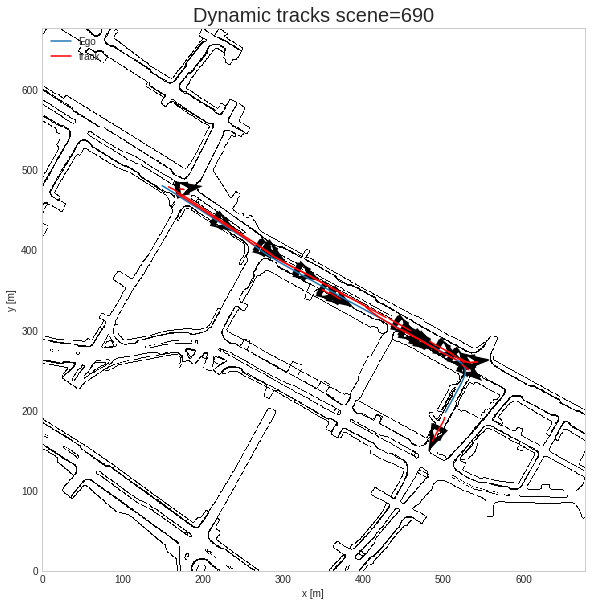

In [1177]:
from map_utils import getRoadBorders, getCombinedMap
def drawMap(ax, nusc_map, ego_path):
    x_min = np.min(ego_path[:,0])
    x_max = np.max(ego_path[:,0])
    x_mean = 0.5*(x_min+x_max)
    y_min = np.min(ego_path[:,1])
    y_max = np.max(ego_path[:,1])
    y_mean = 0.5*(y_min+y_max)
    patch_size = int(max(abs(y_max-y_min), abs(x_max-x_min))) + 300

    first_pos = [x_mean, y_mean]
    patch_size = patch_size
    edges = getCombinedMap(nuscMap=nusc_map, worldRef=first_pos, patchSize=patch_size)

    ax.imshow(edges, origin='lower')
    ax.grid(False)
    #ax.set_xlim([patch_size/2 - (x_mean-x_min) - 100,patch_size/2 + (x_max-x_mean) + 100])
    #ax.set_ylim([patch_size/2 - (y_mean-y_min) - 100,patch_size/2 + (y_max-y_mean) + 100])
    
    x_offset = -first_pos[0]+patch_size*0.5
    y_offset = -first_pos[1]+patch_size*0.5
    return x_offset, y_offset

def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 10:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)

tracks = tracker.getHistory()
N = len(tracks)
print(f"Total number of tracks = {N}")

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]


ax.set_title(f"Dynamic tracks scene={scene_id}", fontsize=20)
ax.set(xlabel='x [m]', ylabel='y [m]')
ego_path = dataset.getEgoPath()[:n_frames]
nusc_map = dataset.getMap()
x_offset, y_offset = drawMap(ax, nusc_map, ego_path)
print("x_offset",x_offset,"y_offset",y_offset)
ax.plot(ego_path[start_frame:n_frames,0]+x_offset, ego_path[start_frame:n_frames,1]+y_offset,label='Ego')
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=x_offset, y_offset=y_offset, velThr=2)
ax.legend(loc="upper left")
    

In [497]:
np.rad2deg(math.atan(21/59))

19.592281891051528

In [502]:
np.rad2deg(-0.14221401)

-8.148262560631284

In [996]:
np.sqrt(0.17**2+0.37**2)

0.40718546143004664

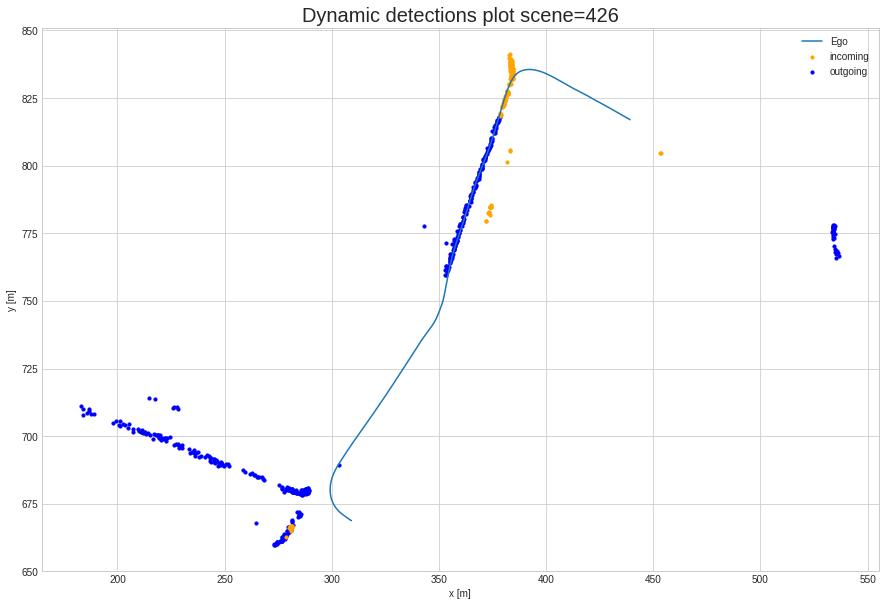

In [1167]:
ax.set_title(f"Dynamic detections plot scene={scene_id}", fontsize=20)
ax.set(xlabel='x [m]', ylabel='y [m]')
ax.legend(['Ego', 'incoming','outgoing'])
leg = ax.get_legend()
#leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('orange')
leg.legendHandles[2].set_color('blue')
fig
